In [64]:
import xgboost as xgb
import pandas as pd
import numpy as np
import os
import random
import seaborn as sns

from matplotlib import figure, pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import OrdinalEncoder
import statsmodels.api as sm

In [65]:
# These are my default settings for matplotlib. Of course you can delete them
plt.rcParams["font.family"] = "Times New Roman"
plt.rc("xtick",labelsize=12)
plt.rc("ytick",labelsize=12)
plt.rcParams["figure.figsize"] = (20,16)
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'xtick.labelsize': 18})
plt.rcParams.update({'ytick.labelsize': 18})

# Functions

In [66]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

In [67]:
def plot_num_target(df, numeric, df2=None, target='SalePrice', mark_specific_points=False,):
    plt.scatter(df[numeric],df[target])
    if mark_specific_points == True:
        plt.scatter(df2[numeric],df2[target], marker='*', s=500)
    plt.xlabel(numeric)
    plt.ylabel(target)
    plt.show()

In [68]:
def plot_cat_target(df, categorical, target='SalePrice'):
    fig, ax = plt.subplots()
    fig = sns.boxplot(x=categorical, y=target, data=df)
    #fig.xlabel(numeric)

# Others

In [69]:
# Global seed number so that you are able to replicate my results using the function set_seed
seed_number = 187

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# 1. Exploratory Data Analysis (EDA)

In [70]:
df = pd.read_csv('train.csv')

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We have 79 explanatory variables (+ ID column) and one target variable

In [72]:
df.isna().sum().sum()

6965

In [73]:
df.isna().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

We have missing values in several columns. We will have a look at them later

## EDA: Target Variable

In [74]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

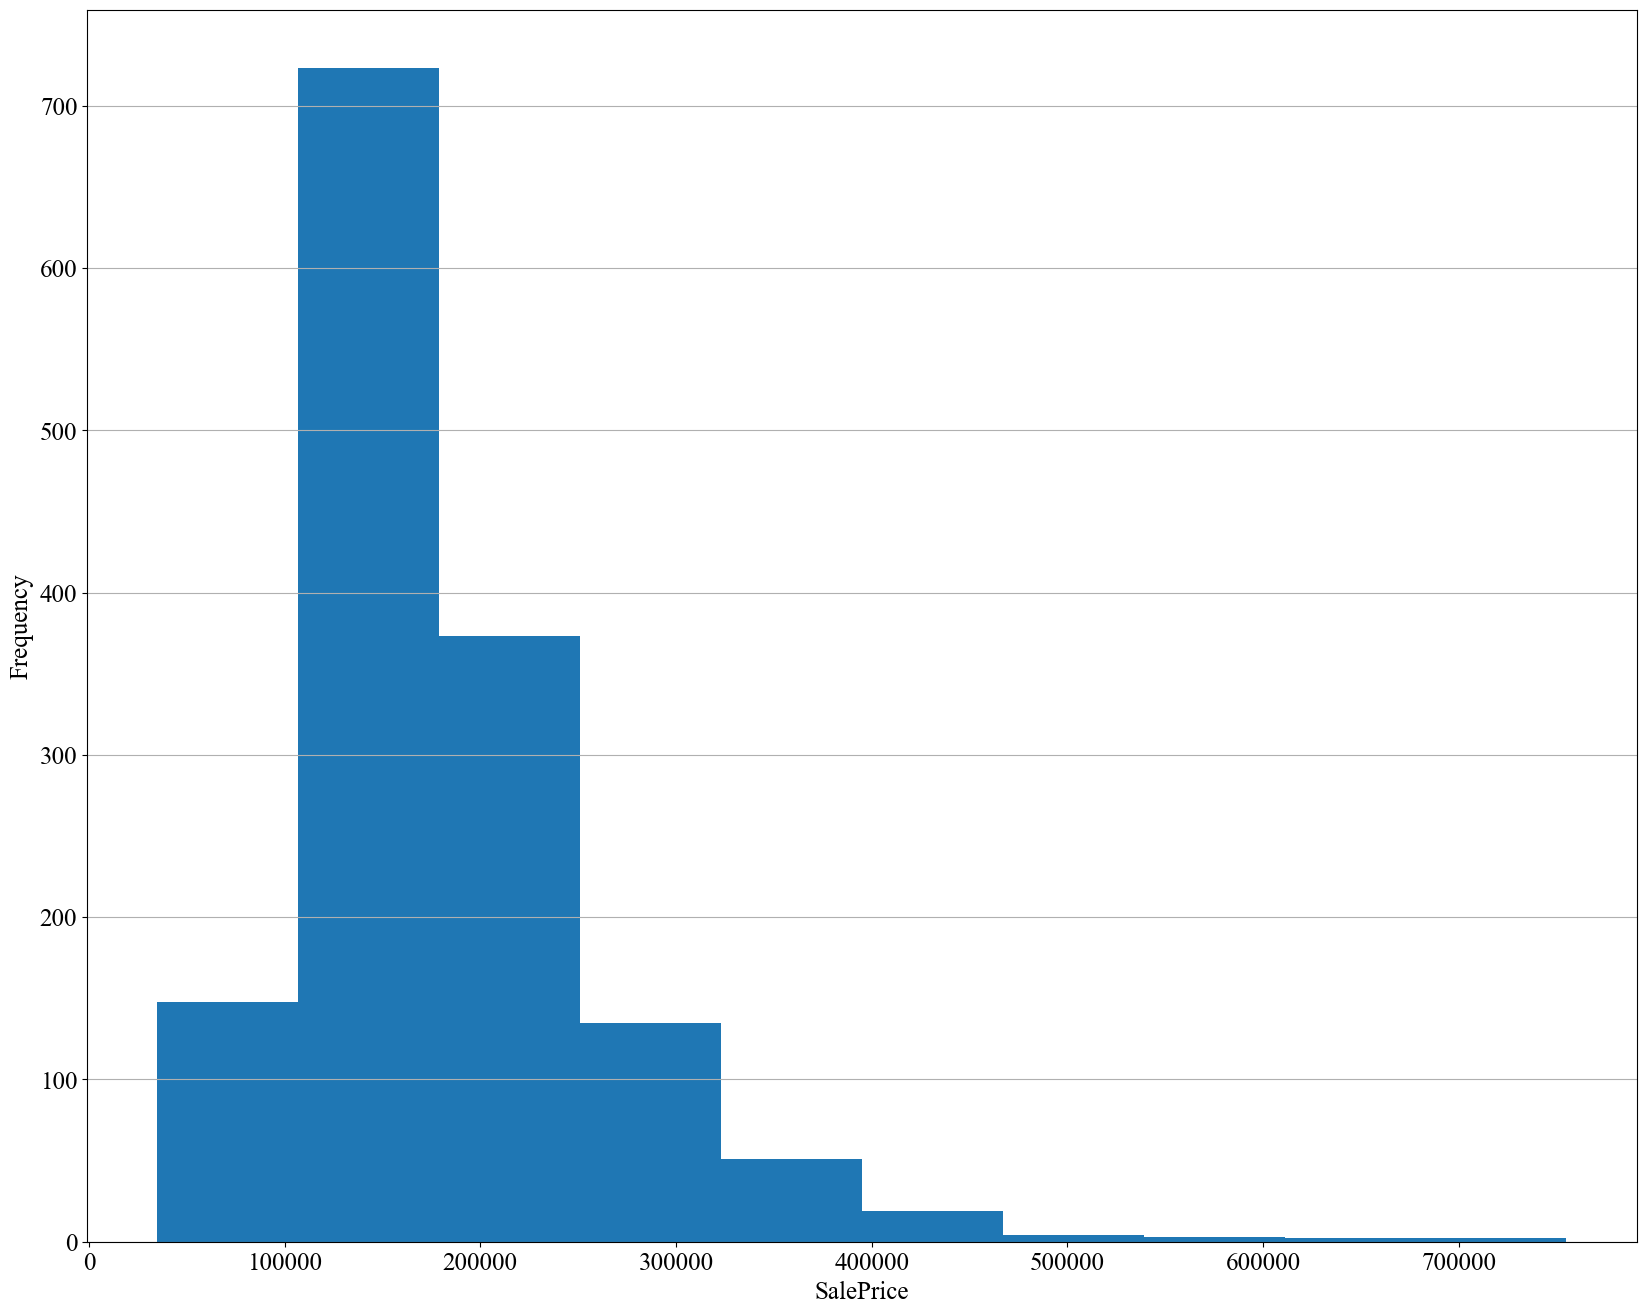

In [75]:
fig, ax1 = plt.subplots()
df['SalePrice'].hist(ax=ax1)
ax1.grid(axis='x')
ax1.set_xlabel('SalePrice')
ax1.set_ylabel('Frequency')
plt.show()

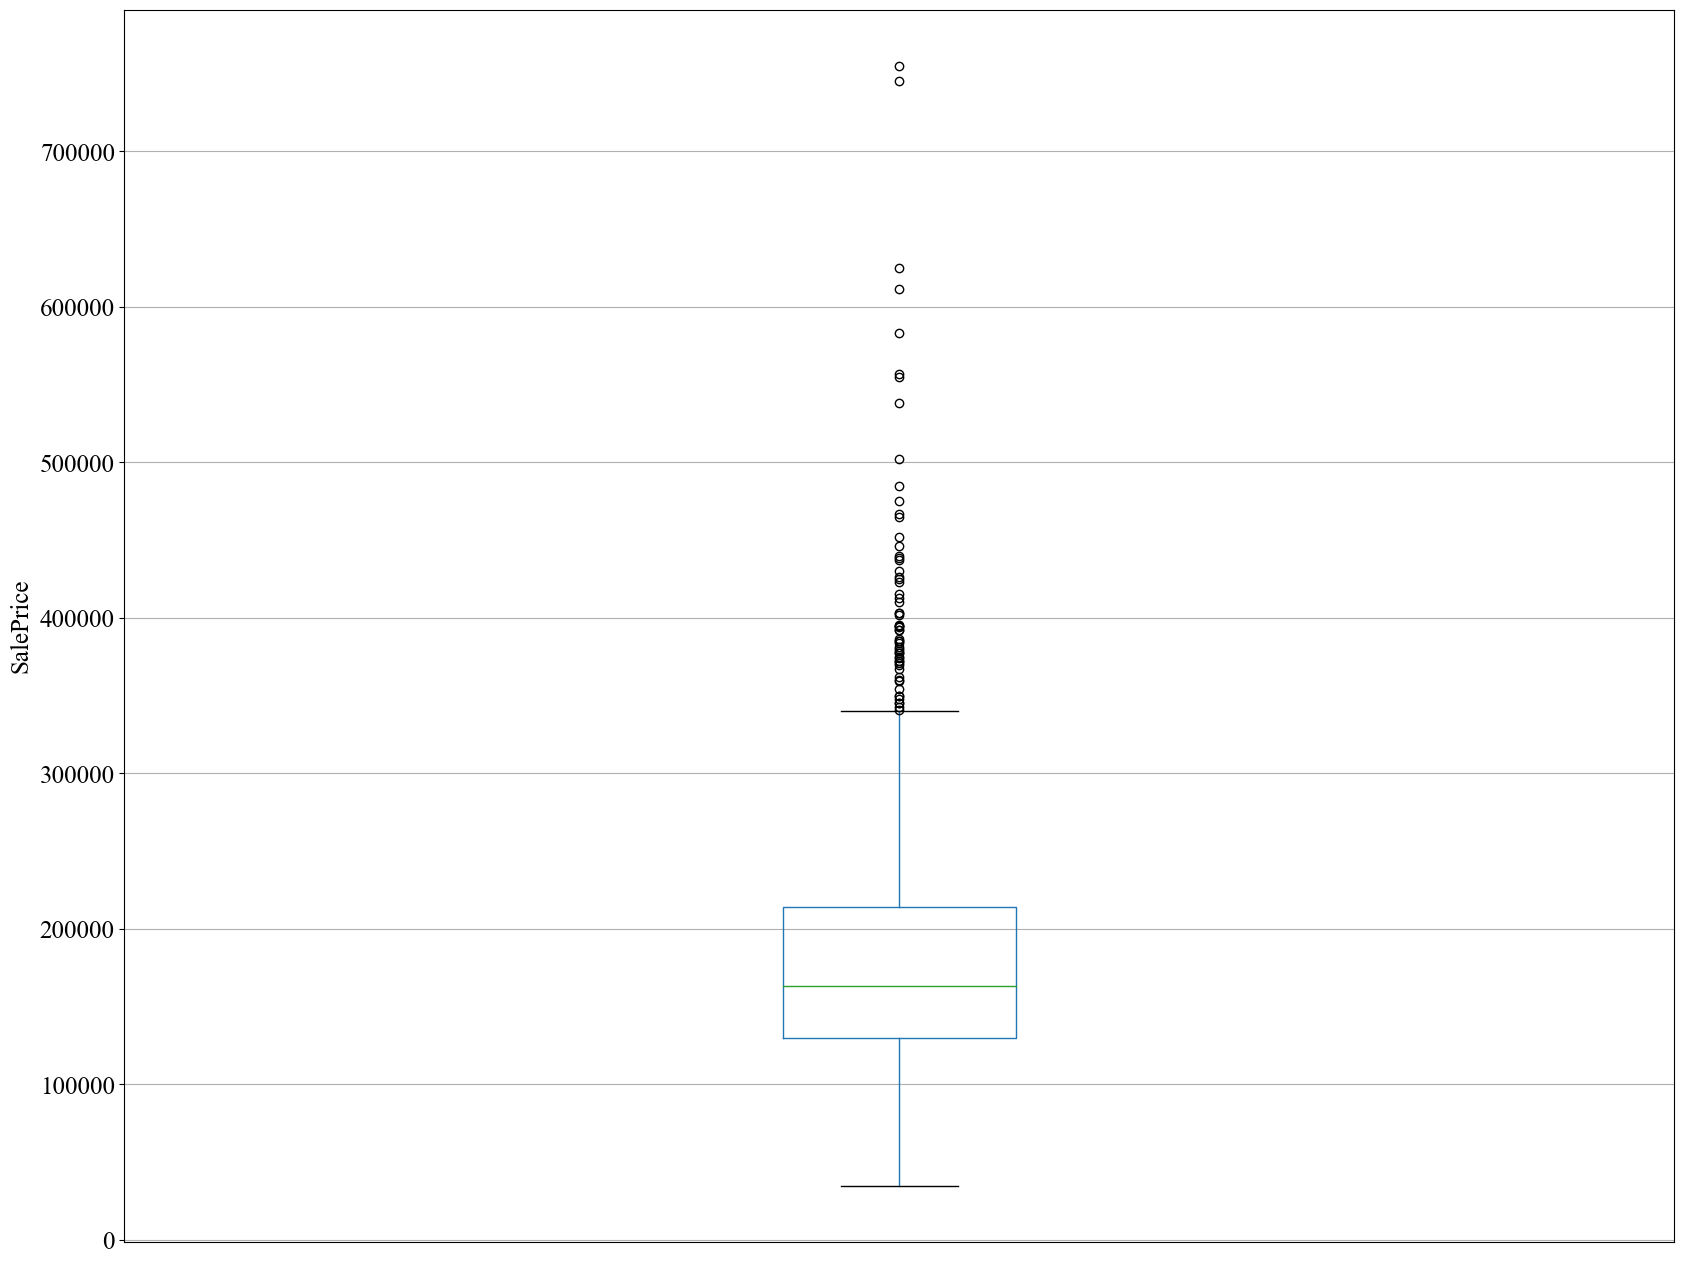

In [76]:
fig, ax1 = plt.subplots()
df[['SalePrice']].boxplot(ax=ax1)
ax1.grid(axis='x')
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
ax1.set_ylabel('SalePrice')
plt.show()

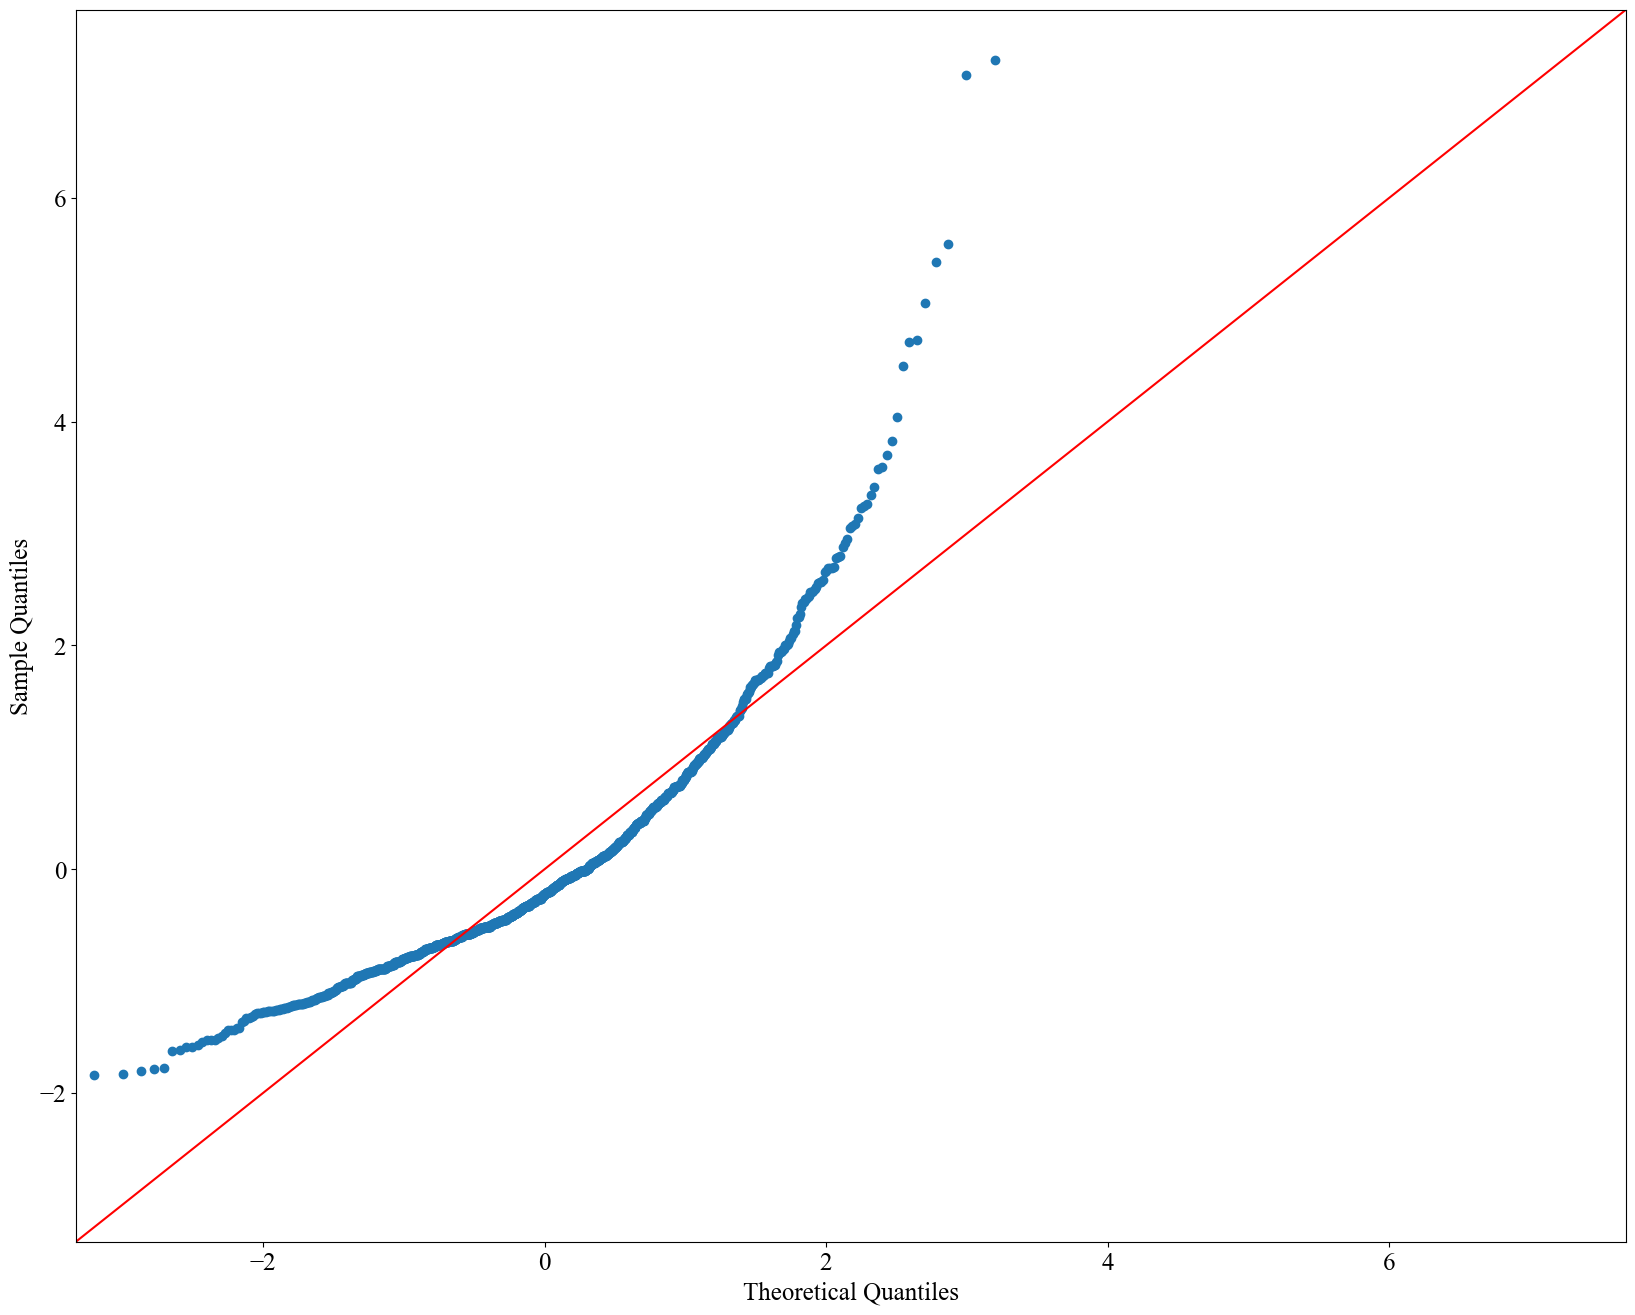

In [77]:
qqplot = sm.qqplot(df['SalePrice'], line='45',fit=True)

In [78]:
shapiro(df['SalePrice'])

ShapiroResult(statistic=0.869672954082489, pvalue=3.2072044604461286e-33)

## EDA: Numetic Features

In [79]:
df_numeric = df.select_dtypes(include=['int64', 'float64'])
df_numeric = df_numeric.drop('Id',axis=1)
df_numeric.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315   
std      30.202904     20.645407   181.066207   456.098091   161.319273   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000   
25%    1954.000000   1967.000000     0.000000     0.000000     0.000000   
50%    1973.000000   1994.000000     0.000000   383.500000     0.000000   
75%    2000.000000   2004.000000   166.000000   712.250000     0.000000   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000   

         BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000   1460.000000   
mean    567.240411  1057.429452  1162.626712   346.992466      5.844521   
std     441.866955   438.705324   386.587738   436.528436     48.623081   
min       0.000000     0.000000   334.000000     0.000000      0.000000   
25%     223.000000   795.750000   882.000000     0.000000      0.000000   
50%     477.500000   991.500000  1087.000000     0.000000      0.000000   
75%     808.000000  1298.250000  1391.250000   728.000000      0.000000   
max    2336.000000  6110.000000  4692.000000  2065.000000    572.000000   

         GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  \
count  1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   
mean   1515.463699      0.425342      0.057534     1.565068     0.382877   
std     525.480383      0.518911      0.238753     0.550916     0.502885   
min     334.000000      0.000000      0.000000     0.000000     0.000000   
25%    1129.500000      0.000000      0.000000     1.000000     0.000000   
50%    1464.000000      0.000000      0.000000     2.000000     0.000000   
75%    1776.750000      1.000000      0.000000     2.000000     1.000000   
max    5642.000000      3.000000      2.000000     3.000000     2.000000   

       BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt  \
count   1460.000000   1460.000000   1460.000000  1460.000000  1379.000000   
mean       2.866438      1.046575      6.517808     0.613014  1978.506164   
std        0.815778      0.220338      1.625393     0.644666    24.689725   
min        0.000000      0.000000      2.000000     0.000000  1900.000000   
25%        2.000000      1.000000      5.000000     0.000000  1961.000000   
50%        3.000000      1.000000      6.000000     1.000000  1980.000000   
75%        3.000000      1.000000      7.000000     1.000000  2002.000000   
max        8.000000      3.000000     14.000000     3.000000  2010.000000   

        GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count  1460.000000  1460.000000  1460.000000  1460.000000    1460.000000   
mean      1.767123   472.980137    94.244521    46.660274      21.954110   
std       0.747315   213.804841   125.338794    66.256028      61.119149   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       1.000000   334.500000     0.000000     0.000000       0.000000   
50%       2.000000   480.000000     0.000000    25.000000       0.000000   
75%       2.000000   576.000000   168.000000    68.000000   

In [80]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1452 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

In [81]:
df_numeric.isna().sum()

MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

Here are the descriptions of the columns that consist of missing values:

- LotFrontage (259 missing values): Linear feet of street connected to property
- MasVnrArea (8 missing values): Masonry veneer area in square feet
- GarageYrBlt (81 missing values): Year garage was built

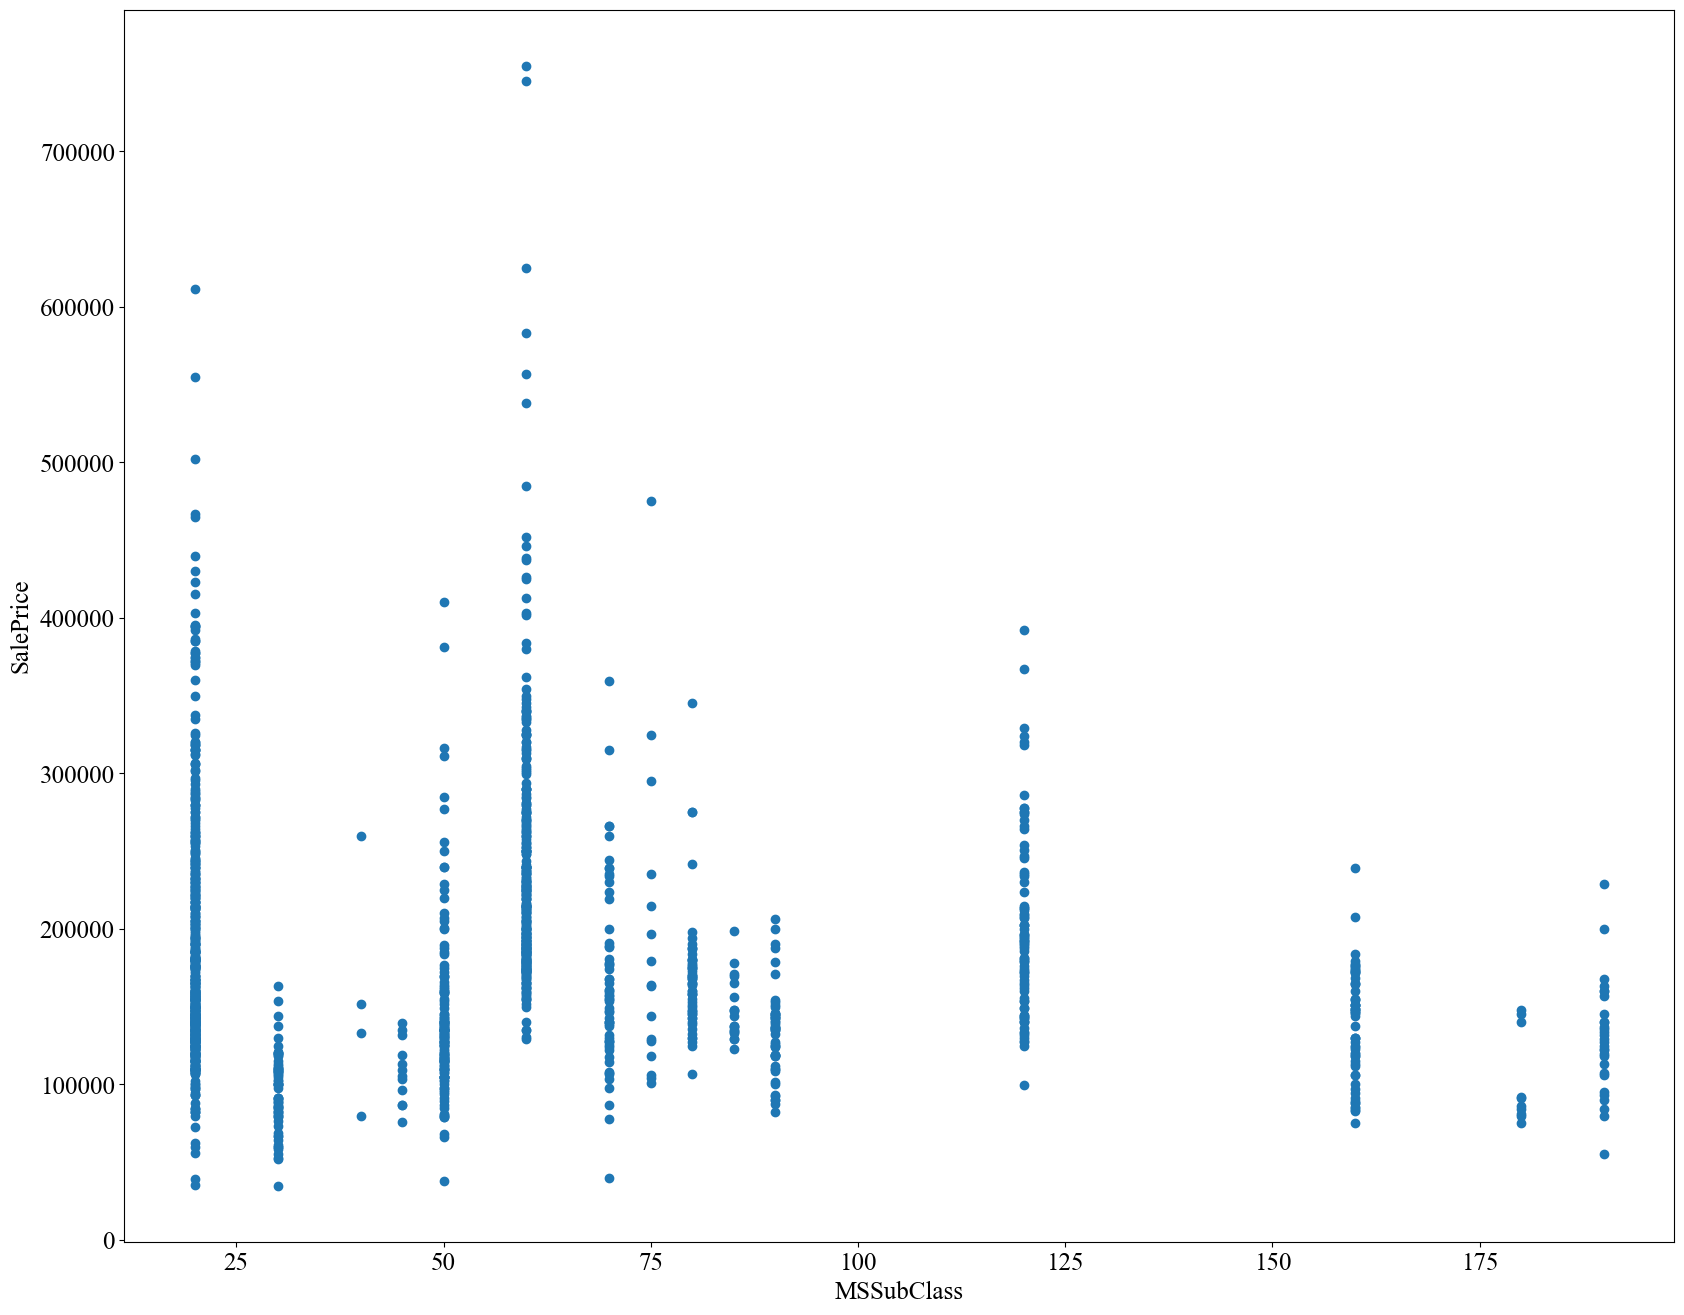

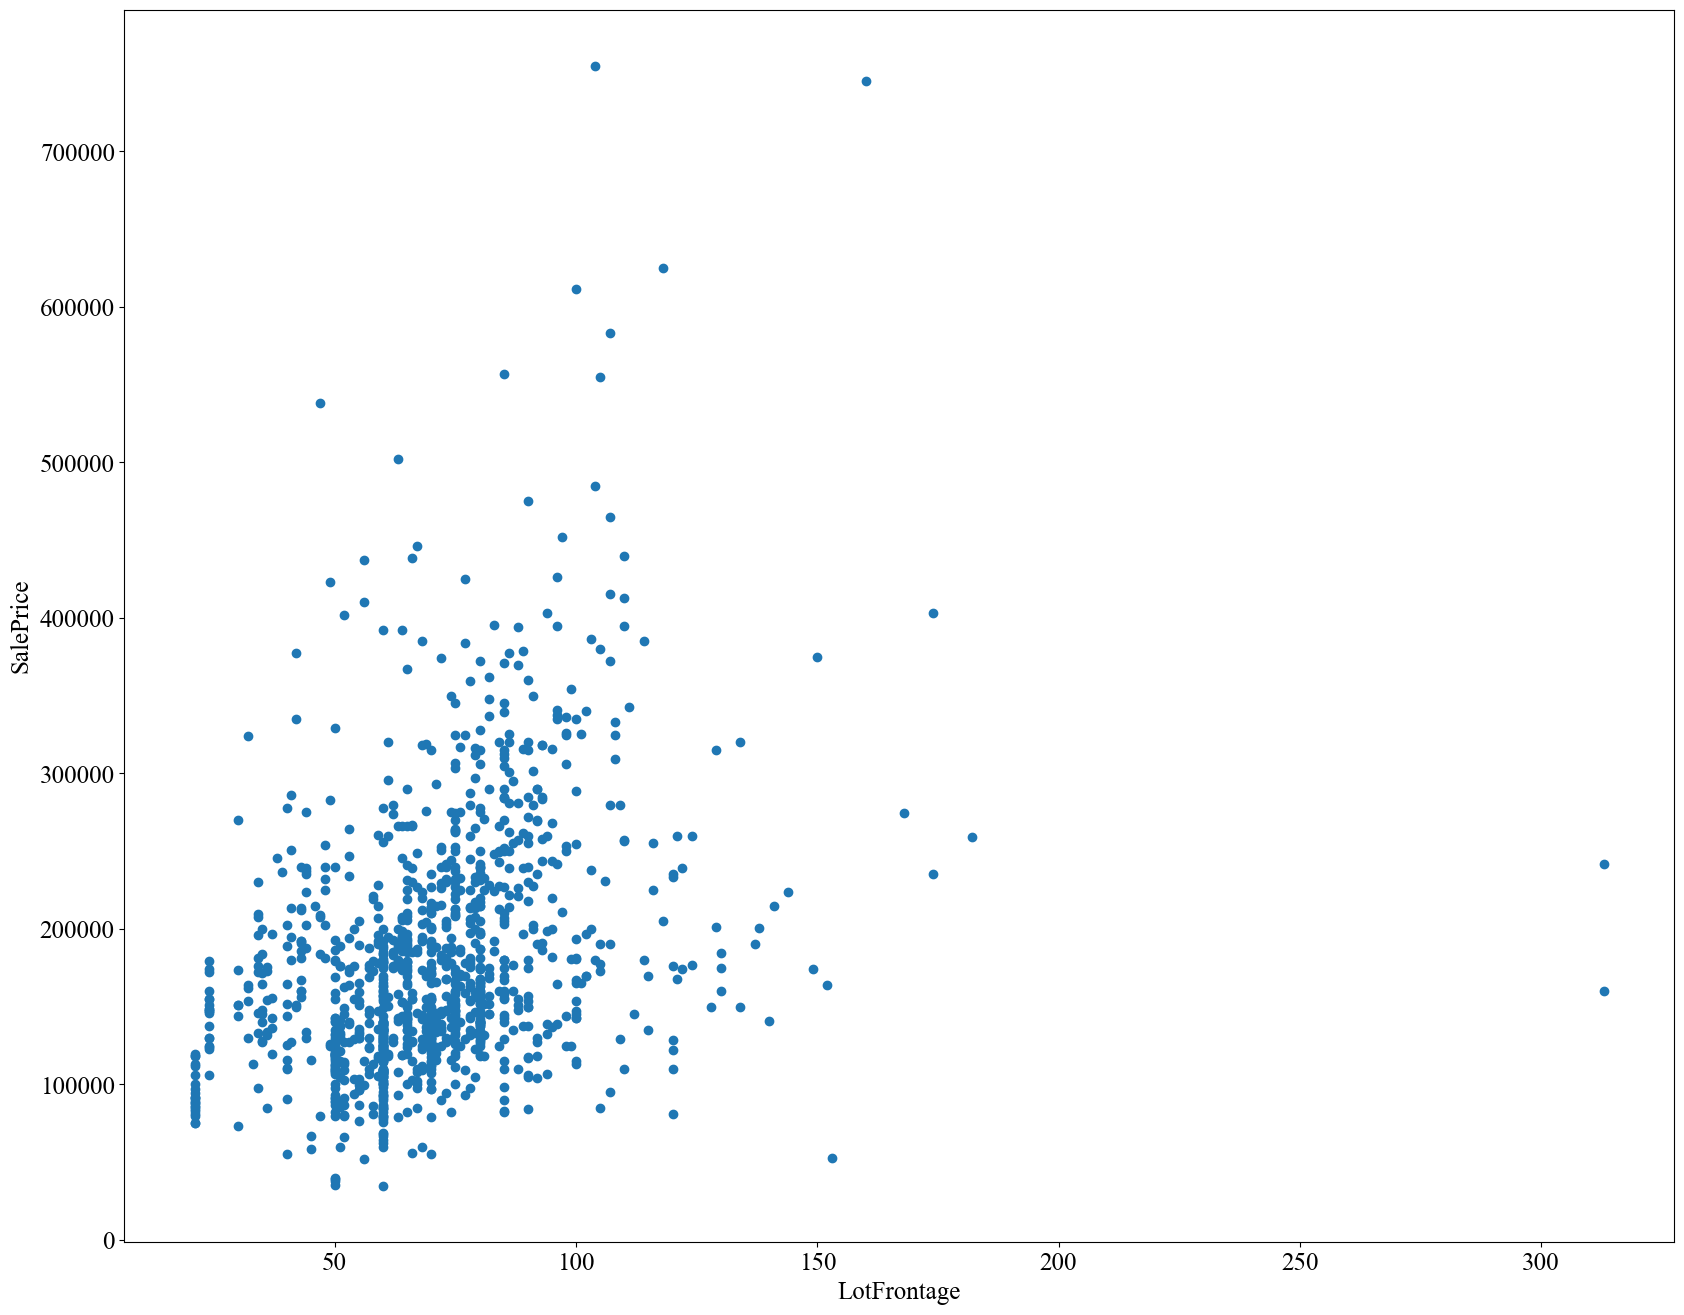

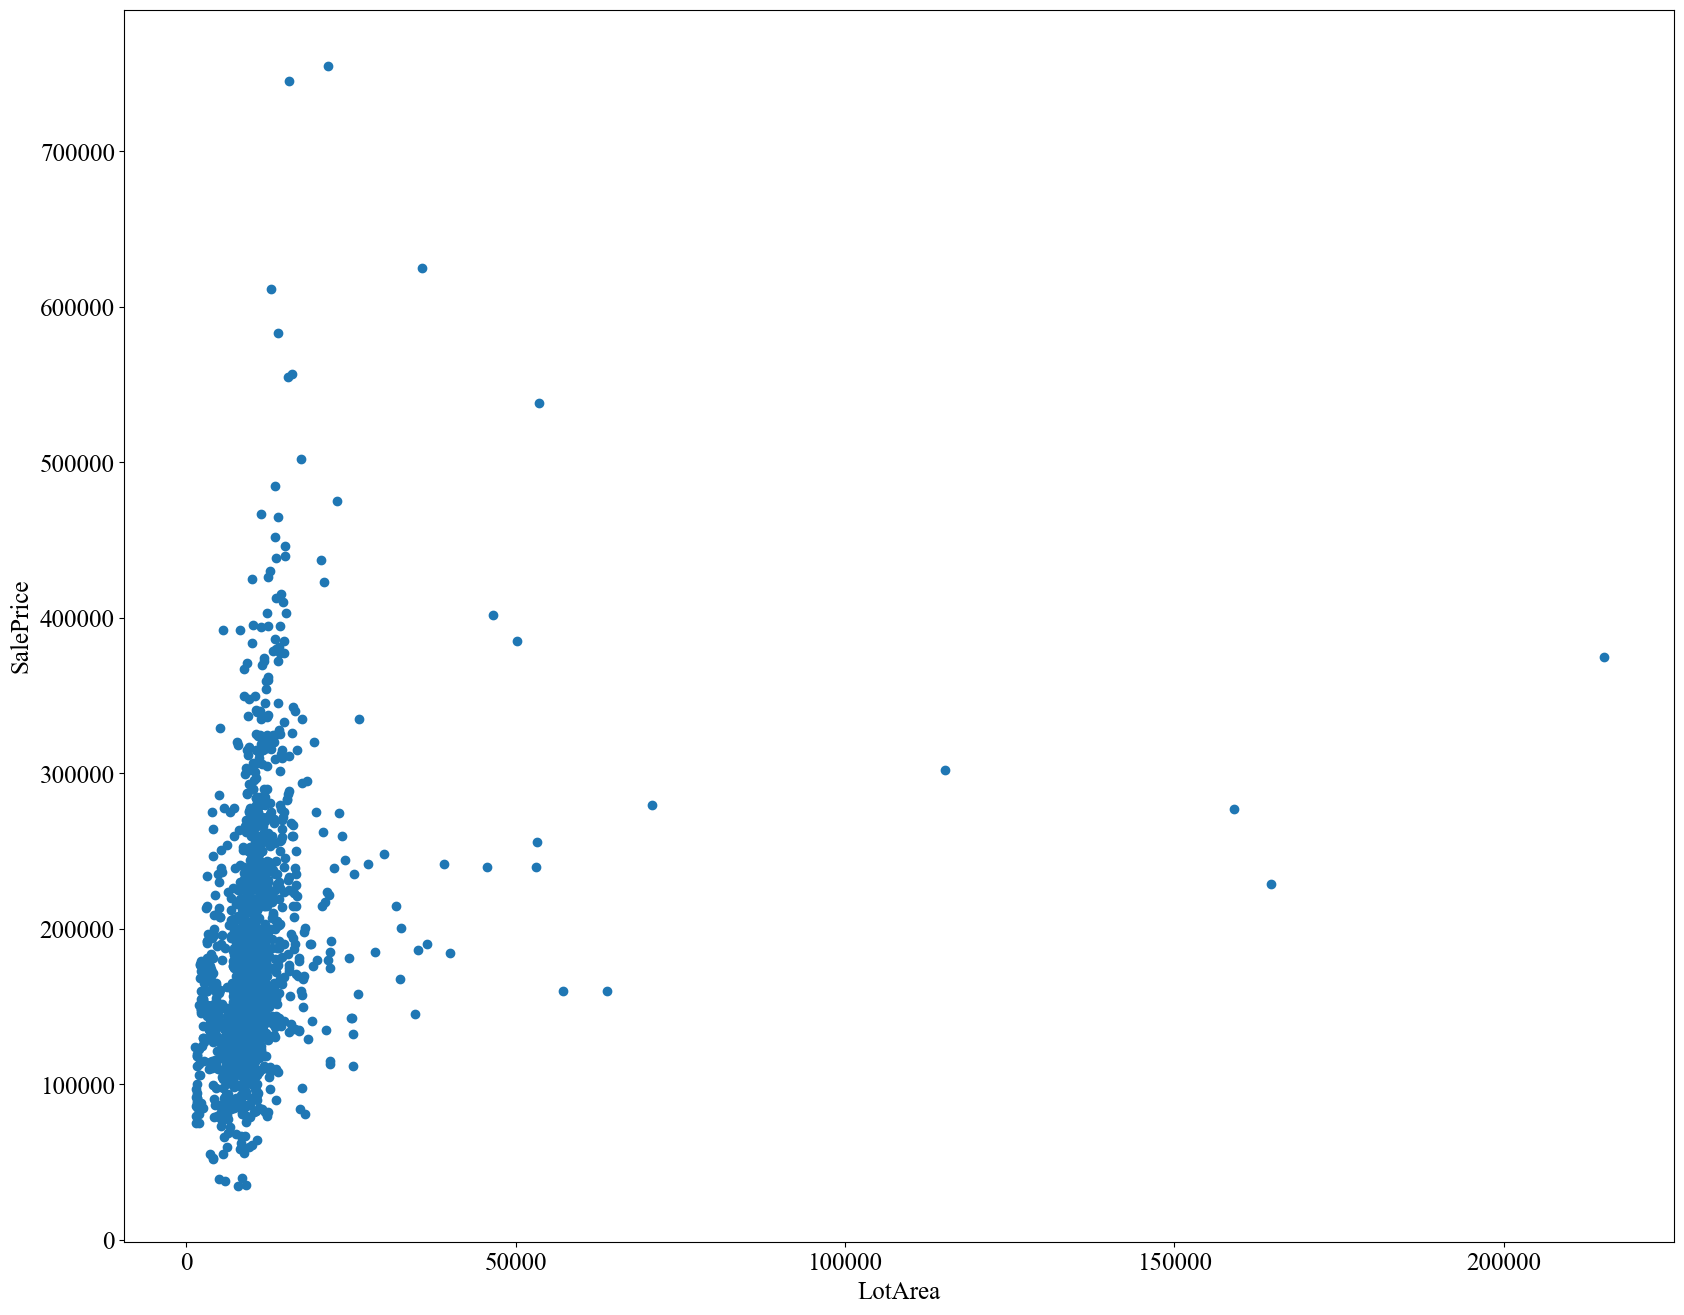

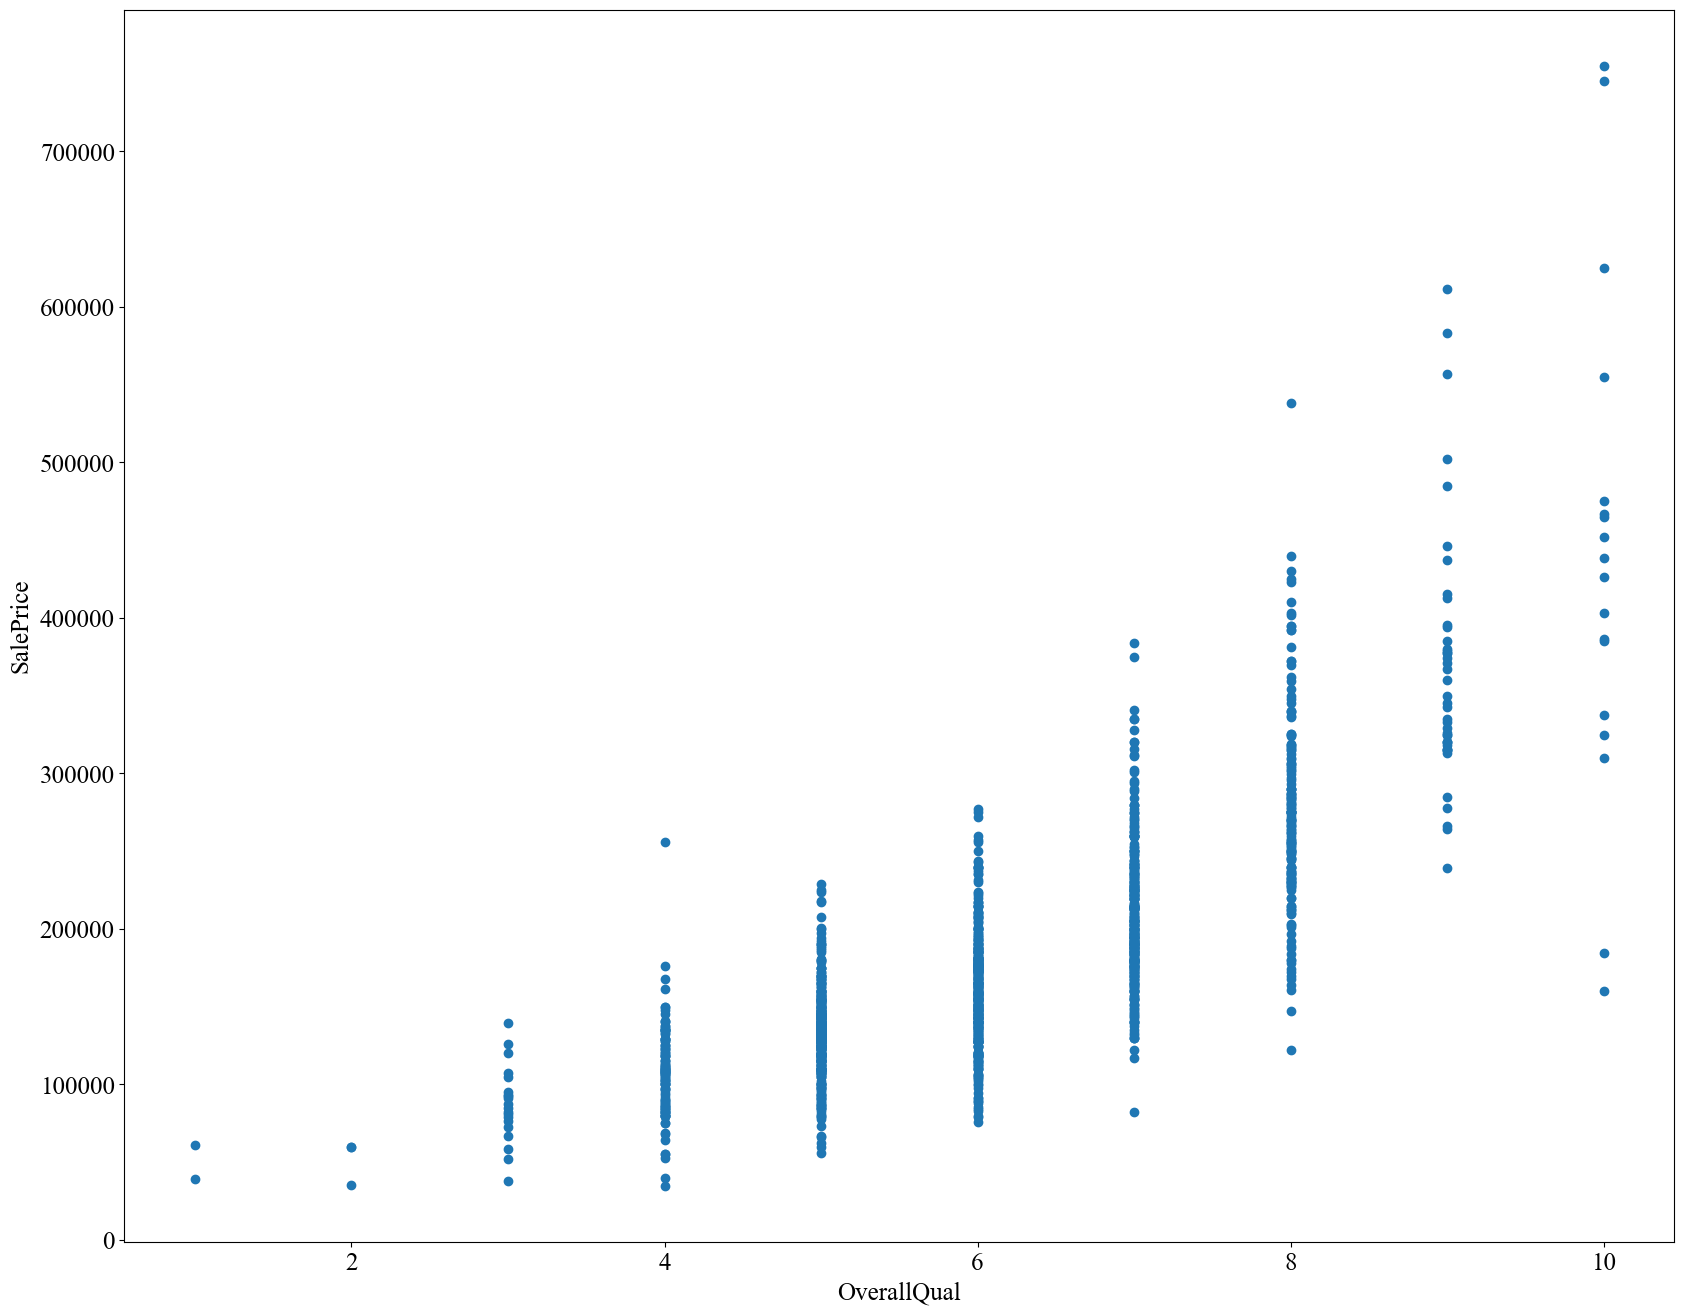

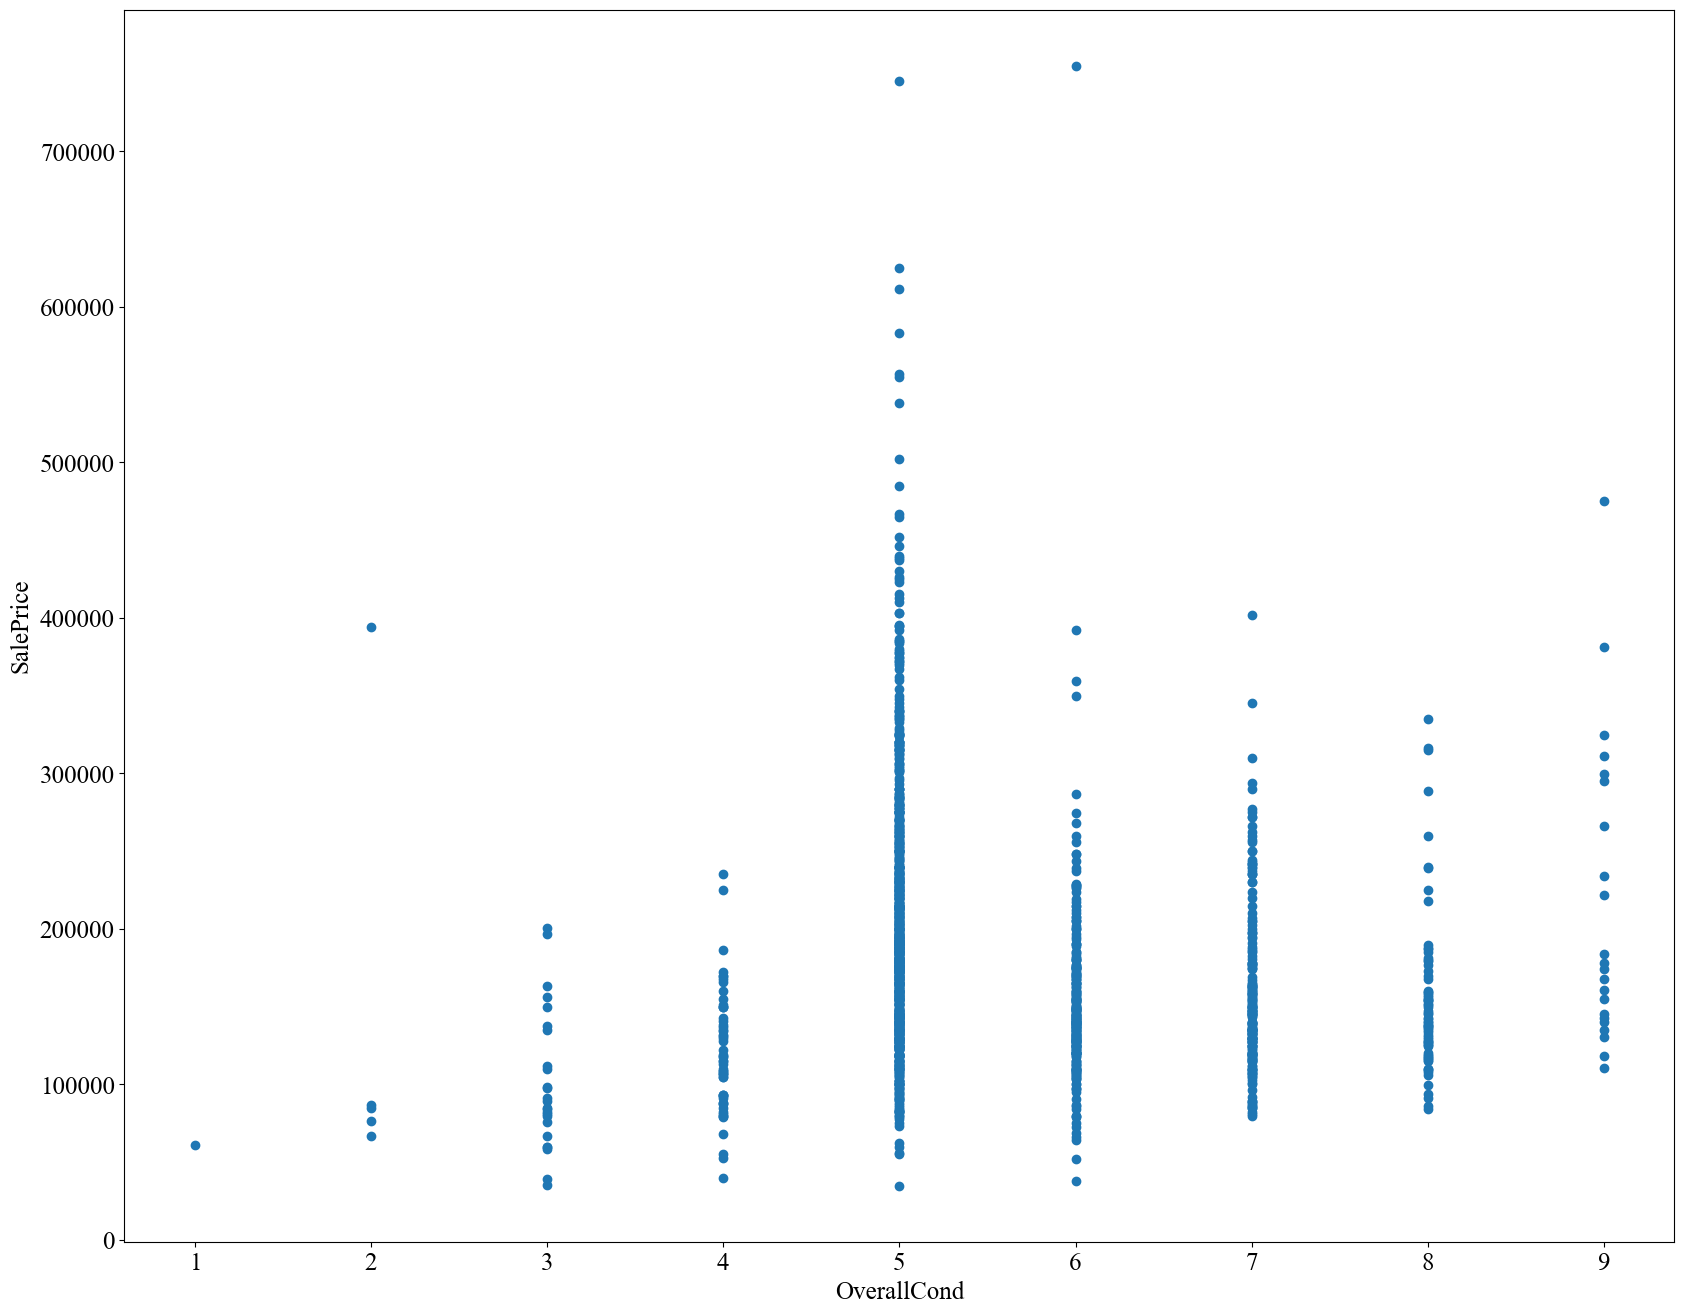

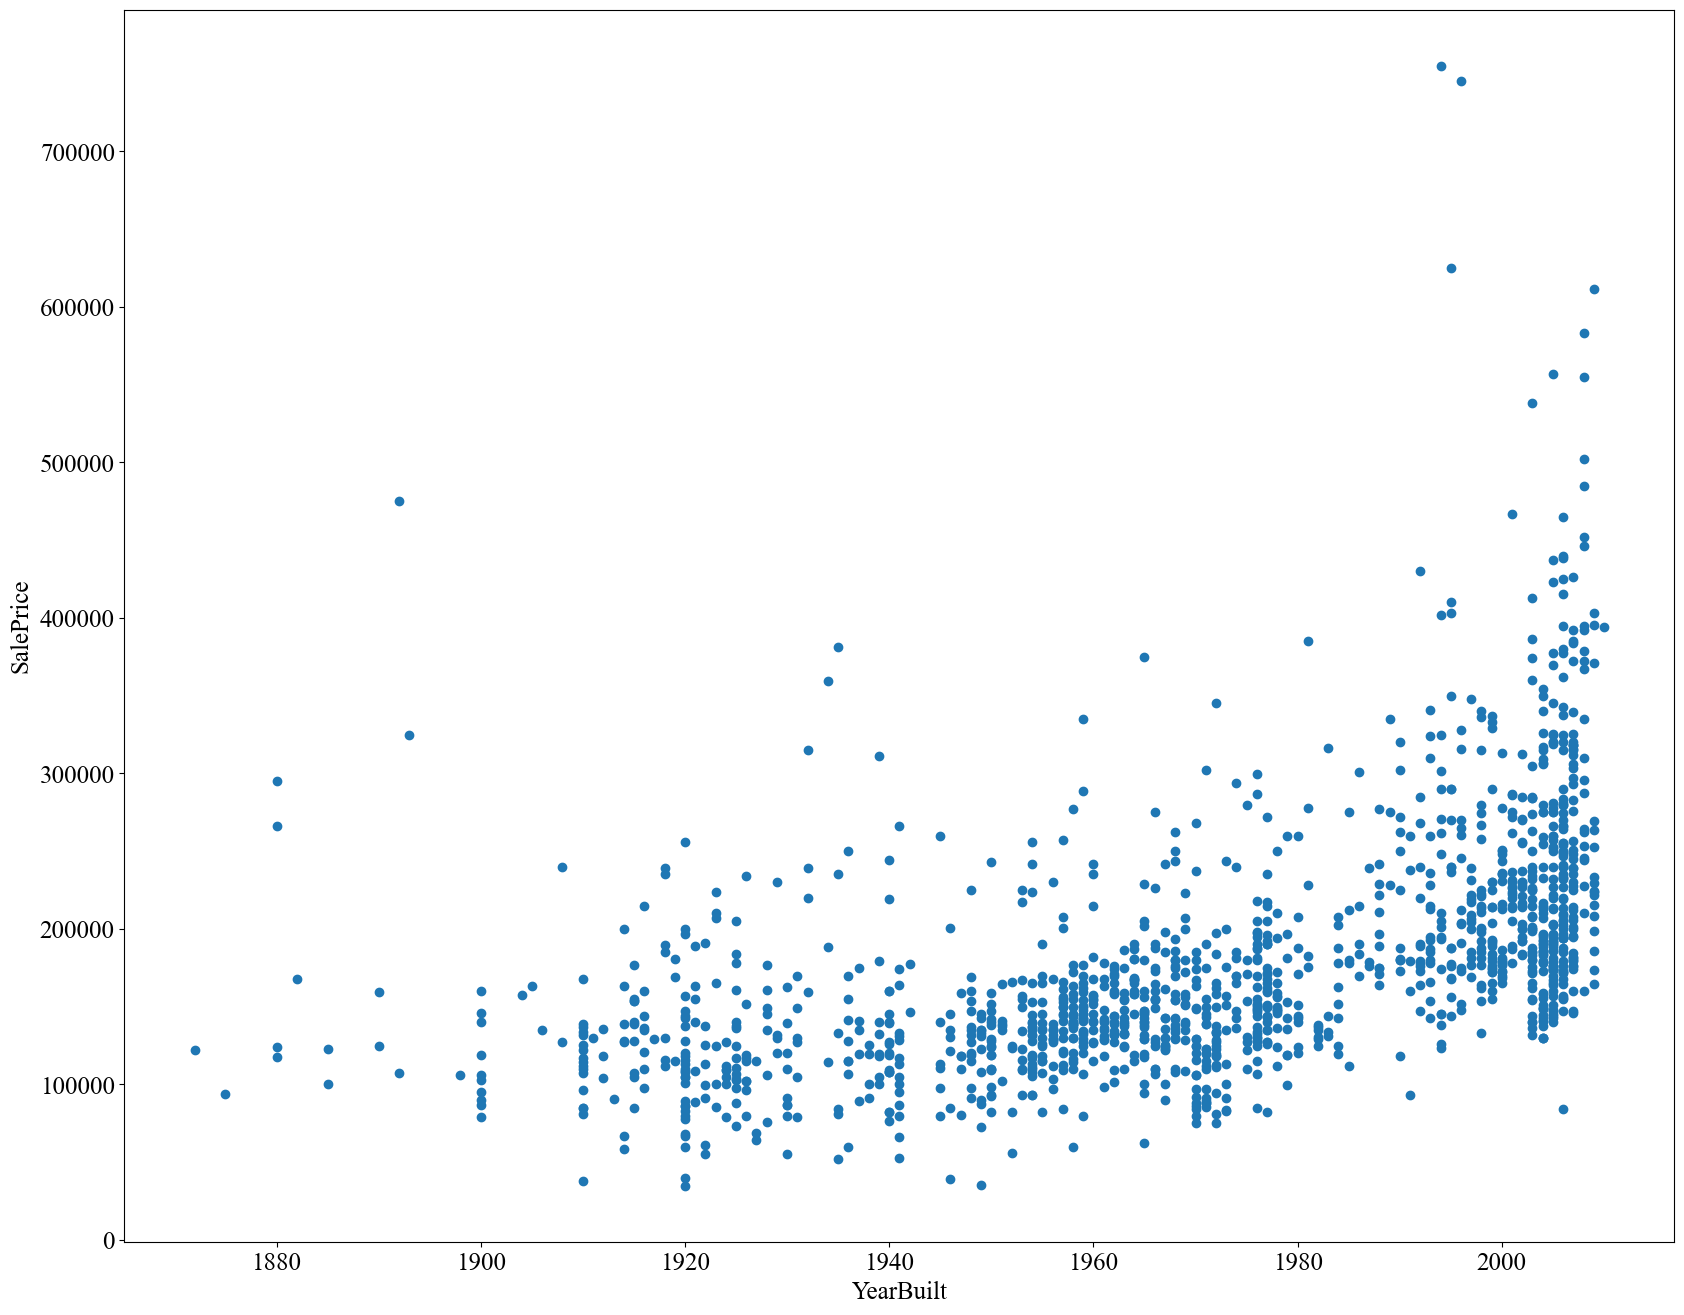

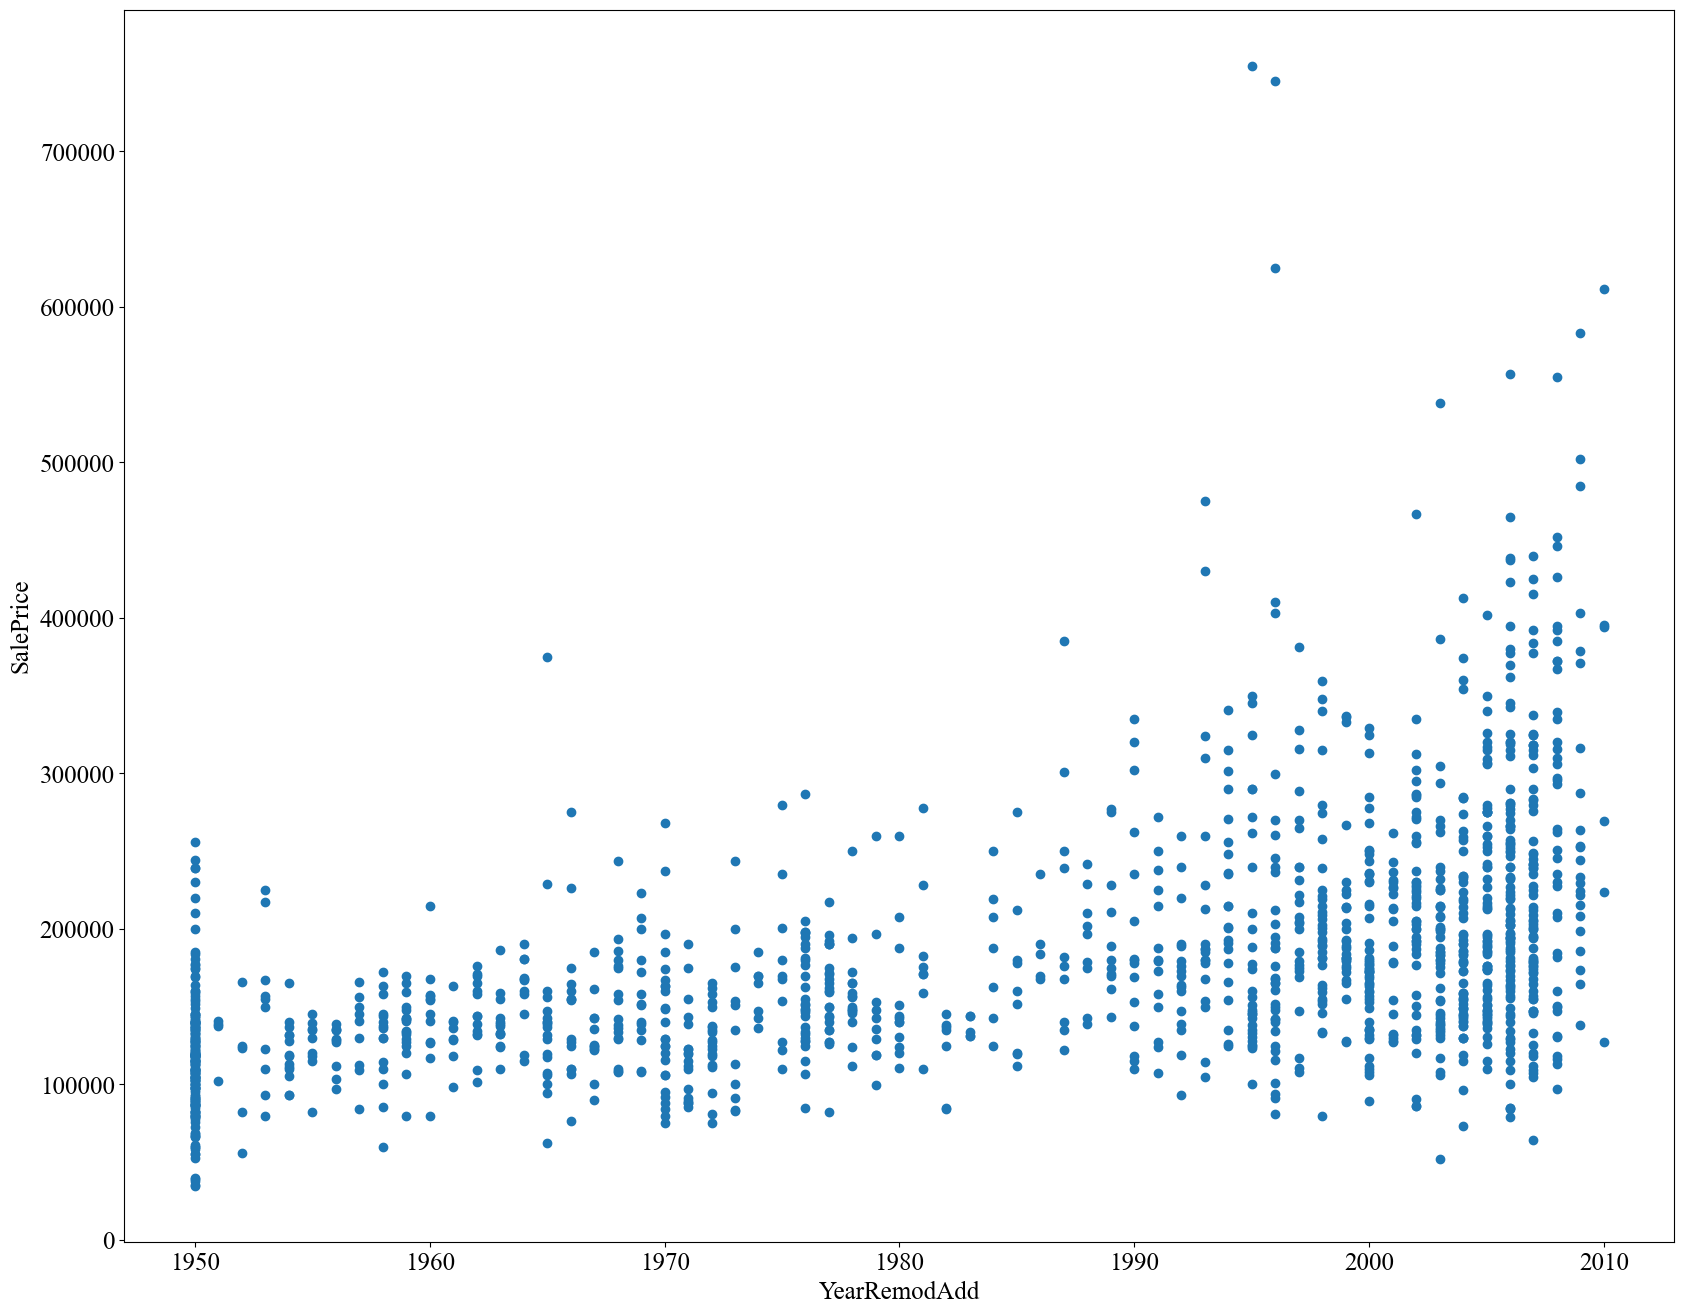

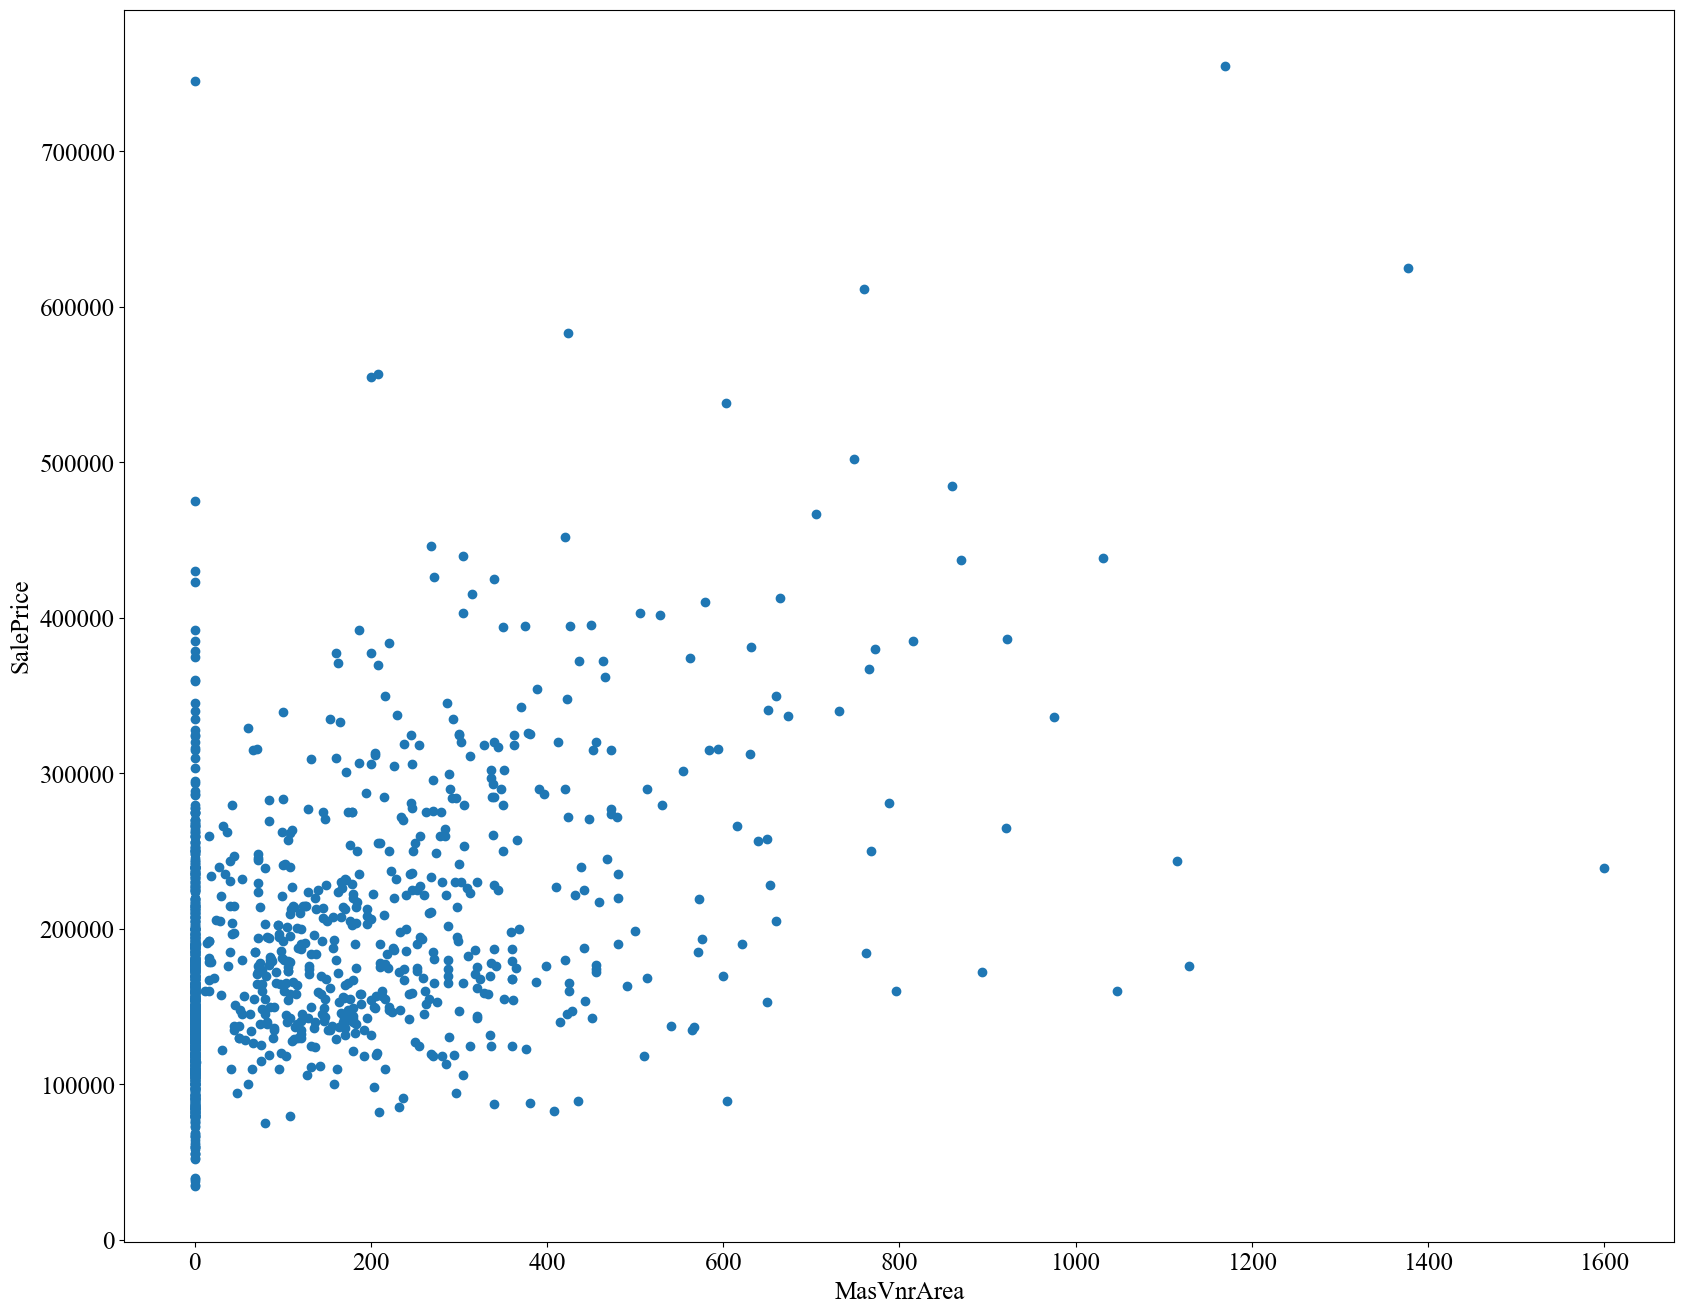

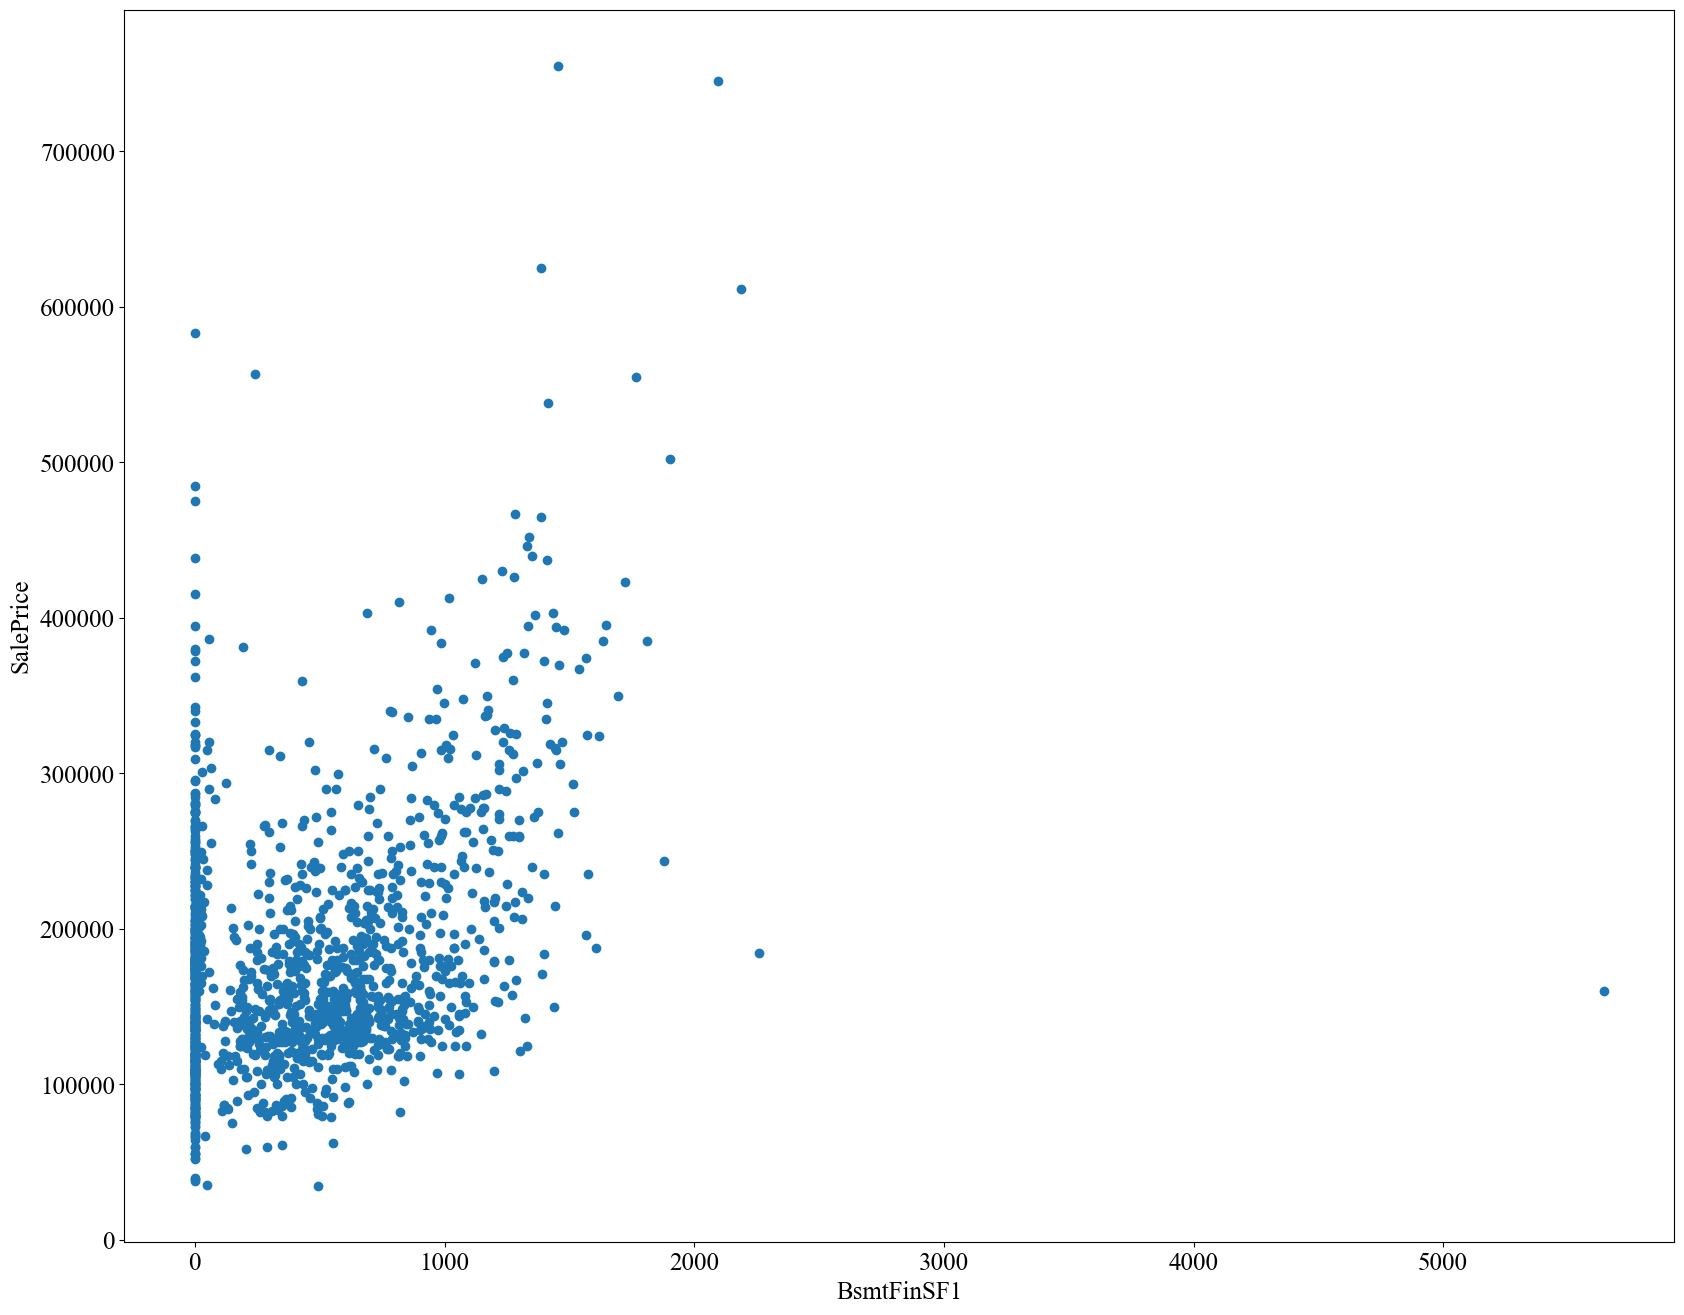

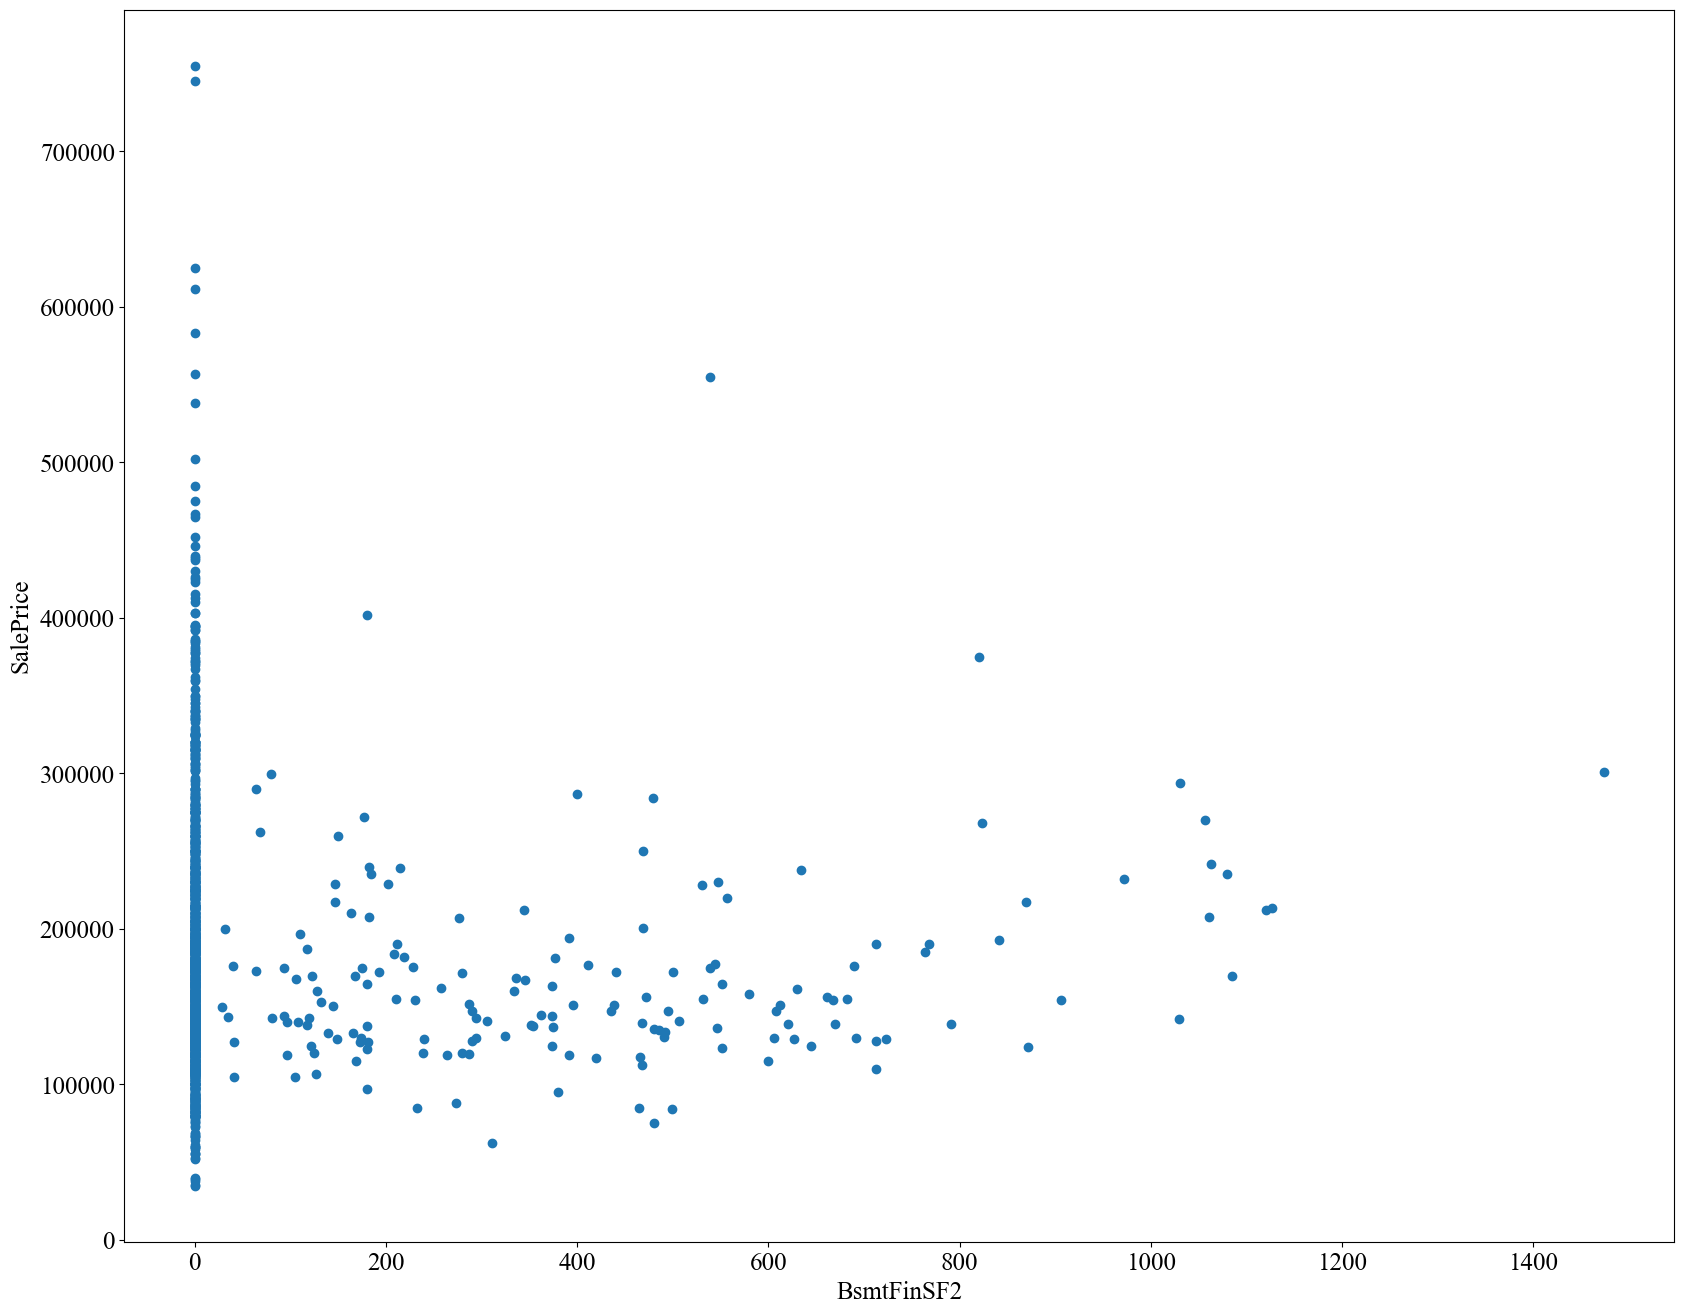

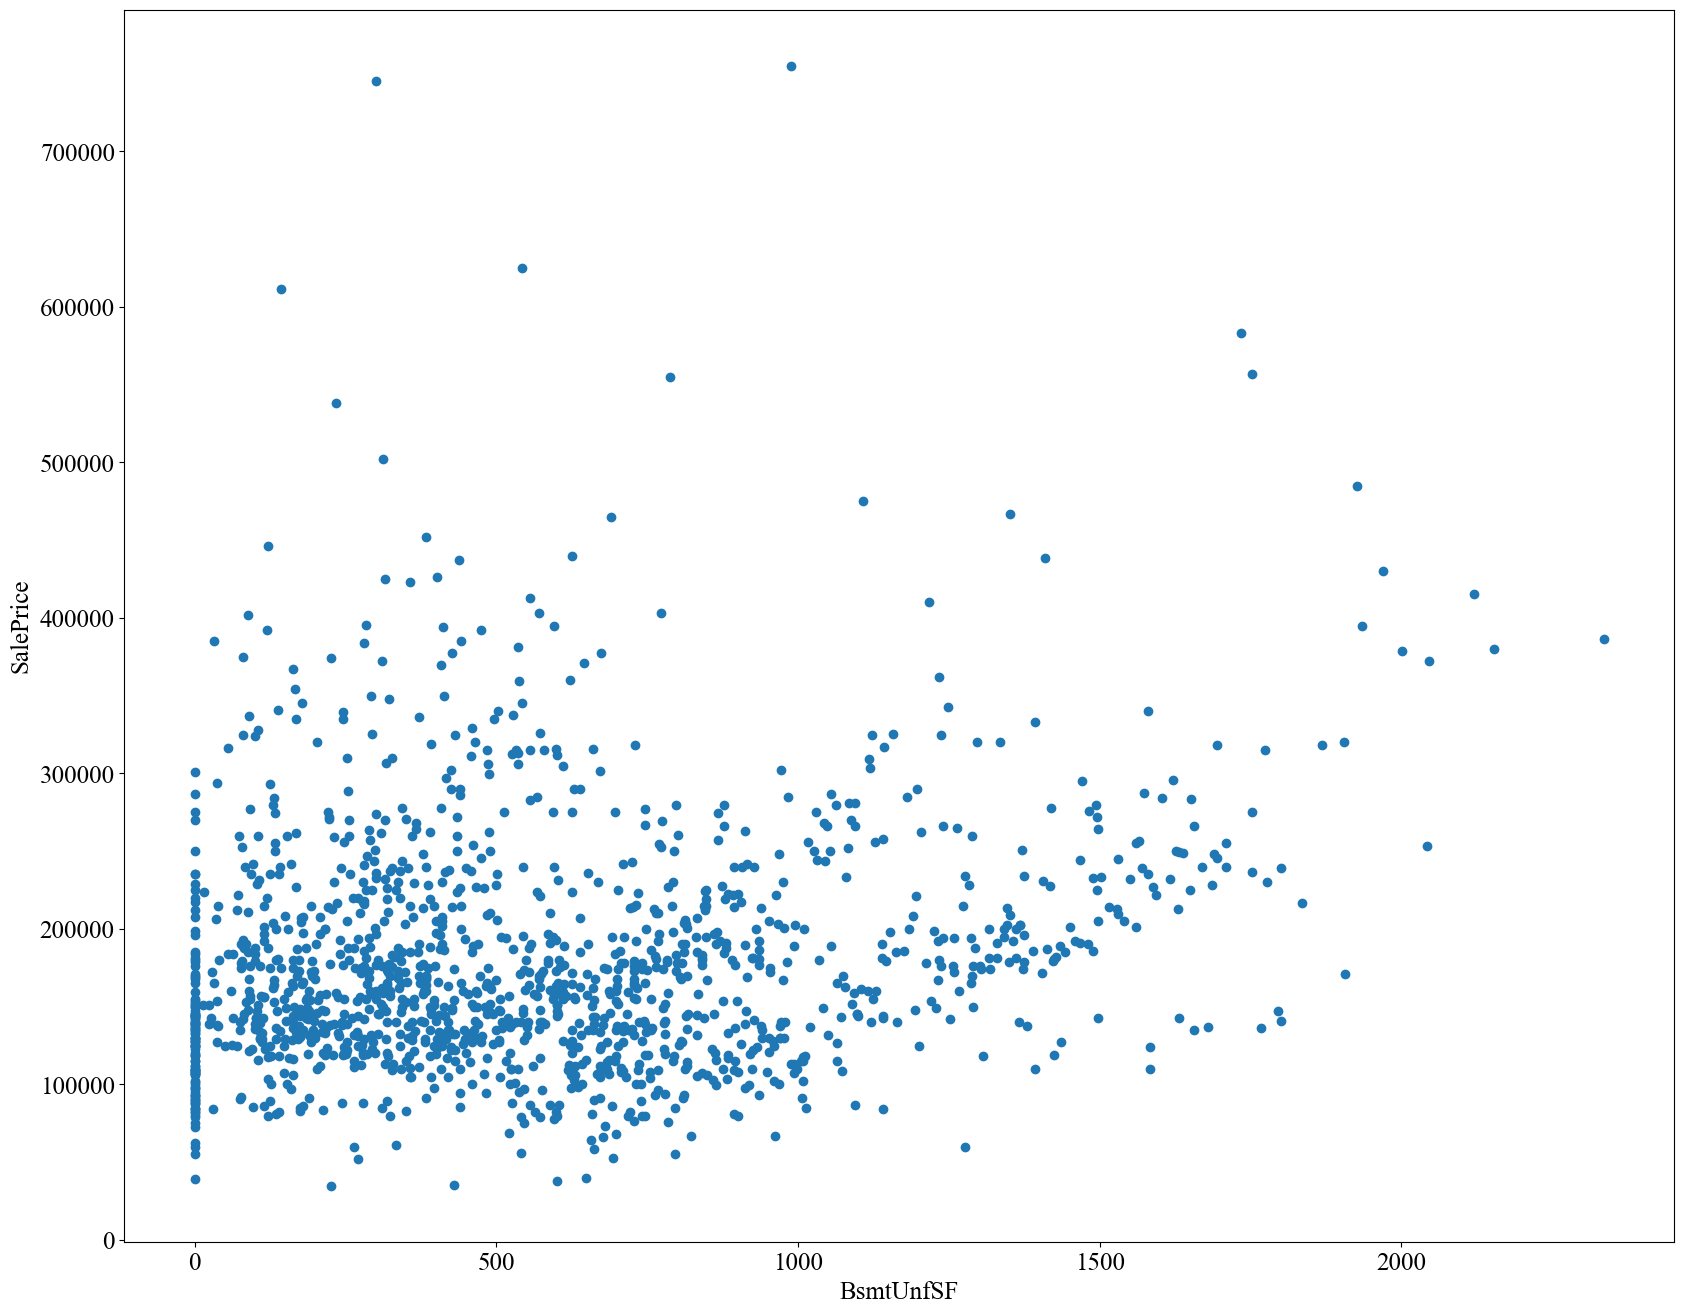

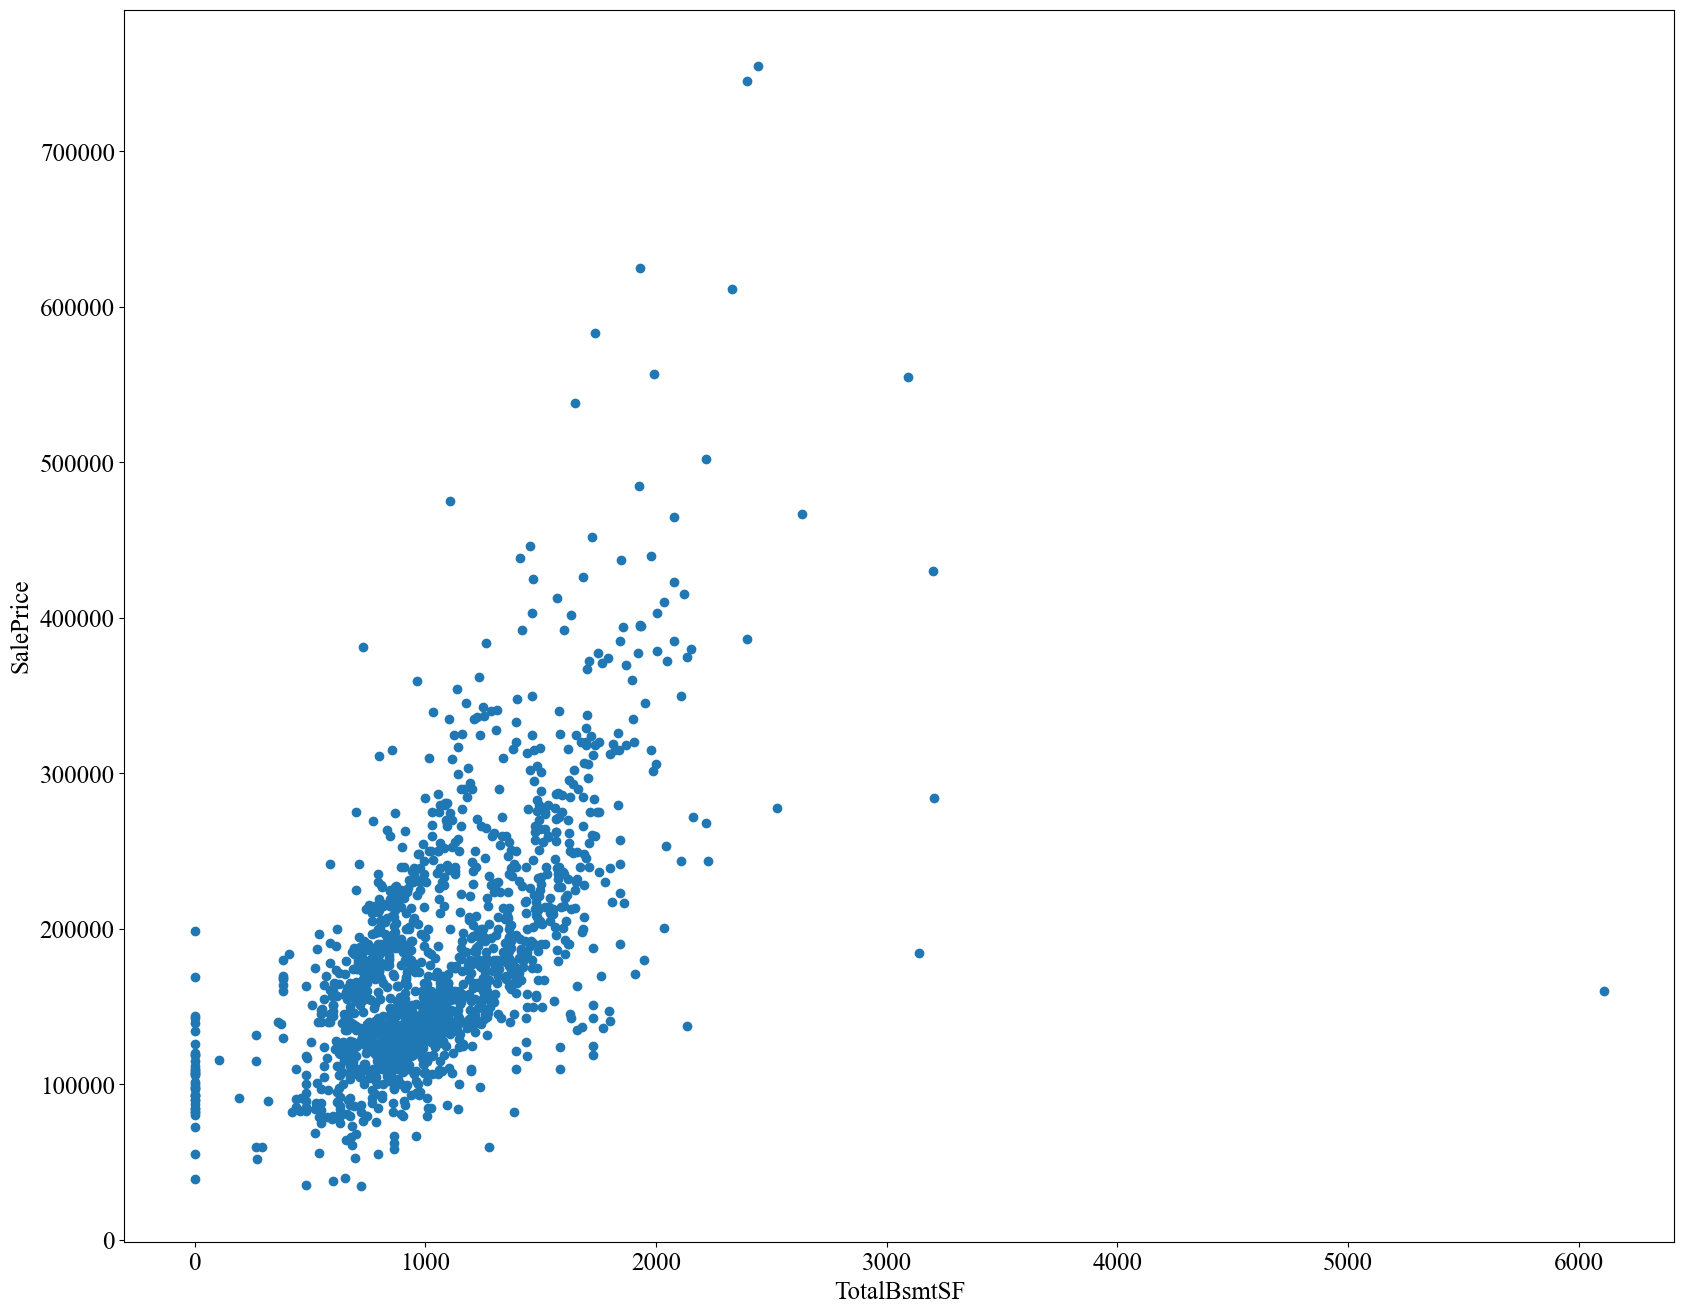

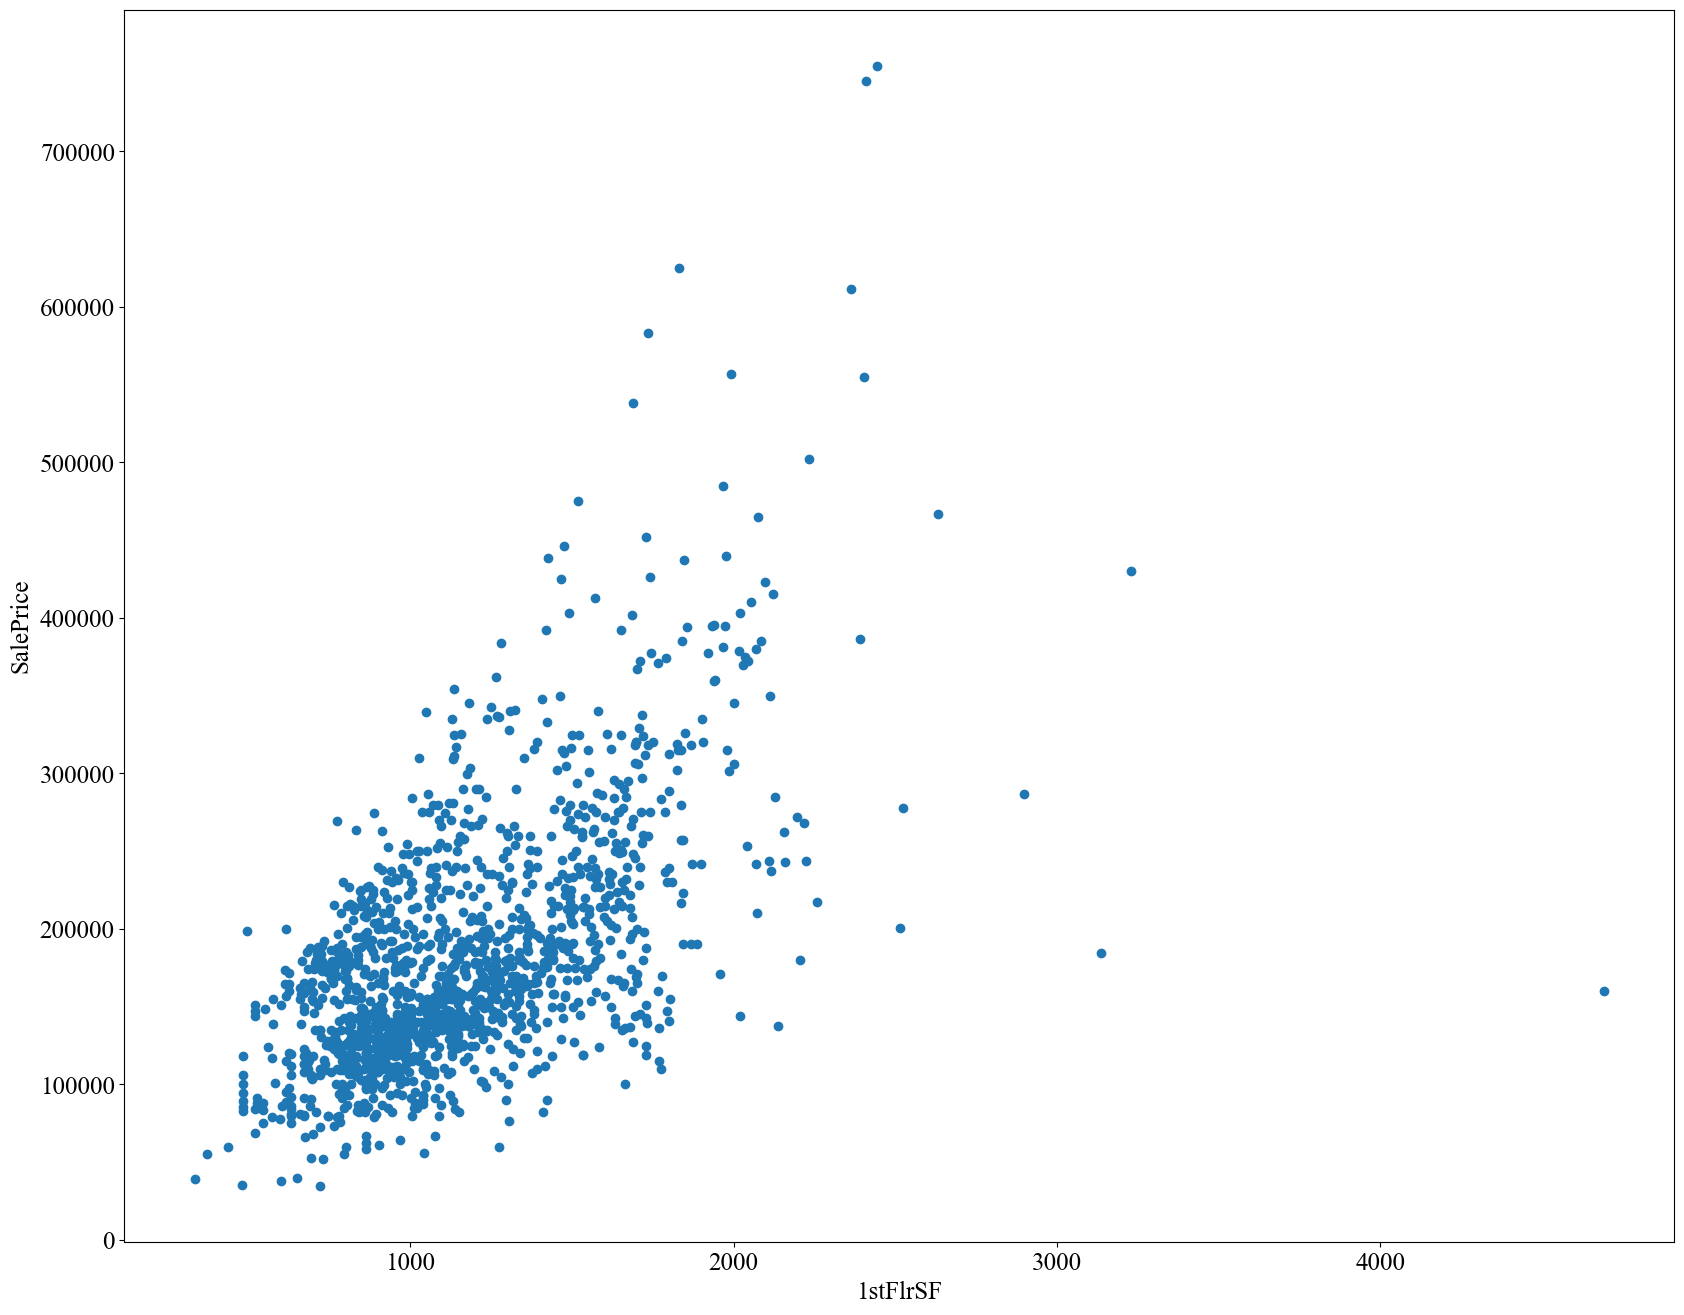

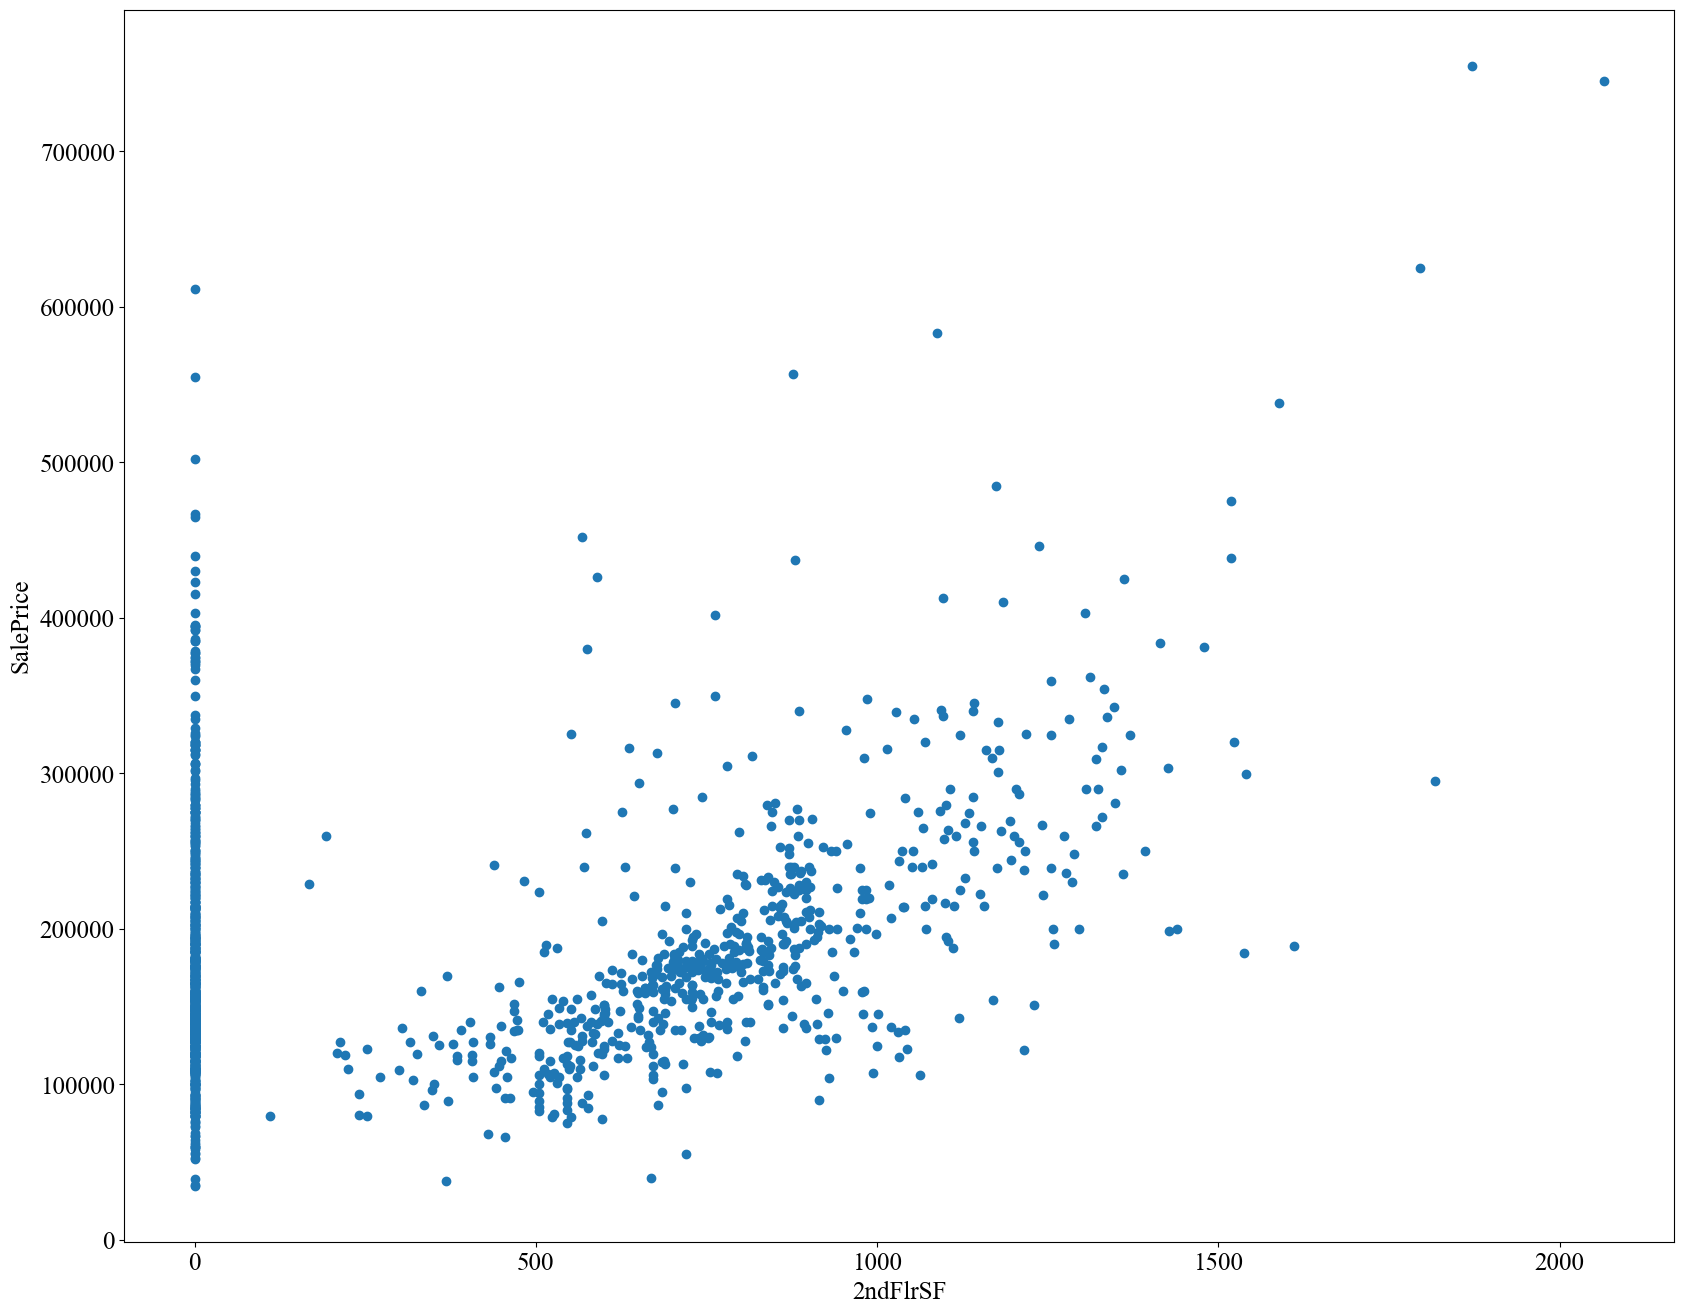

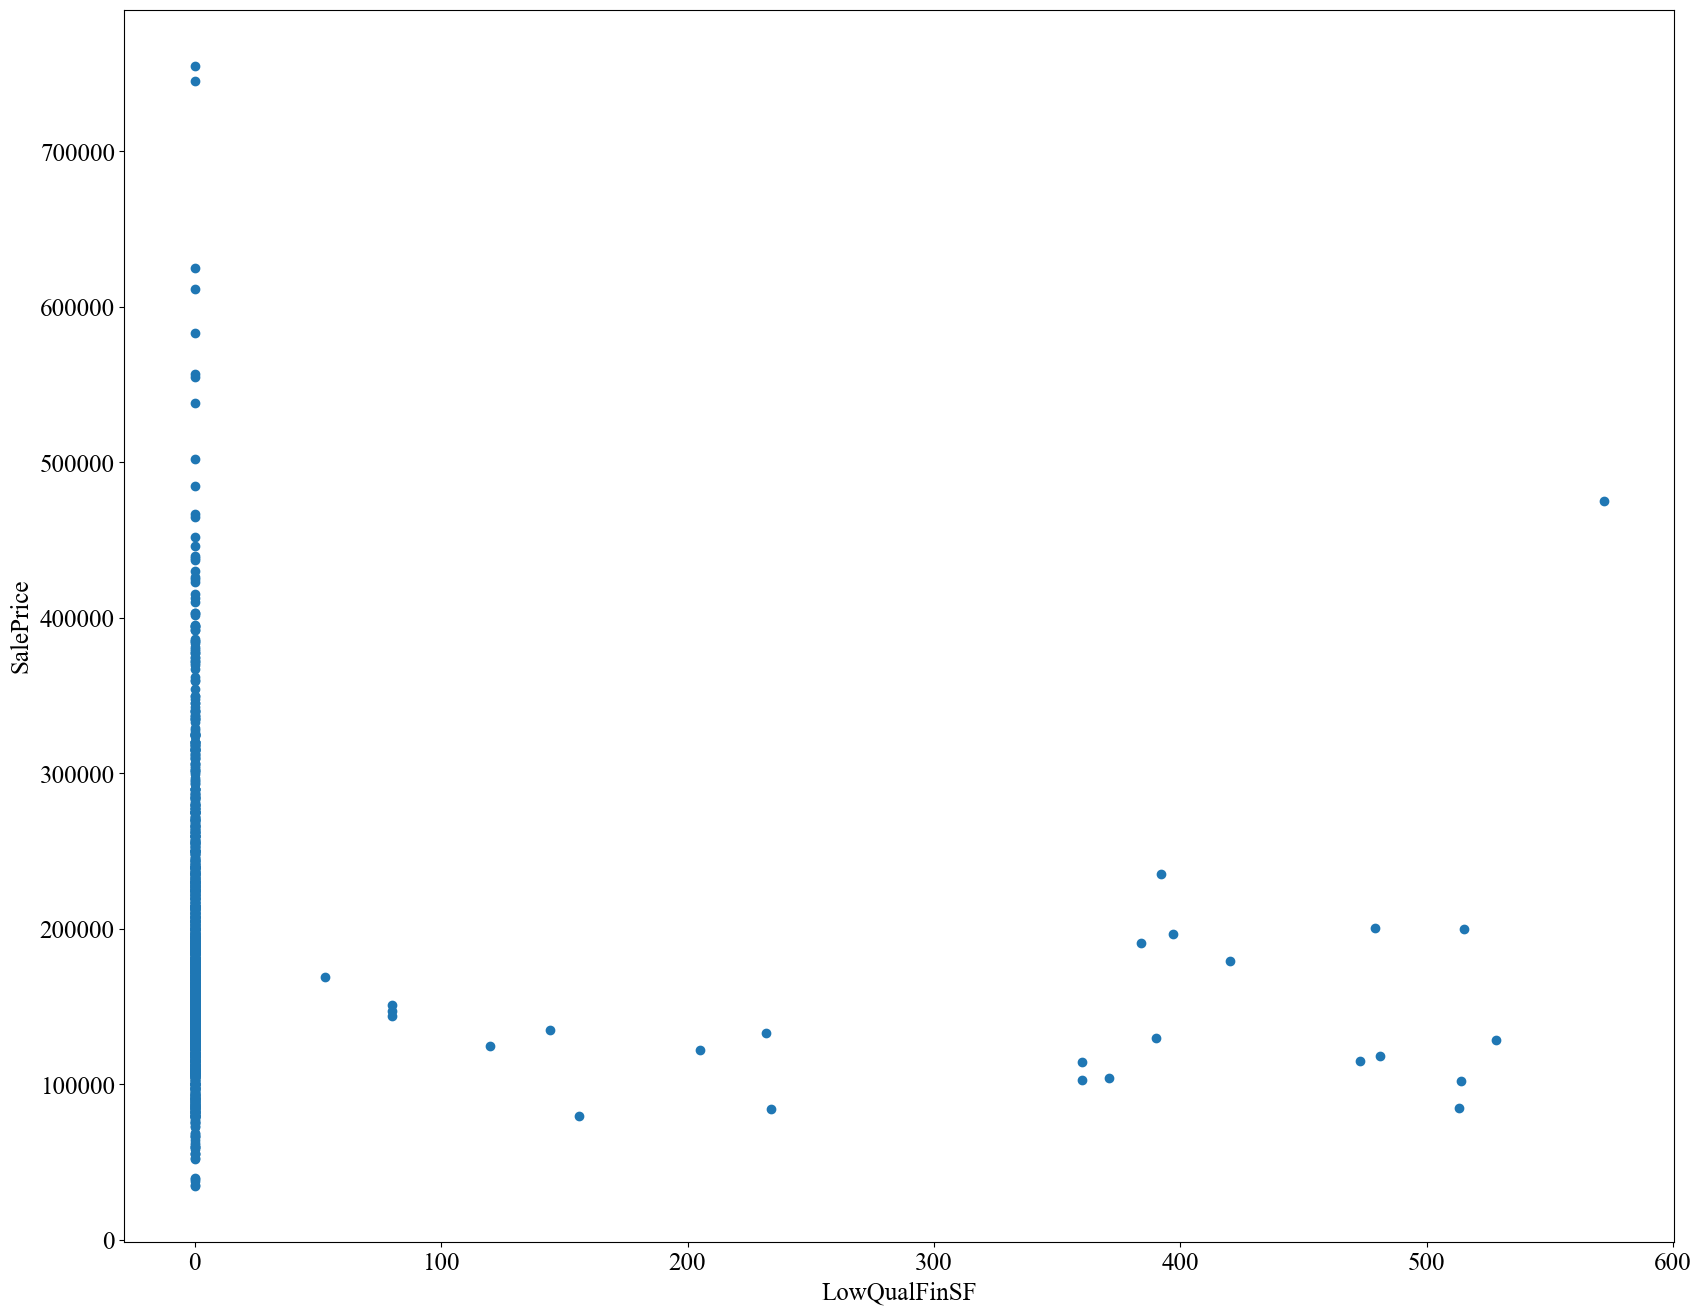

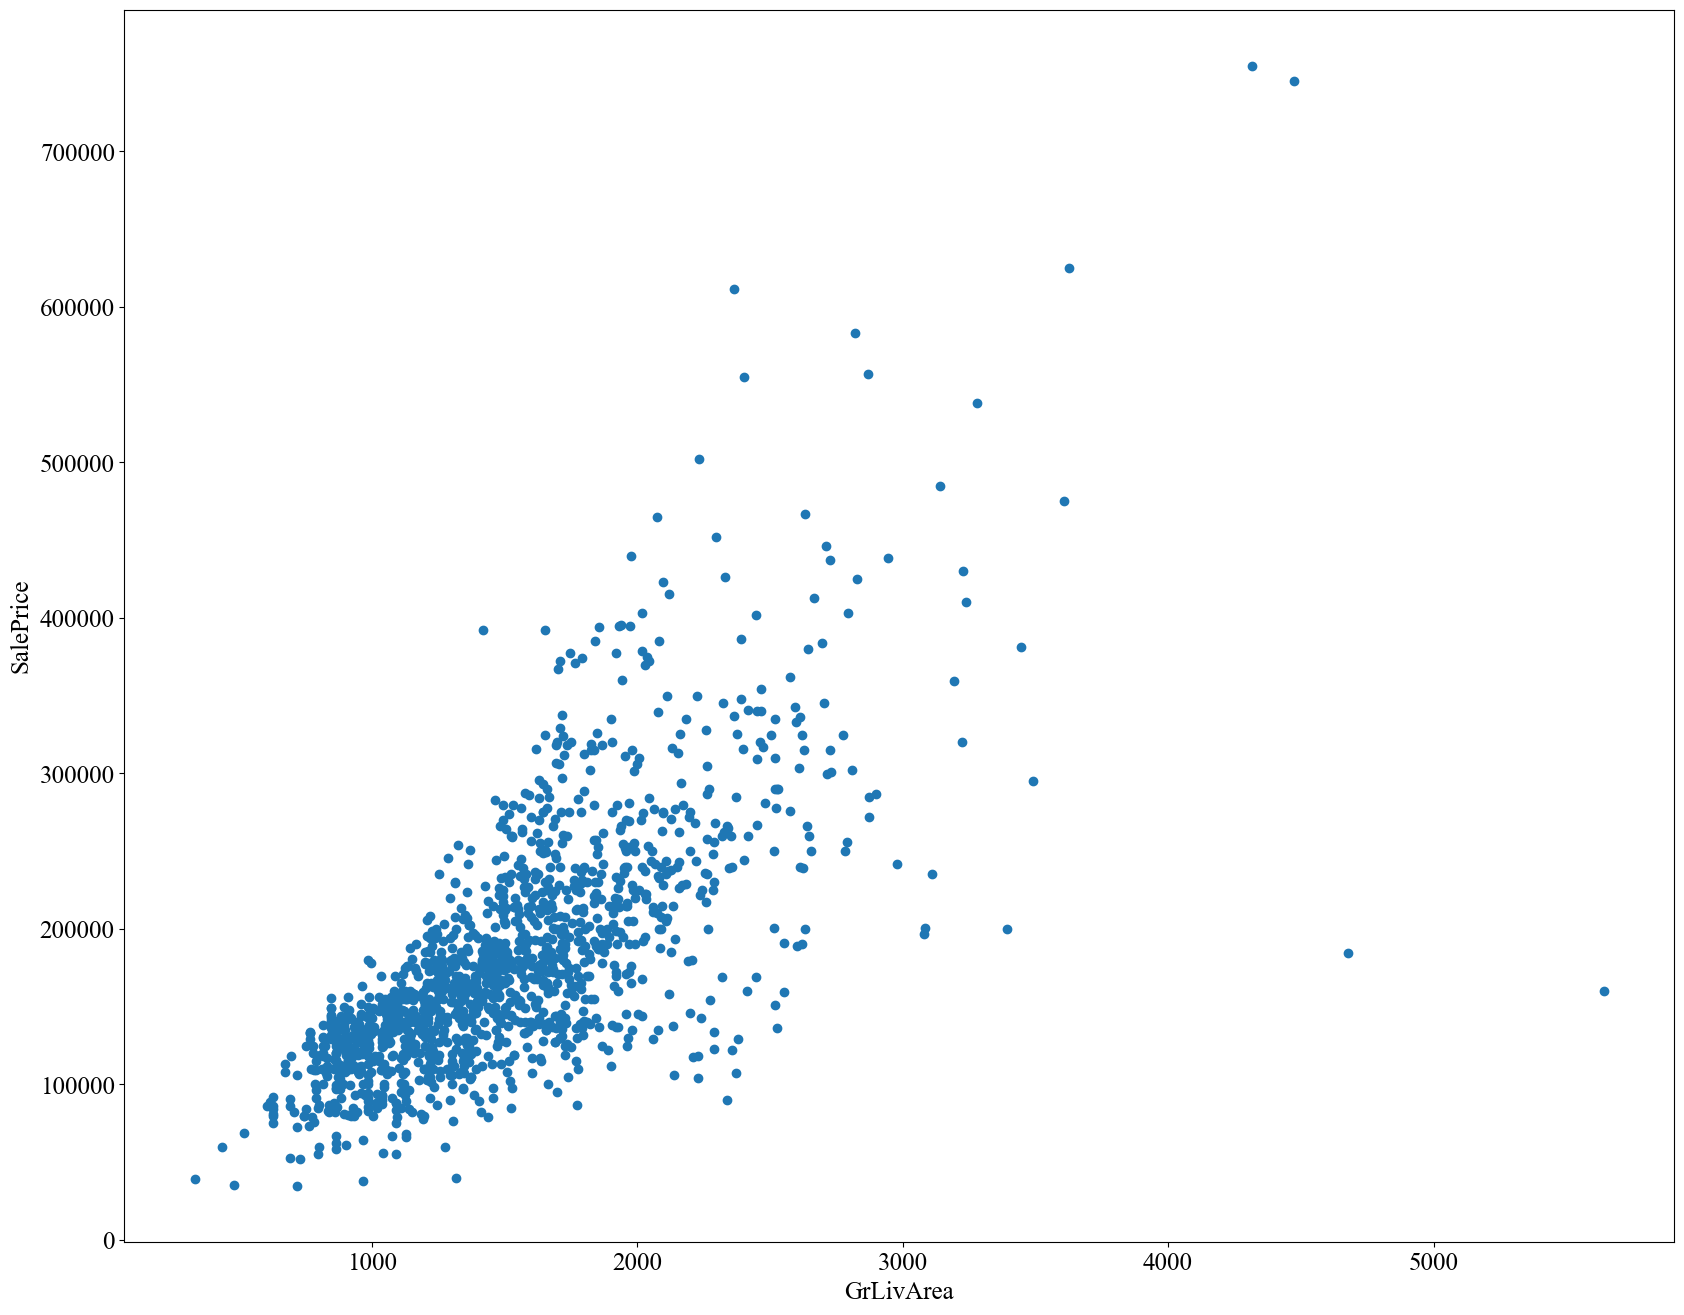

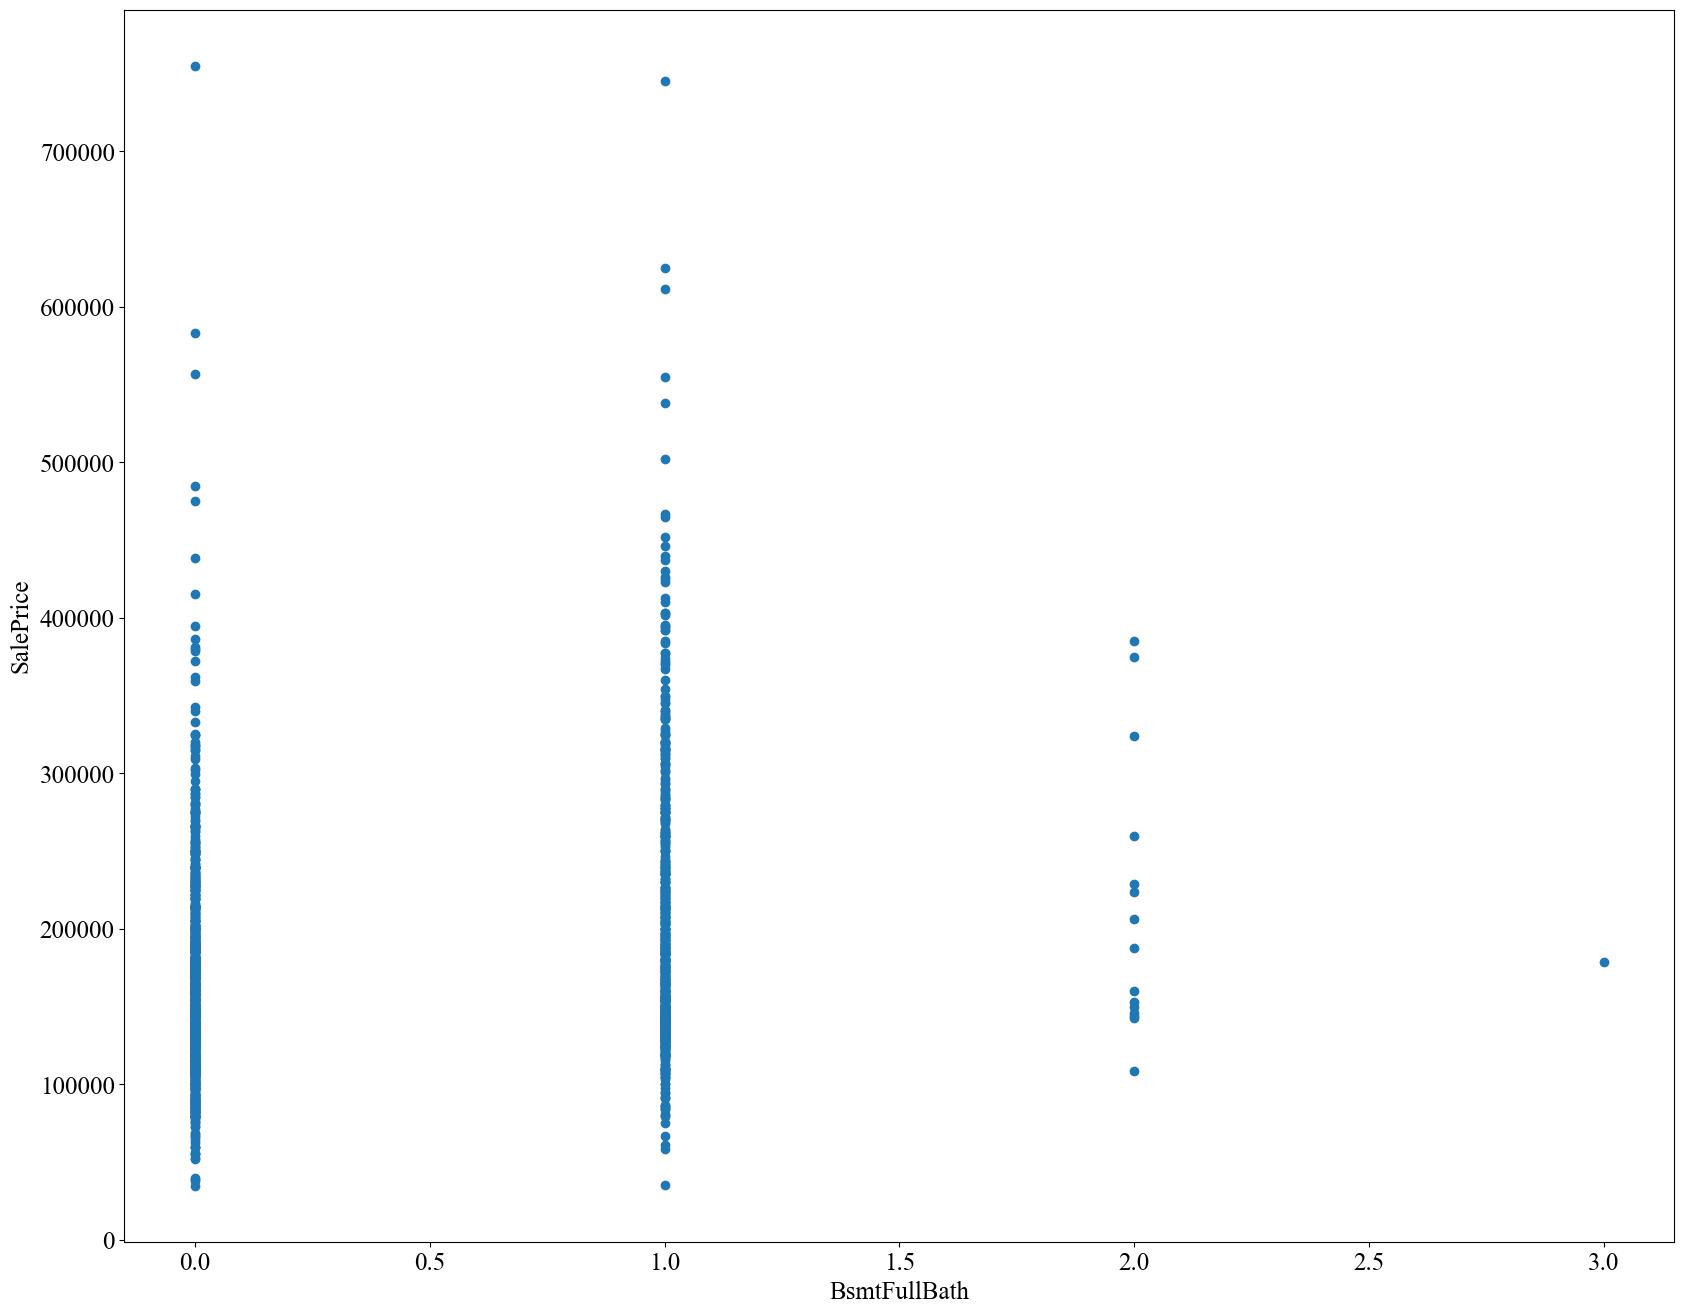

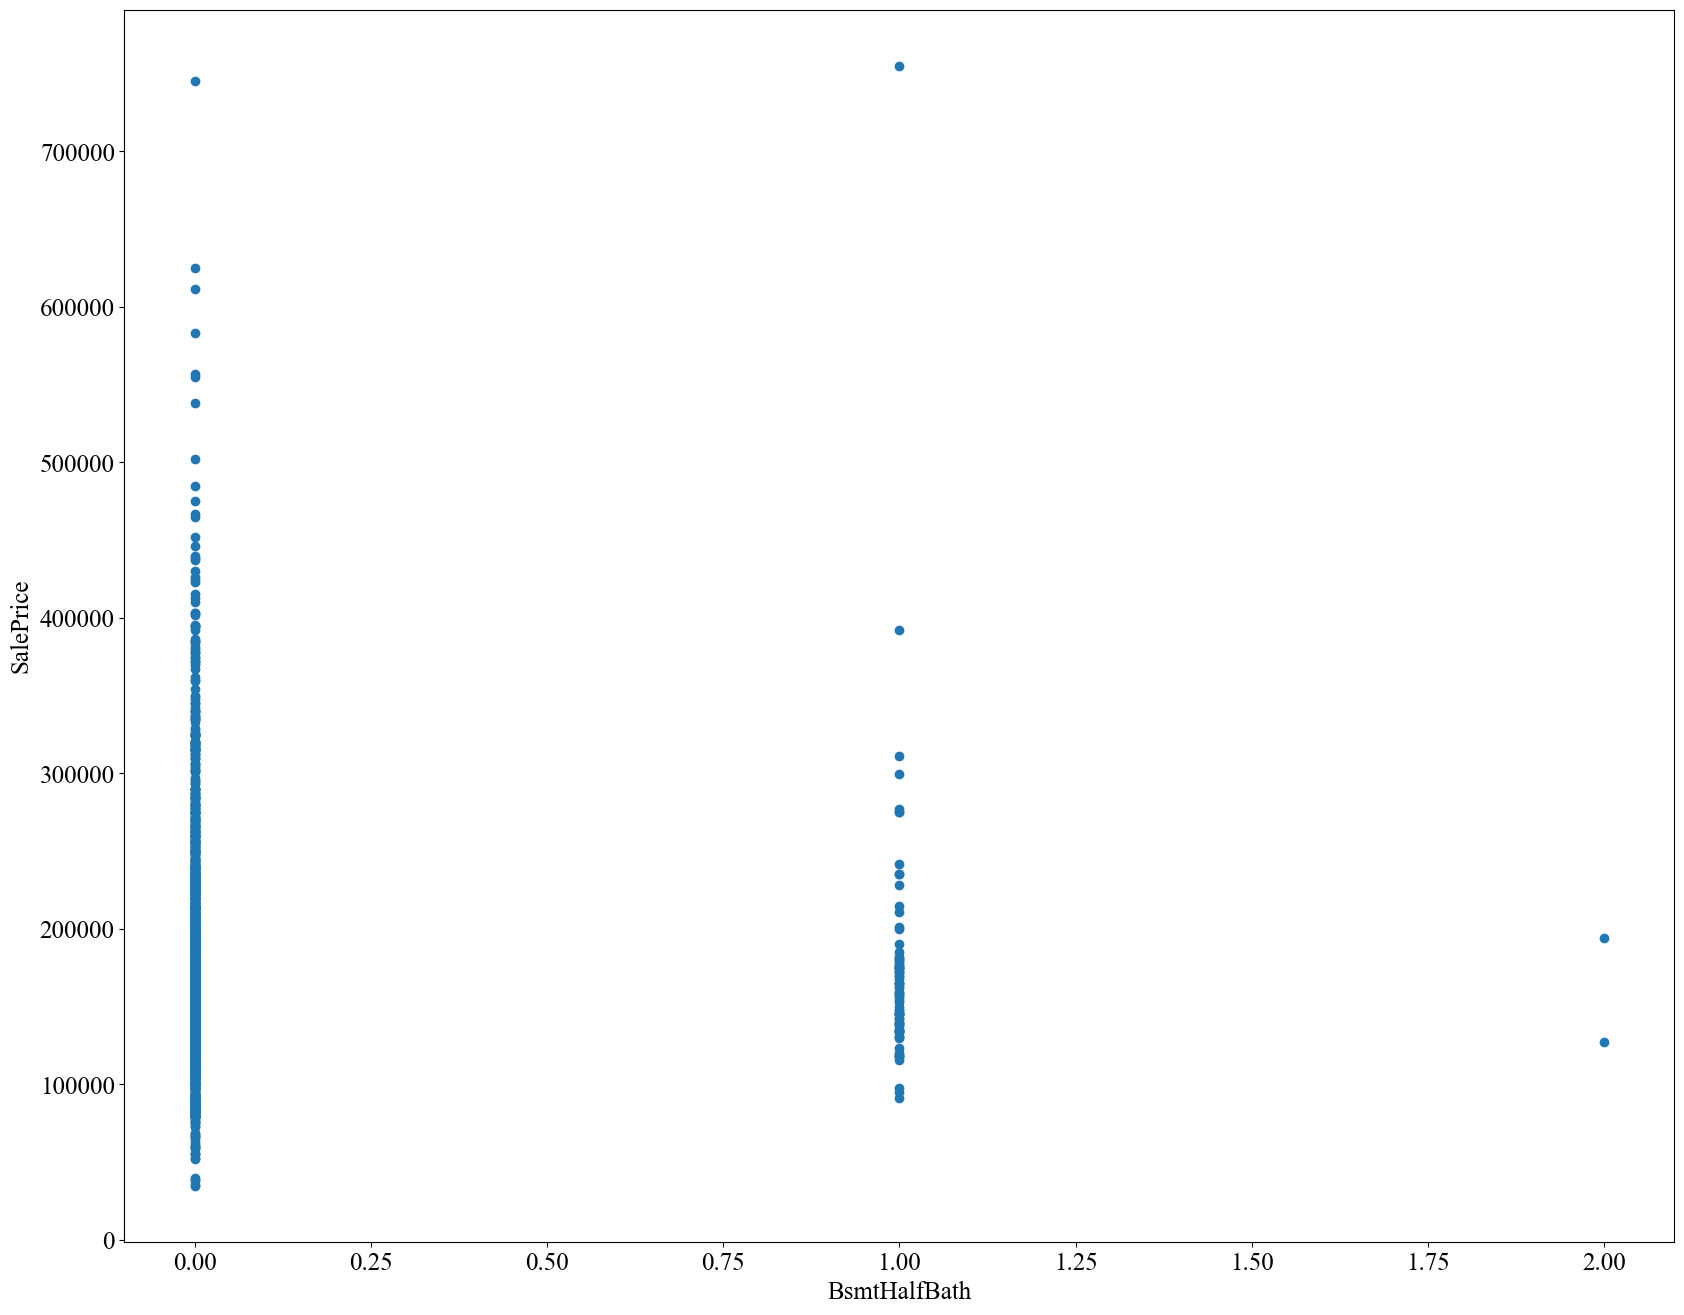

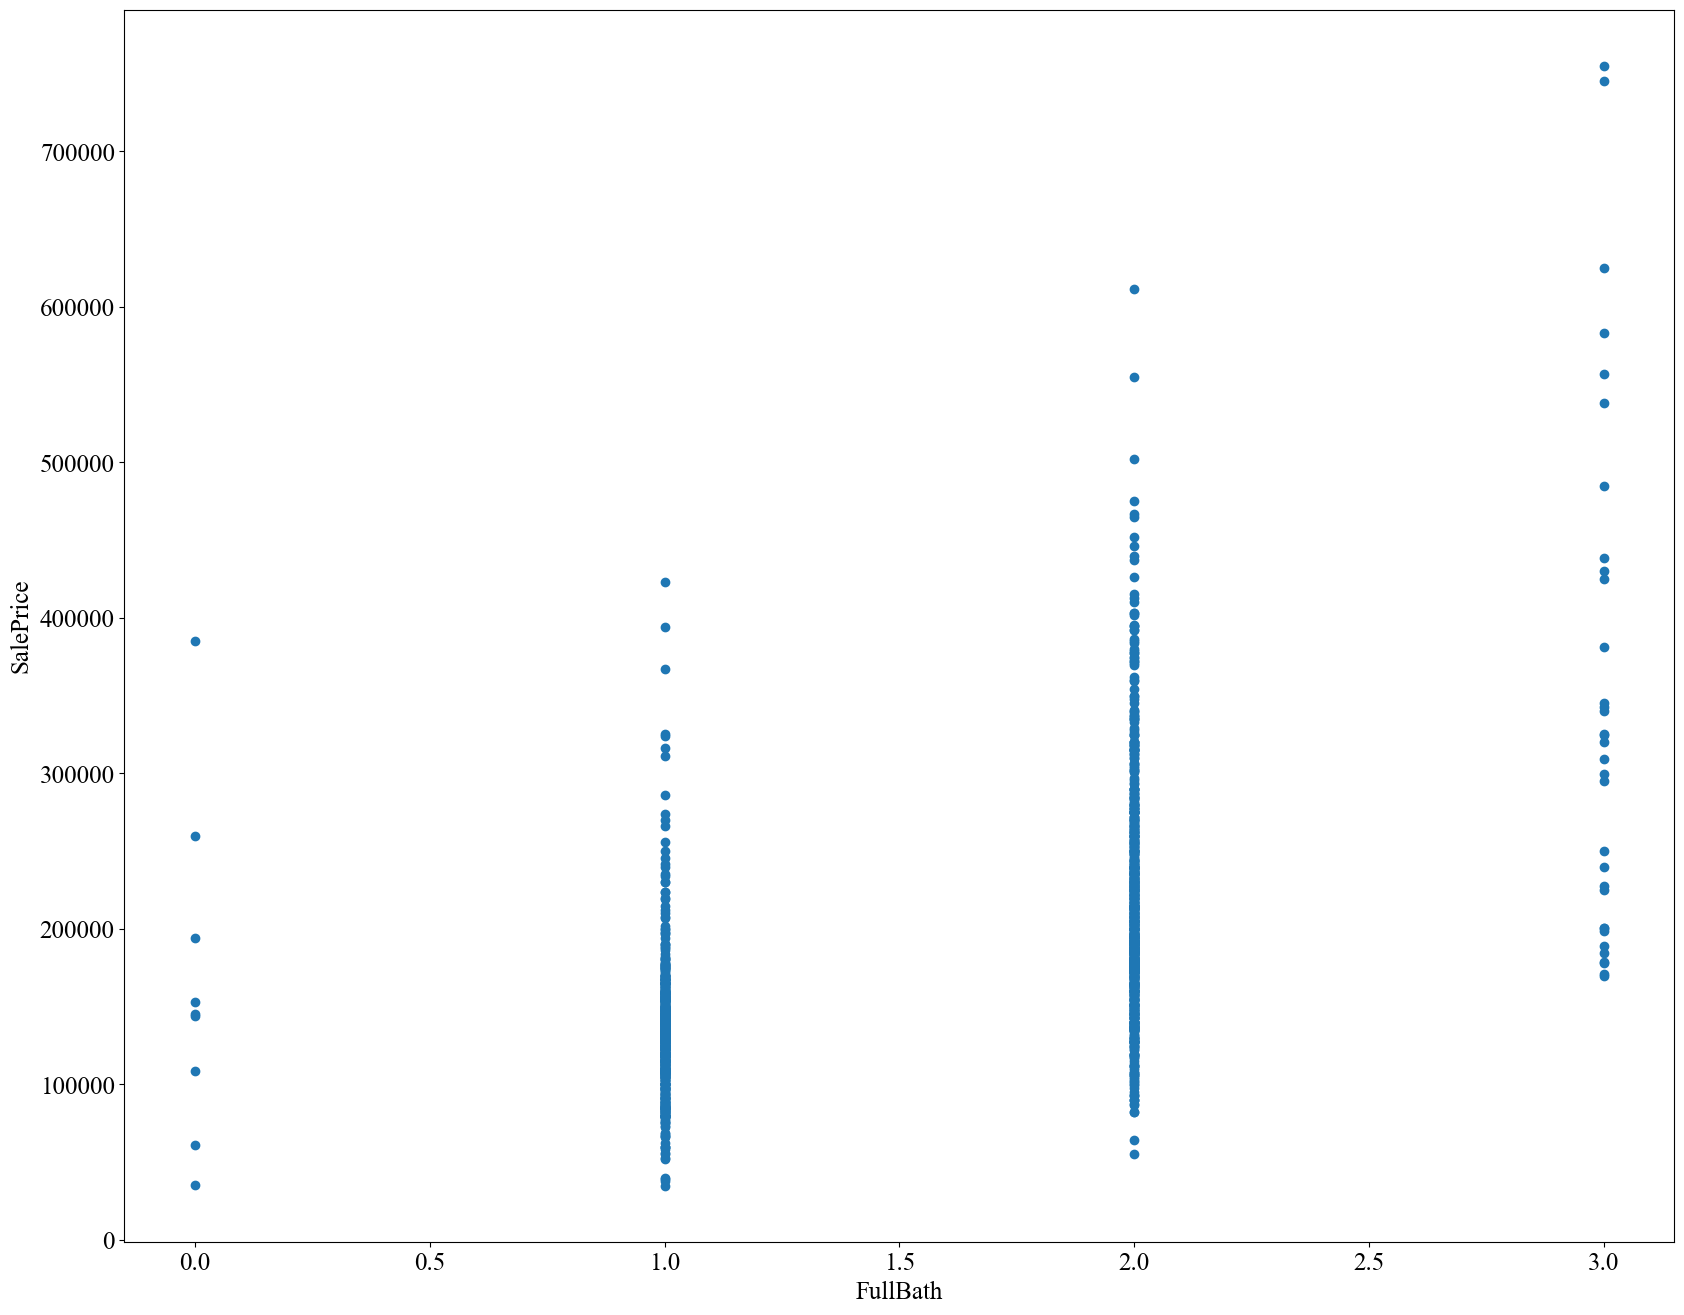

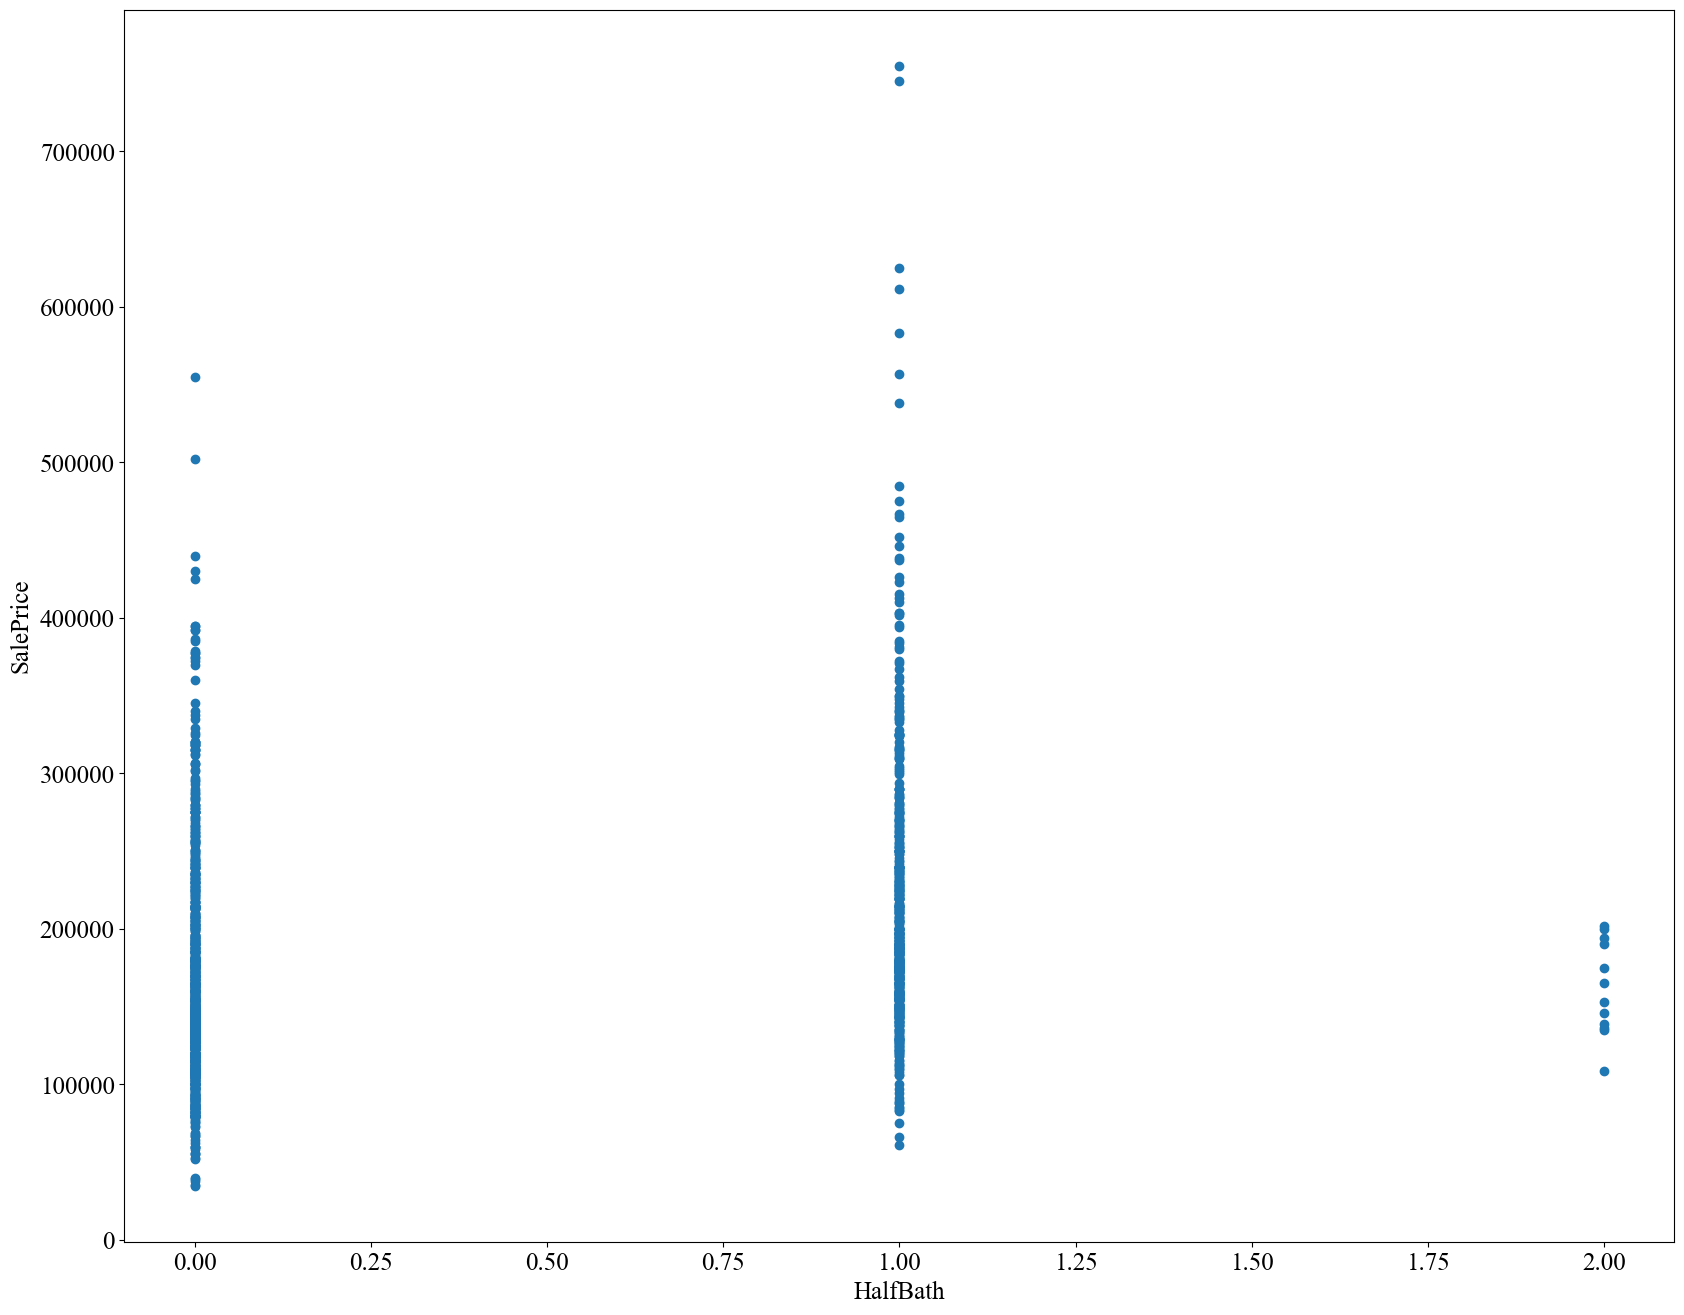

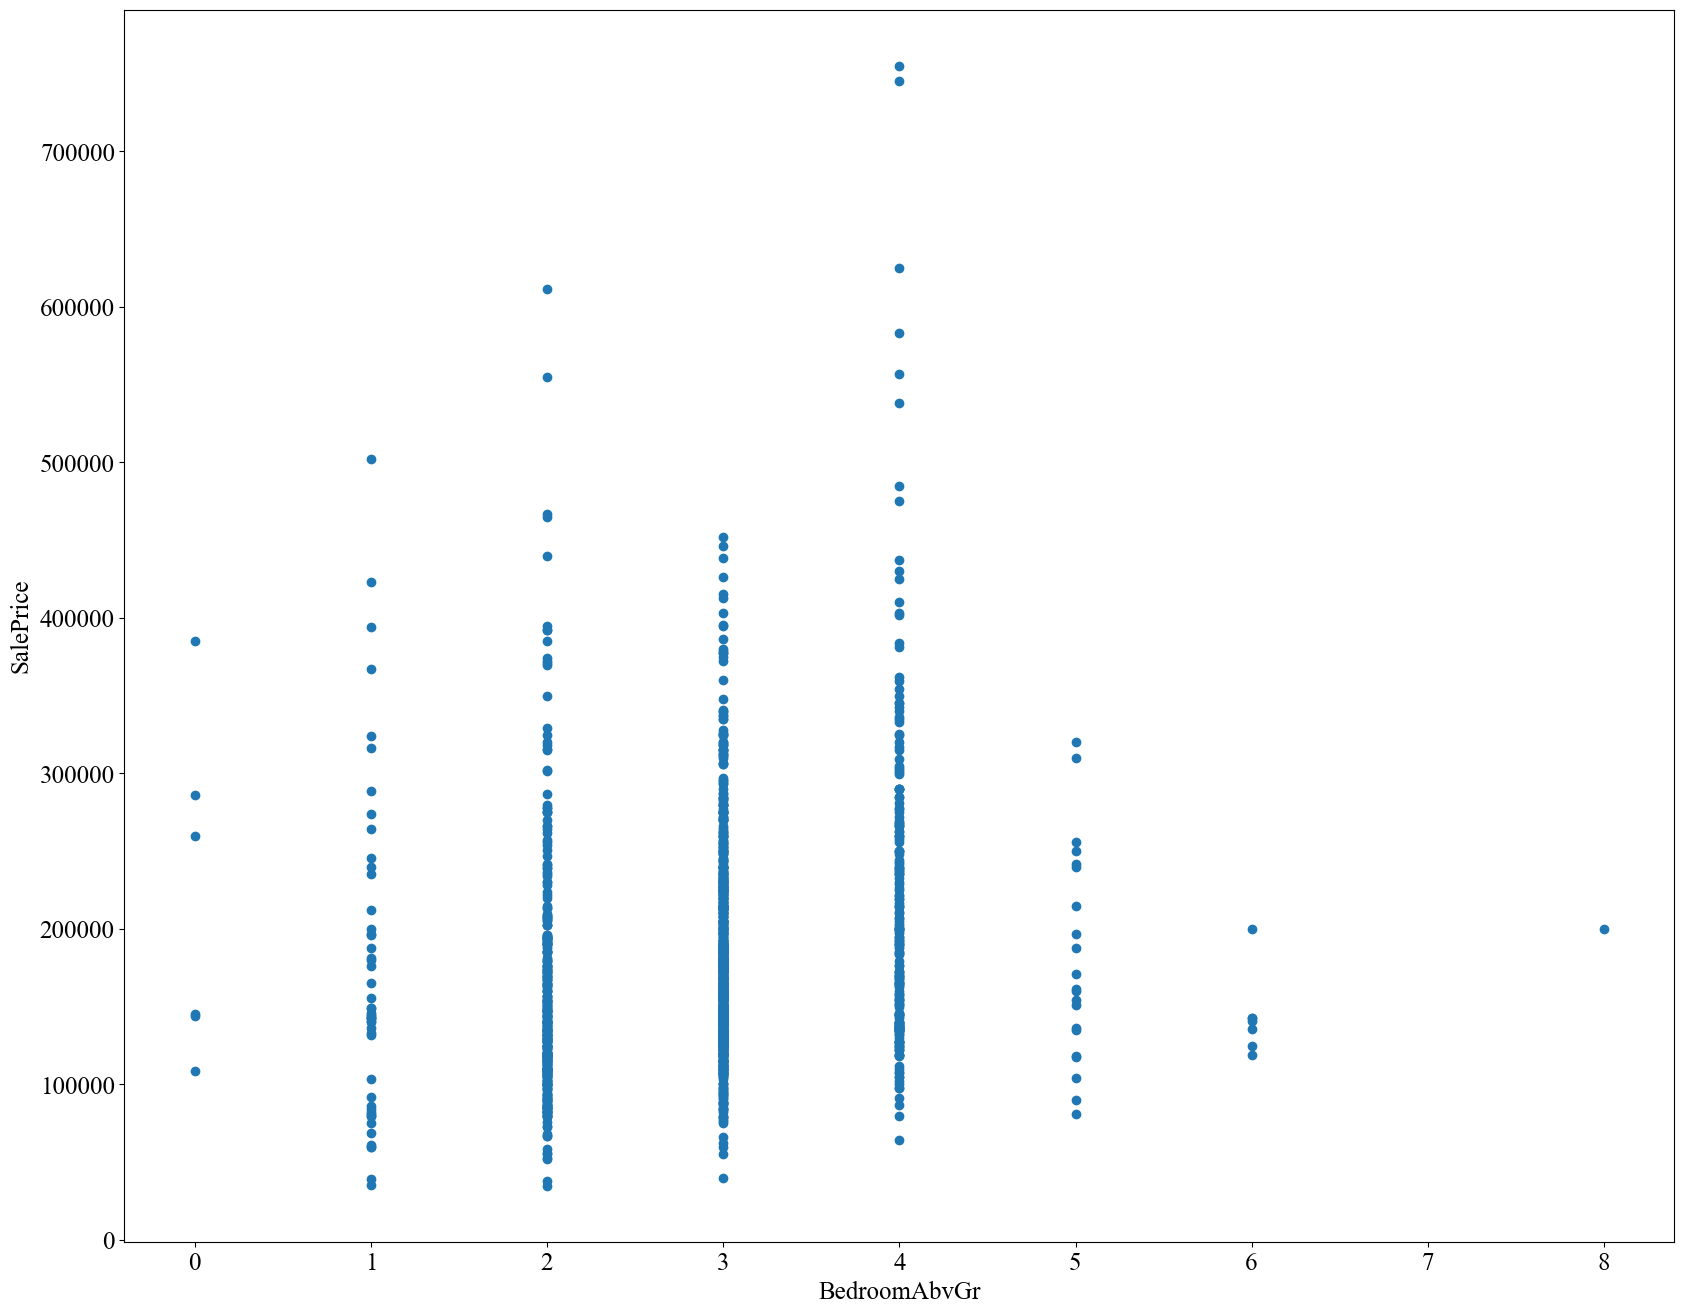

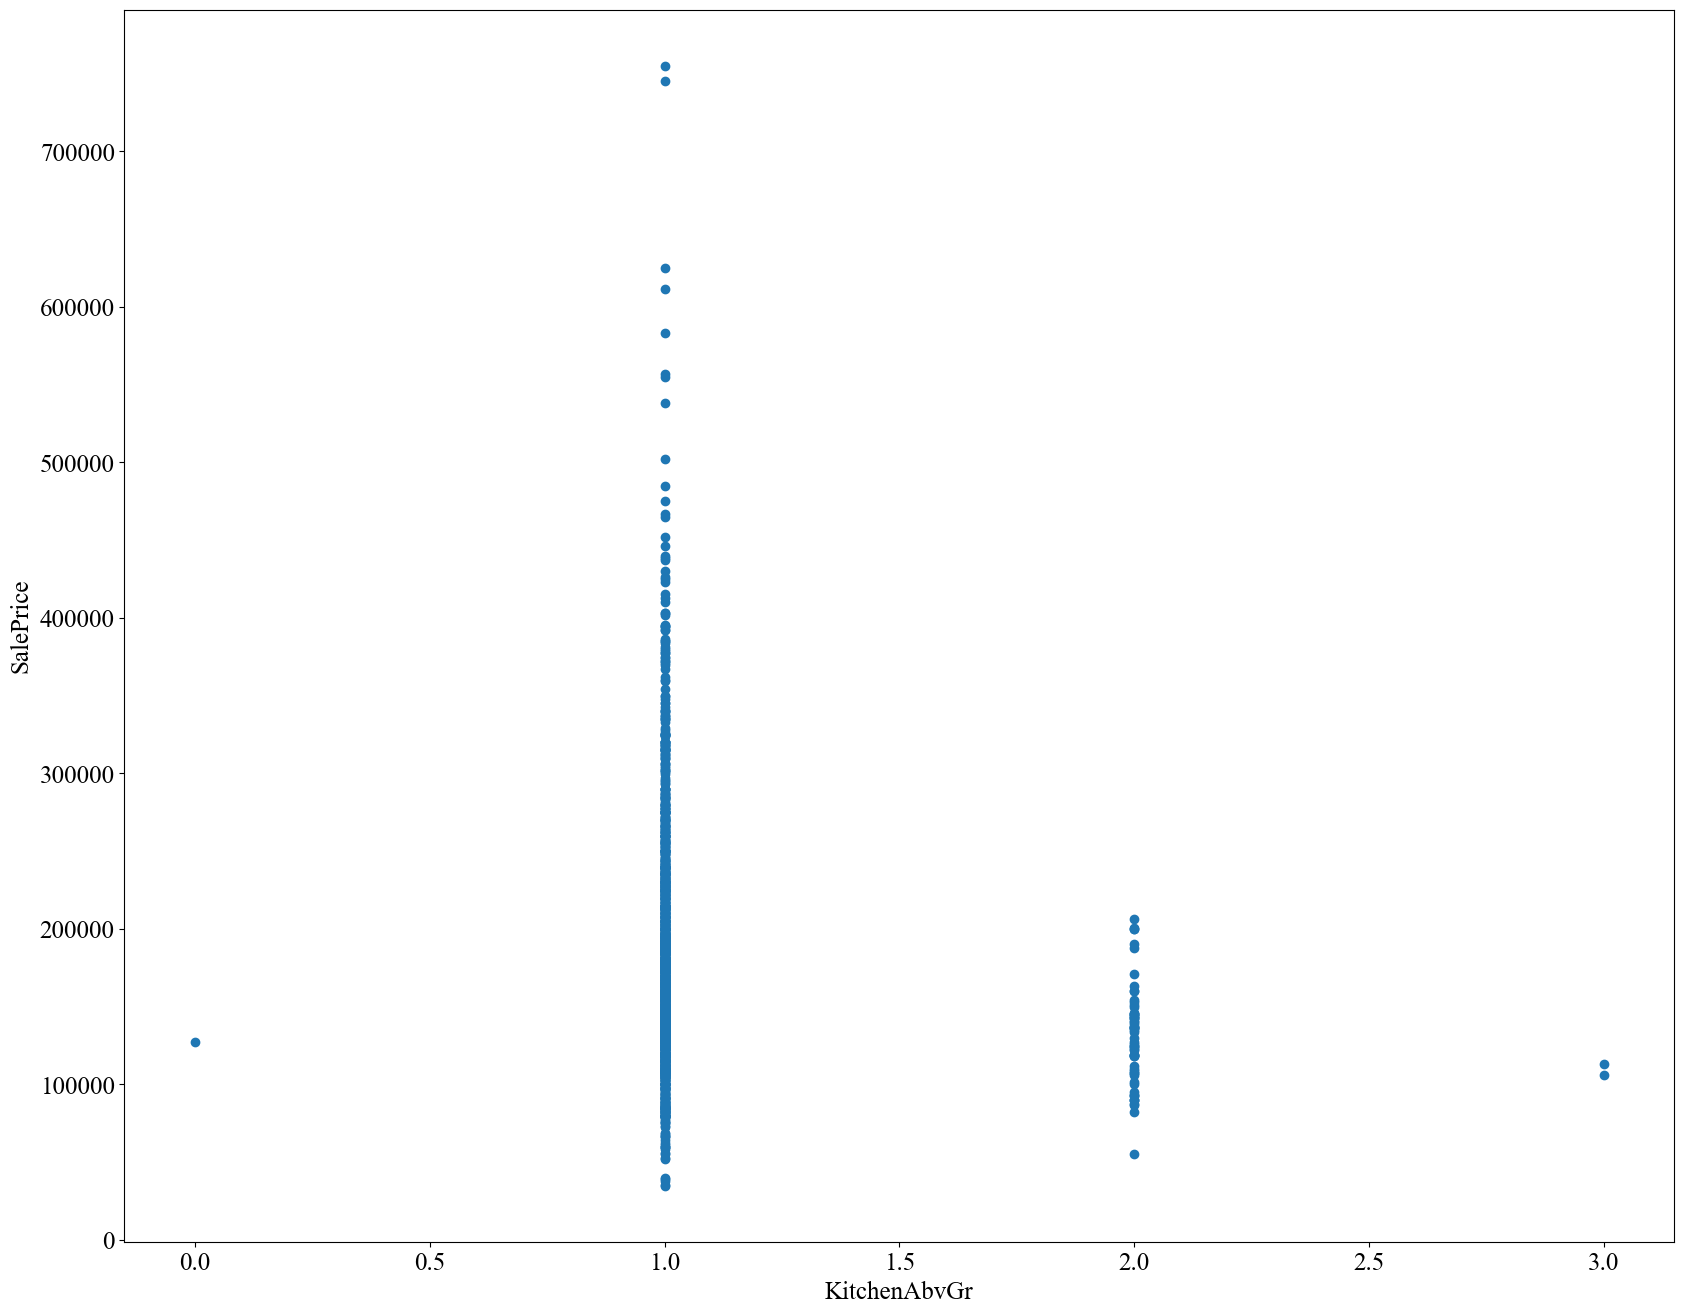

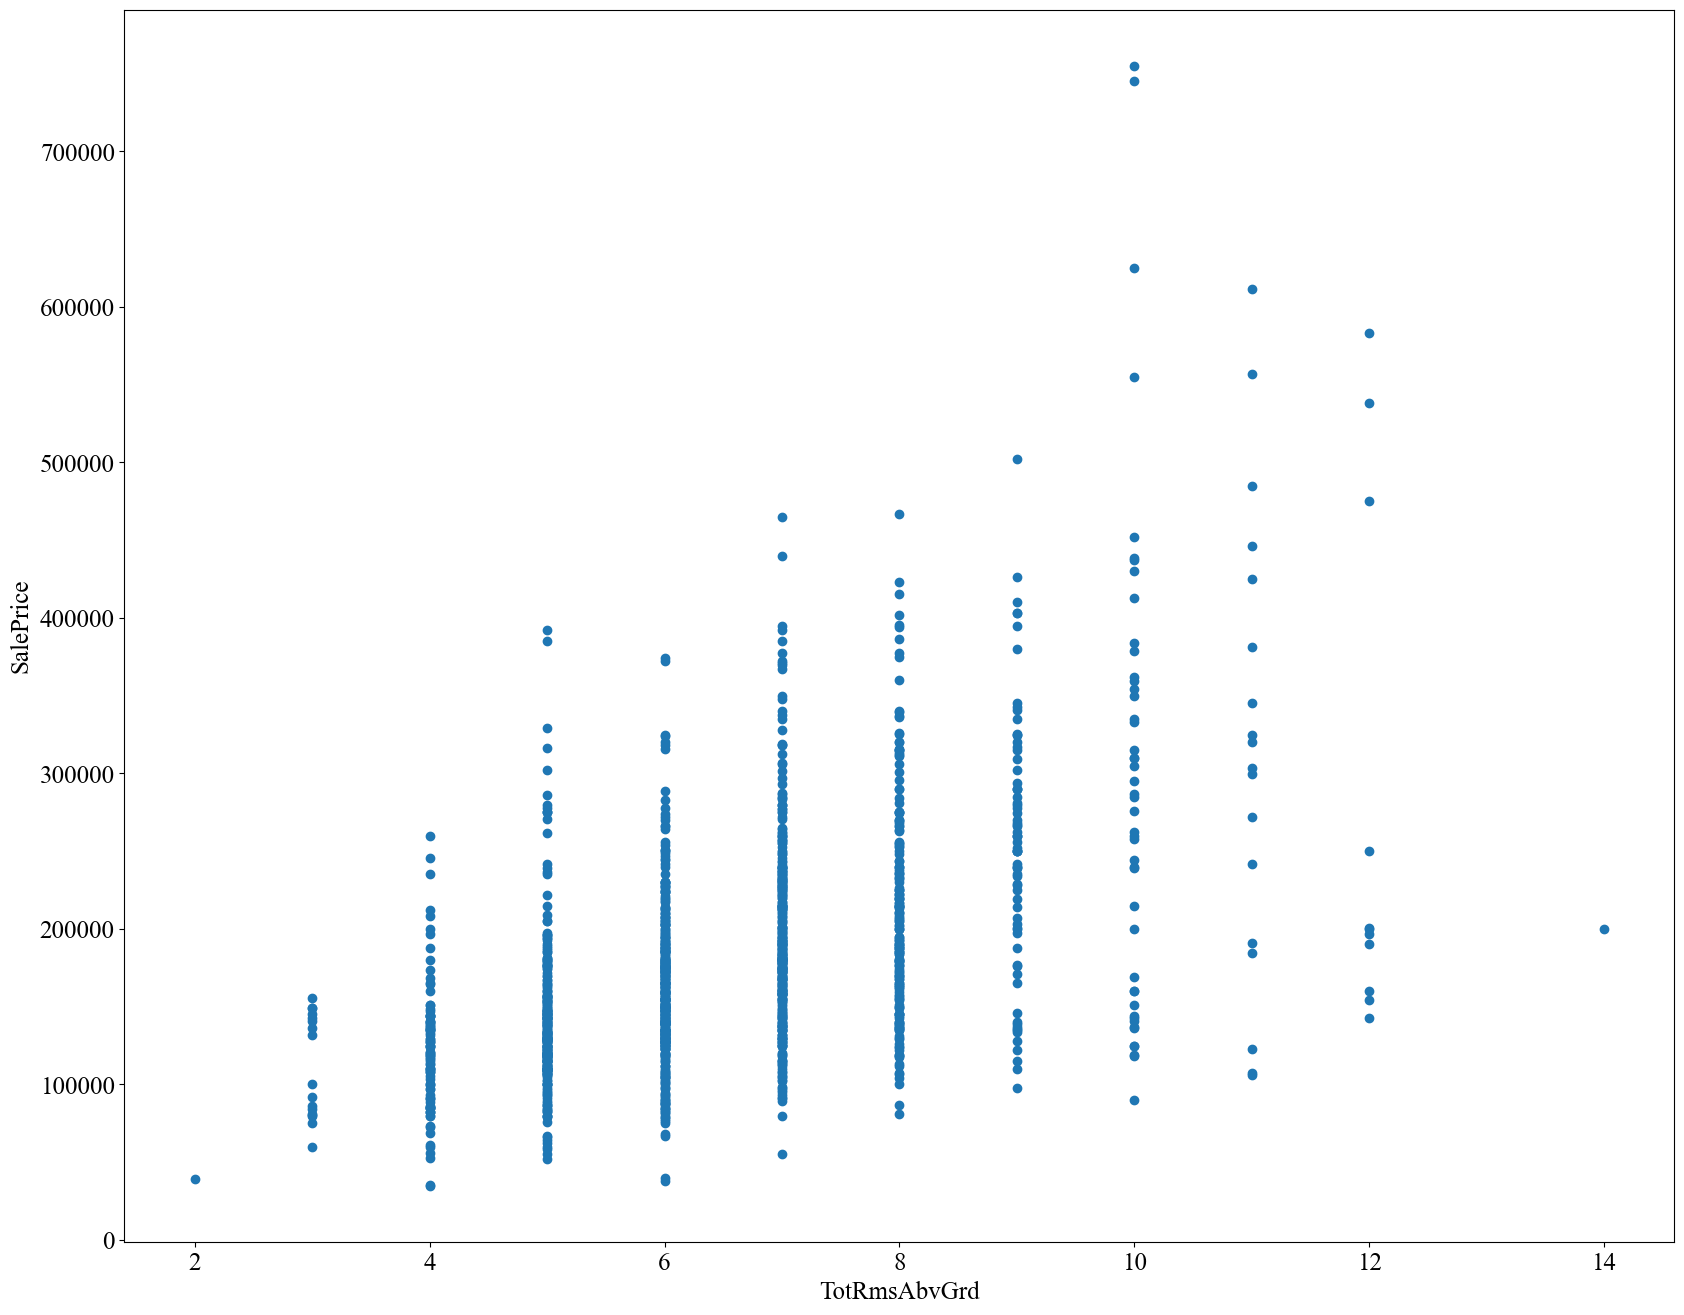

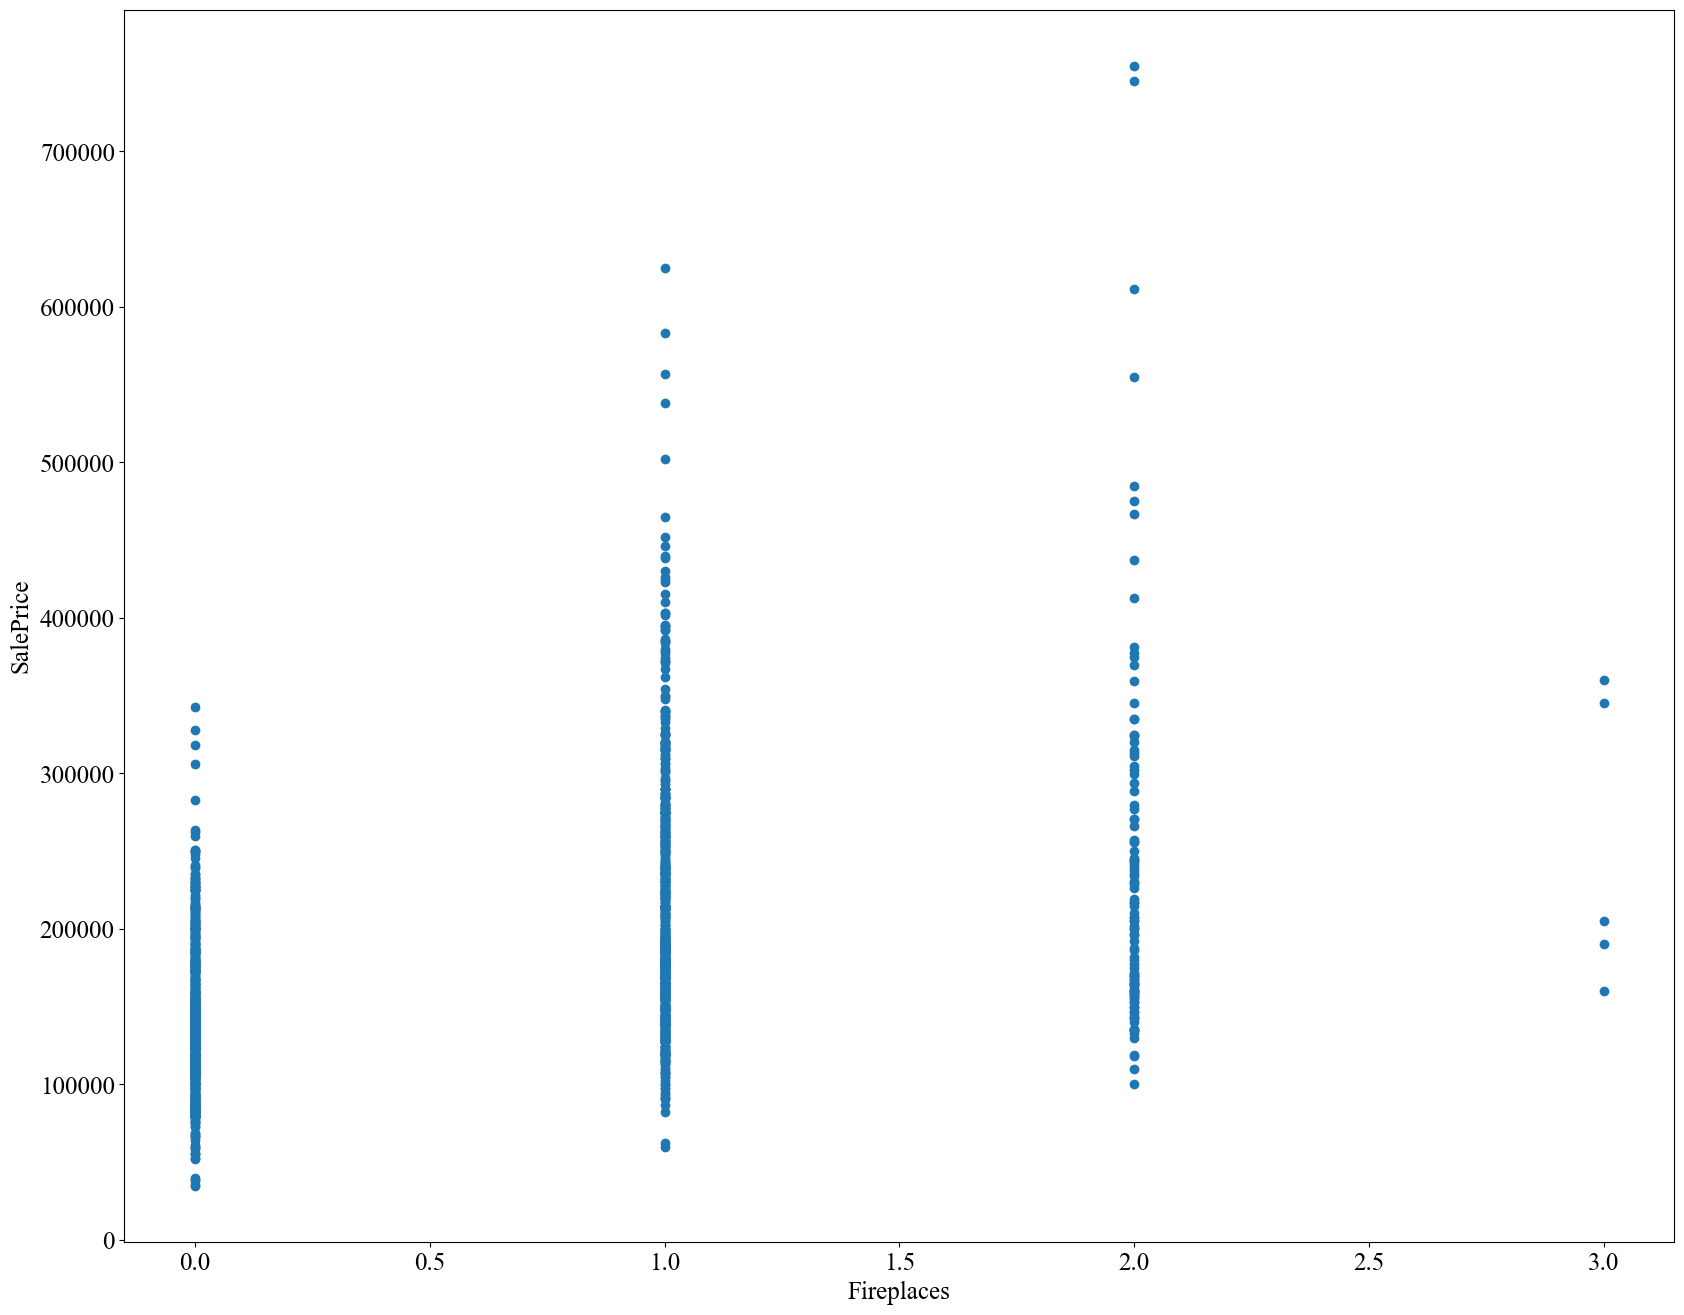

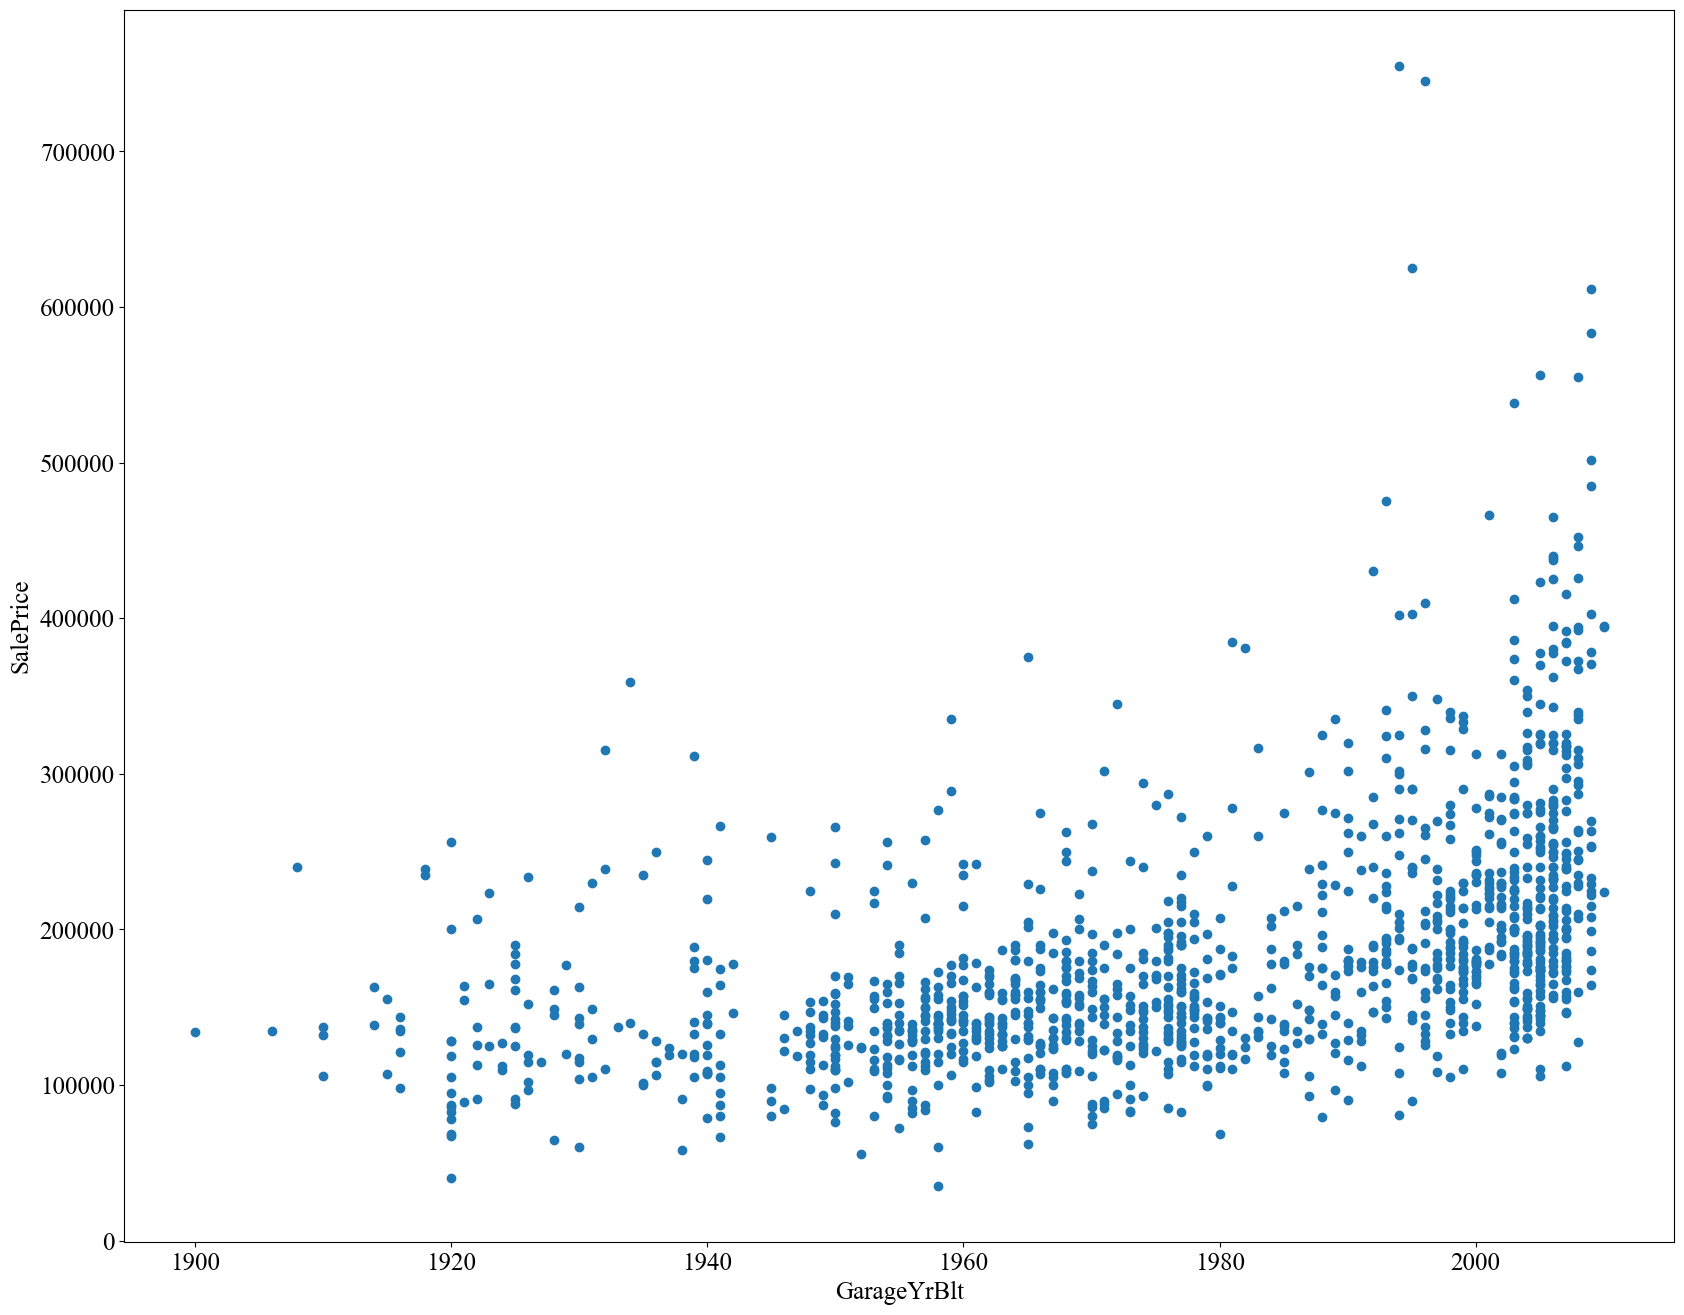

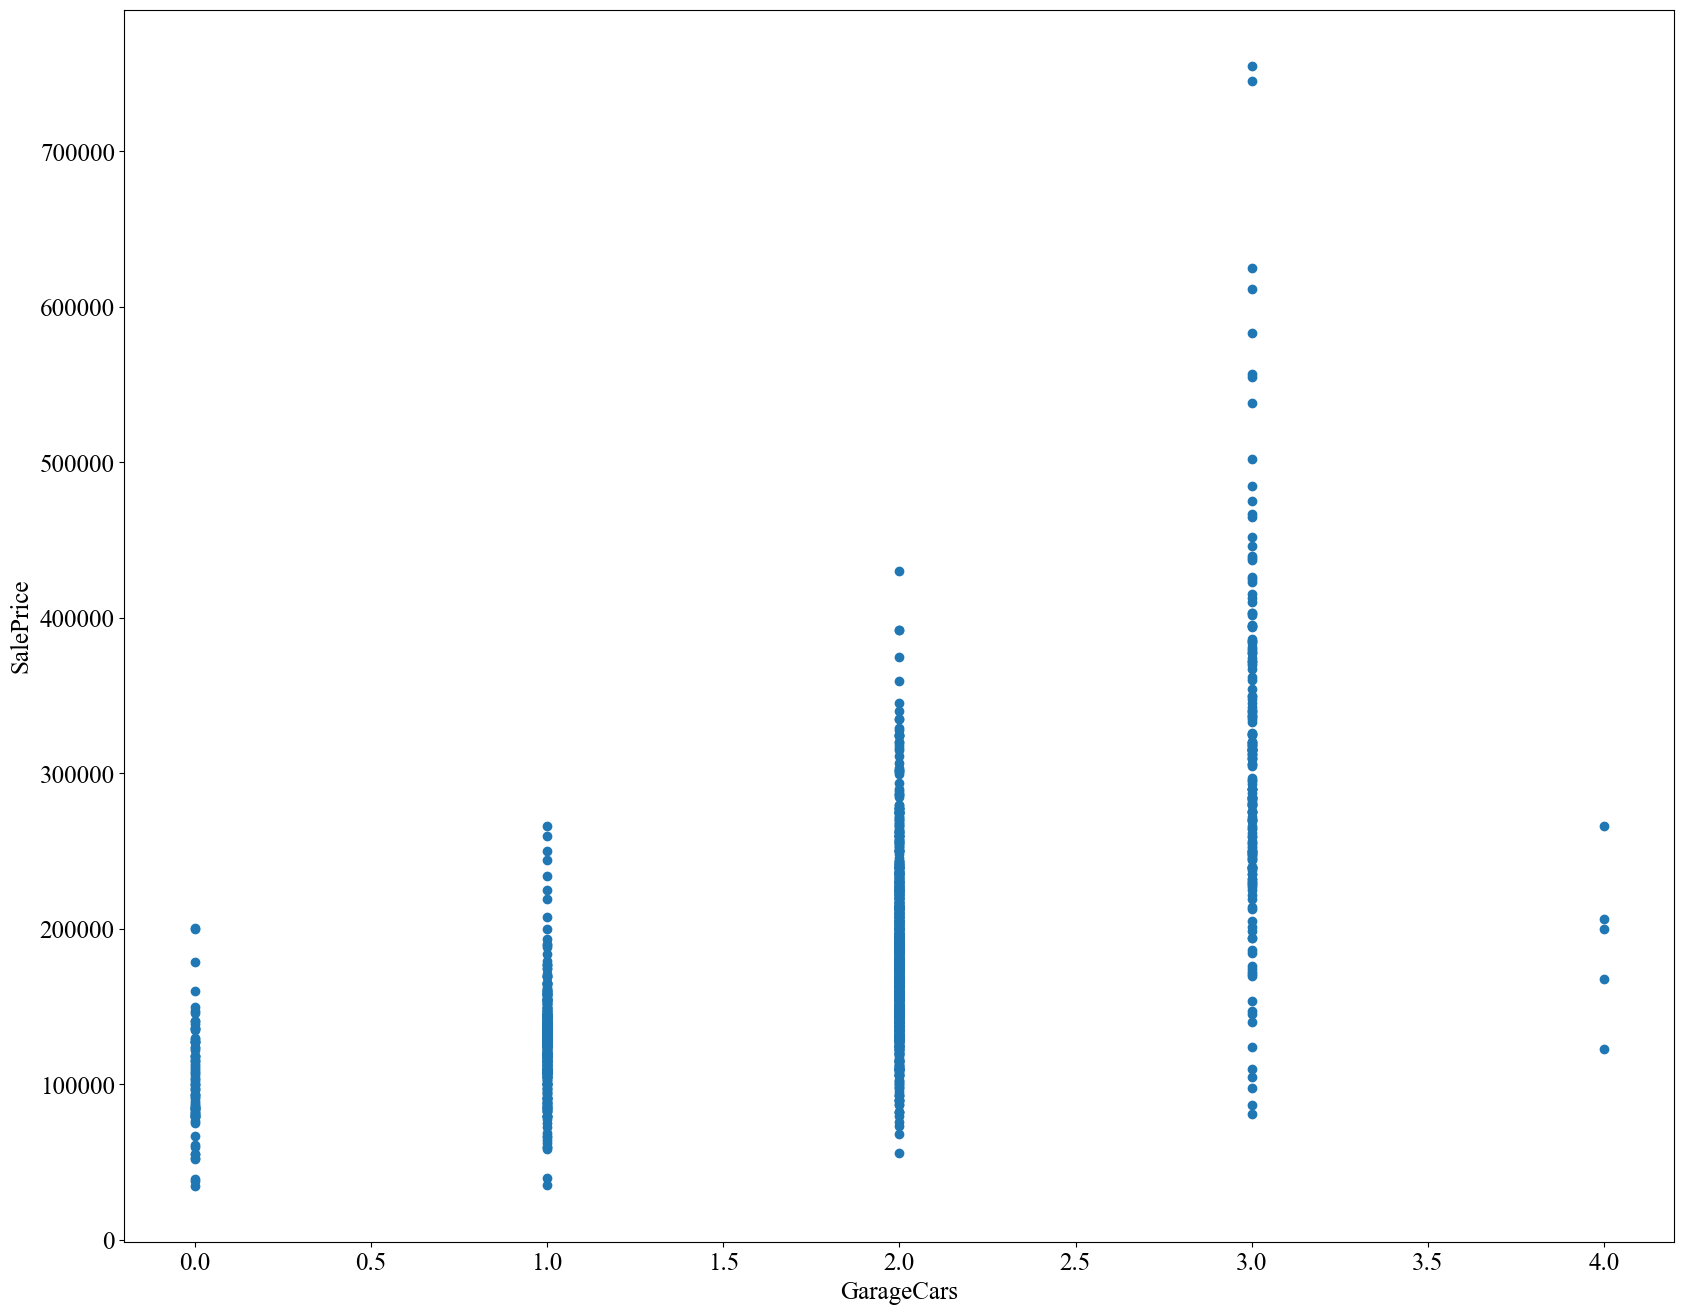

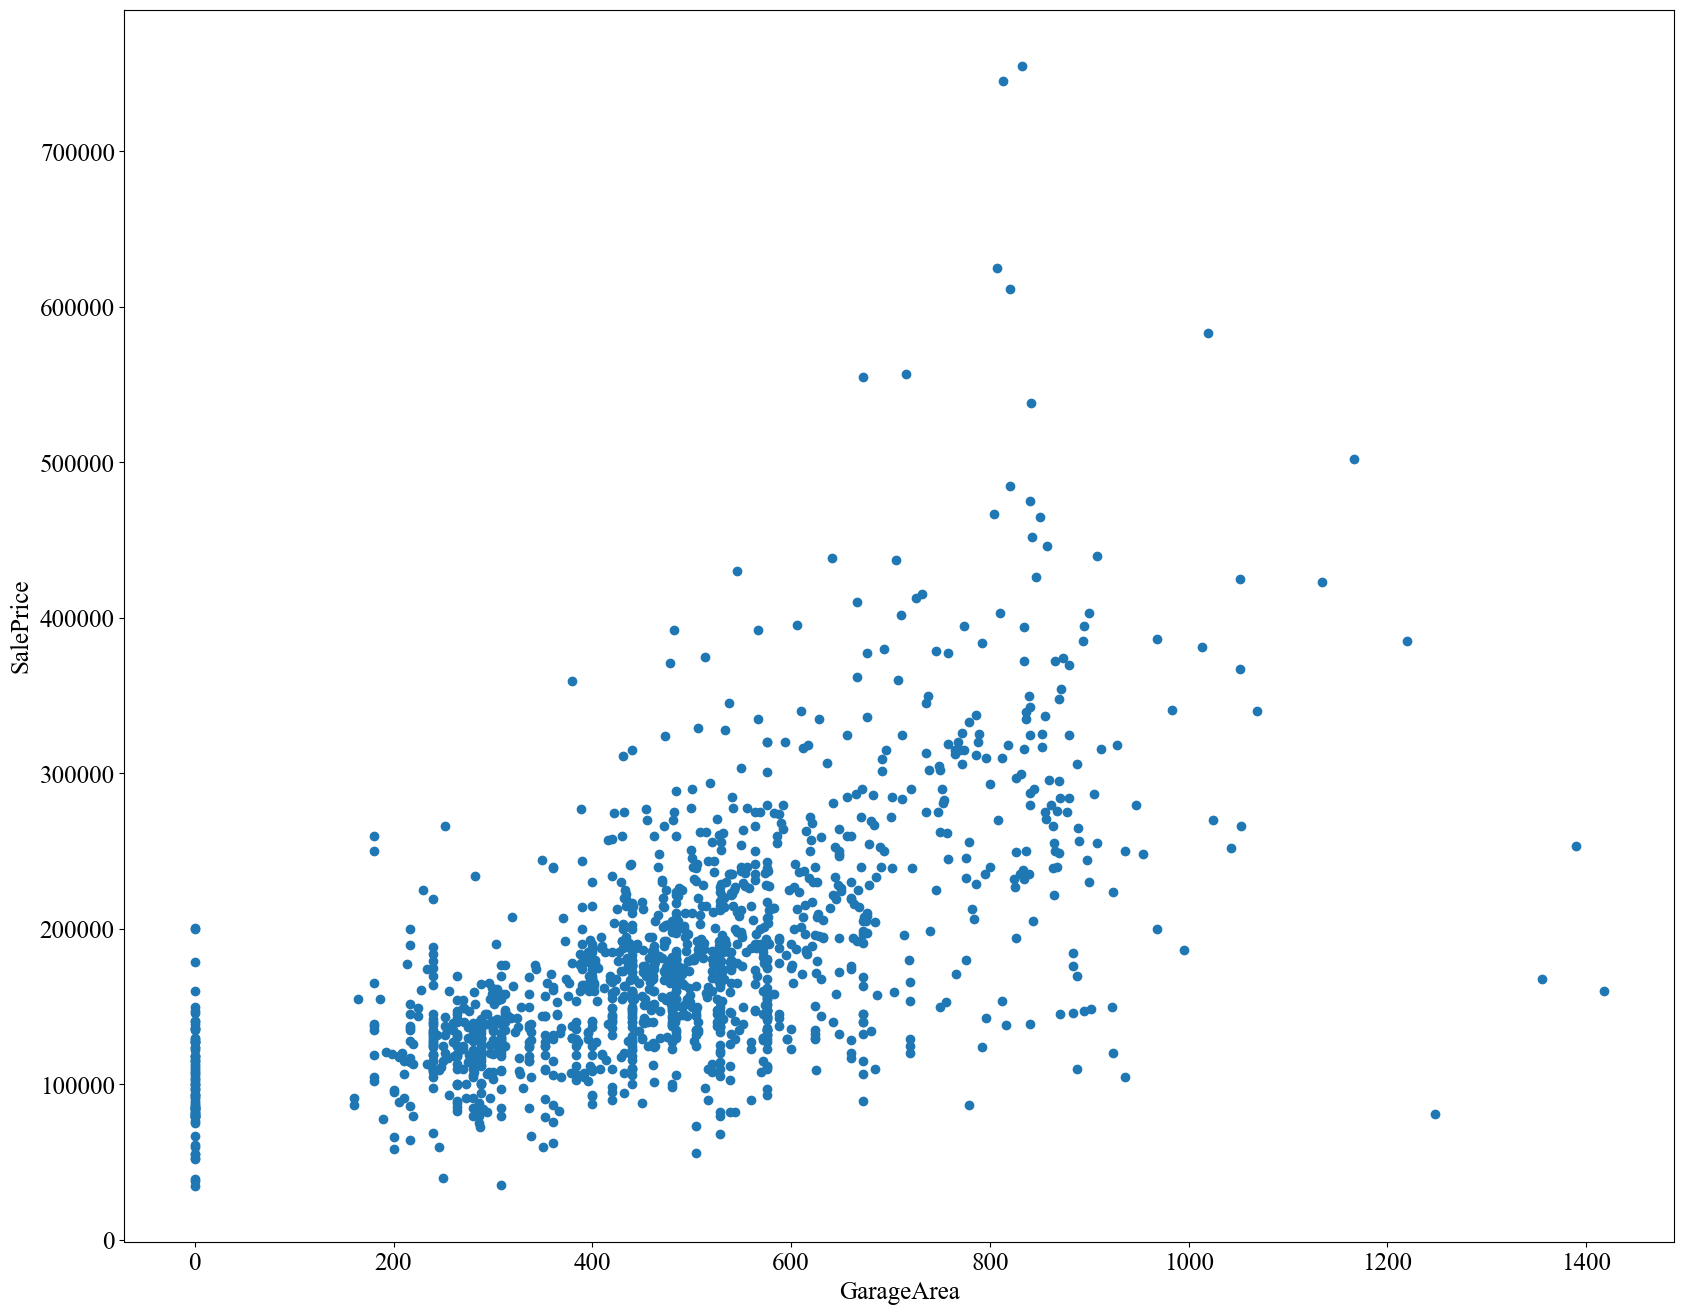

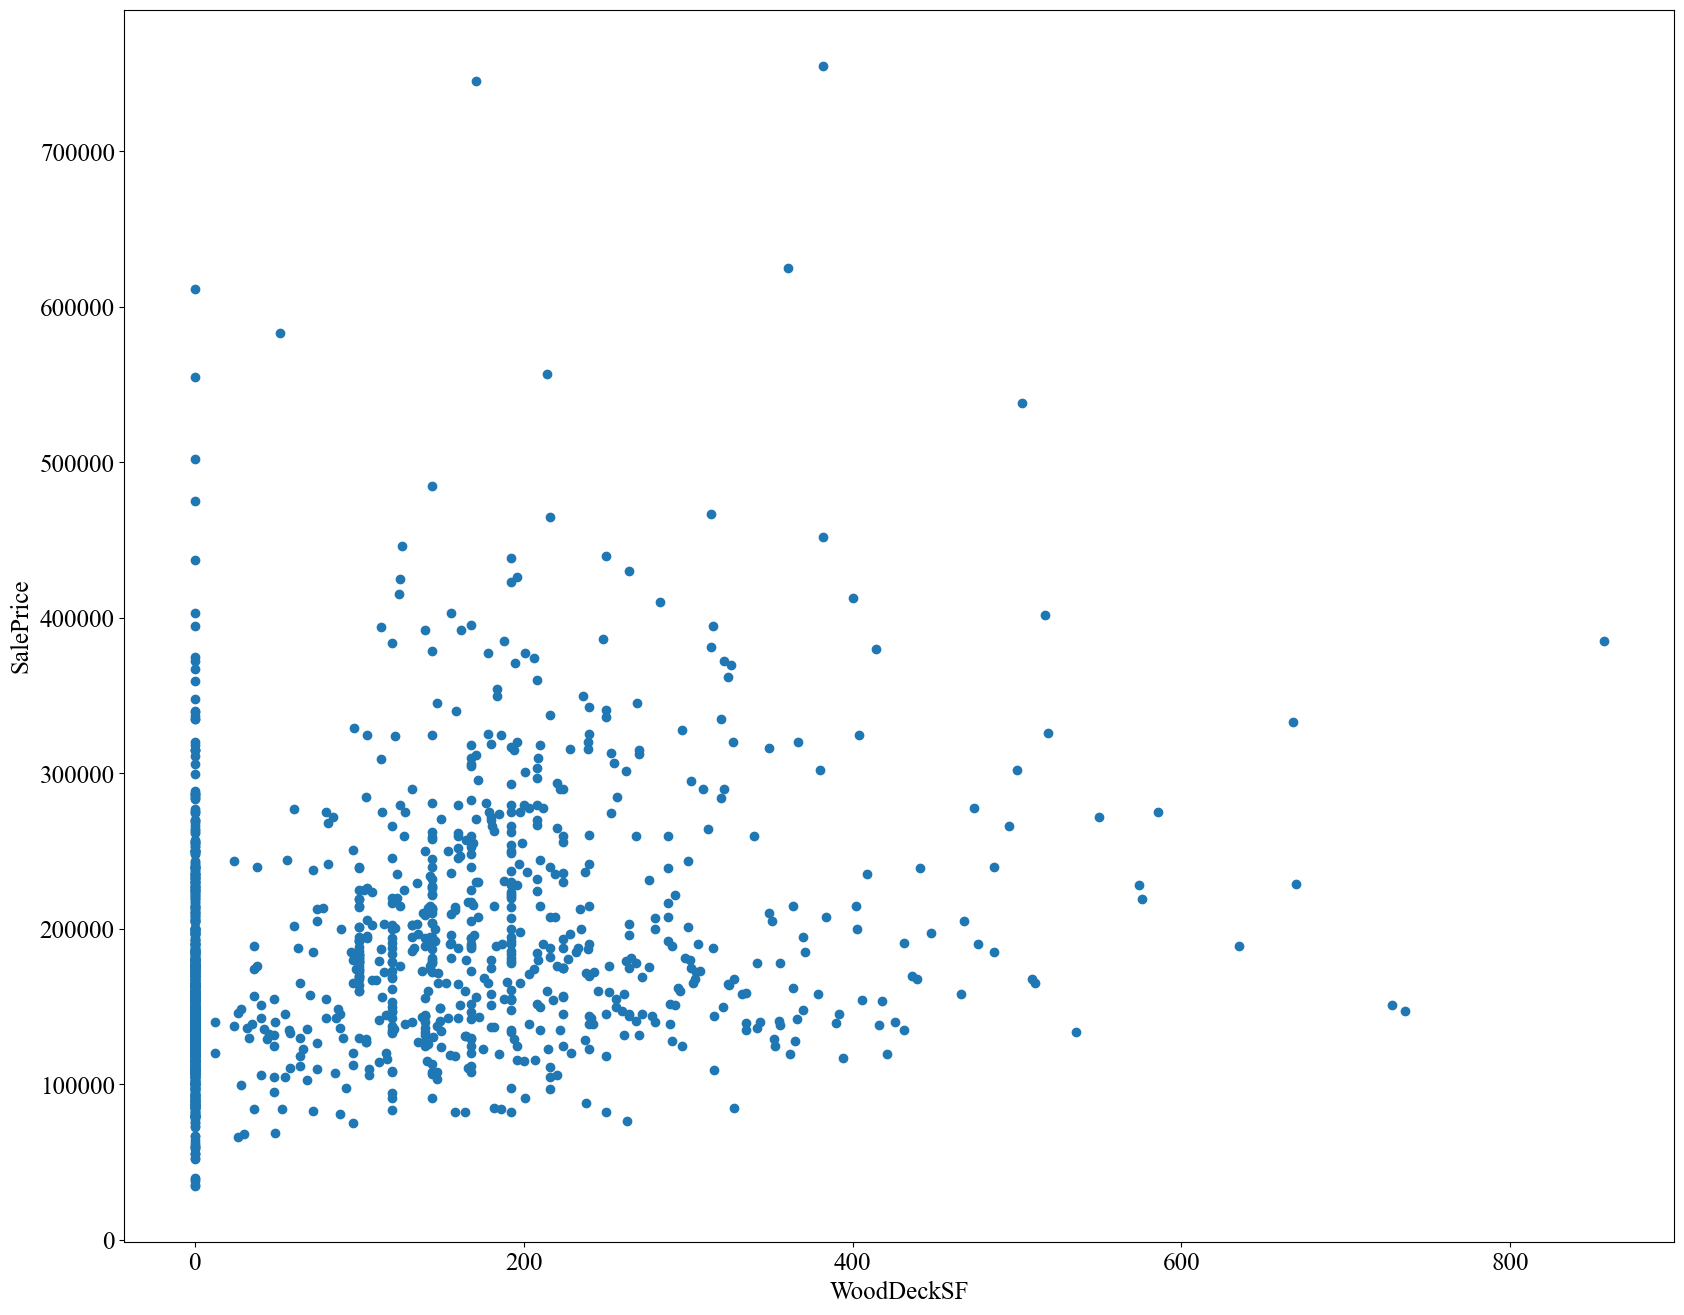

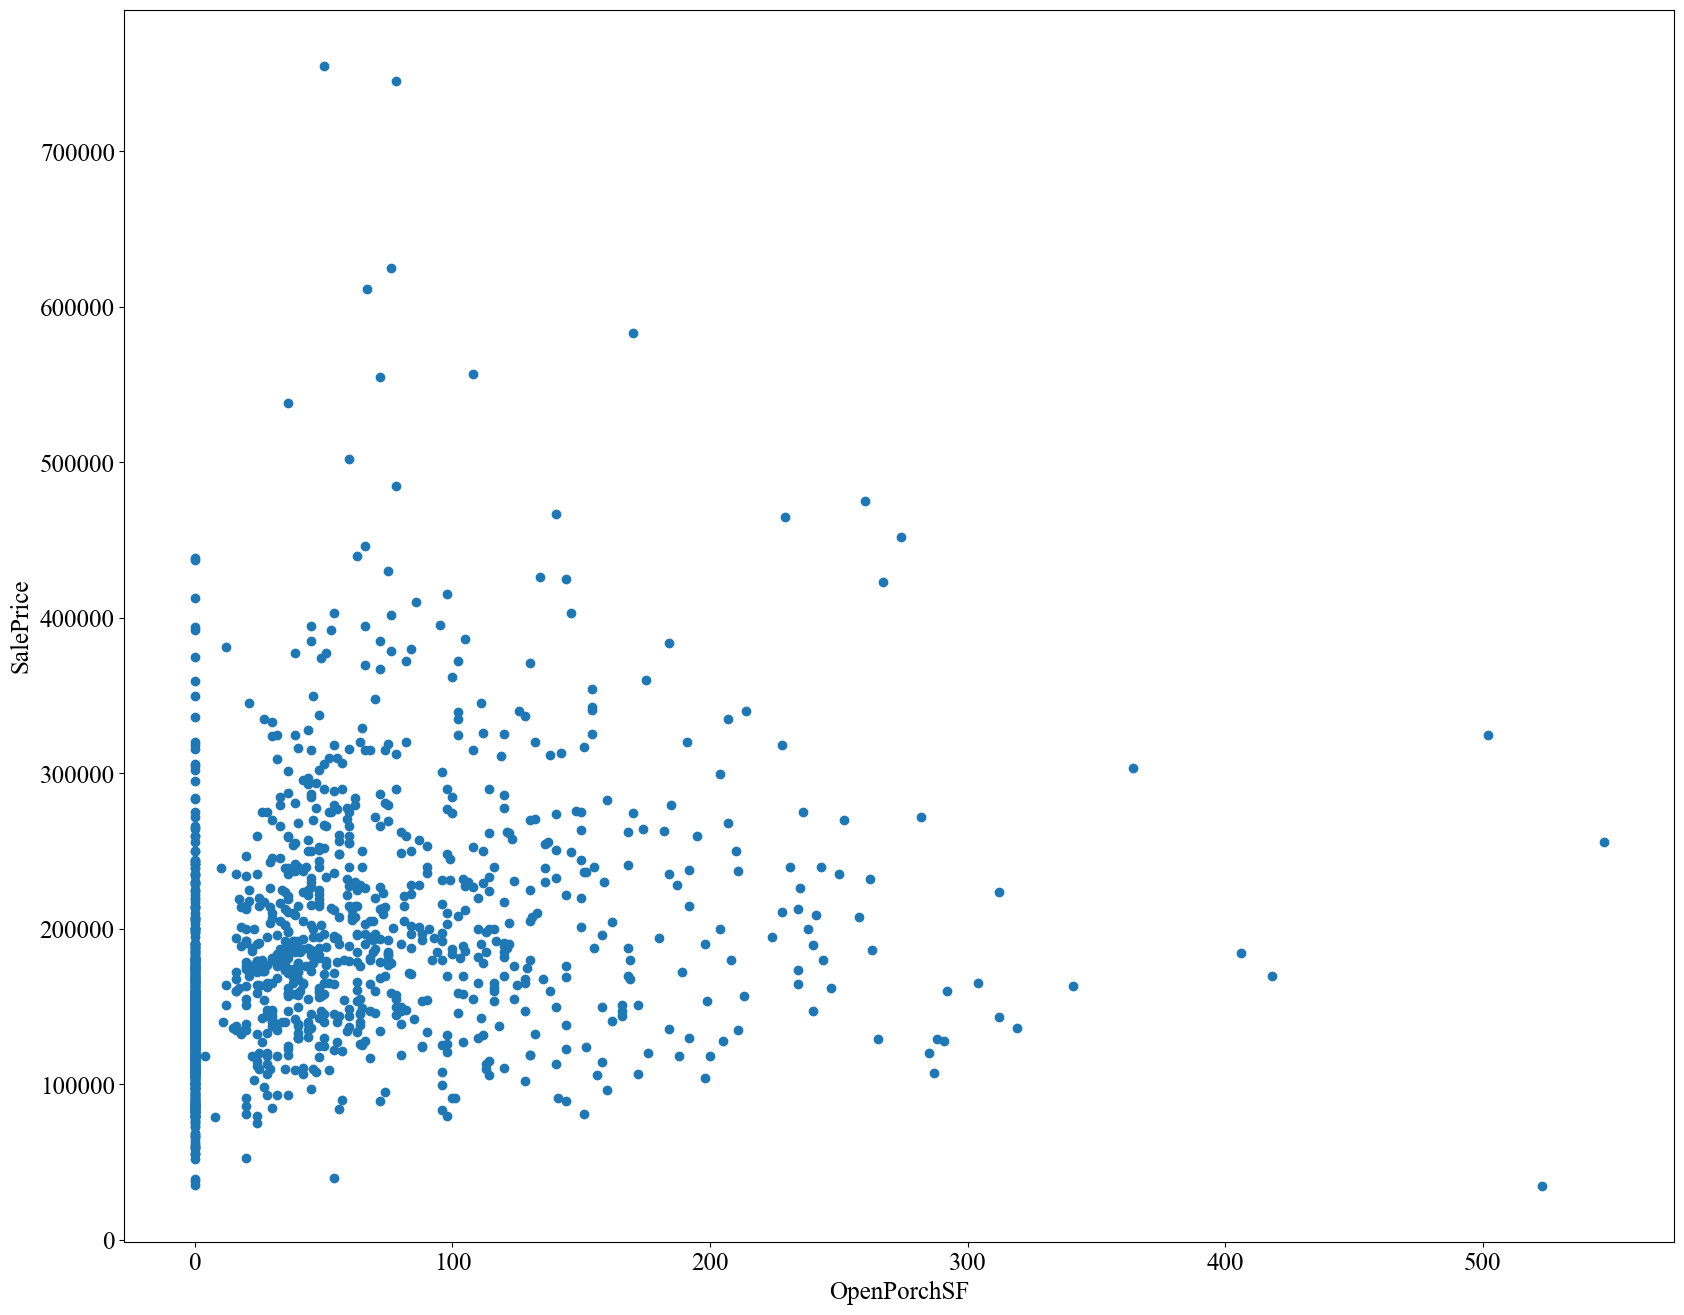

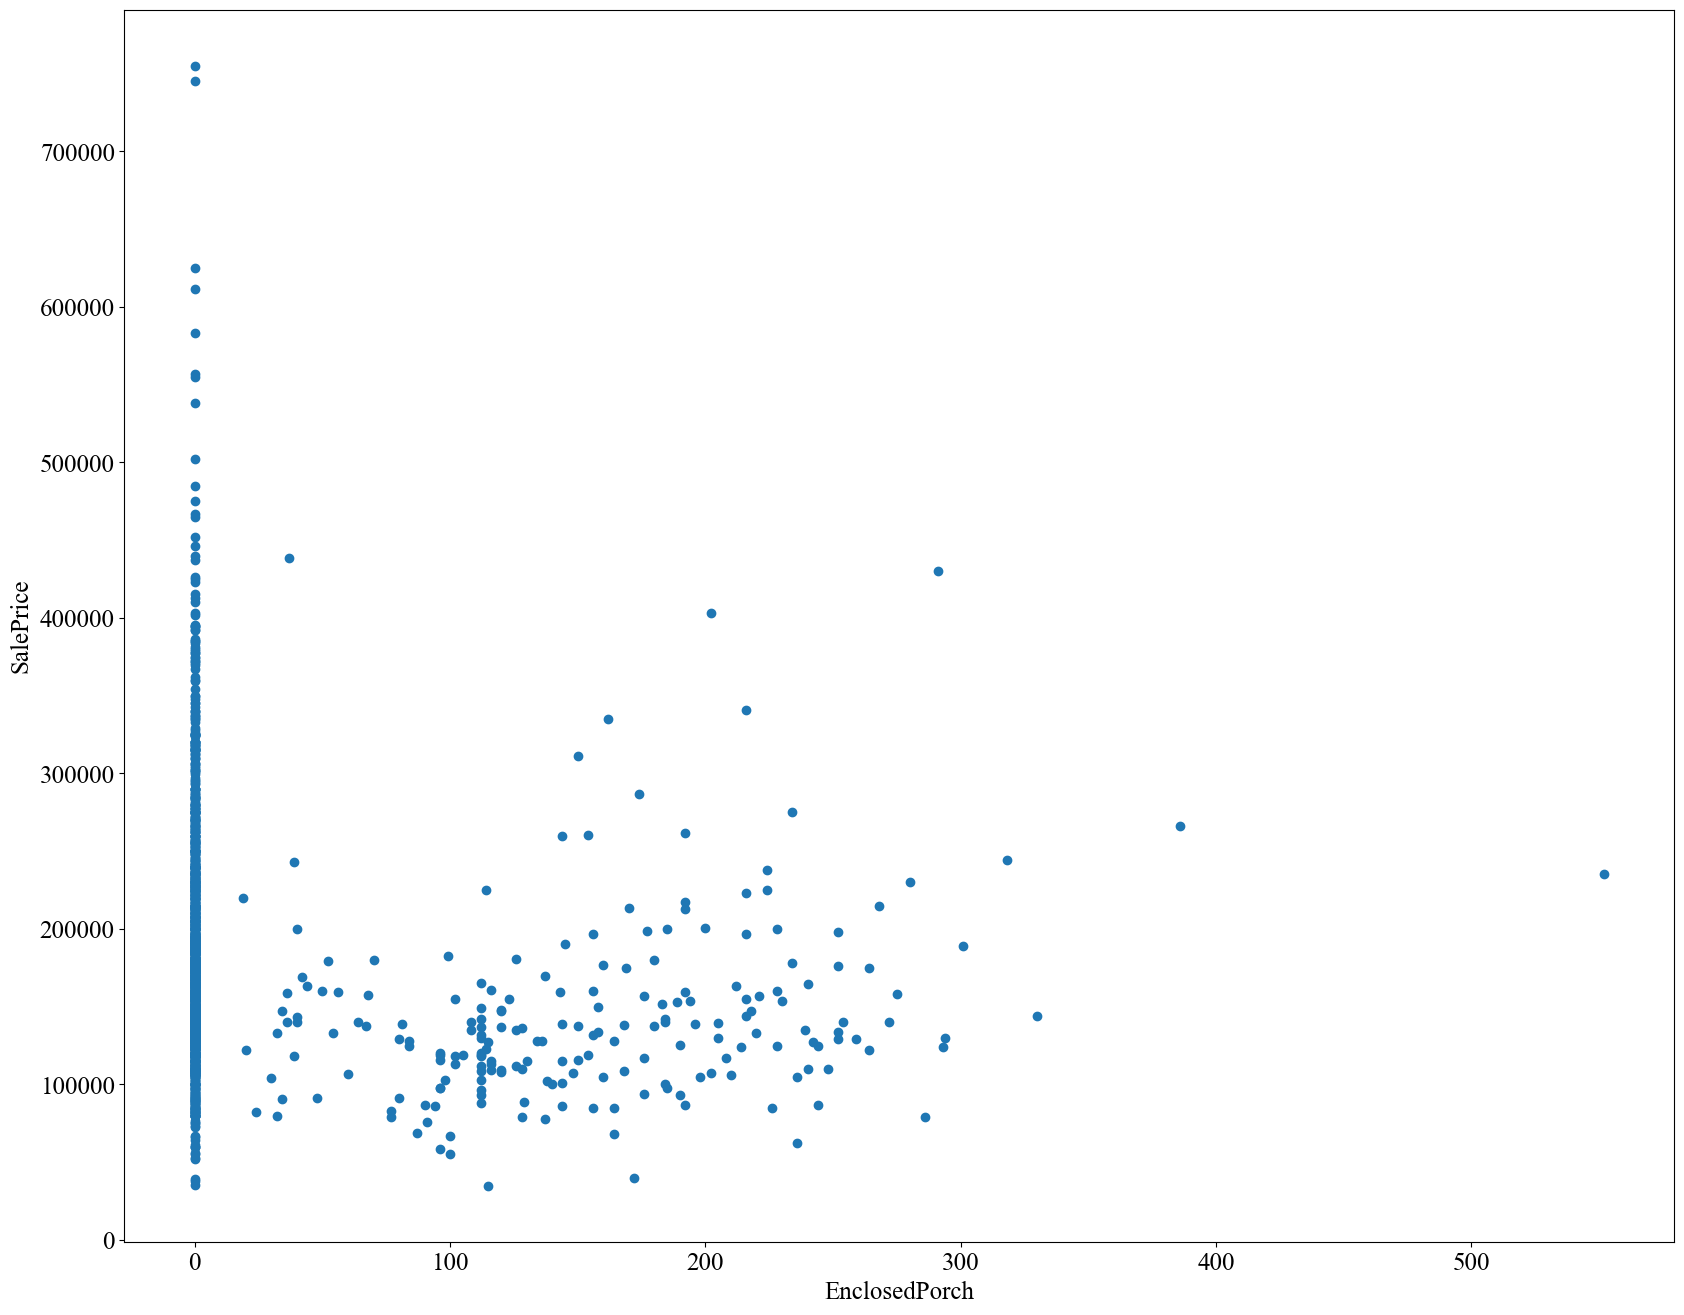

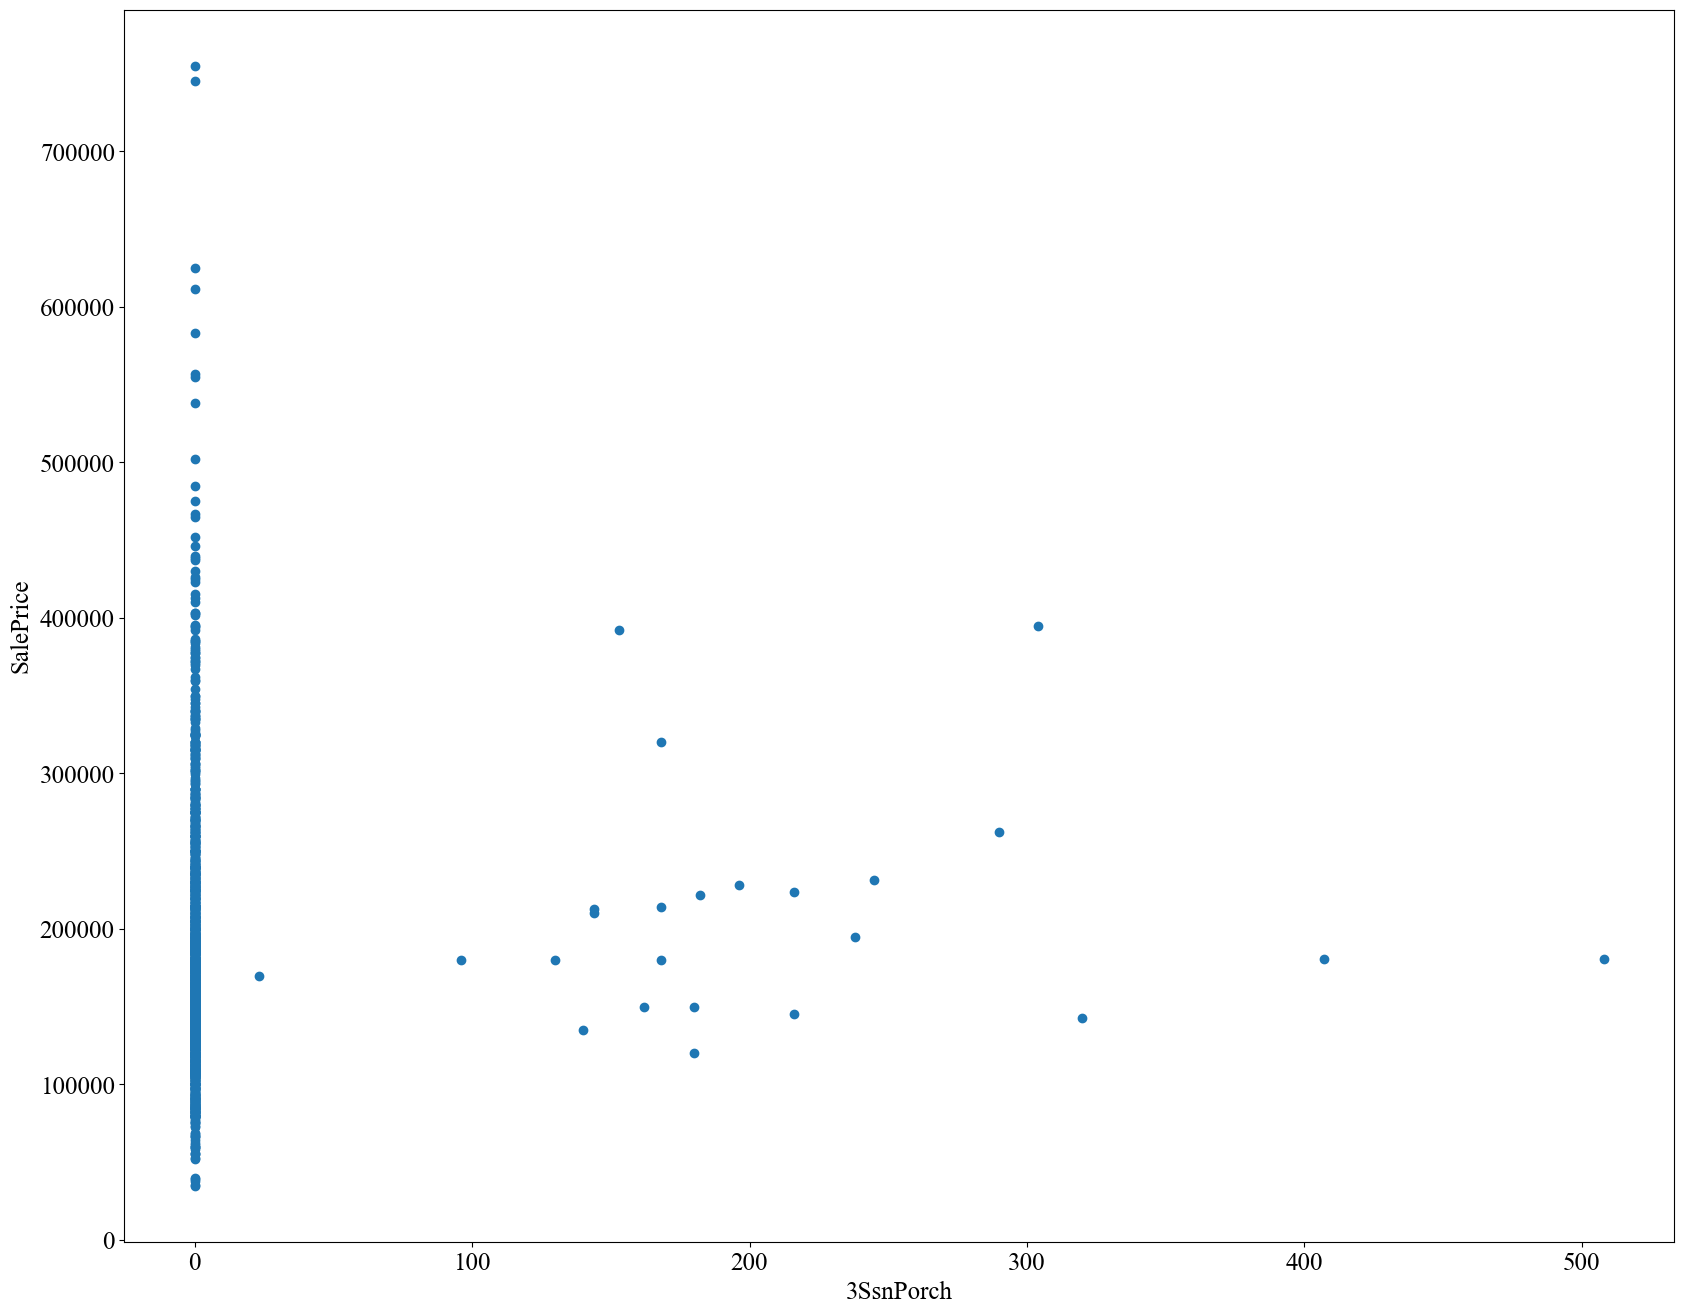

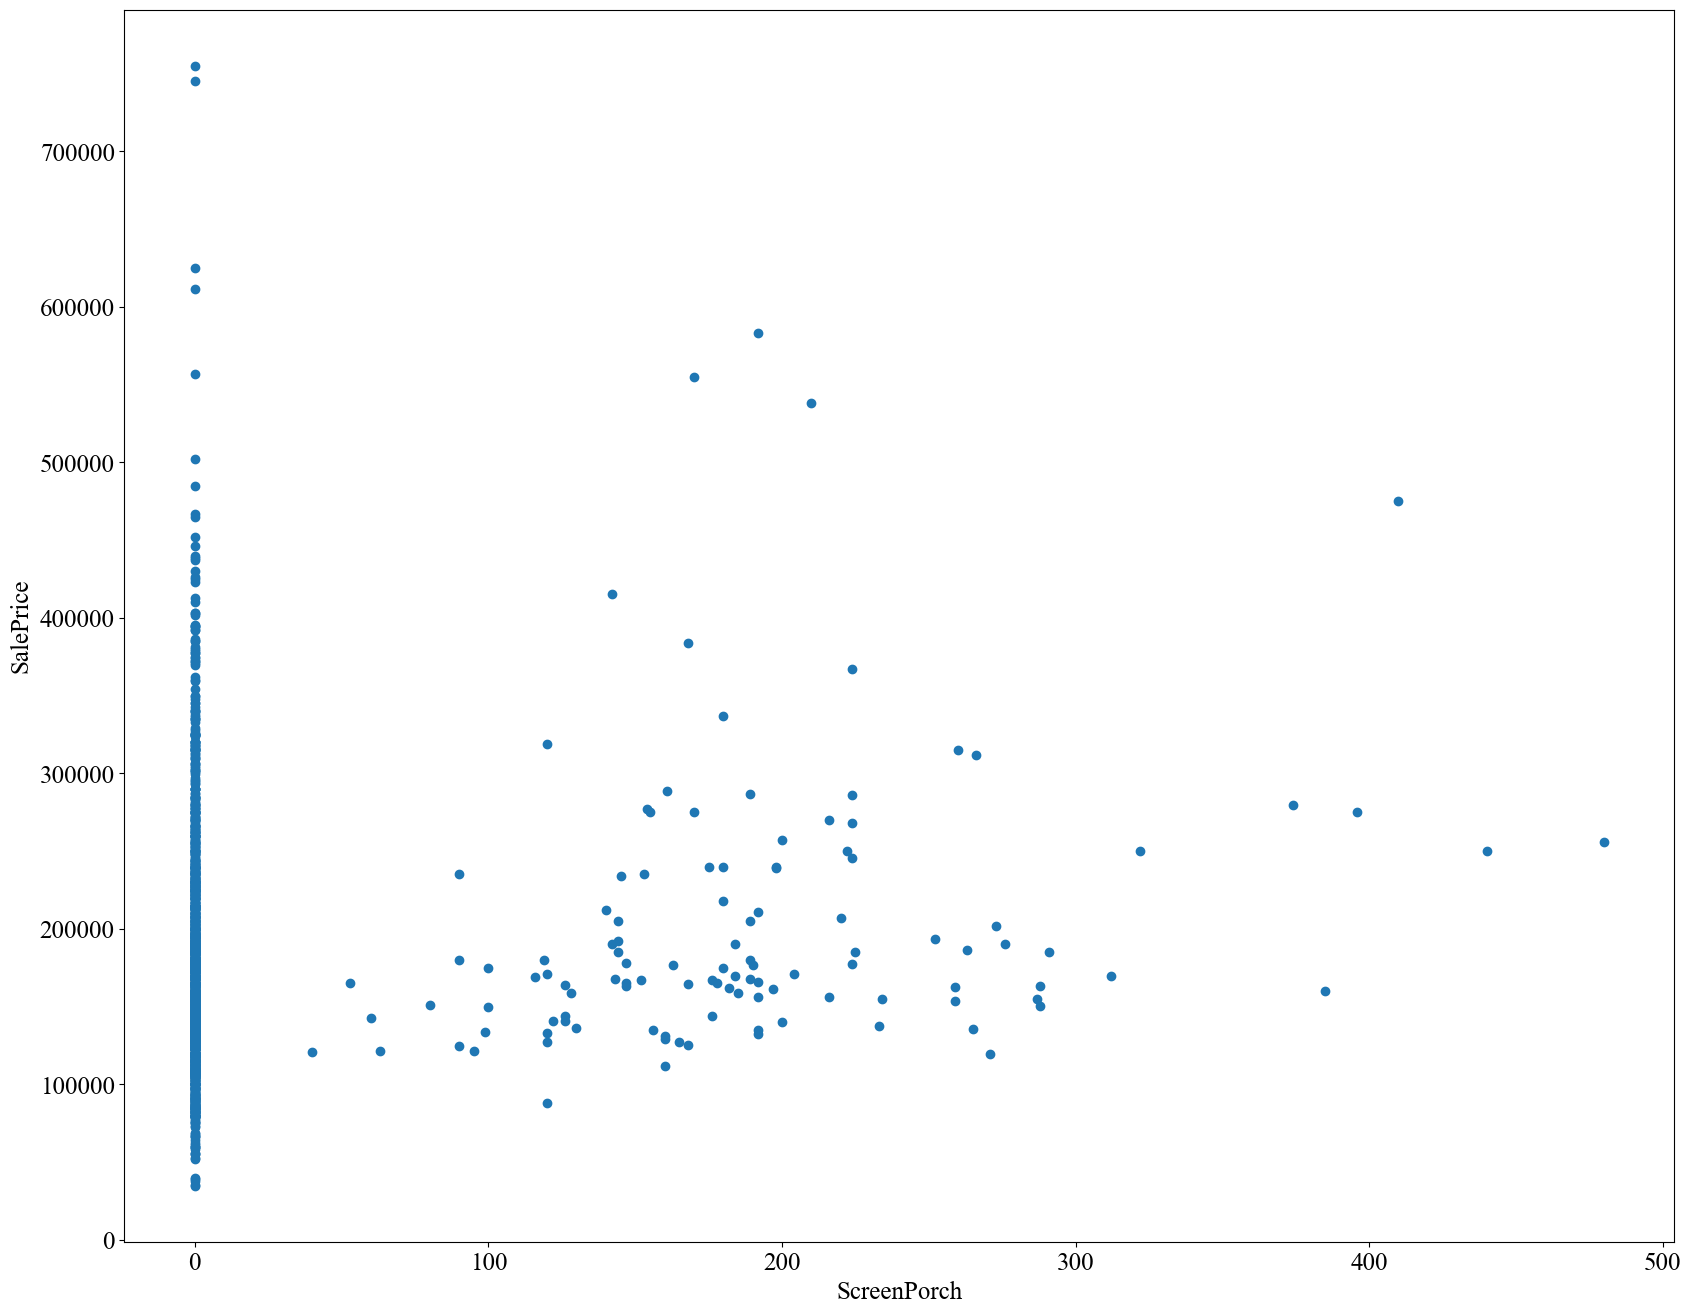

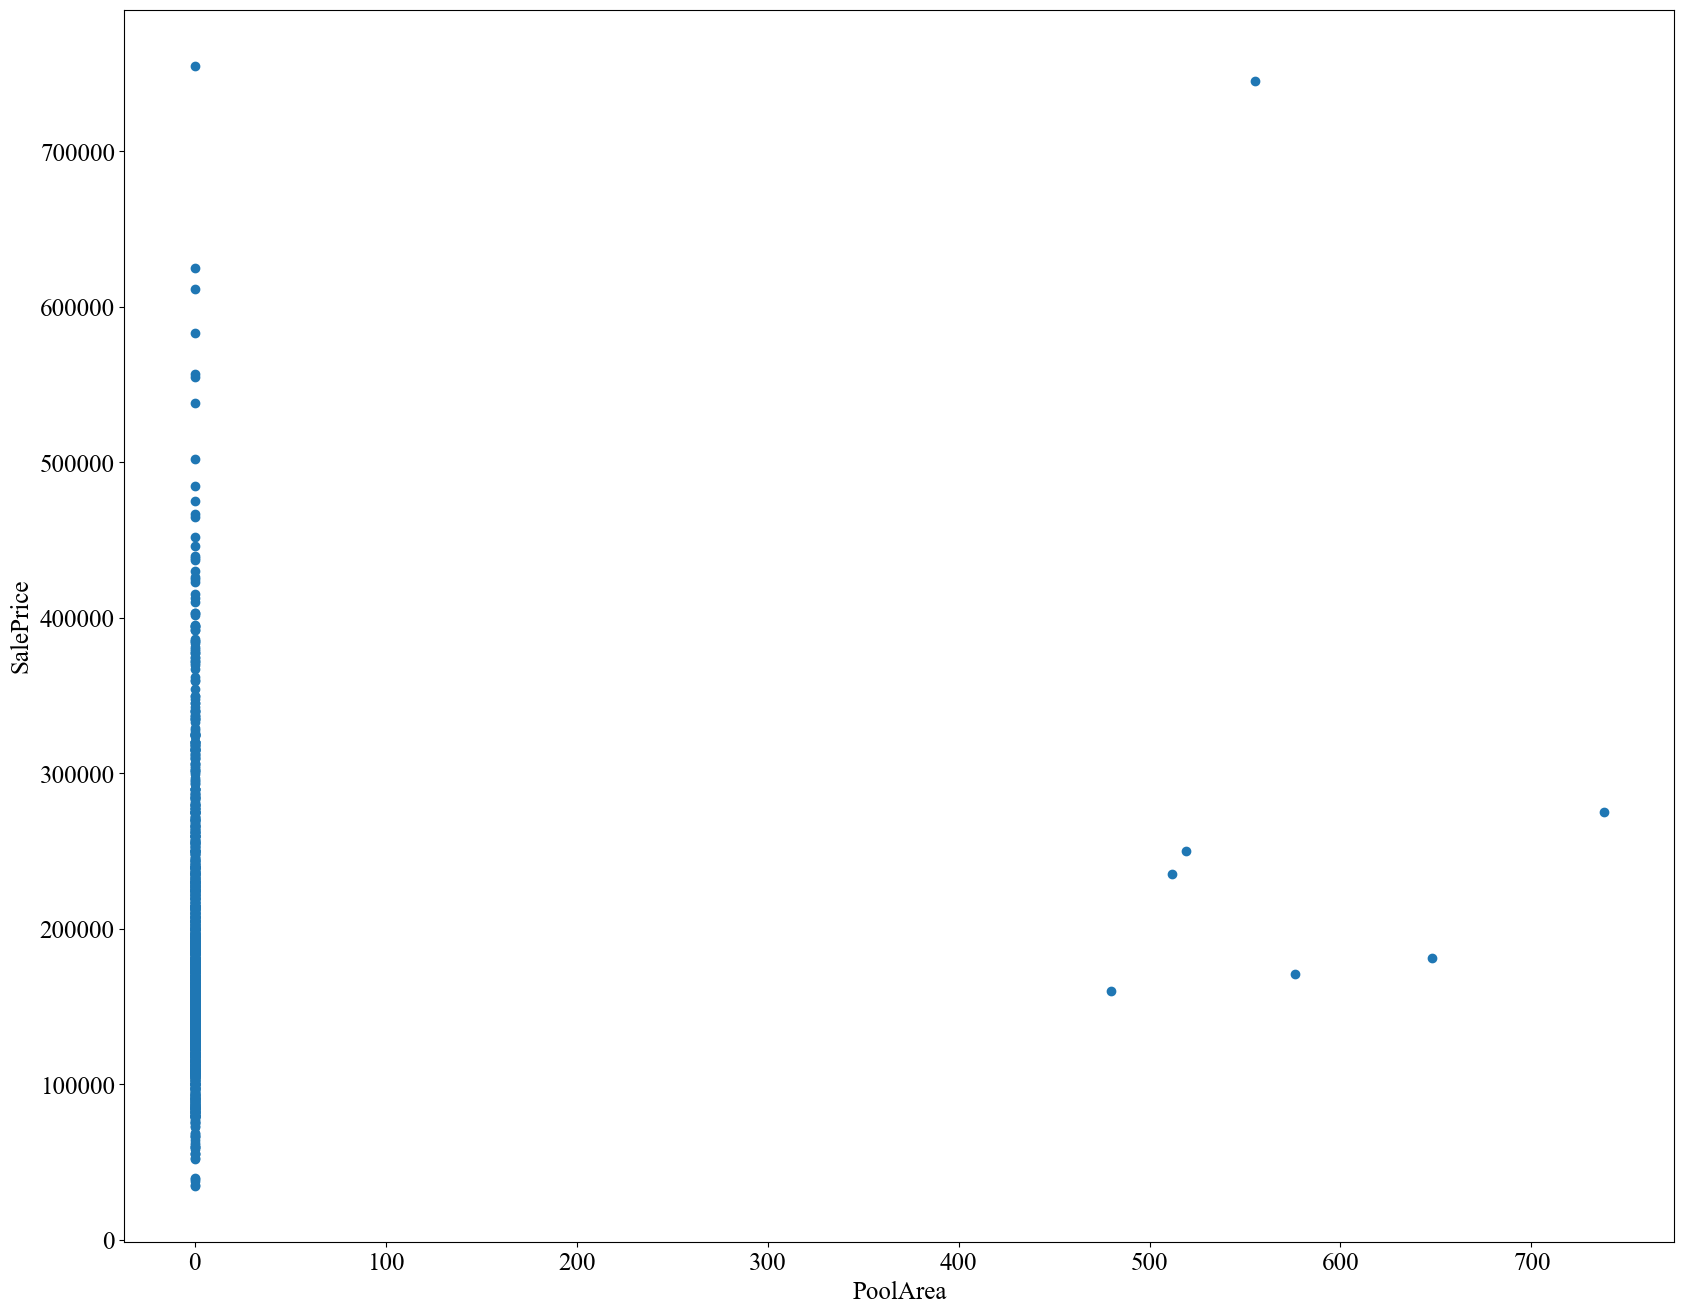

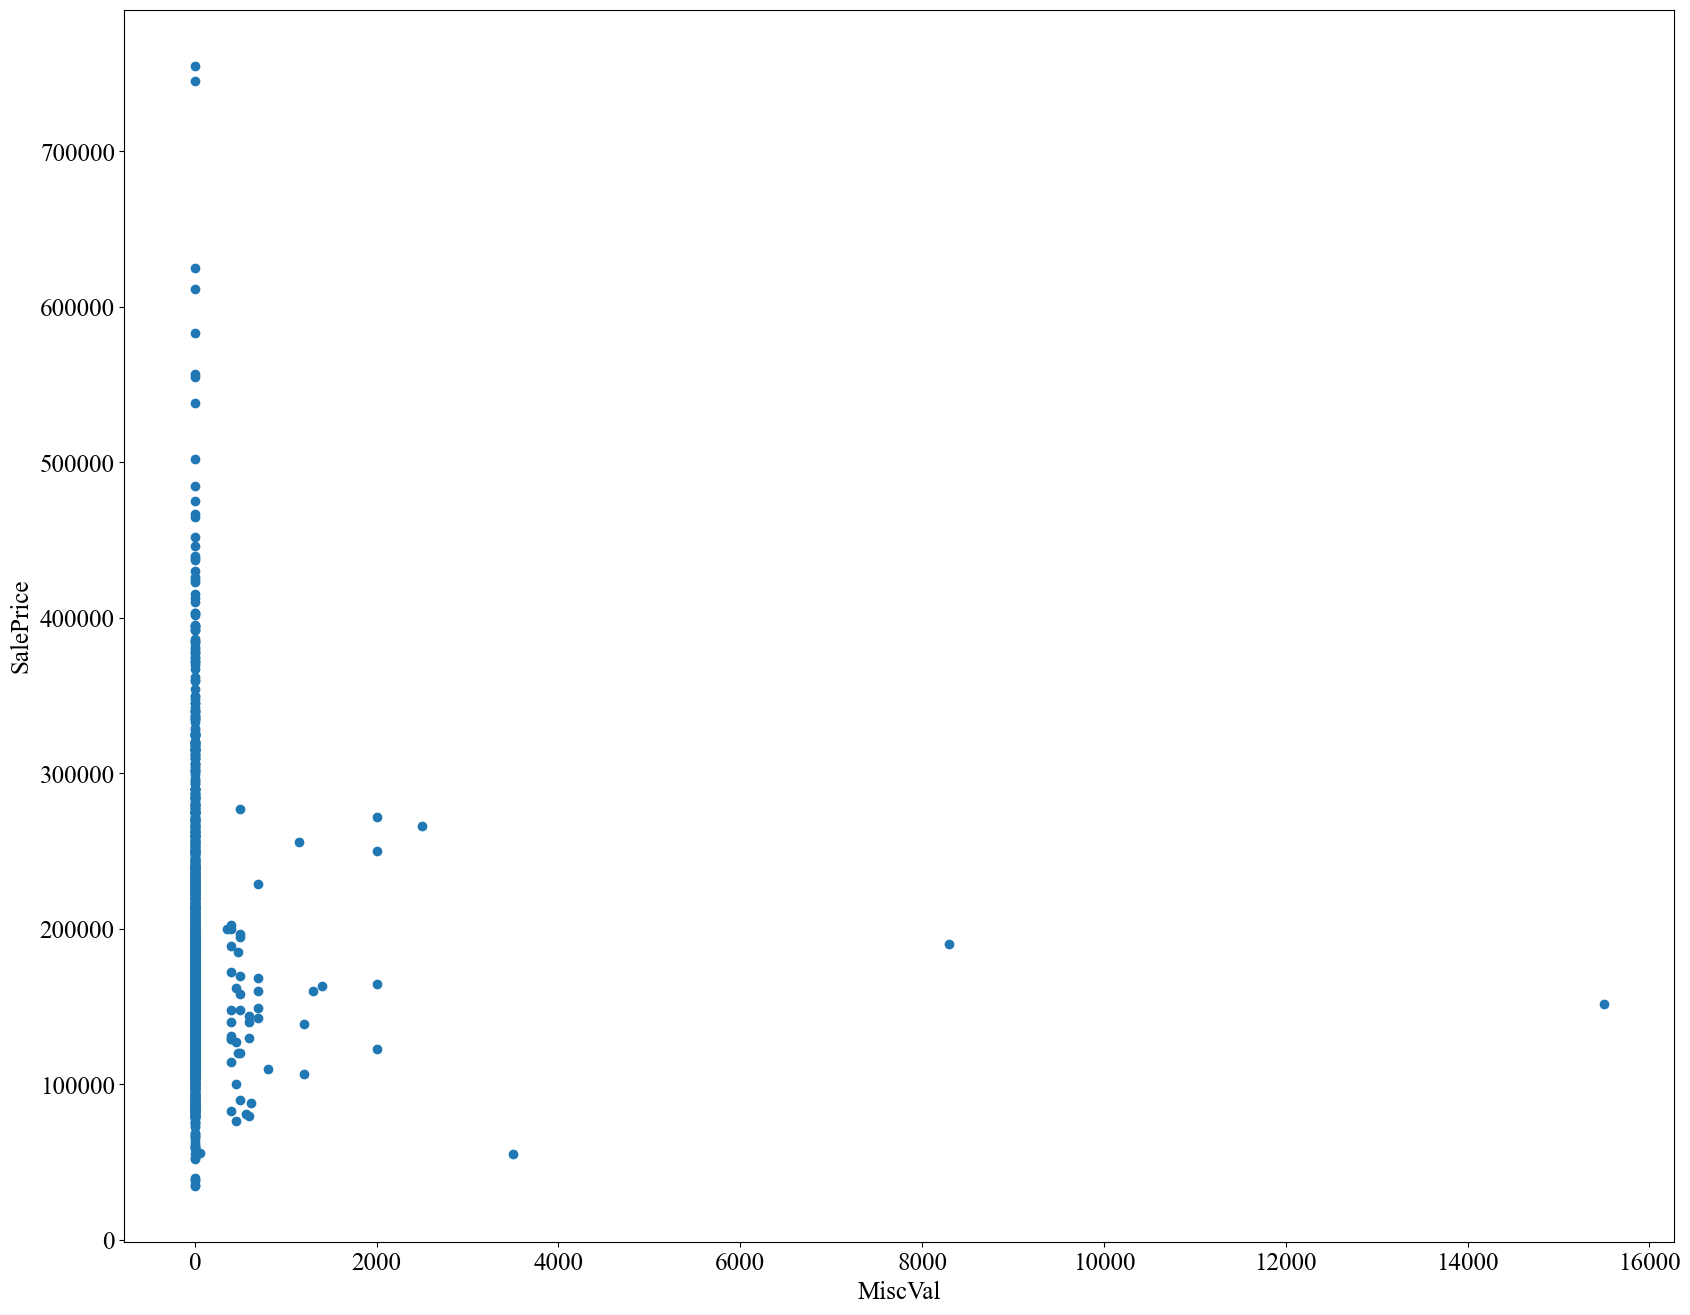

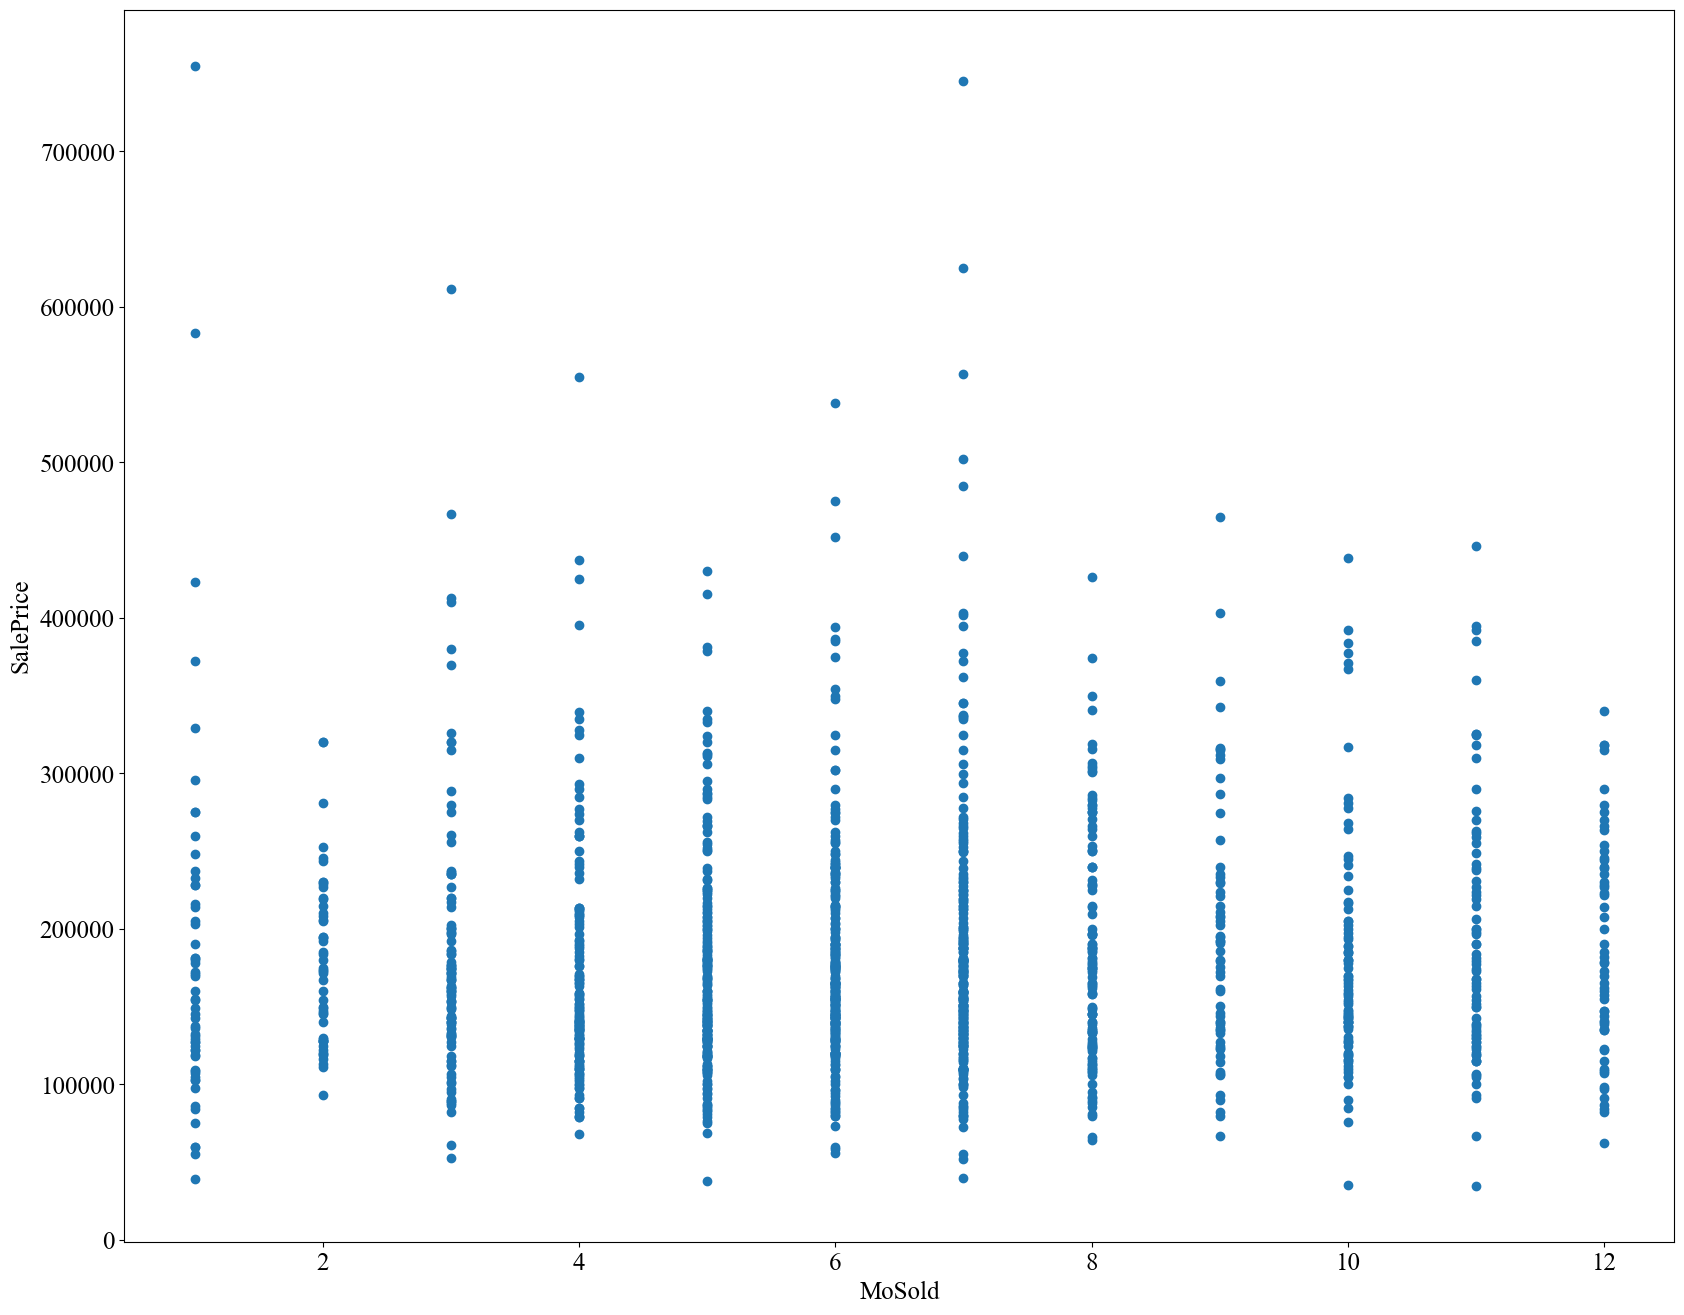

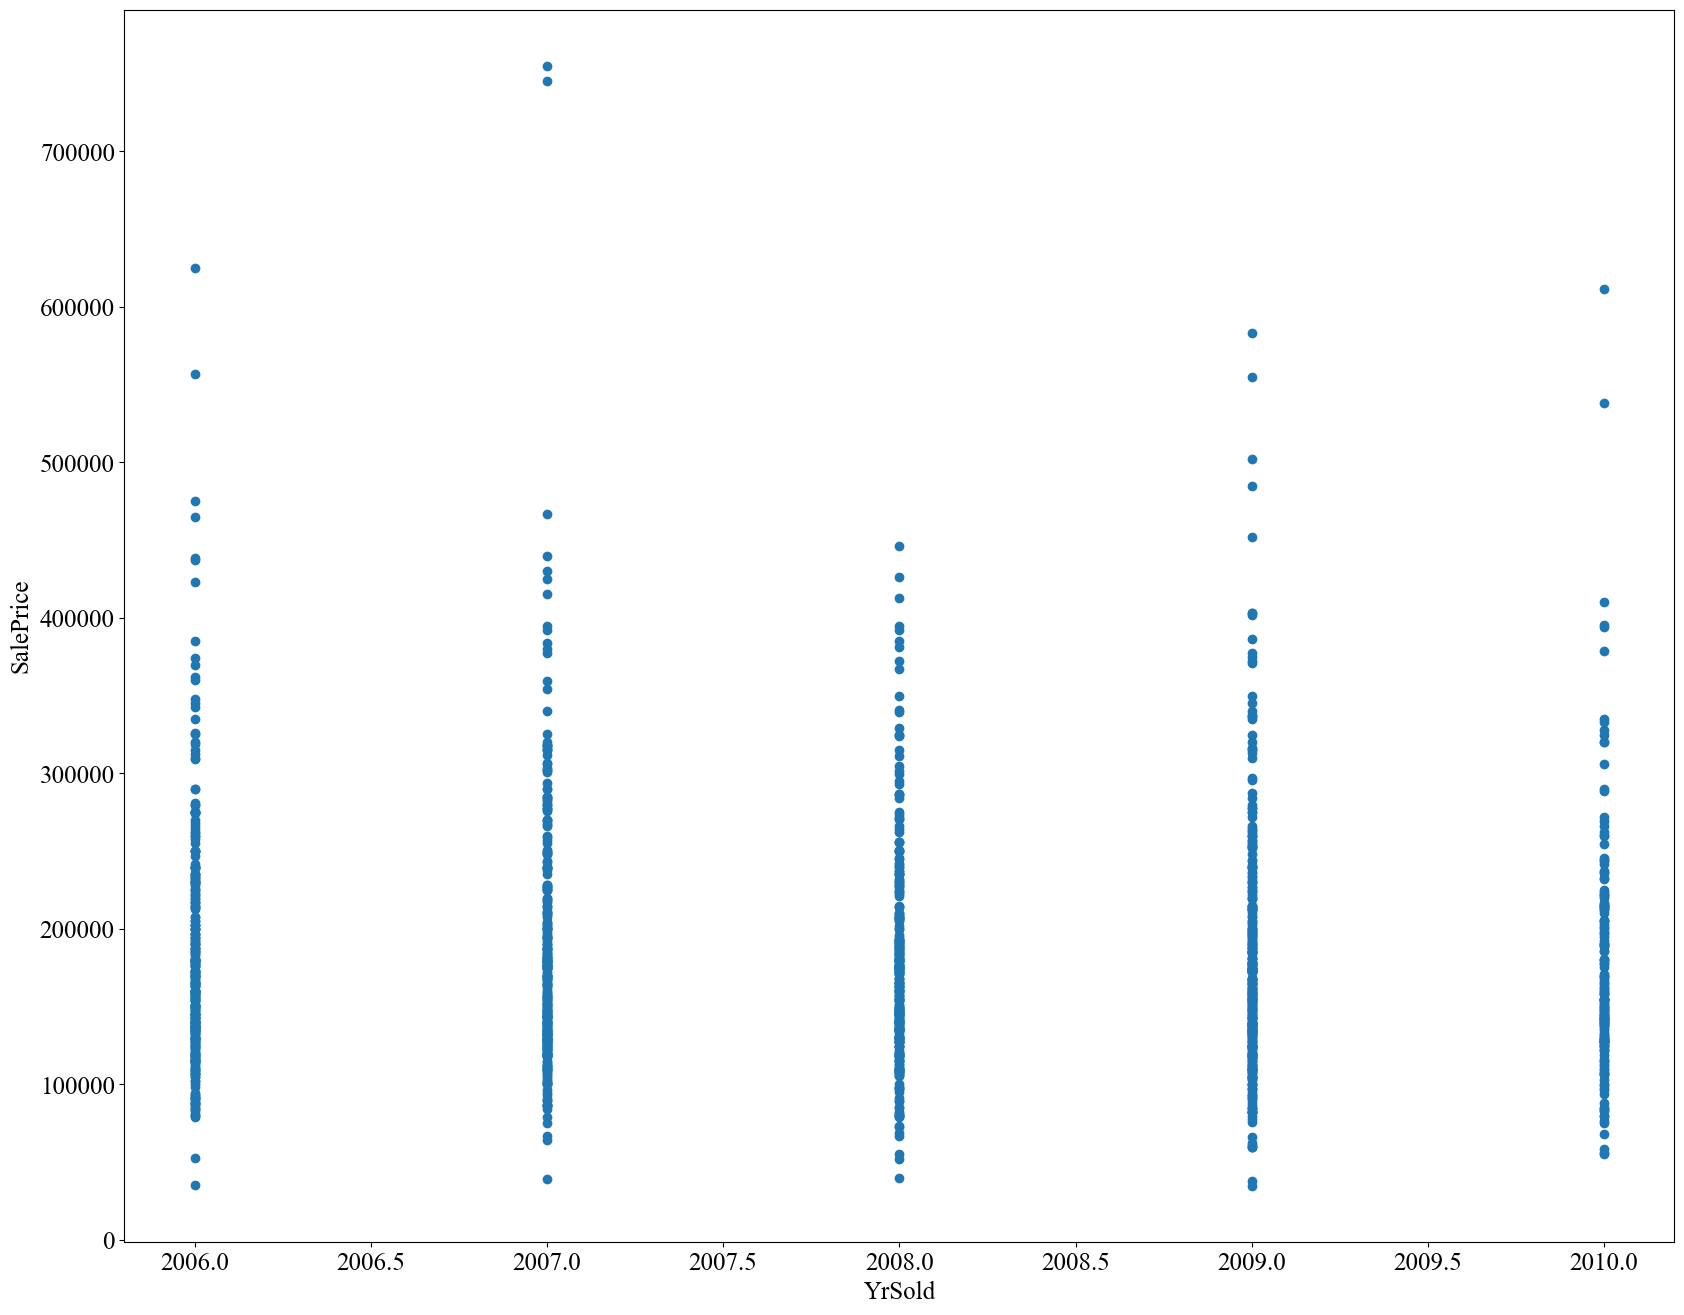

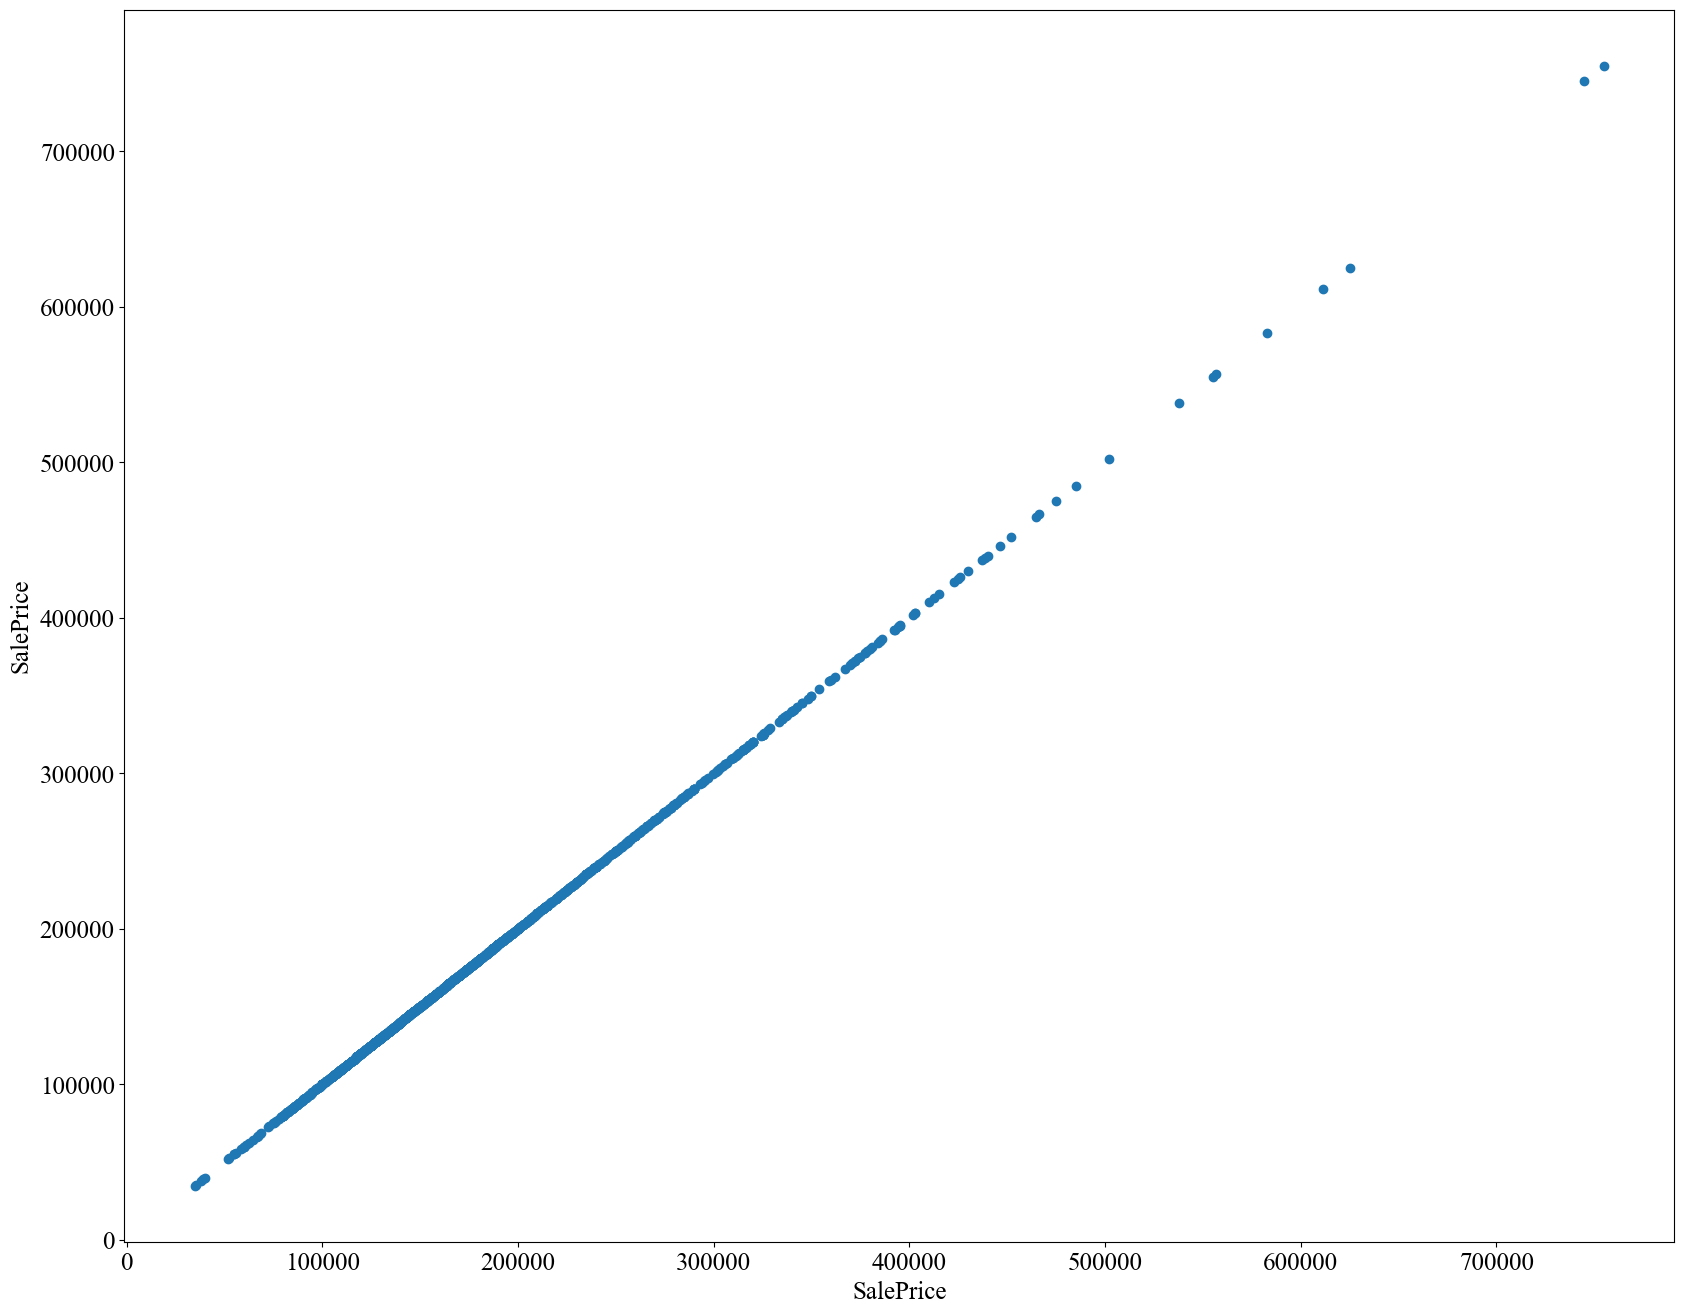

In [82]:

for feature in df_numeric.columns:
    plot_num_target(df, feature)

In [83]:
df_numeric.corr()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
MSSubClass       1.000000    -0.386347 -0.139781     0.032628    -0.059316   
LotFrontage     -0.386347     1.000000  0.426095     0.251646    -0.059213   
LotArea         -0.139781     0.426095  1.000000     0.105806    -0.005636   
OverallQual      0.032628     0.251646  0.105806     1.000000    -0.091932   
OverallCond     -0.059316    -0.059213 -0.005636    -0.091932     1.000000   
YearBuilt        0.027850     0.123349  0.014228     0.572323    -0.375983   
YearRemodAdd     0.040581     0.088866  0.013788     0.550684     0.073741   
MasVnrArea       0.022936     0.193458  0.104160     0.411876    -0.128101   
BsmtFinSF1      -0.069836     0.233633  0.214103     0.239666    -0.046231   
BsmtFinSF2      -0.065649     0.049900  0.111170    -0.059119     0.040229   
BsmtUnfSF       -0.140759     0.132644 -0.002618     0.308159    -0.136841   
TotalBsmtSF     -0.238518     0.392075  0.260833     0.537808    -0.171098   
1stFlrSF        -0.251758     0.457181  0.299475     0.476224    -0.144203   
2ndFlrSF         0.307886     0.080177  0.050986     0.295493     0.028942   
LowQualFinSF     0.046474     0.038469  0.004779    -0.030429     0.025494   
GrLivArea        0.074853     0.402797  0.263116     0.593007    -0.079686   
BsmtFullBath     0.003491     0.100949  0.158155     0.111098    -0.054942   
BsmtHalfBath    -0.002333    -0.007234  0.048046    -0.040150     0.117821   
FullBath         0.131608     0.198769  0.126031     0.550600    -0.194149   
HalfBath         0.177354     0.053532  0.014259     0.273458    -0.060769   
BedroomAbvGr    -0.023438     0.263170  0.119690     0.101676     0.012980   
KitchenAbvGr     0.281721    -0.006069 -0.017784    -0.183882    -0.087001   
TotRmsAbvGrd     0.040380     0.352096  0.190015     0.427452    -0.057583   
Fireplaces      -0.045569     0.266639  0.271364     0.396765    -0.023820   
GarageYrBlt      0.085072     0.070250 -0.024947     0.547766    -0.324297   
GarageCars      -0.040110     0.285691  0.154871     0.600671    -0.185758   
GarageArea      -0.098672     0.344997  0.180403     0.562022    -0.151521   
WoodDeckSF      -0.012579     0.088521  0.171698     0.238923    -0.003334   
OpenPorchSF     -0.006100     0.151972  0.084774     0.308819    -0.032589   
EnclosedPorch   -0.012037     0.010700 -0.018340    -0.113937     0.070356   
3SsnPorch       -0.043825     0.070029  0.020423     0.030371     0.025504   
ScreenPorch     -0.026030     0.041383  0.043160     0.064886     0.054811   
PoolArea         0.008283     0.206167  0.077672     0.065166    -0.001985   
MiscVal         -0.007683     0.003368  0.038068    -0.031406     0.068777   
MoSold          -0.013585     0.011200  0.001205     0.070815    -0.003511   
YrSold          -0.021407     0.007450 -0.014261    -0.027347     0.043950   
SalePrice       -0.084284     0.351799  0.263843     0.790982    -0.077856   

               YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
MSSubClass      0.027850      0.040581    0.022936   -0.069836   -0.065649   
LotFrontage     0.123349      0.088866    0.193458    0.233633    0.049900   
LotArea         0.014228      0.013788    0.104160    0.214103    0.111170   
OverallQual     0.572323      0.550684    0.411876    0.239666   -0.059119   
OverallCond    -0.375983      0.073741   -0.128101   -0.046231    0.040229   
YearBuilt       1.000000      0.592855    0.315707    0.249503   -0.049107   
YearRemodAdd    0.592855      1.000000    0.179618    0.128451   -0.067759   
MasVnrArea      0.315707      0.179618    1.000000    0.264736   -0.072319   
BsmtFinSF1      0.249503      0.128451    0.264736    1.000000   -0.050117   
BsmtFinSF2     -0.049107     -0.067759   -0.072319   -0.050117    1.000000   
BsmtUnfSF       0.149040      0.181133    0.114442   -0.495251   -0.209294   
TotalBsmtSF     0.391452      0.291066    0.363936    0.522396    0.104810   
1stFlrSF        0.281986      0.2403

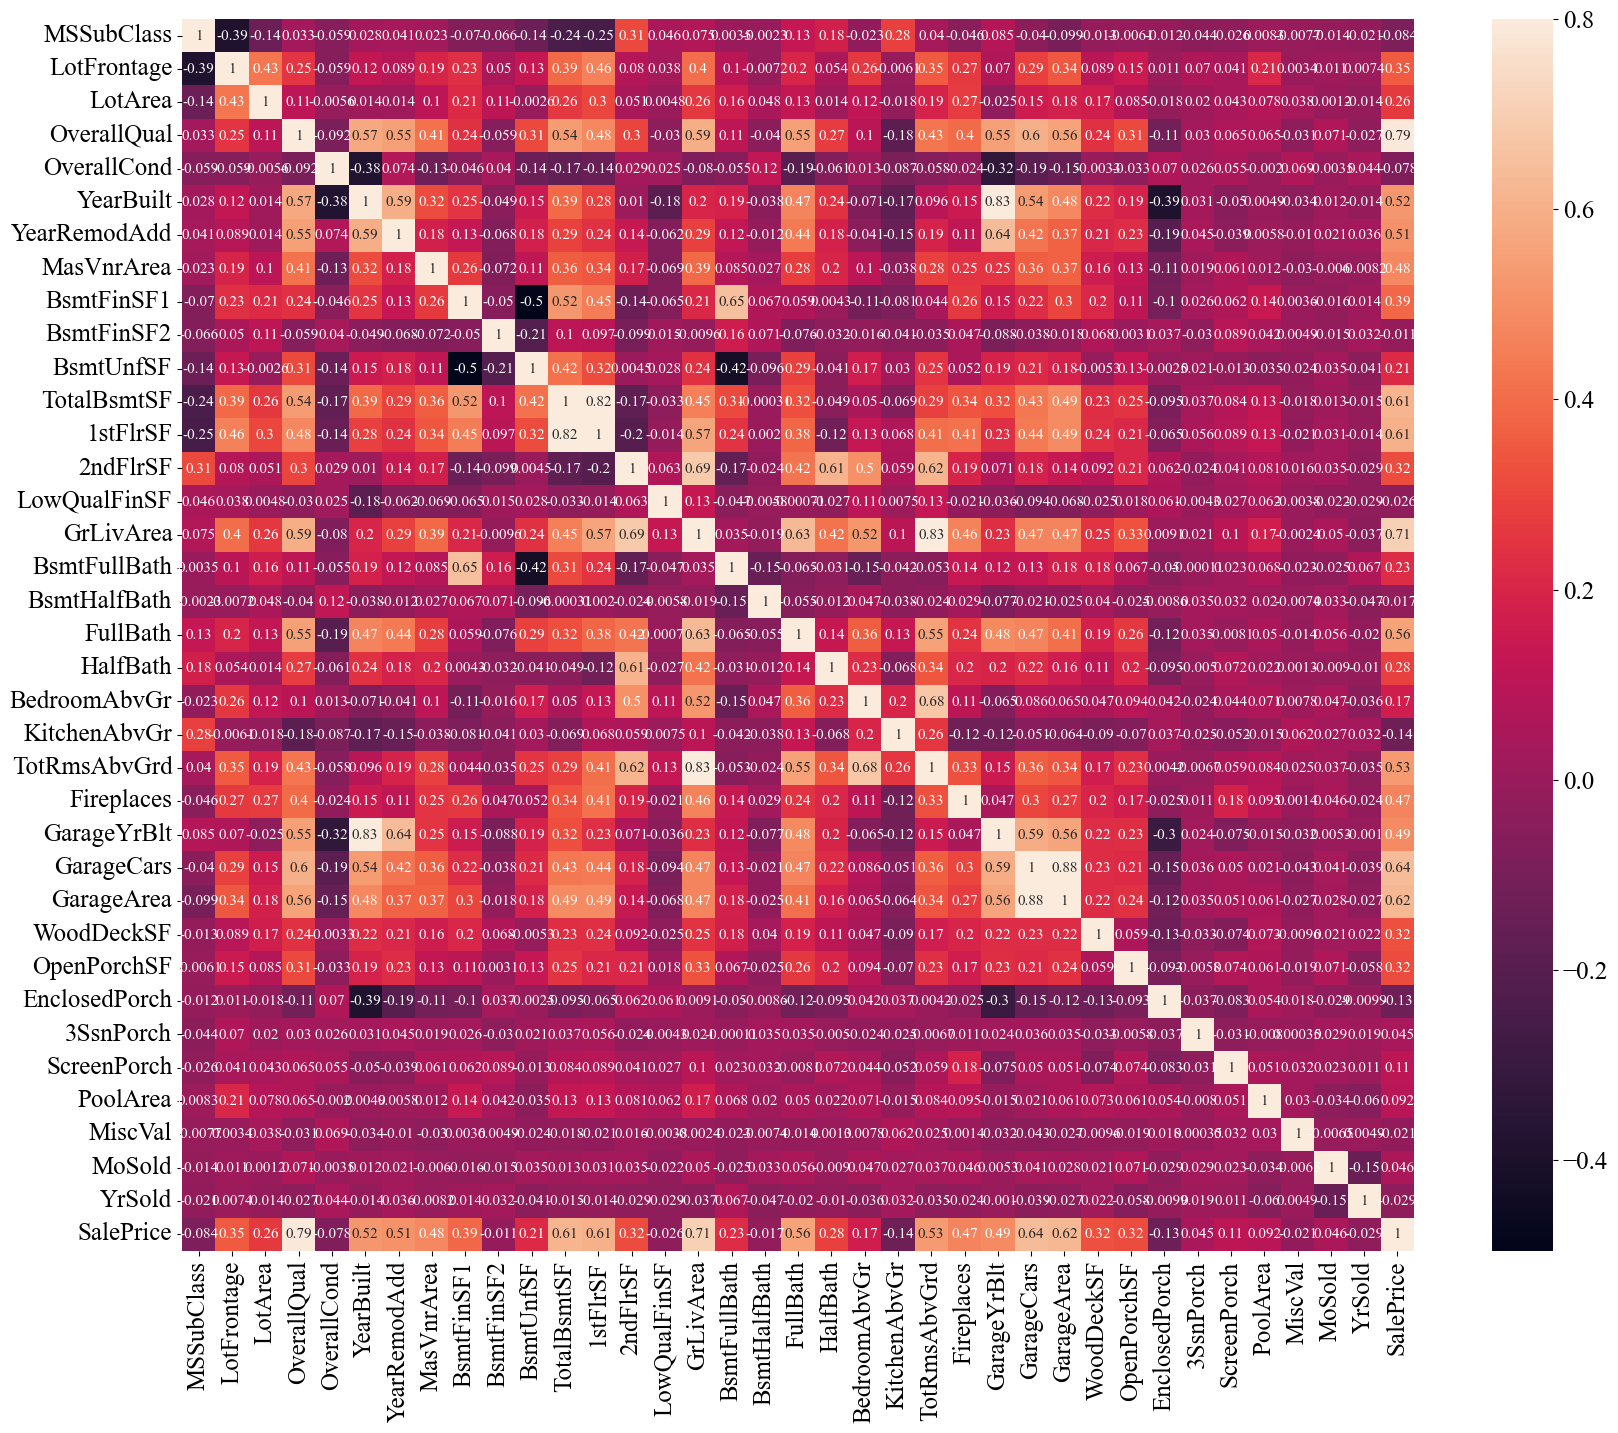

In [84]:
sns.heatmap(df_numeric.corr(),annot=True, vmax=0.8, square=True,annot_kws={'size': 11});

## EDA: Categorical features

In [85]:
df_categorical = df.select_dtypes(include=['object'])

In [86]:
df_categorical

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0          RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1          RL   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl   
2          RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
3          RL   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl   
4          RL   Pave   NaN      IR1         Lvl    AllPub       FR2       Gtl   
...       ...    ...   ...      ...         ...       ...       ...       ...   
1455       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1456       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1457       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1458       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1459       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   

     Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle  \
0         CollgCr       Norm       Norm     1Fam     2Story     Gable   
1         Veenker      Feedr       Norm     1Fam     1Story     Gable   
2         CollgCr       Norm       Norm     1Fam     2Story     Gable   
3         Crawfor       Norm       Norm     1Fam     2Story     Gable   
4         NoRidge       Norm       Norm     1Fam     2Story     Gable   
...           ...        ...        ...      ...        ...       ...   
1455      Gilbert       Norm       Norm     1Fam     2Story     Gable   
1456       NWAmes       Norm       Norm     1Fam     1Story     Gable   
1457      Crawfor       Norm       Norm     1Fam     2Story     Gable   
1458        NAmes       Norm       Norm     1Fam     1Story       Hip   
1459      Edwards       Norm       Norm     1Fam     1Story     Gable   

     RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual ExterCond  \
0     CompShg     VinylSd     VinylSd    BrkFace        Gd        TA   
1     CompShg     MetalSd     MetalSd       None        TA        TA   
2     CompShg     VinylSd     VinylSd    BrkFace        Gd        TA   
3     CompShg     Wd Sdng     Wd Shng       None        TA        TA   
4     CompShg     VinylSd     VinylSd    BrkFace        Gd        TA   
...       ...         ...         ...        ...       ...       ...   
1455  CompShg     VinylSd     VinylSd       None        TA        TA   
1456  CompShg     Plywood     Plywood      Stone        TA        TA   
1457  CompShg     CemntBd     CmentBd       None        Ex        Gd   
1458  CompShg     MetalSd     MetalSd       None        TA        TA   
1459  CompShg     HdBoard     HdBoard       None        Gd        TA   

     Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  \
0         PConc       Gd       TA           No          GLQ          Unf   
1        CBlock       Gd       TA           Gd          ALQ          Unf   
2         PConc       Gd       TA           Mn          GLQ          Unf   
3        BrkTil       TA       Gd           No          ALQ          Unf   
4         PConc       Gd       TA           Av          GLQ          Unf   
...         ...      ...      ...          ...          ...          ...   
1455      PConc       Gd       TA           No          Unf          Unf   
1456     CBlock       Gd       TA           No          ALQ          Rec   
1457      Stone       TA       Gd           No          GLQ          Unf   
1458     CBlock       TA       TA           Mn          GLQ          Rec   
1459     CBlock       TA       TA           No          BLQ          LwQ   

     Heating HeatingQC CentralAir Electrical KitchenQual Functional  \
0       GasA        Ex          Y      SBrkr          Gd        Typ   
1       GasA        Ex          Y      SBrkr          TA        Typ   
2       GasA        Ex          Y      SBrkr          Gd        Typ   
3       GasA        Gd          Y      SBrkr          Gd        Typ   
4       GasA        Ex

/var/folders/q7/1d31k15s0vnfn3mwxg_n2kjm0000gn/T/ipykernel_2988/2864632958.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


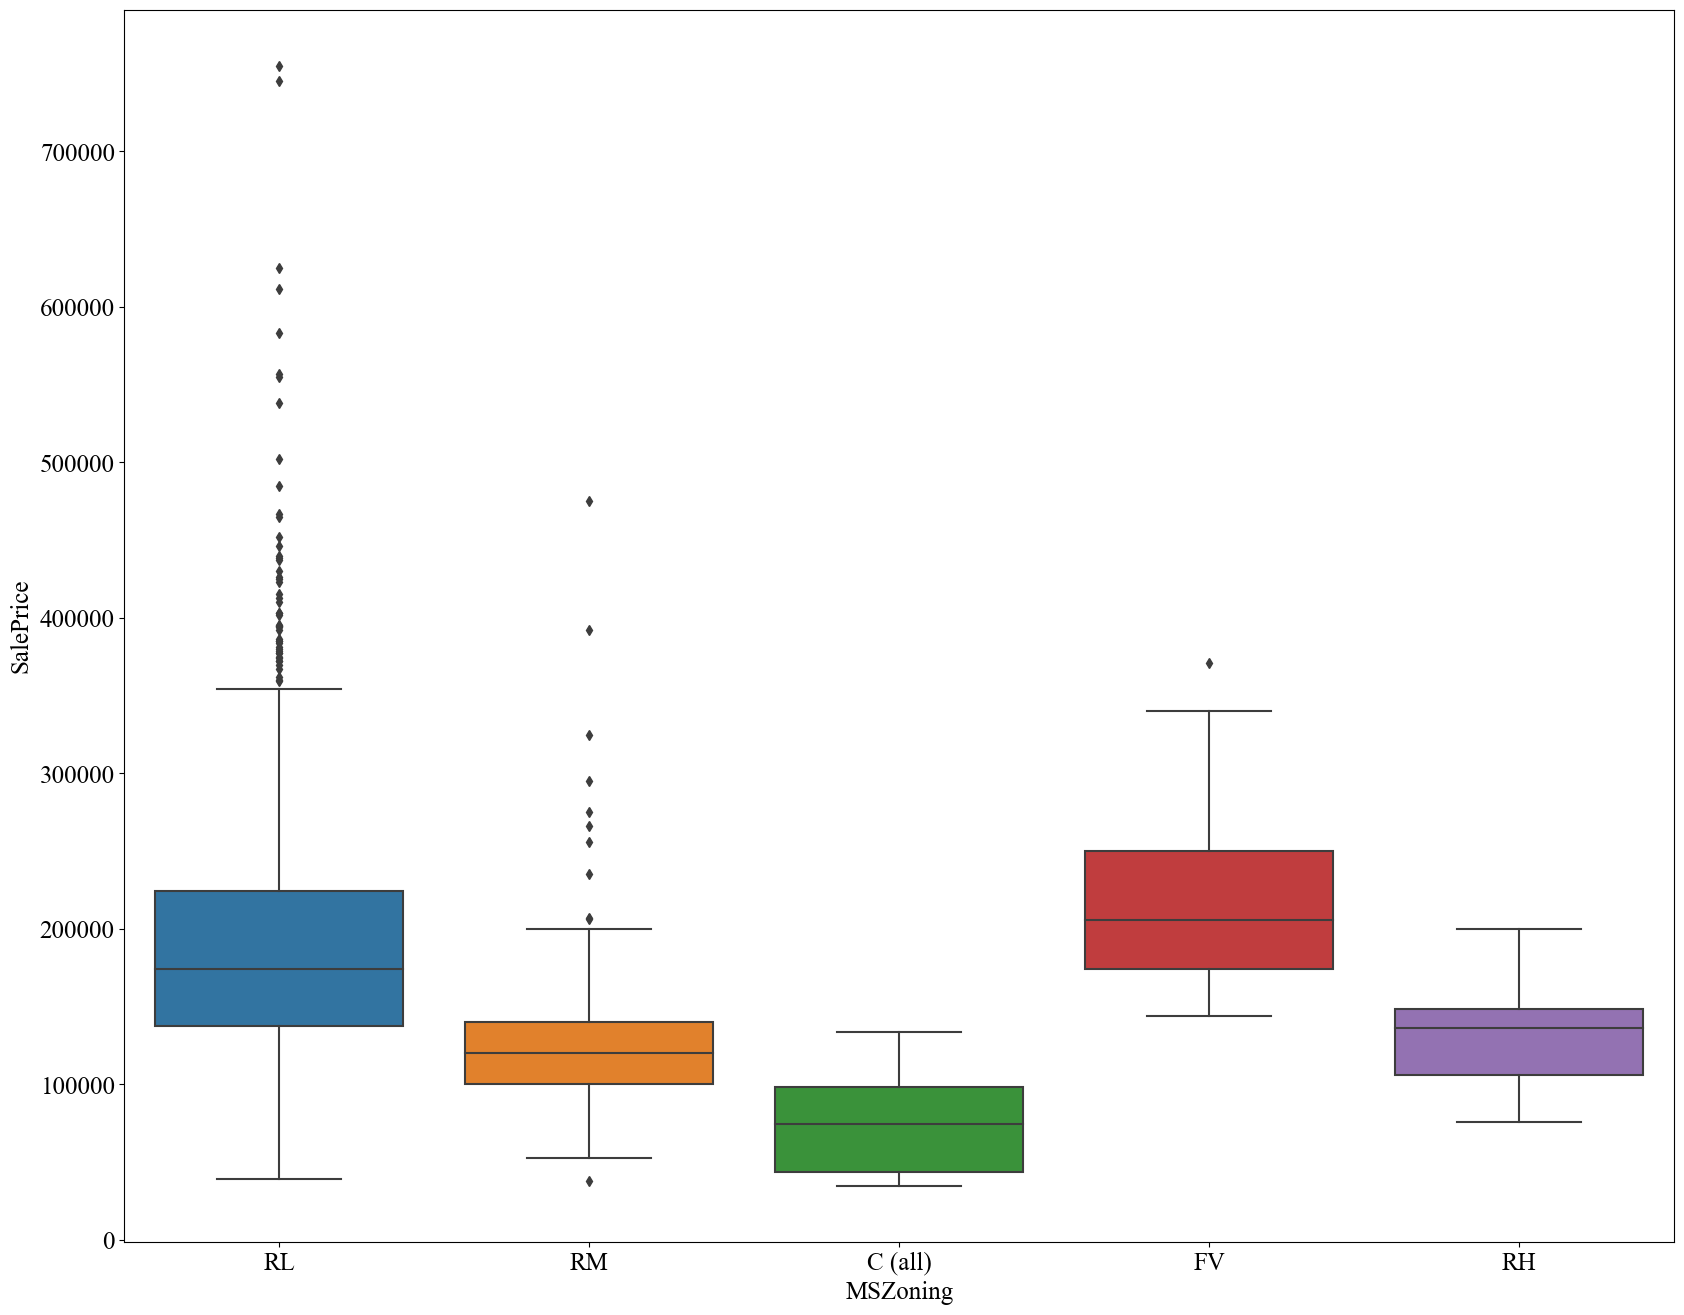

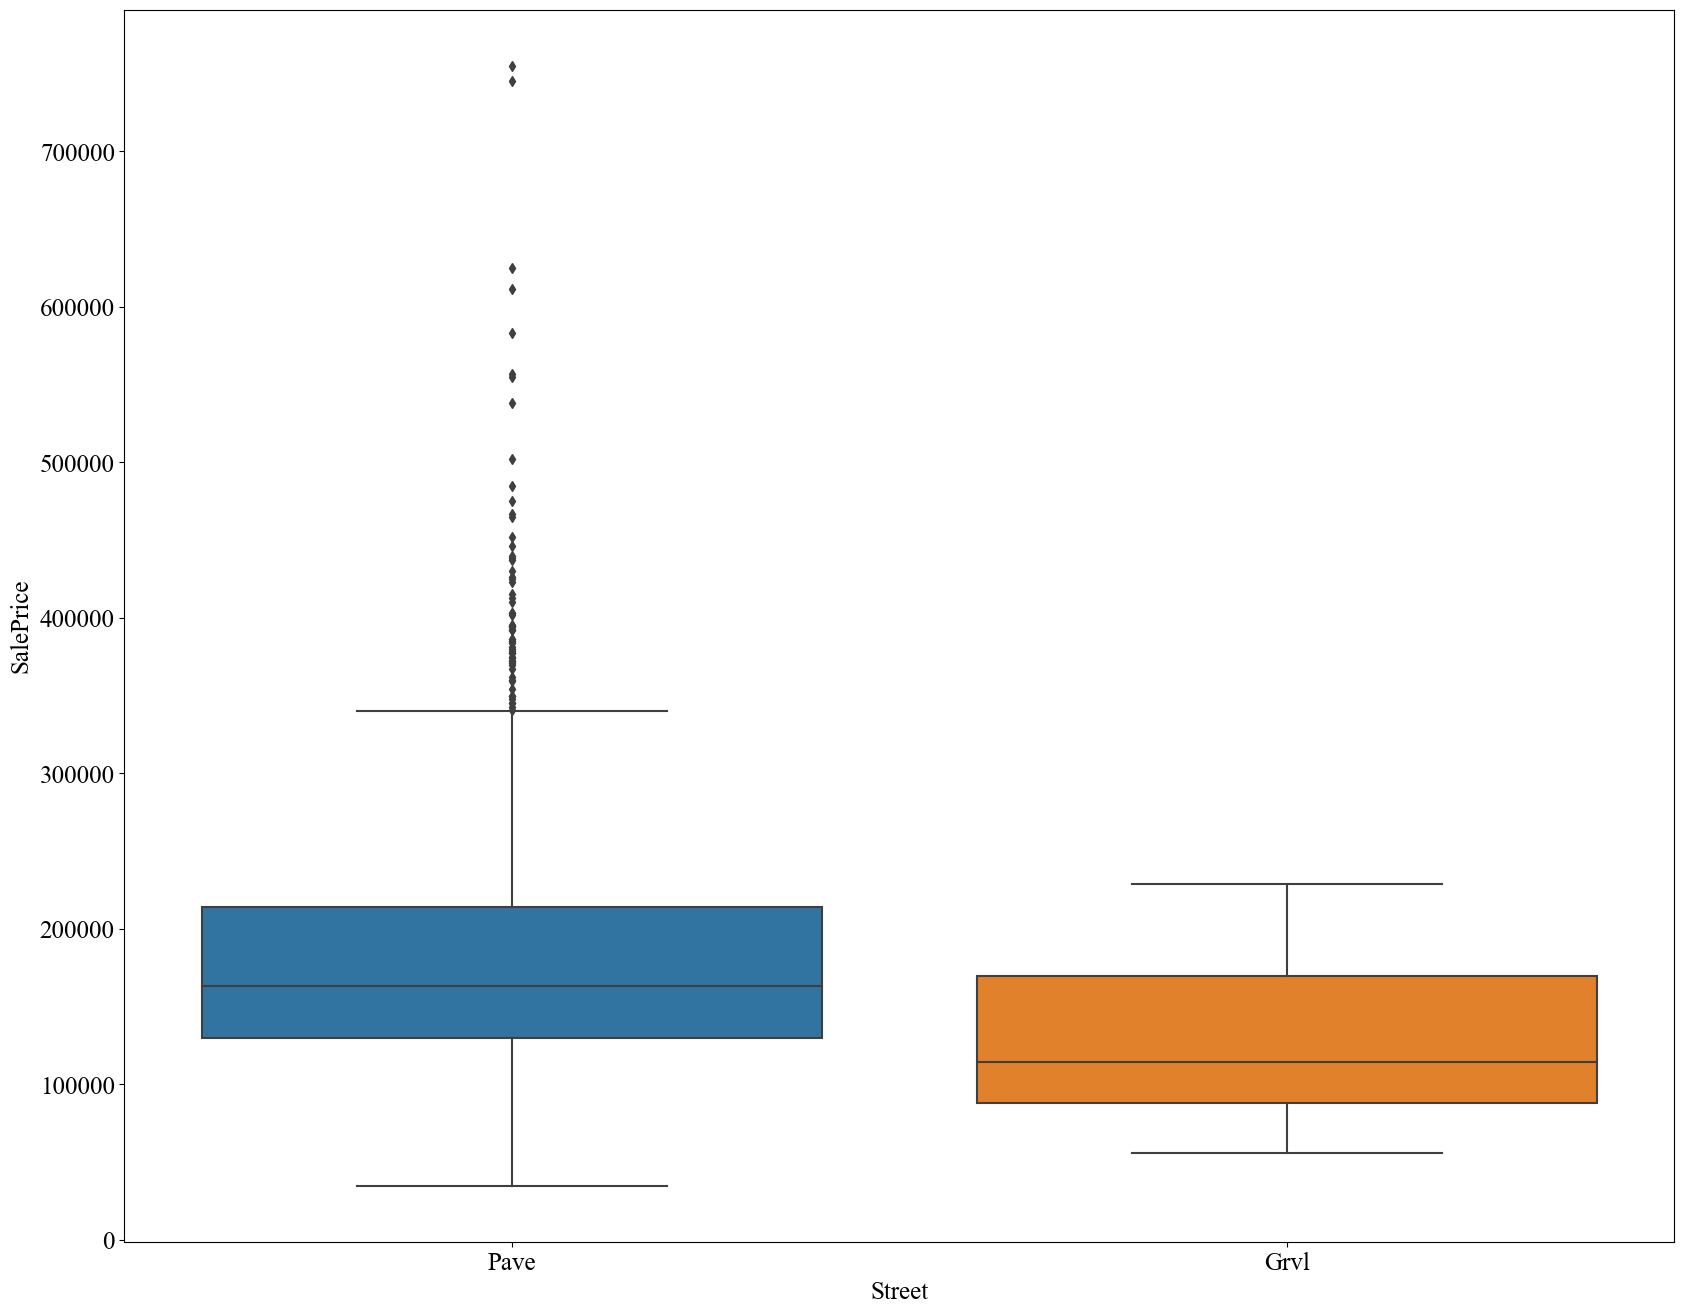

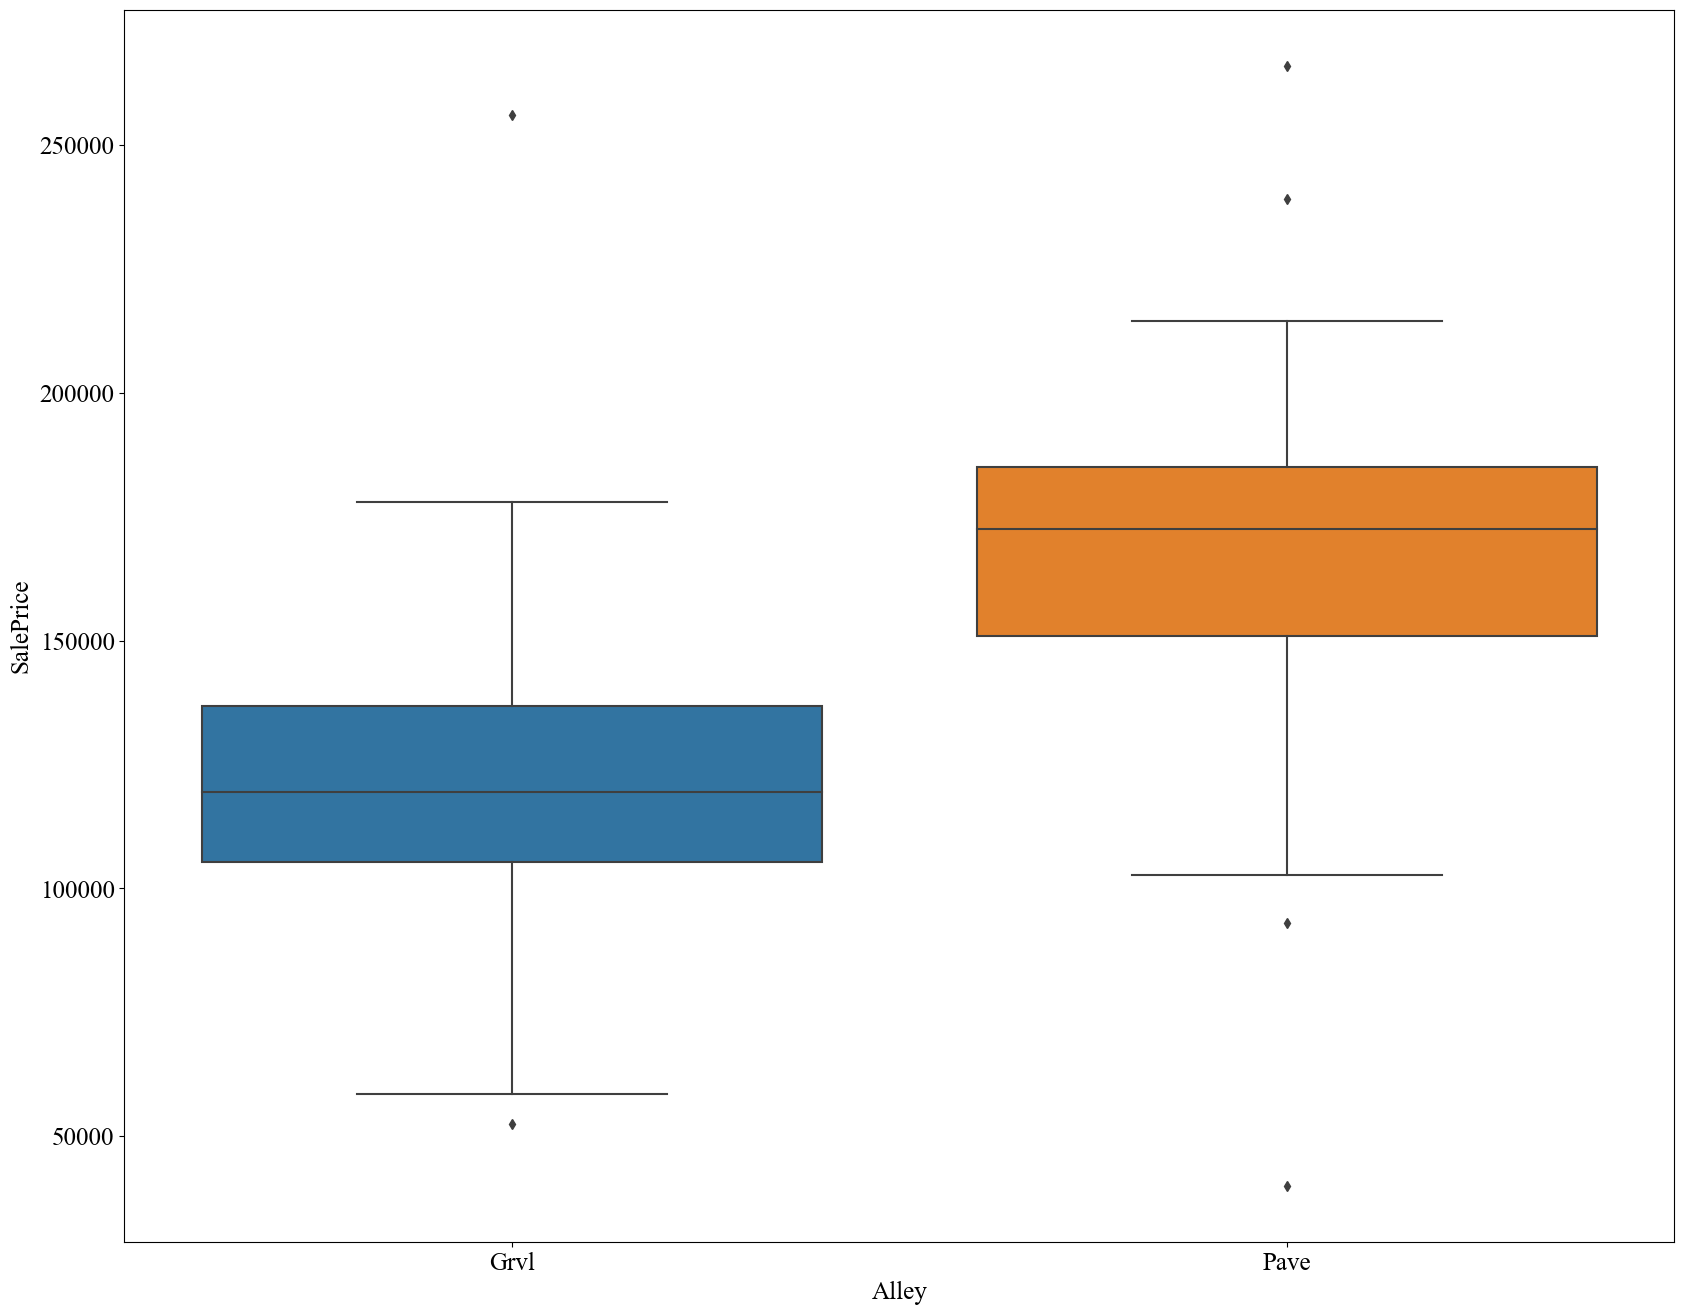

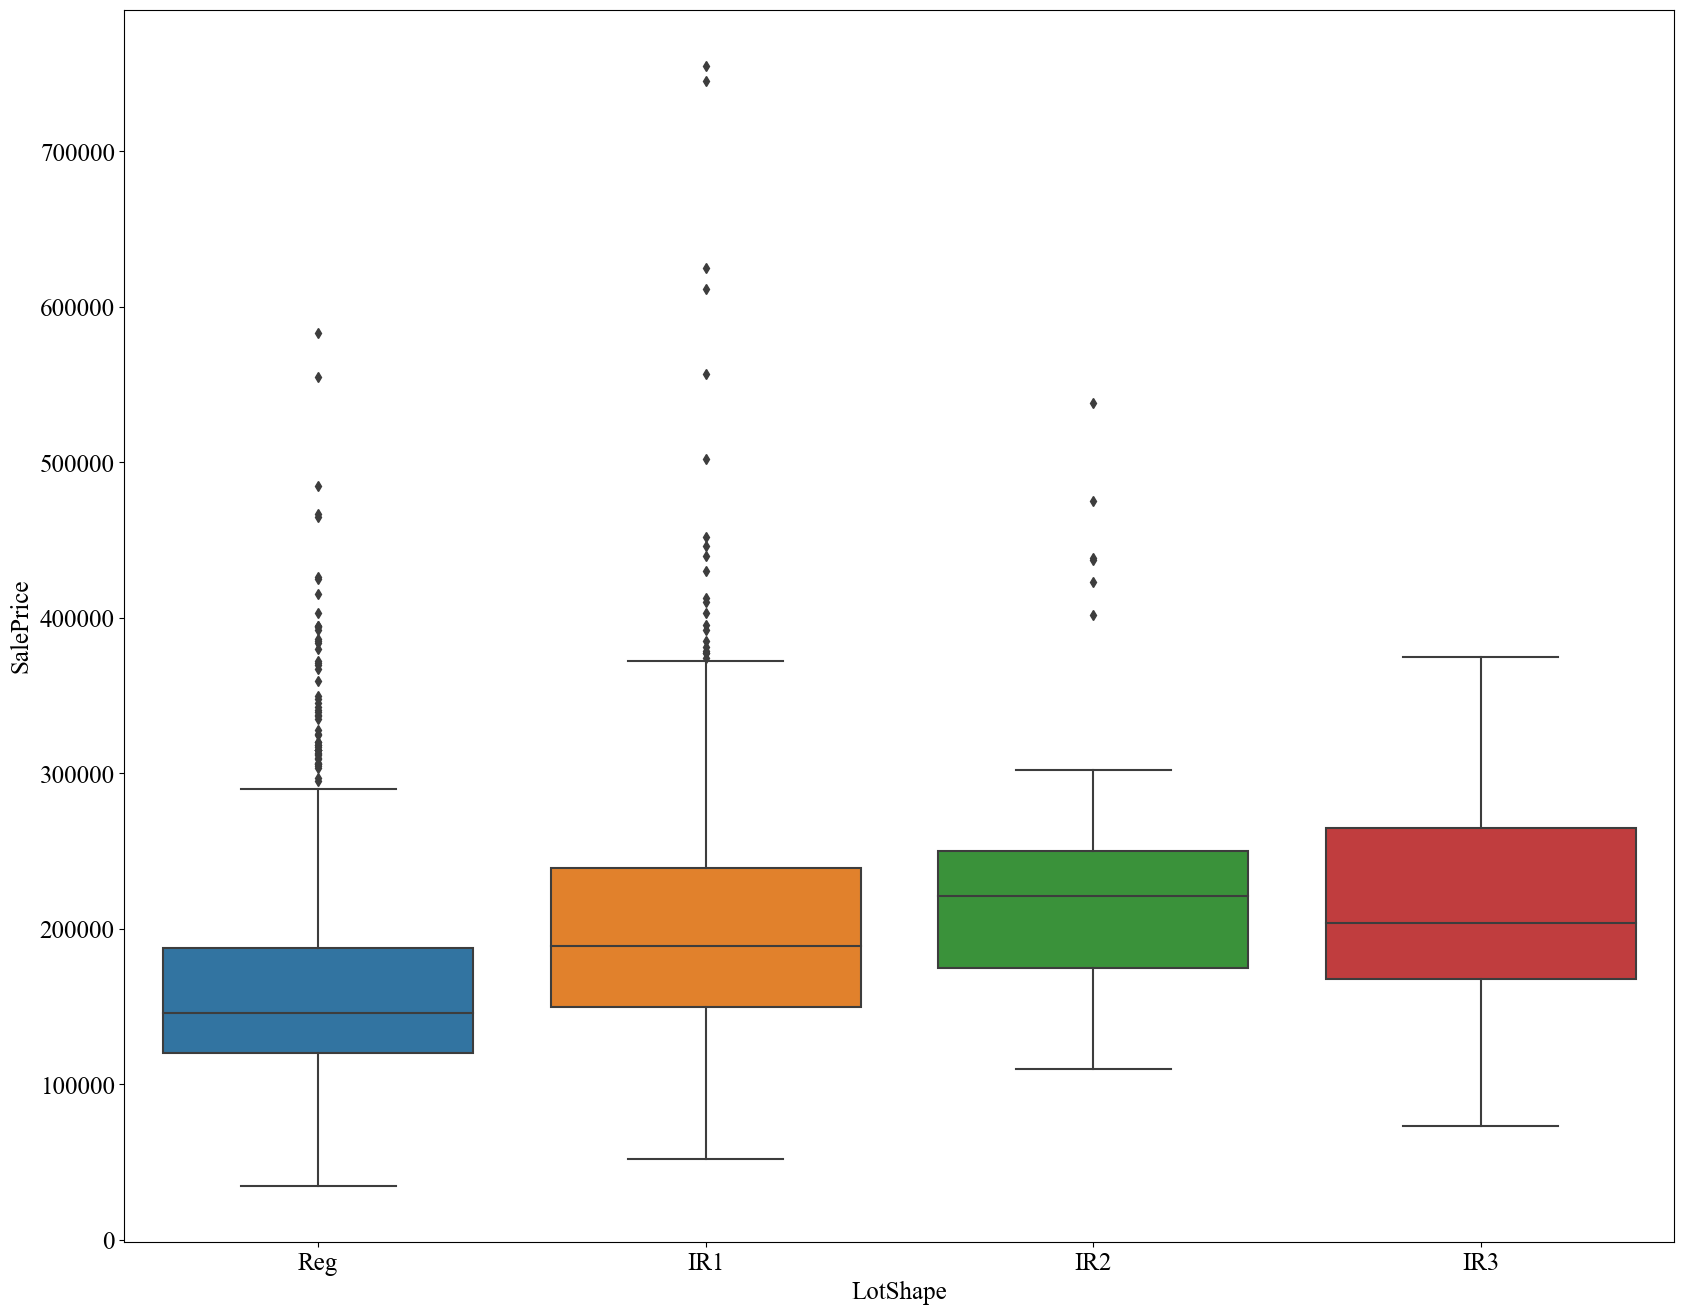

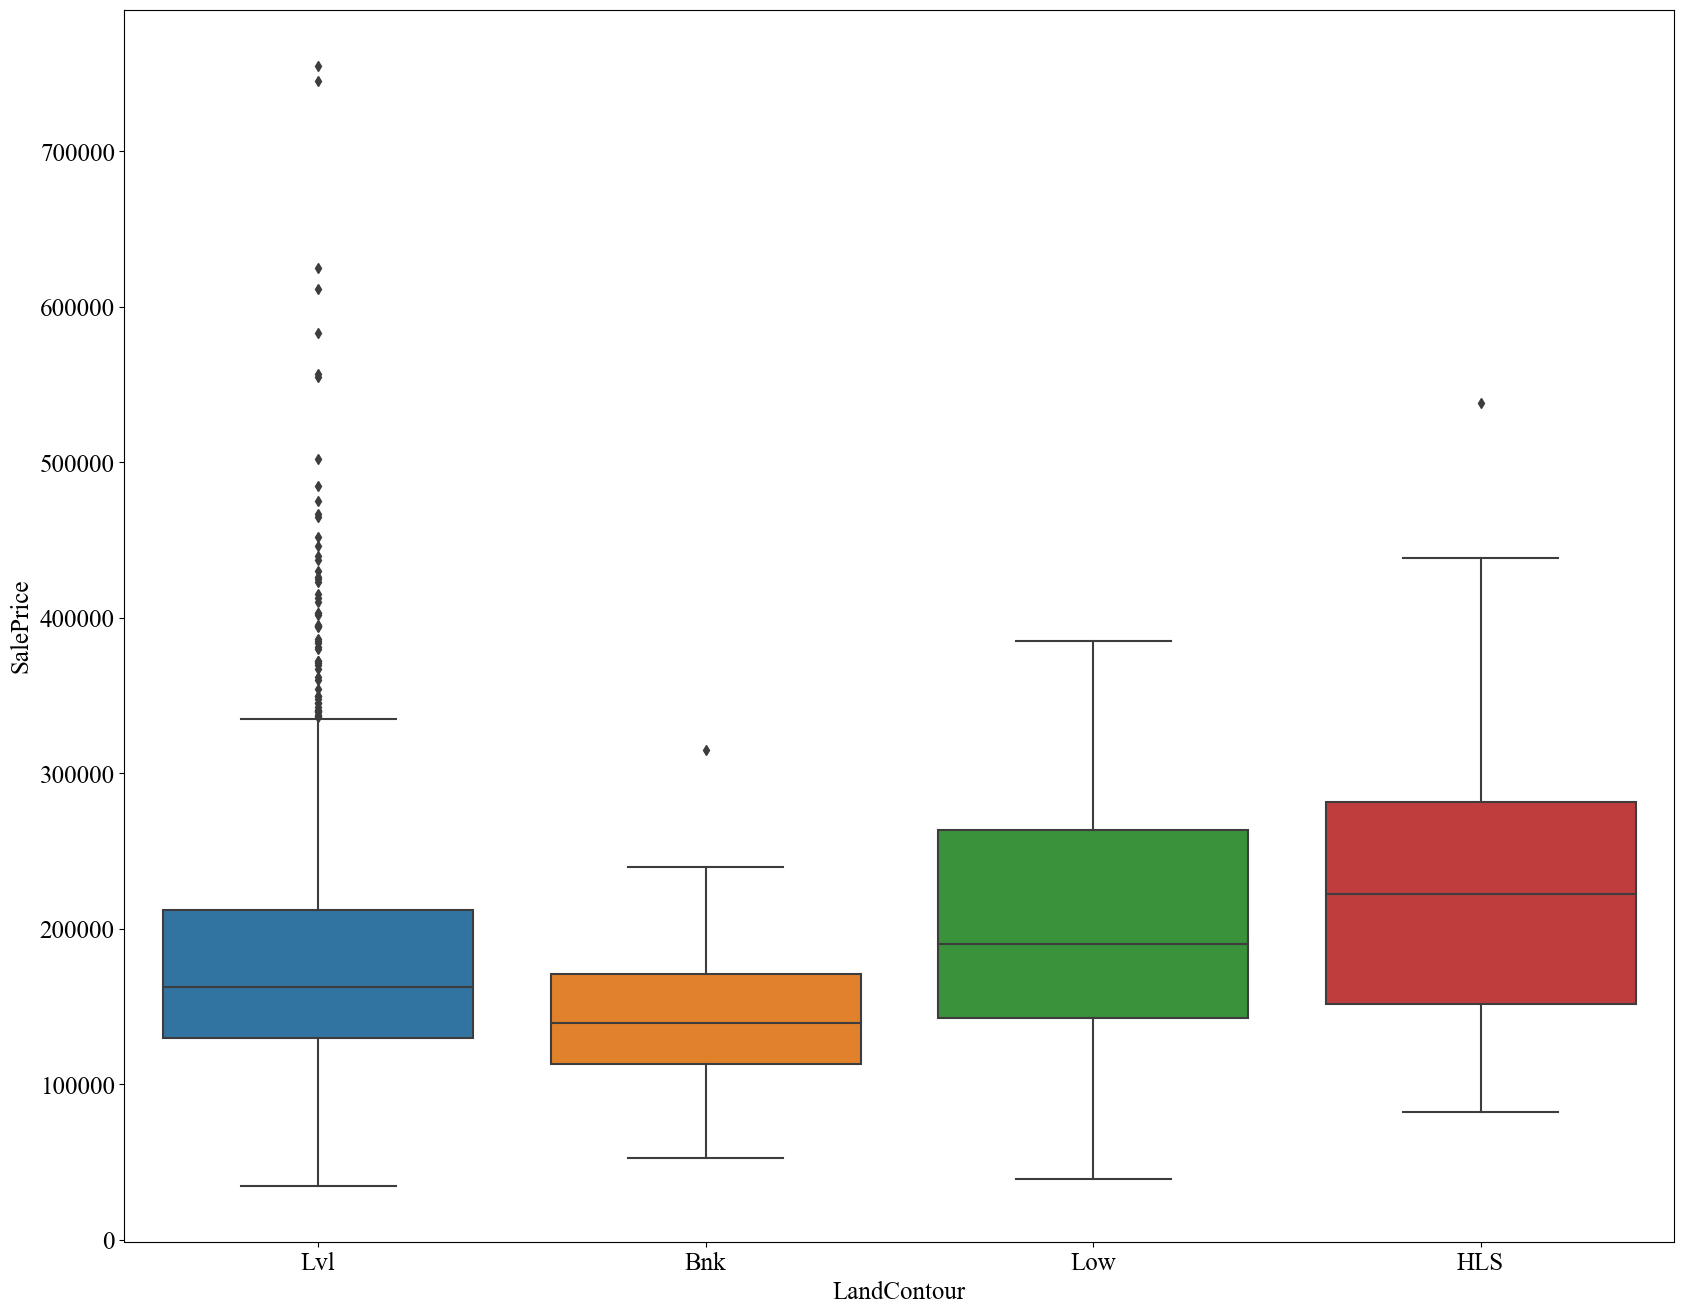

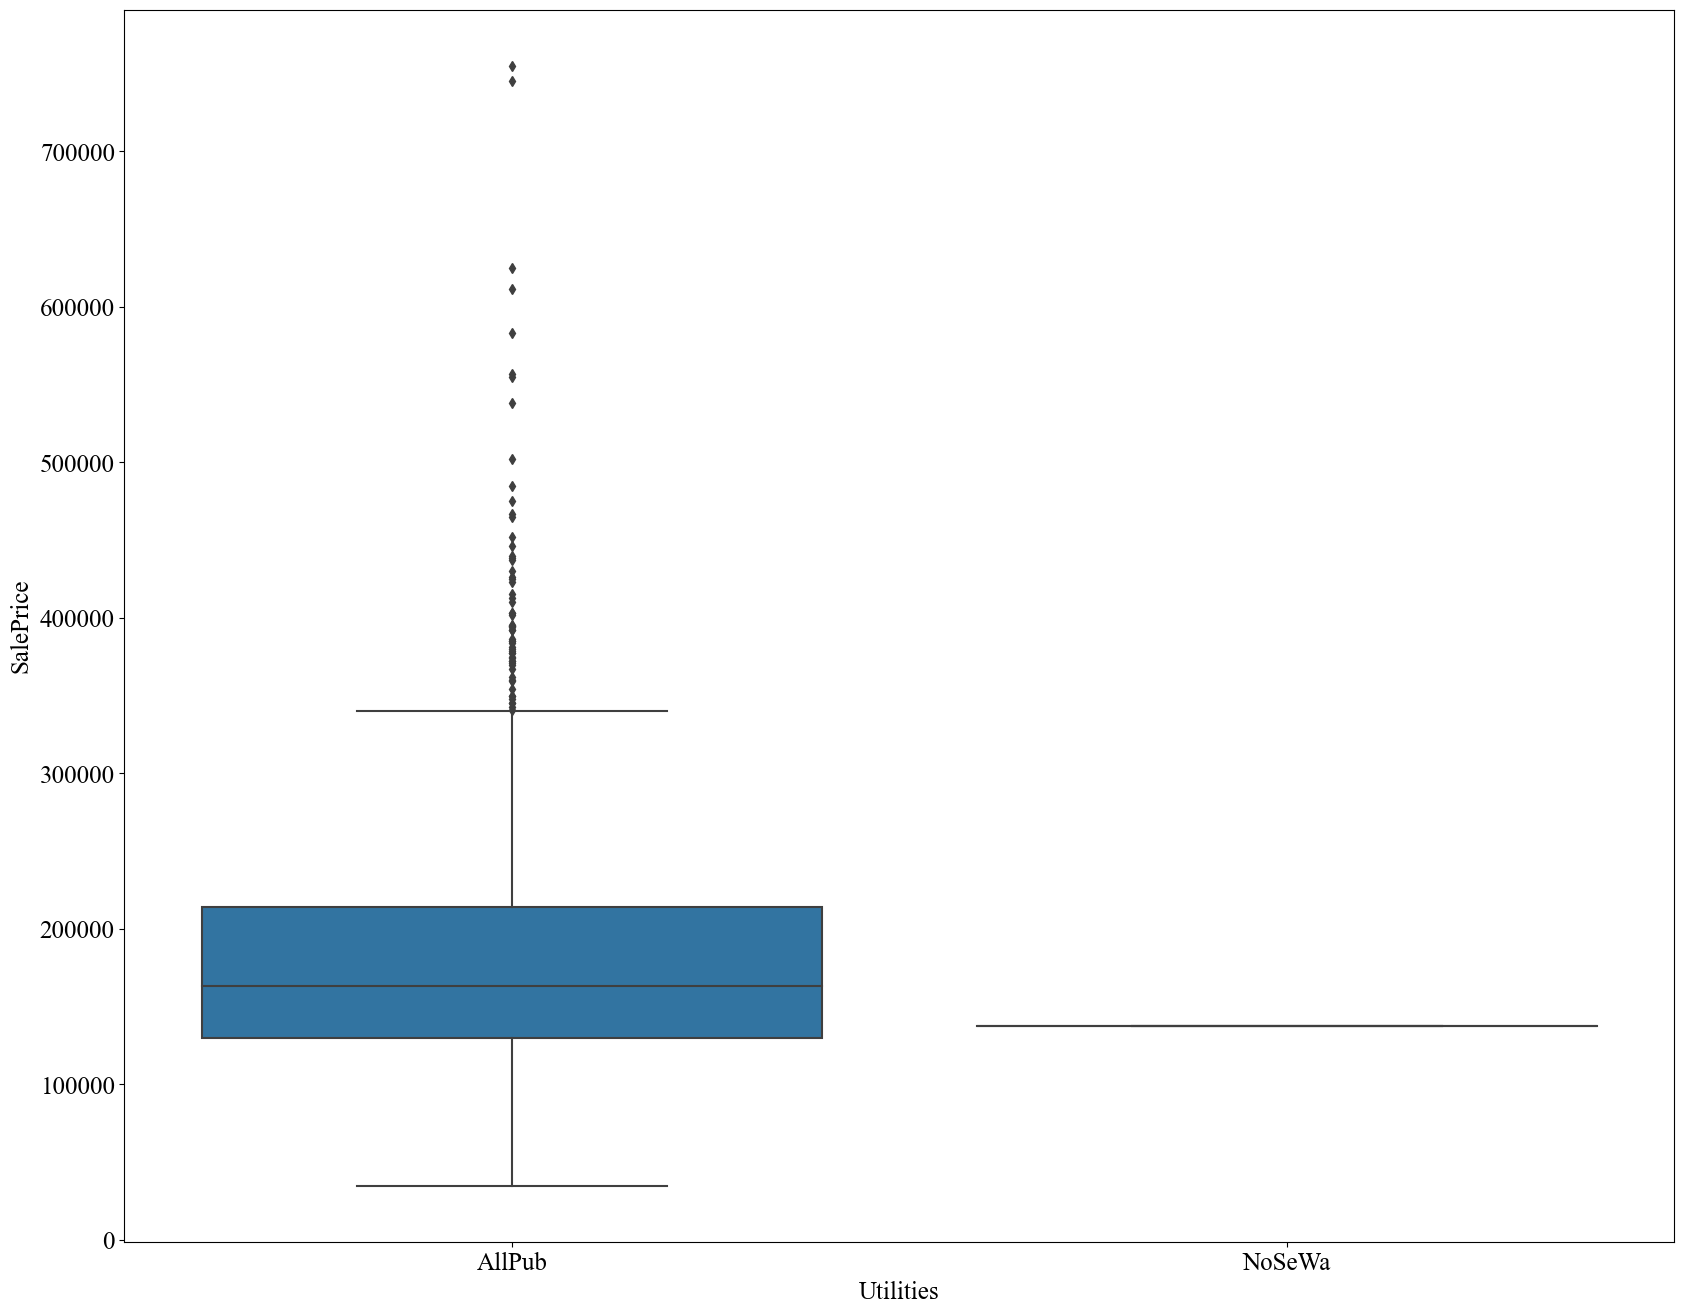

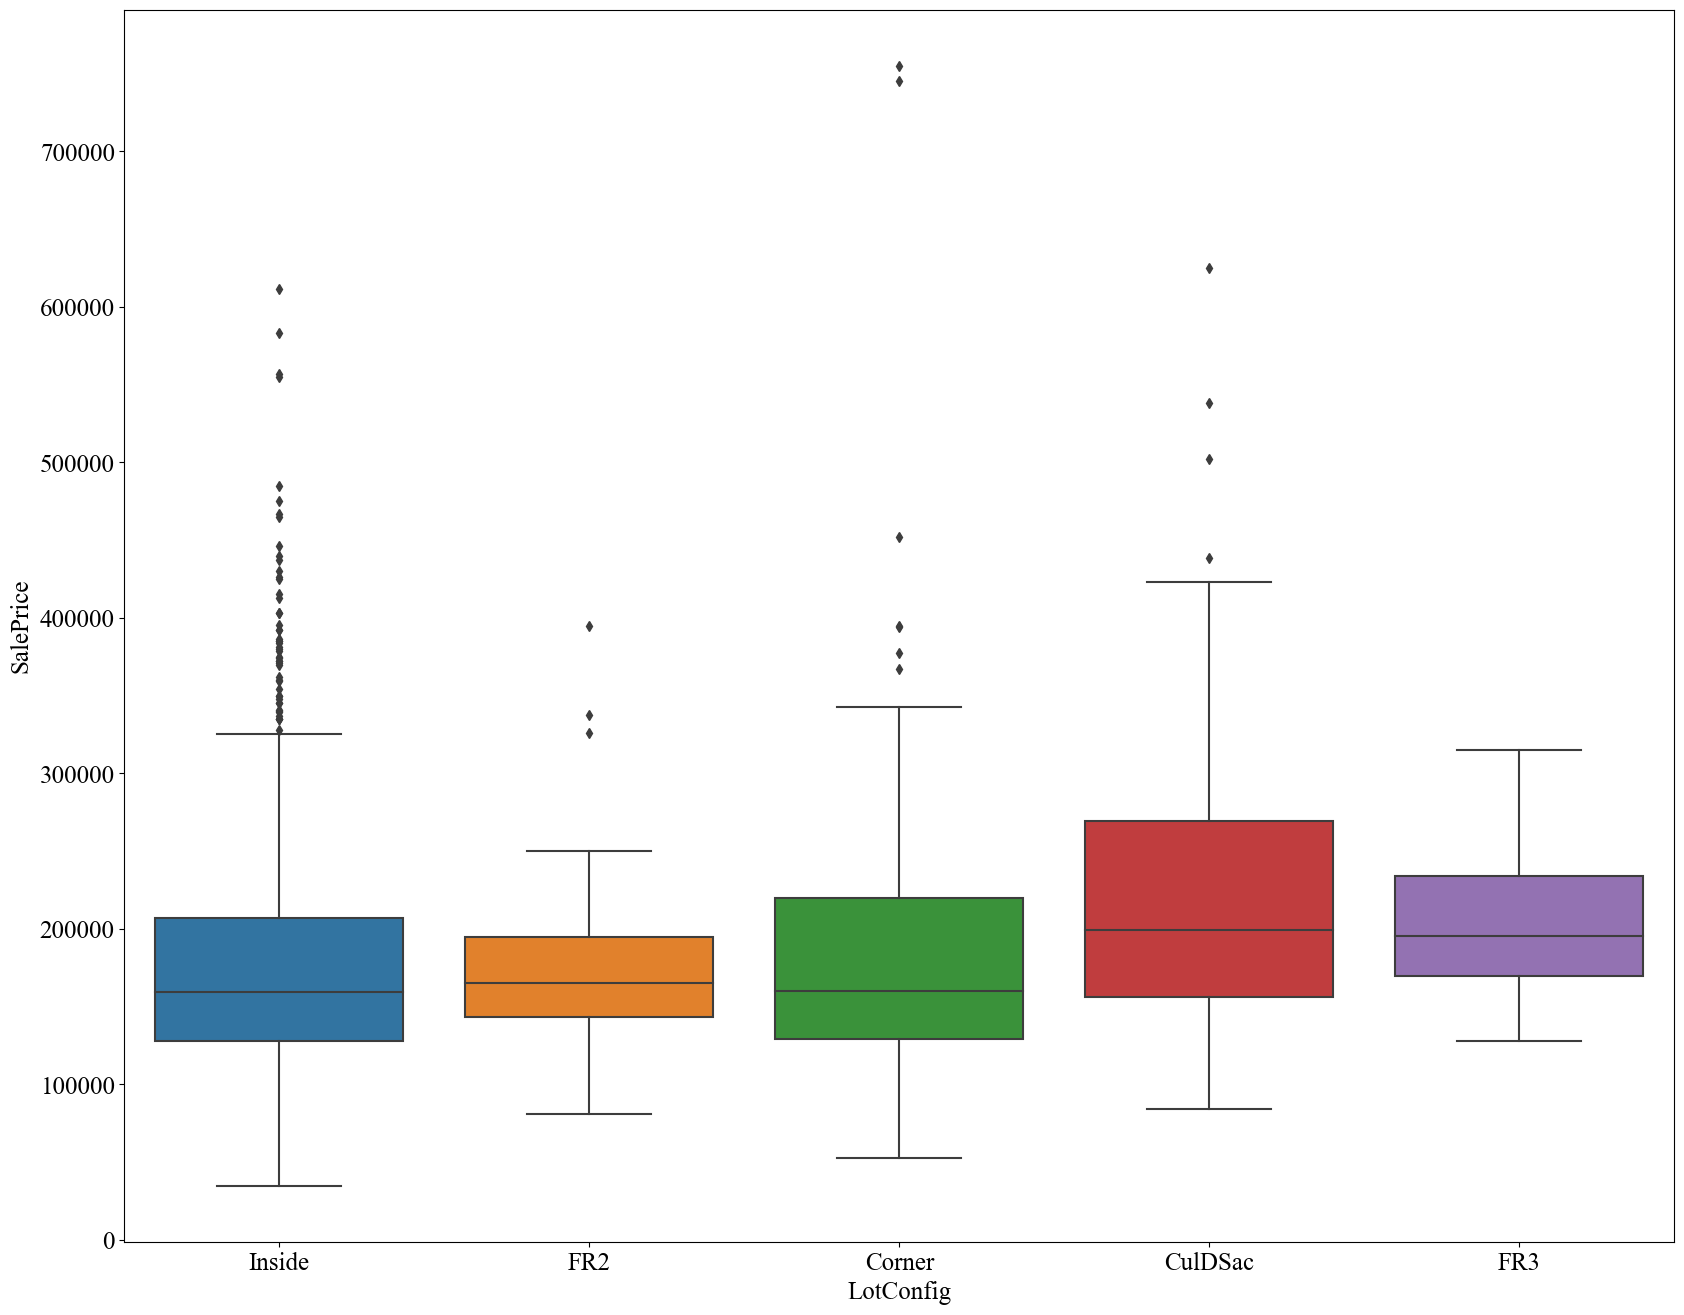

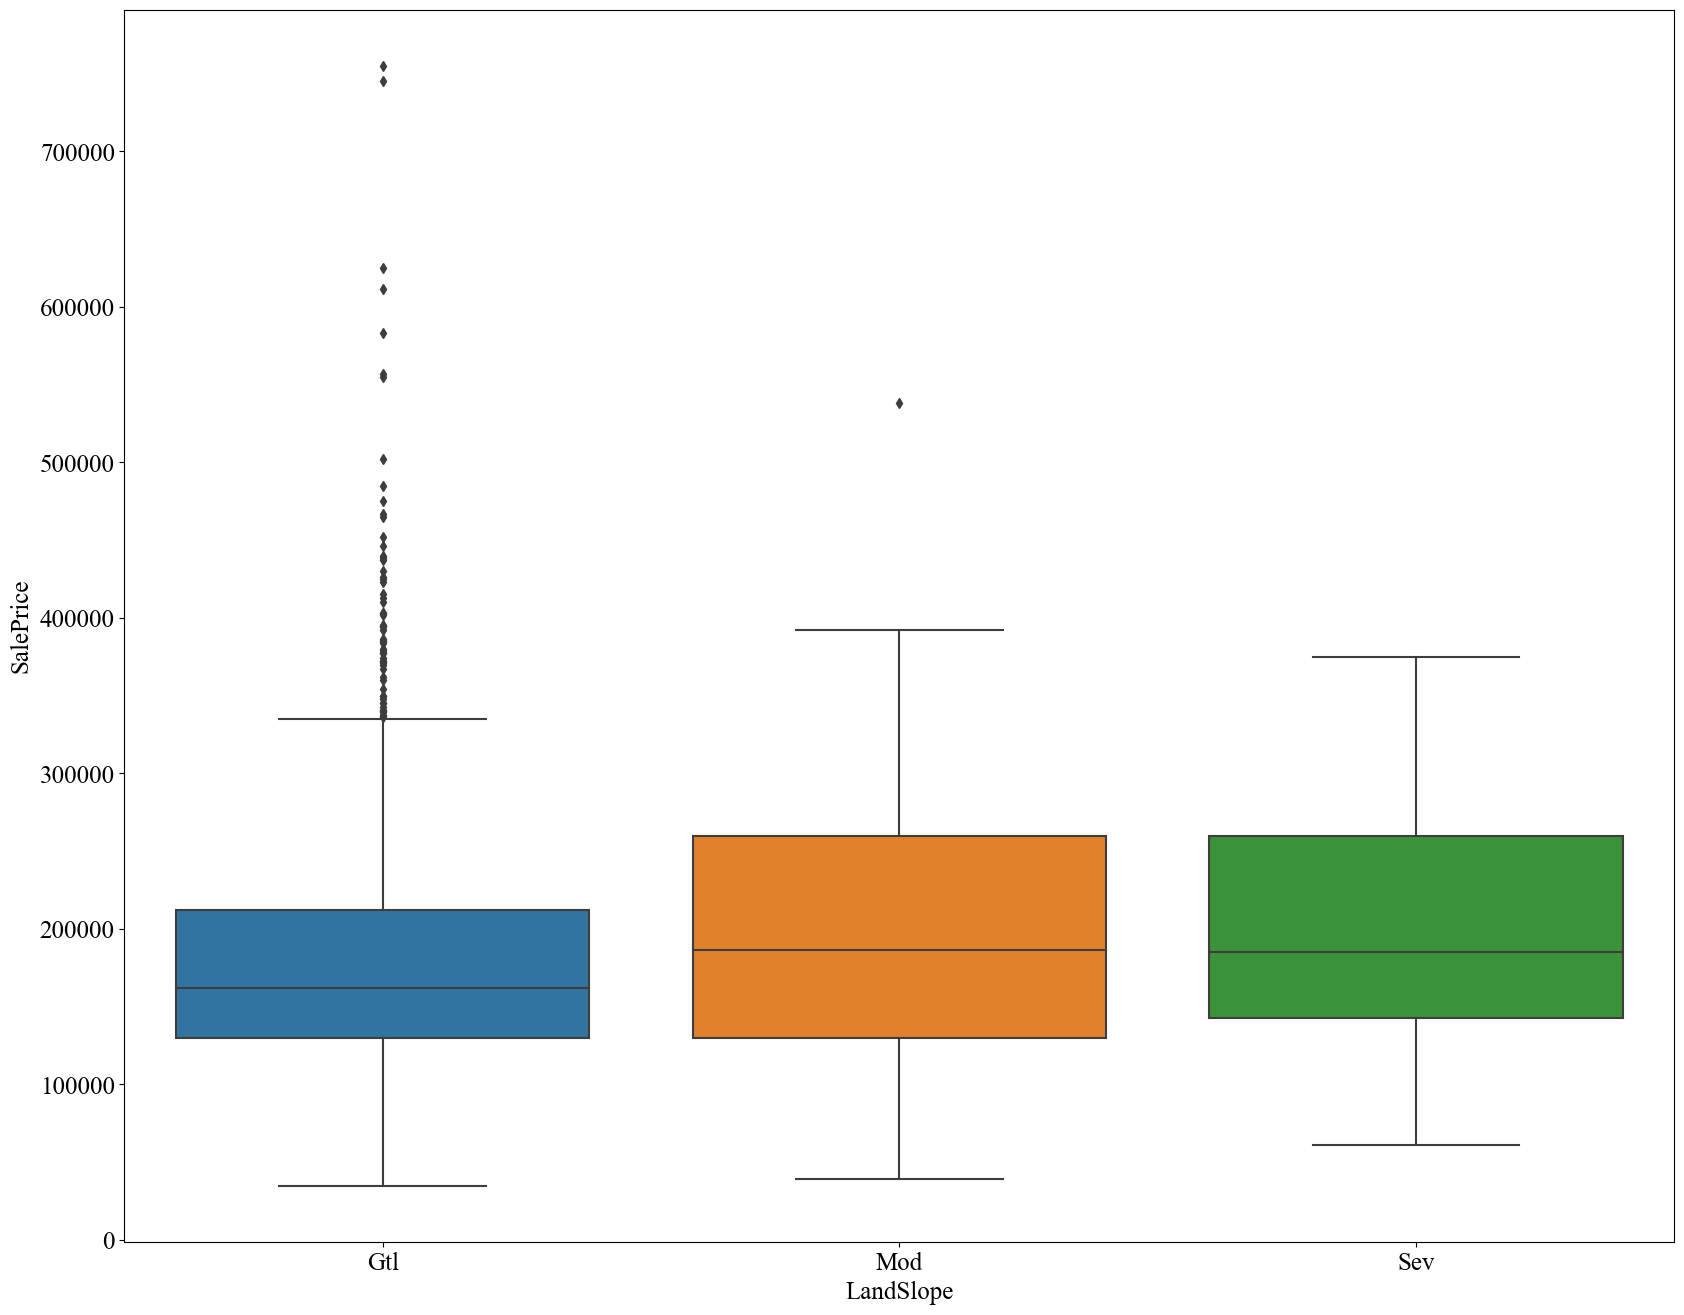

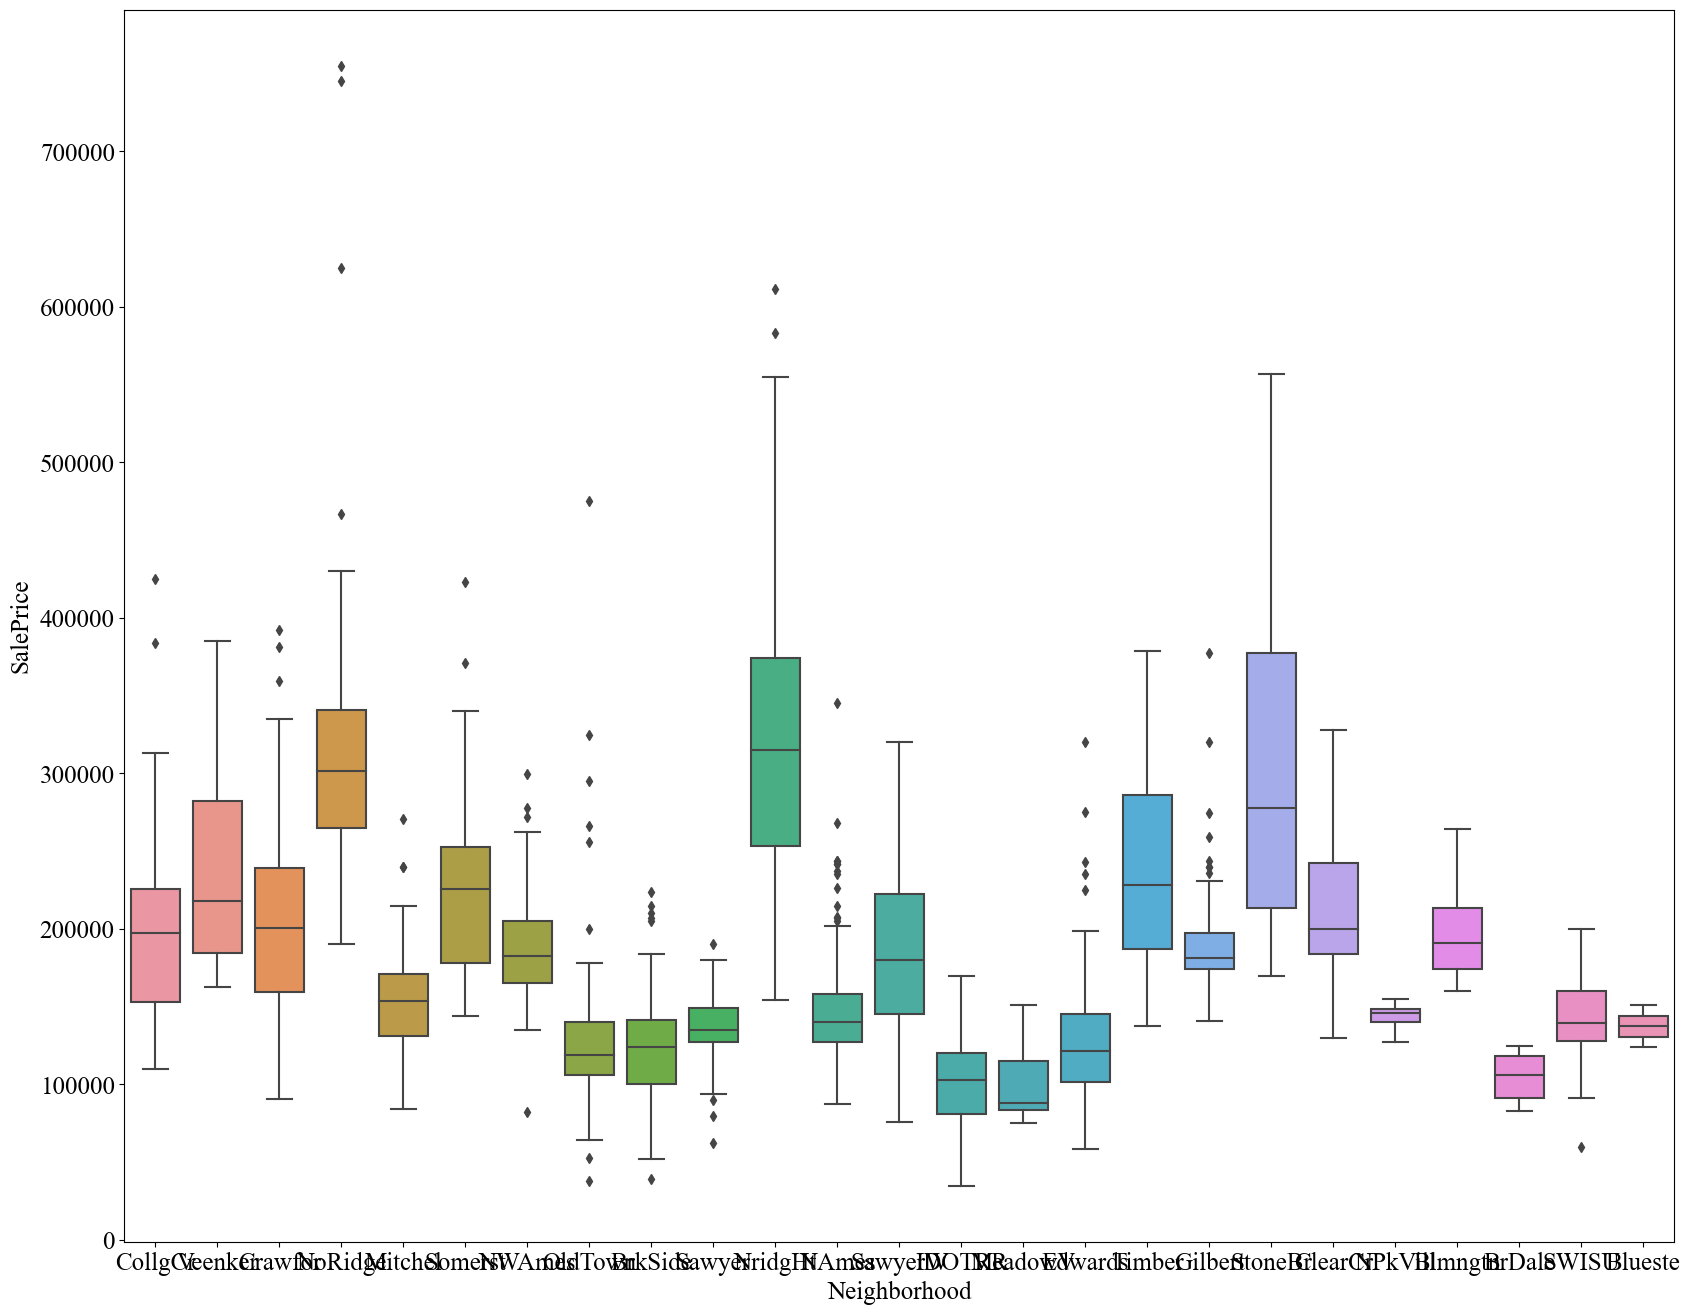

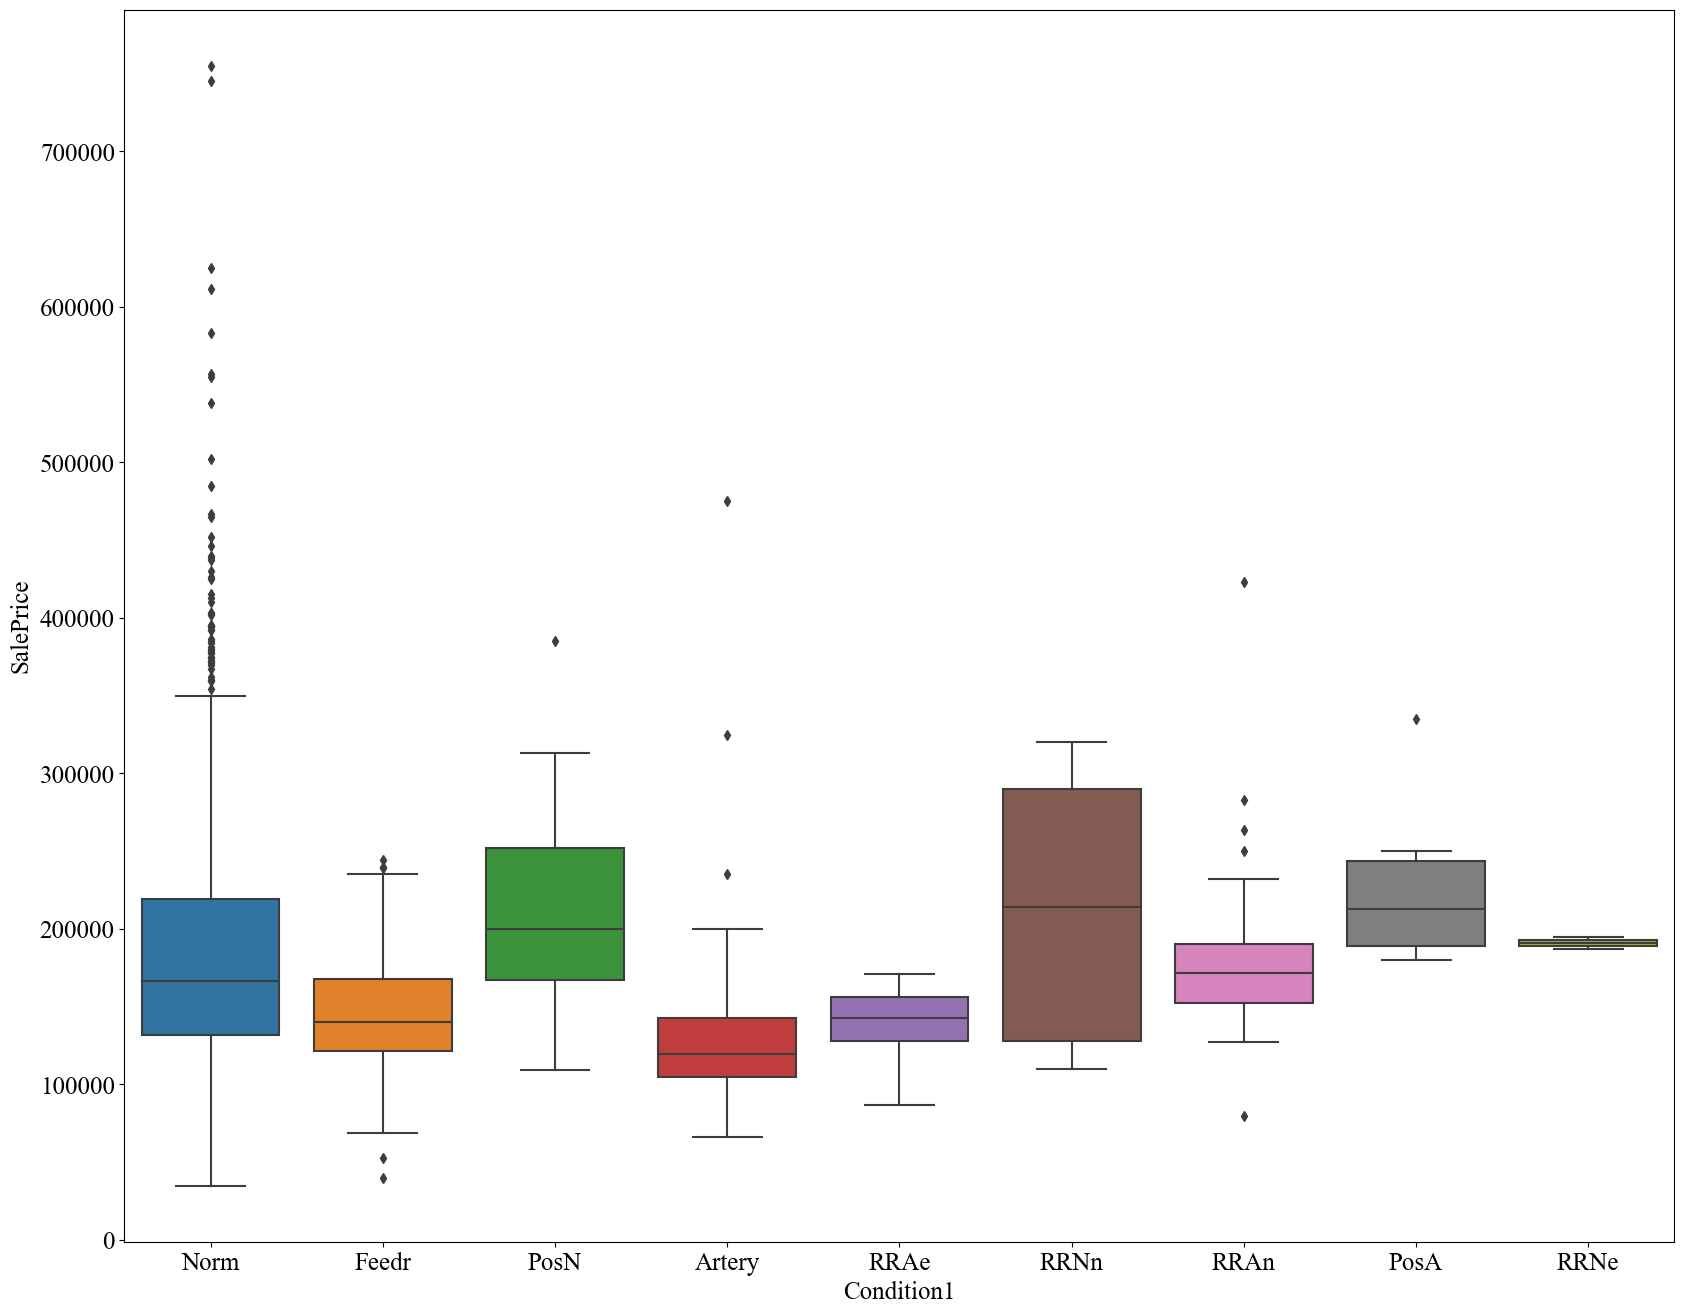

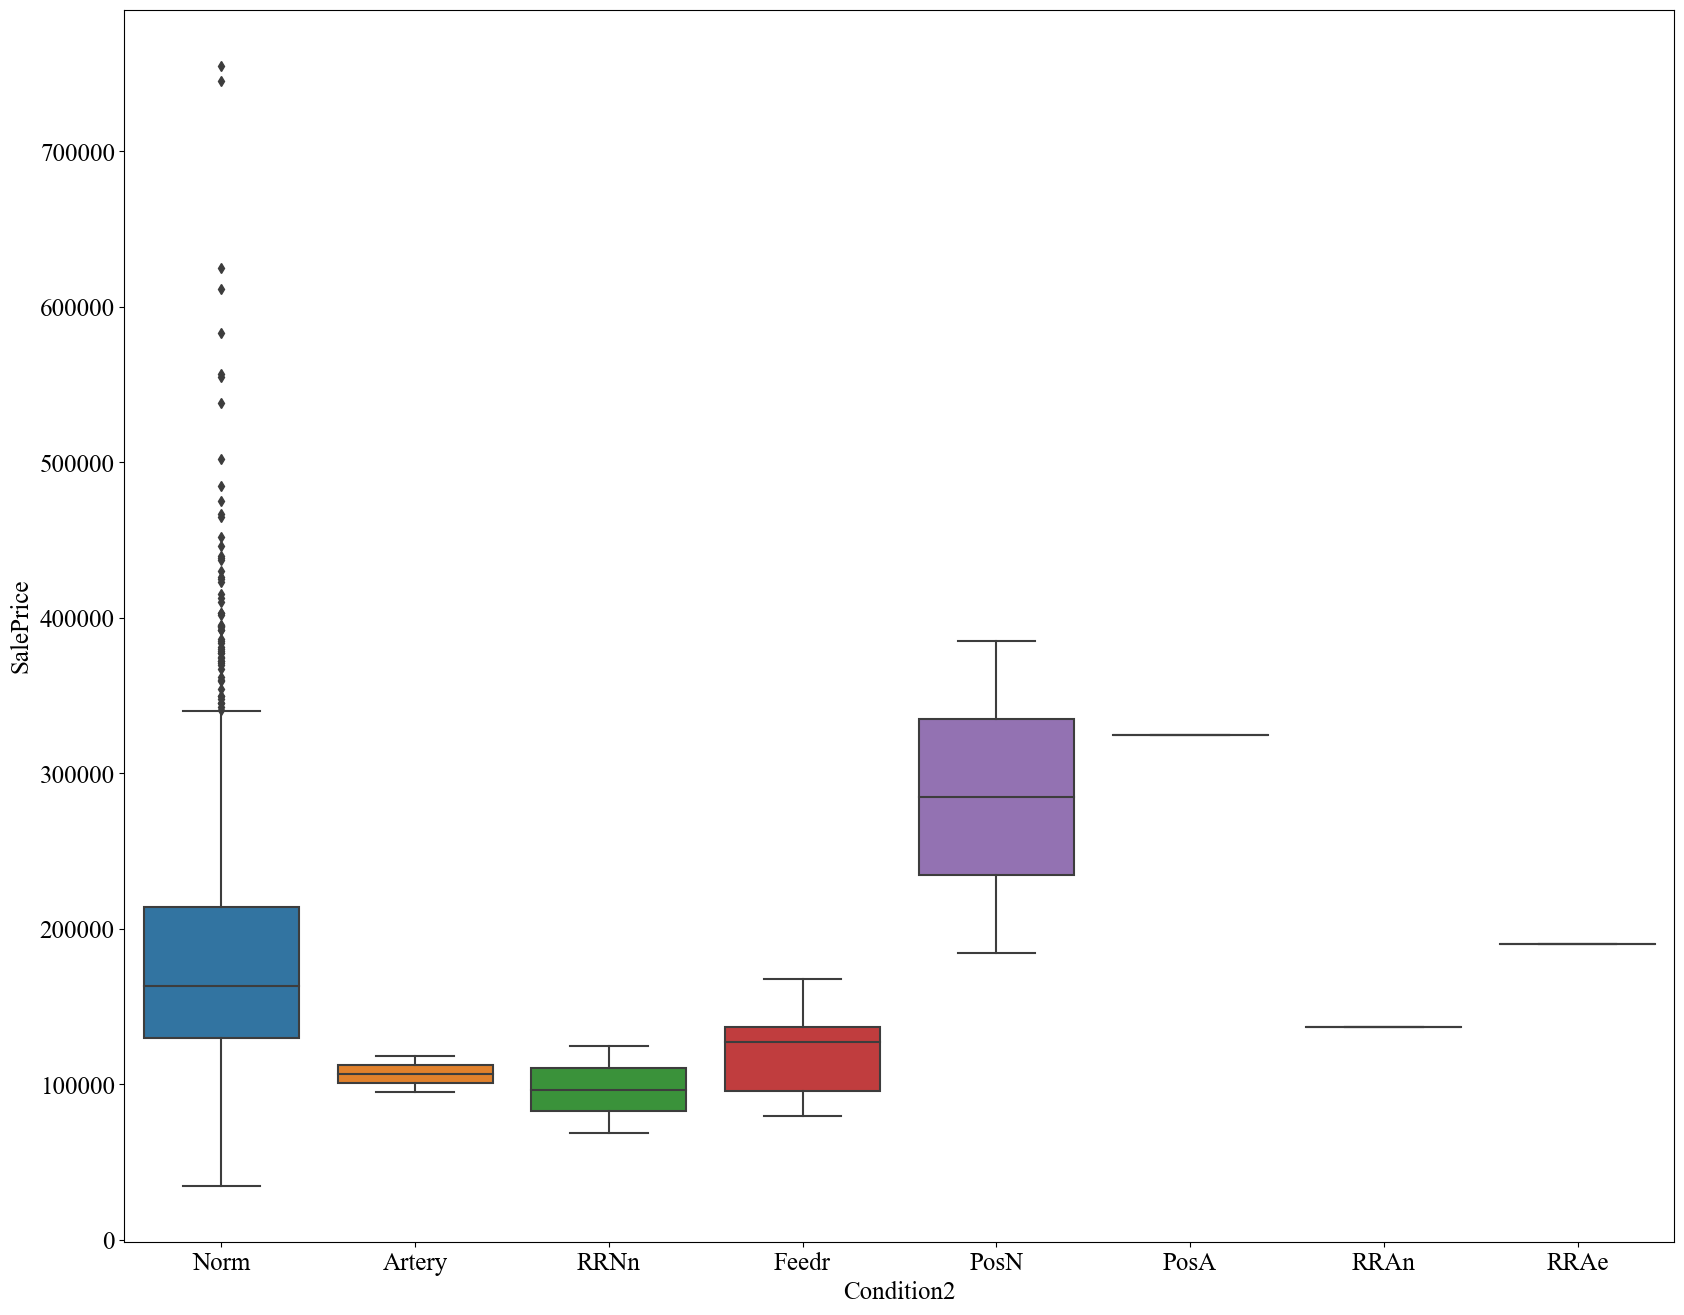

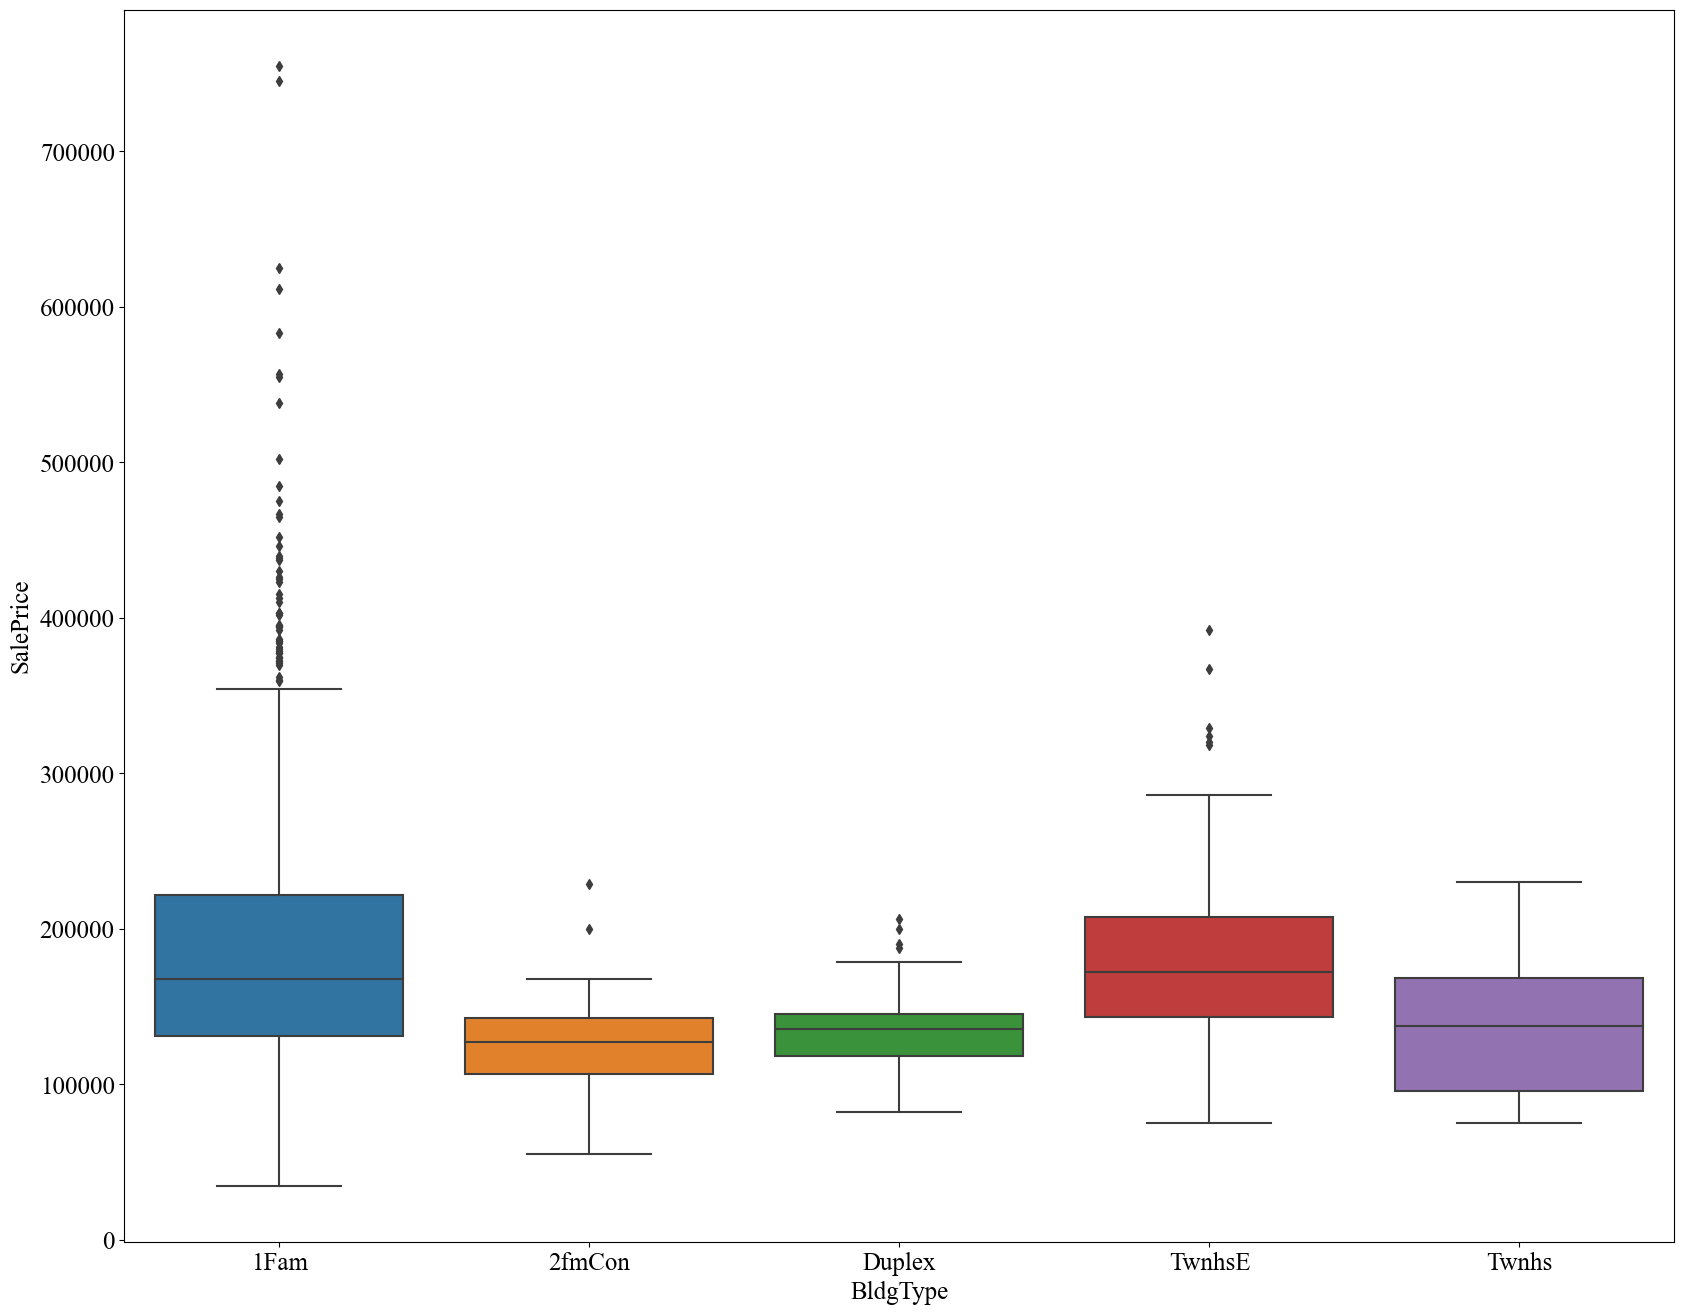

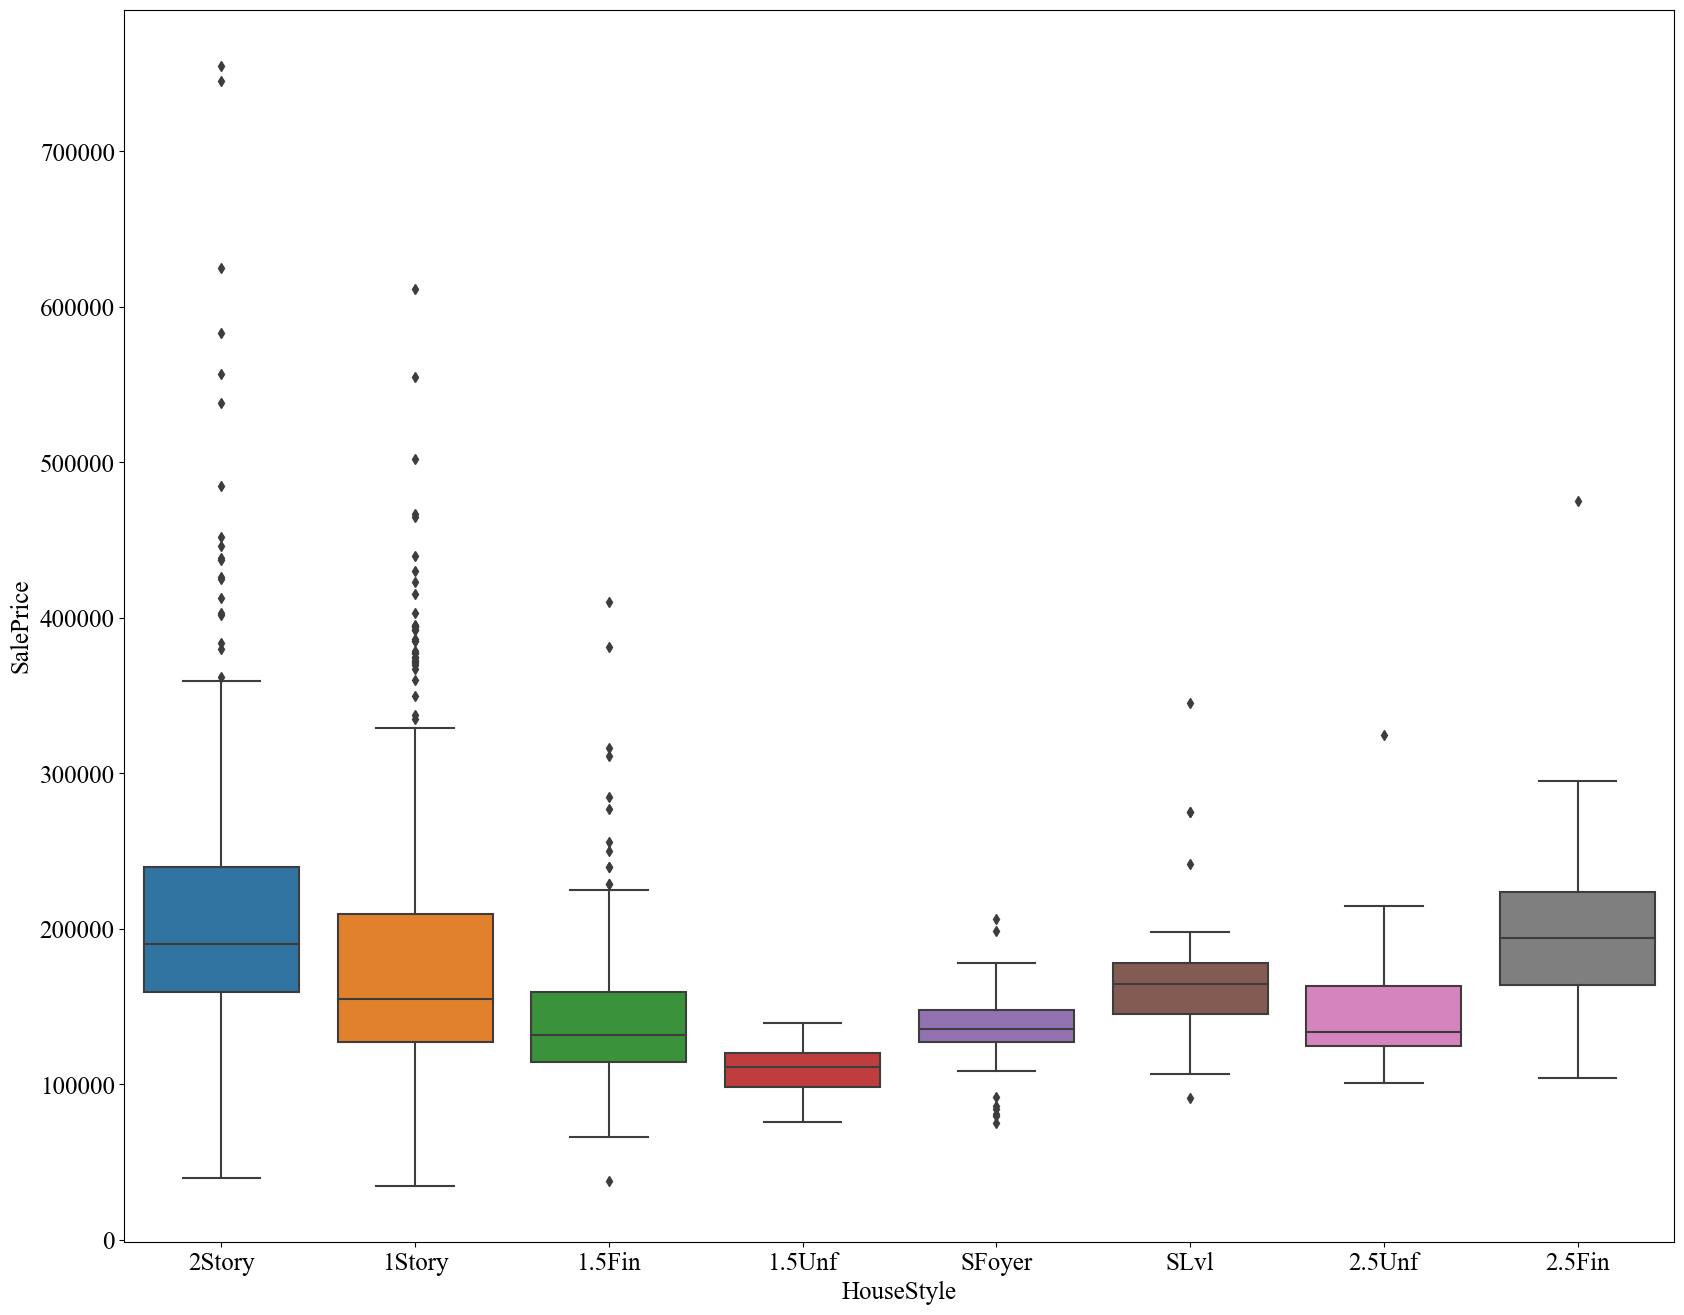

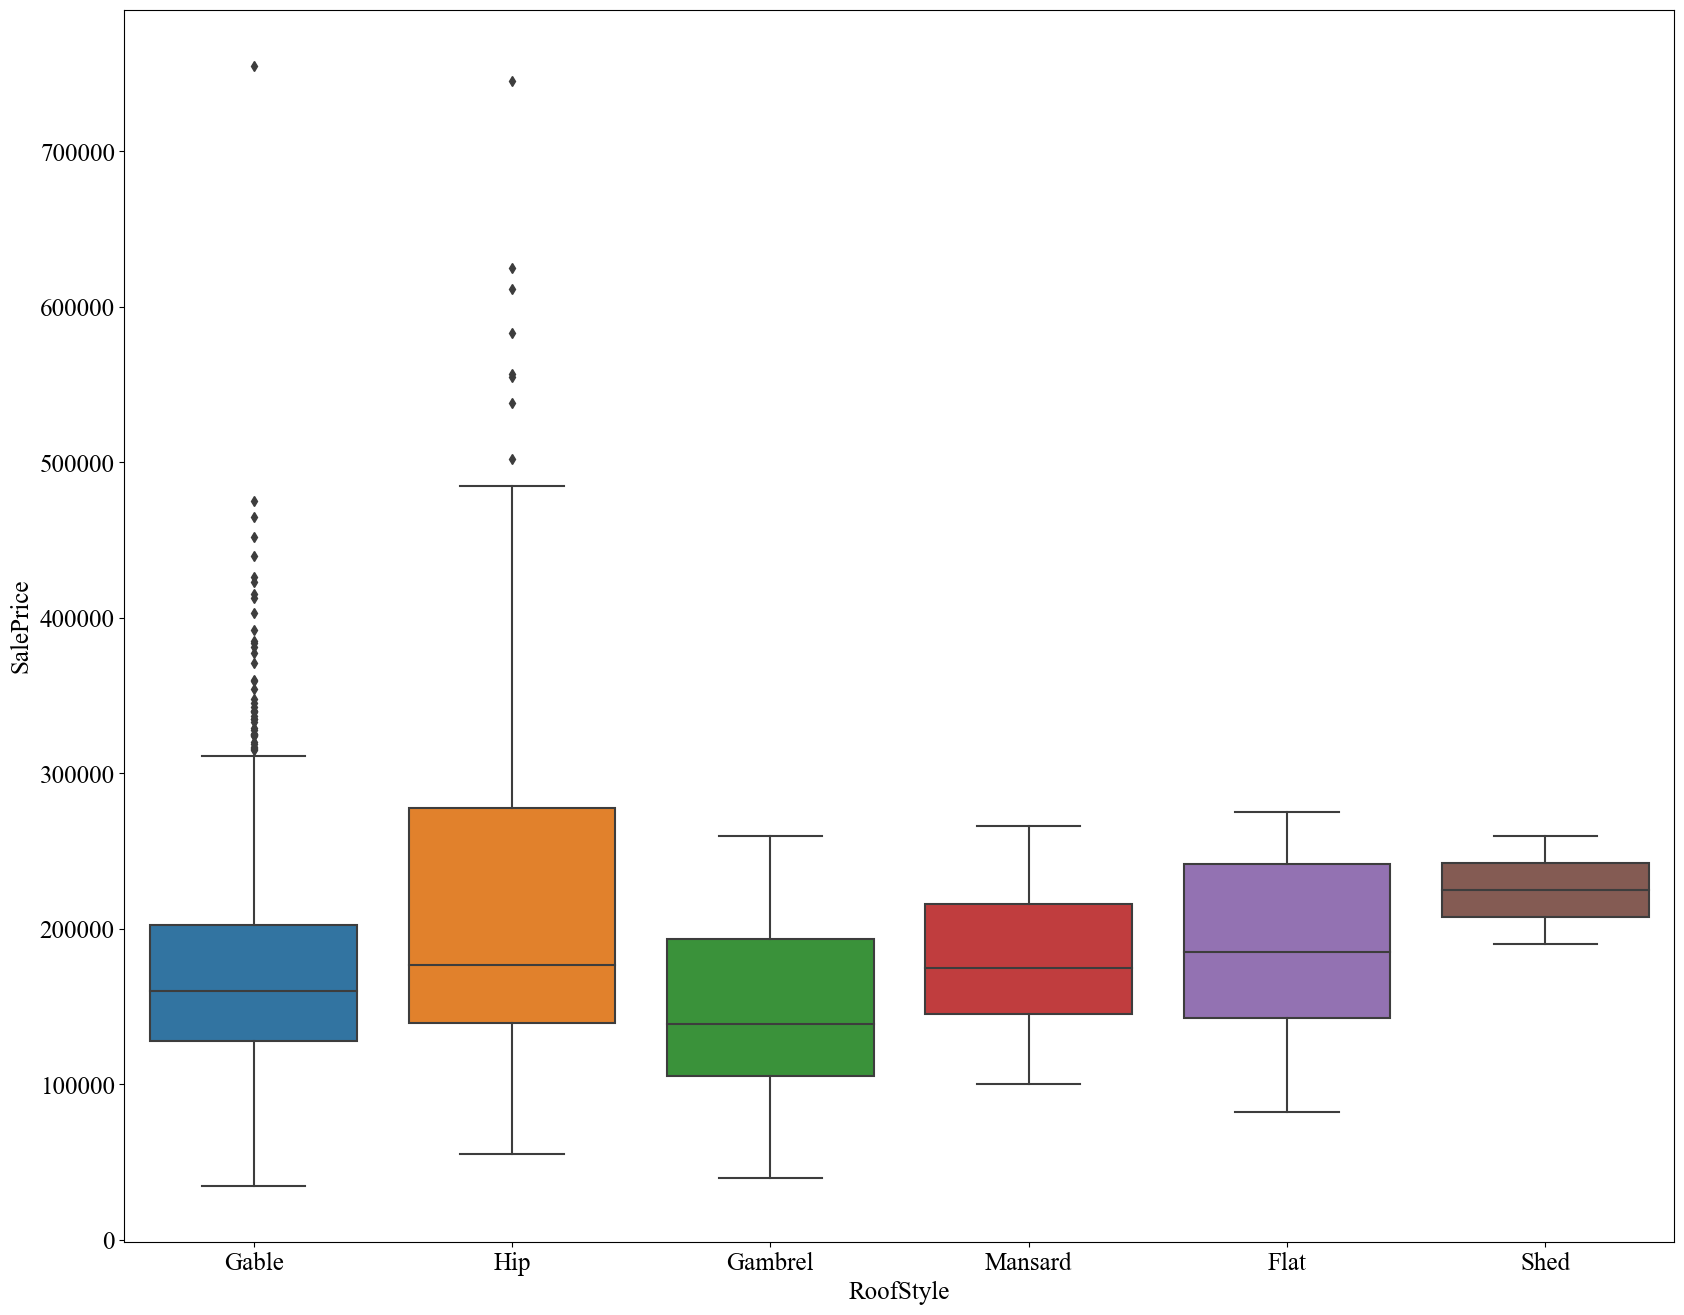

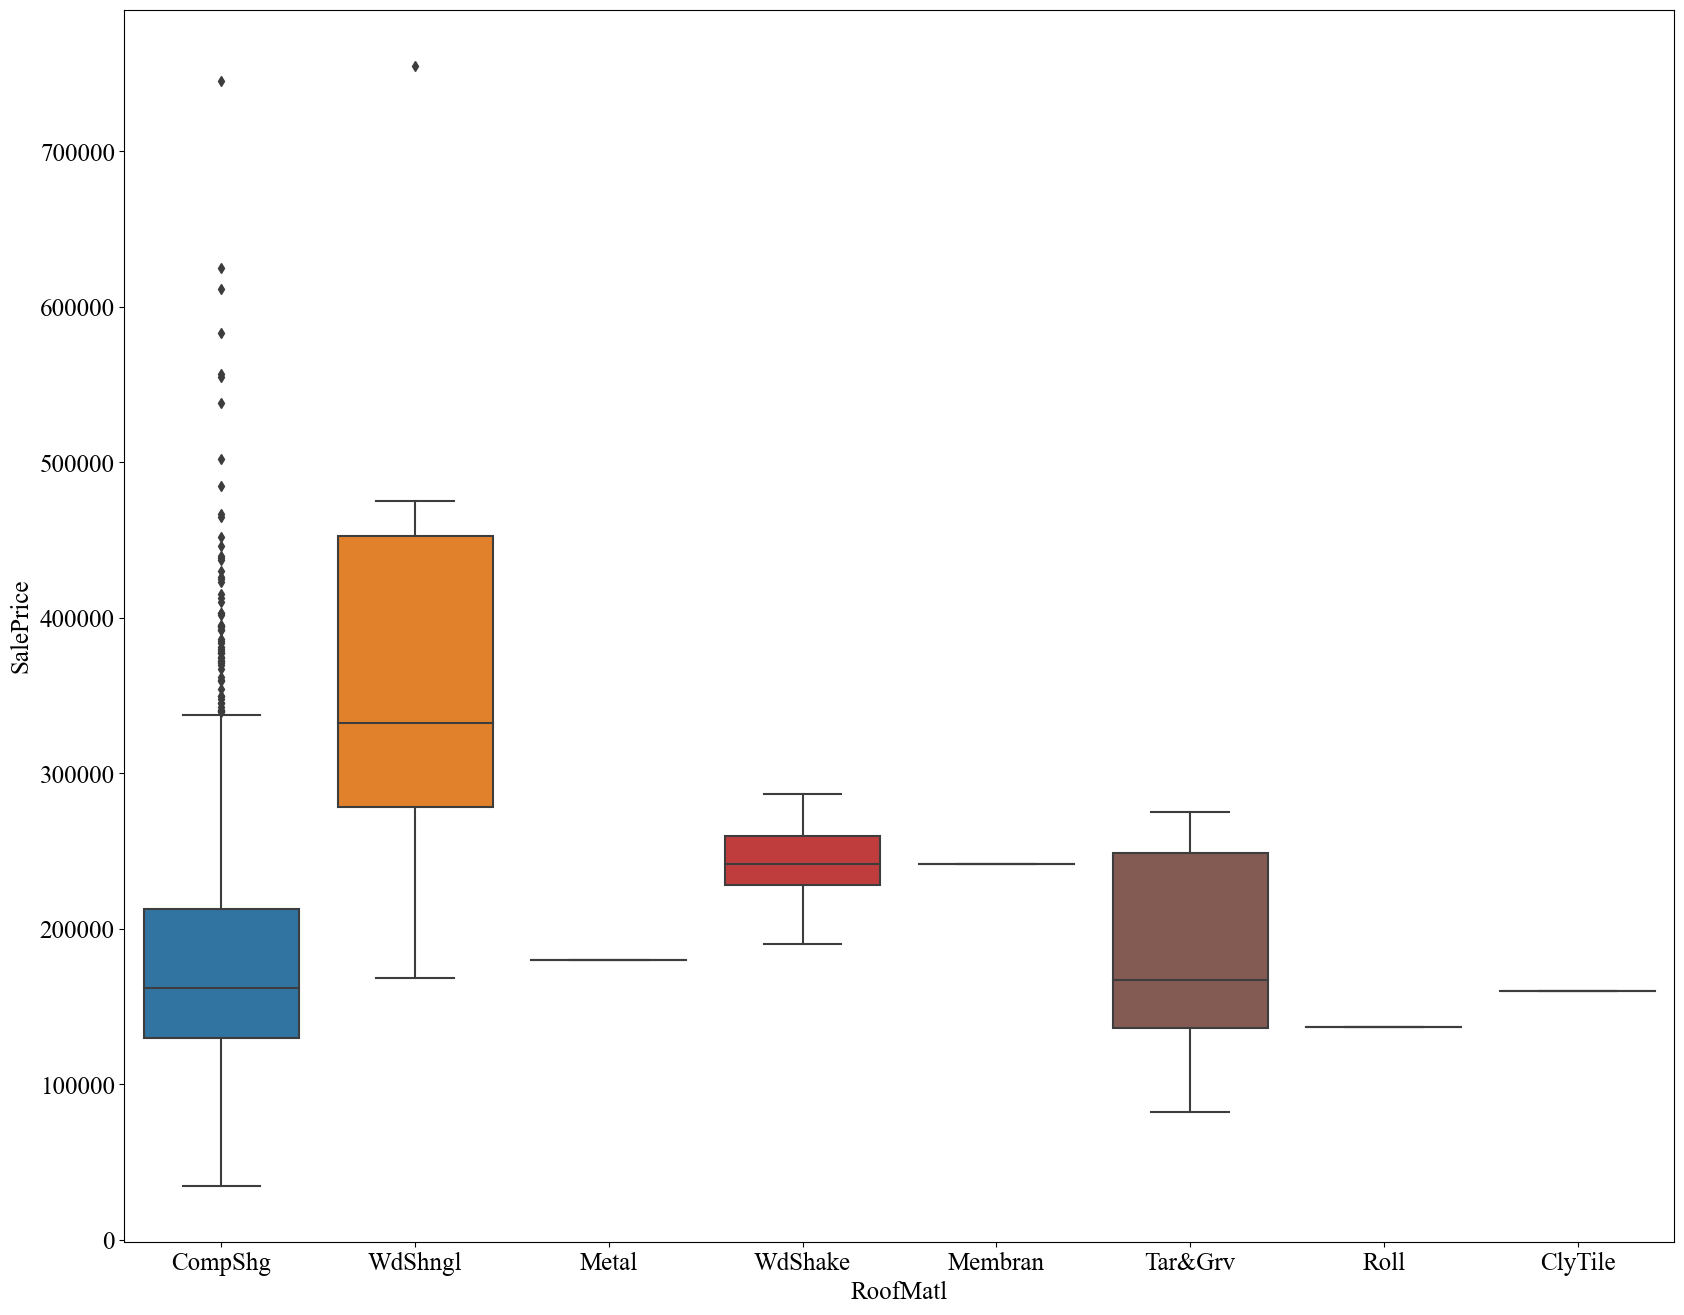

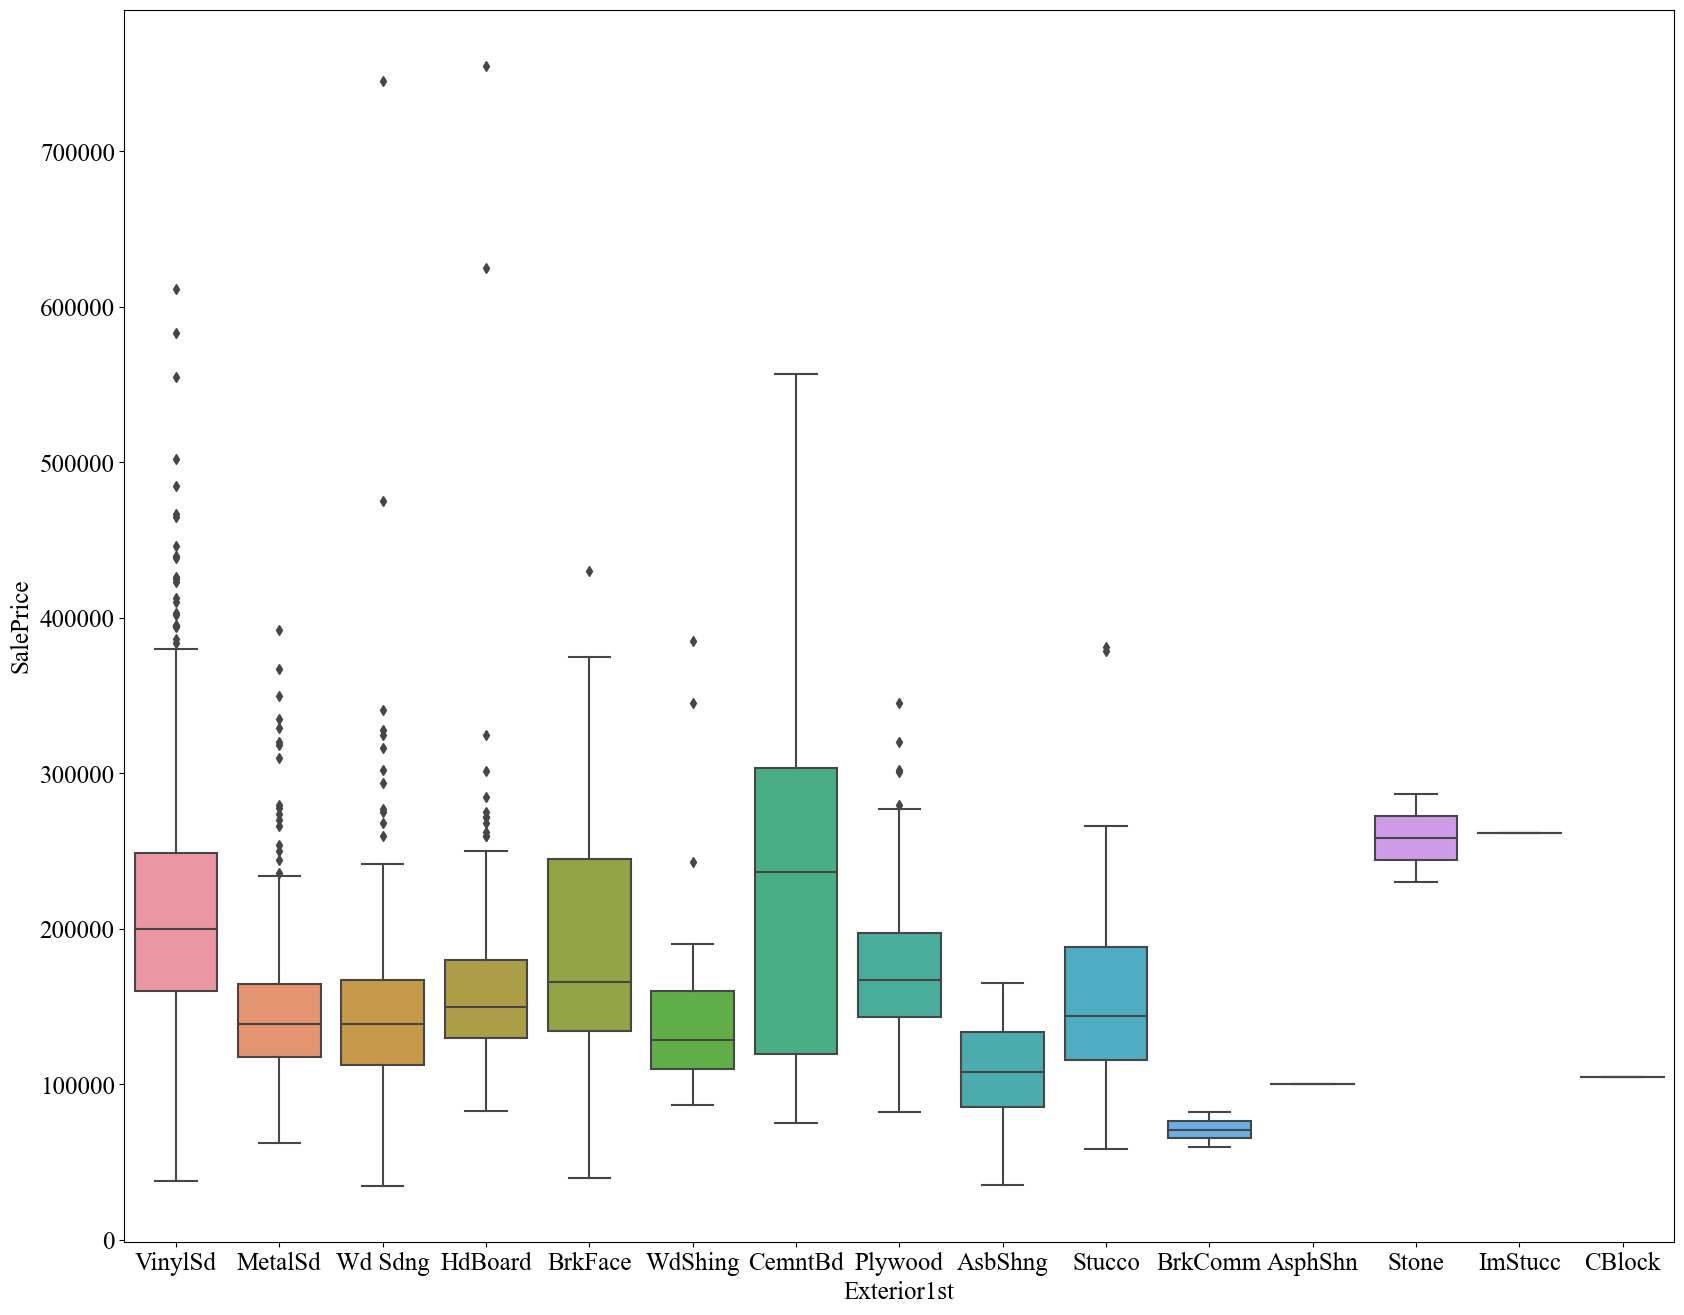

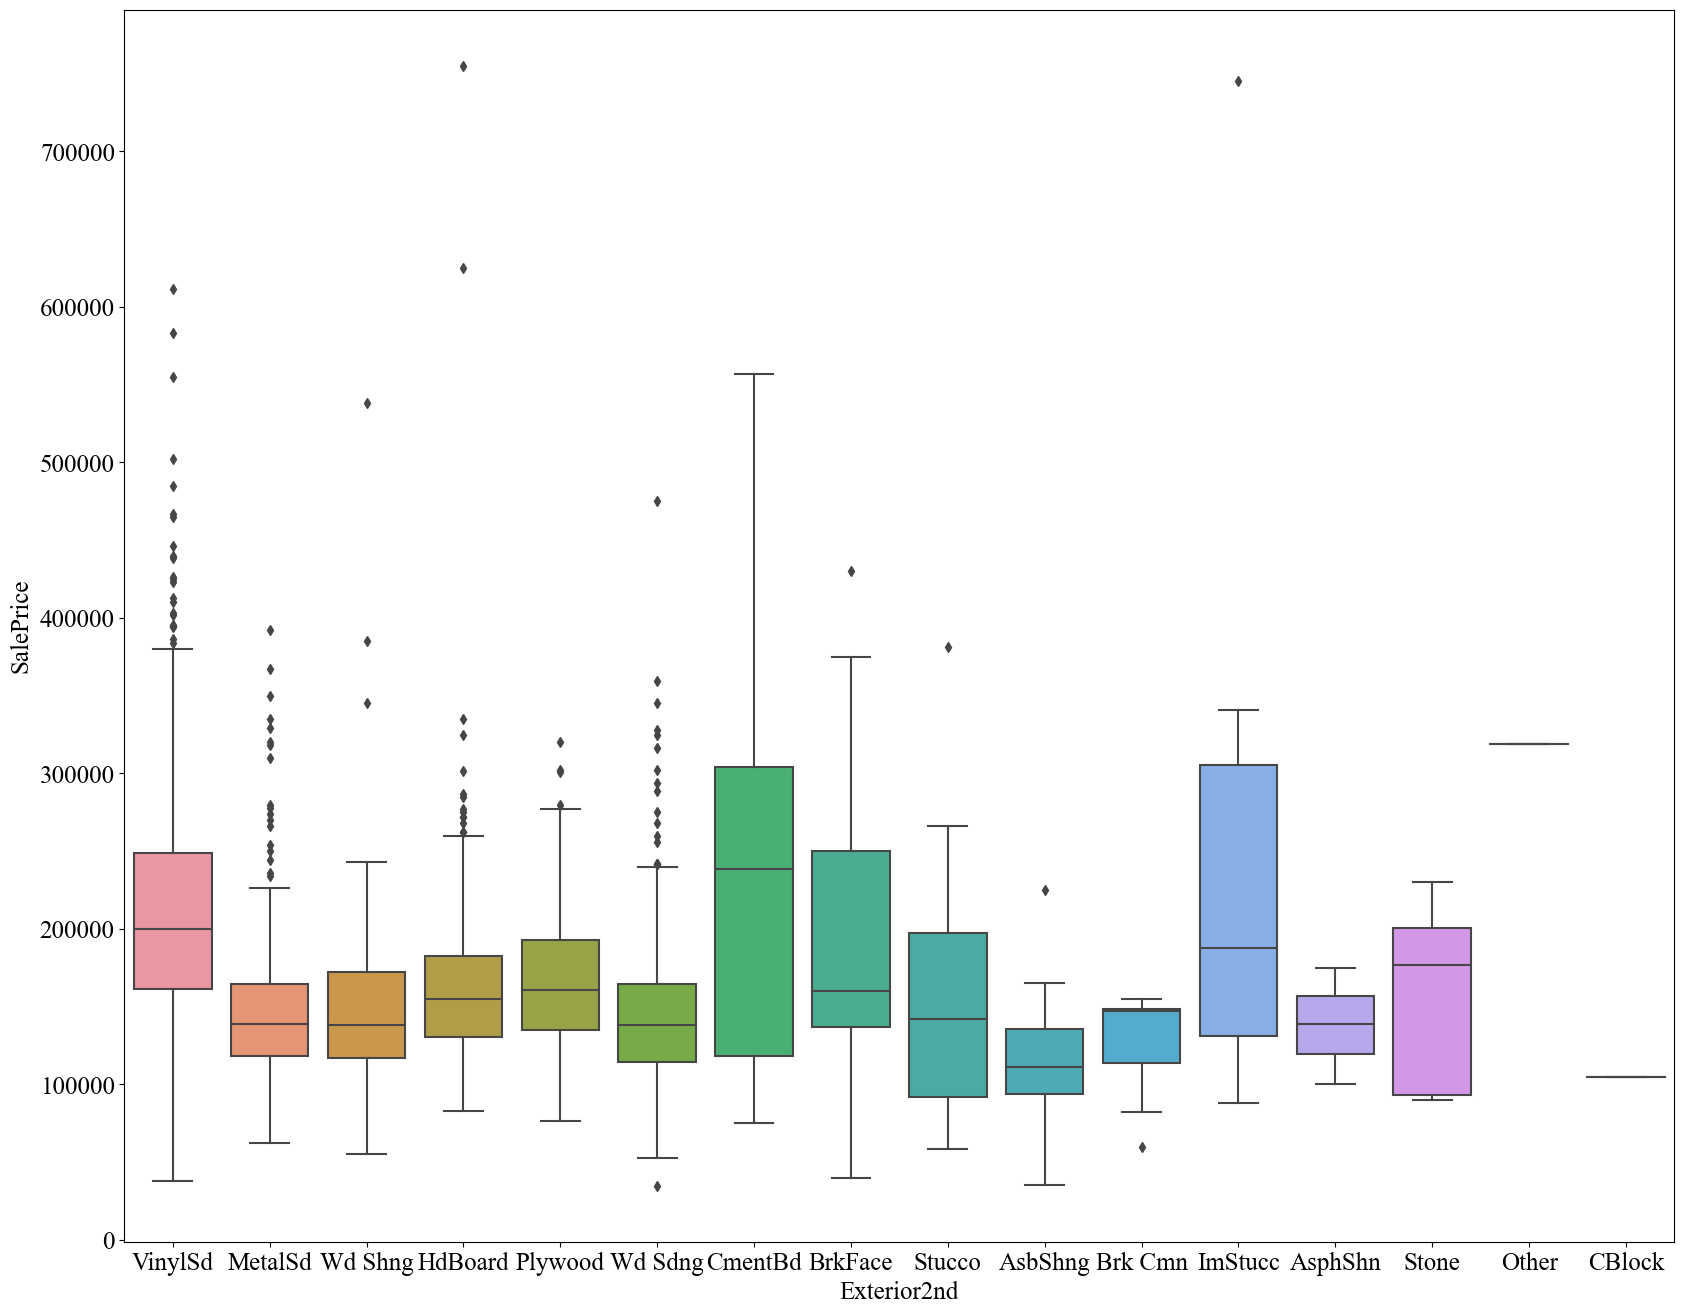

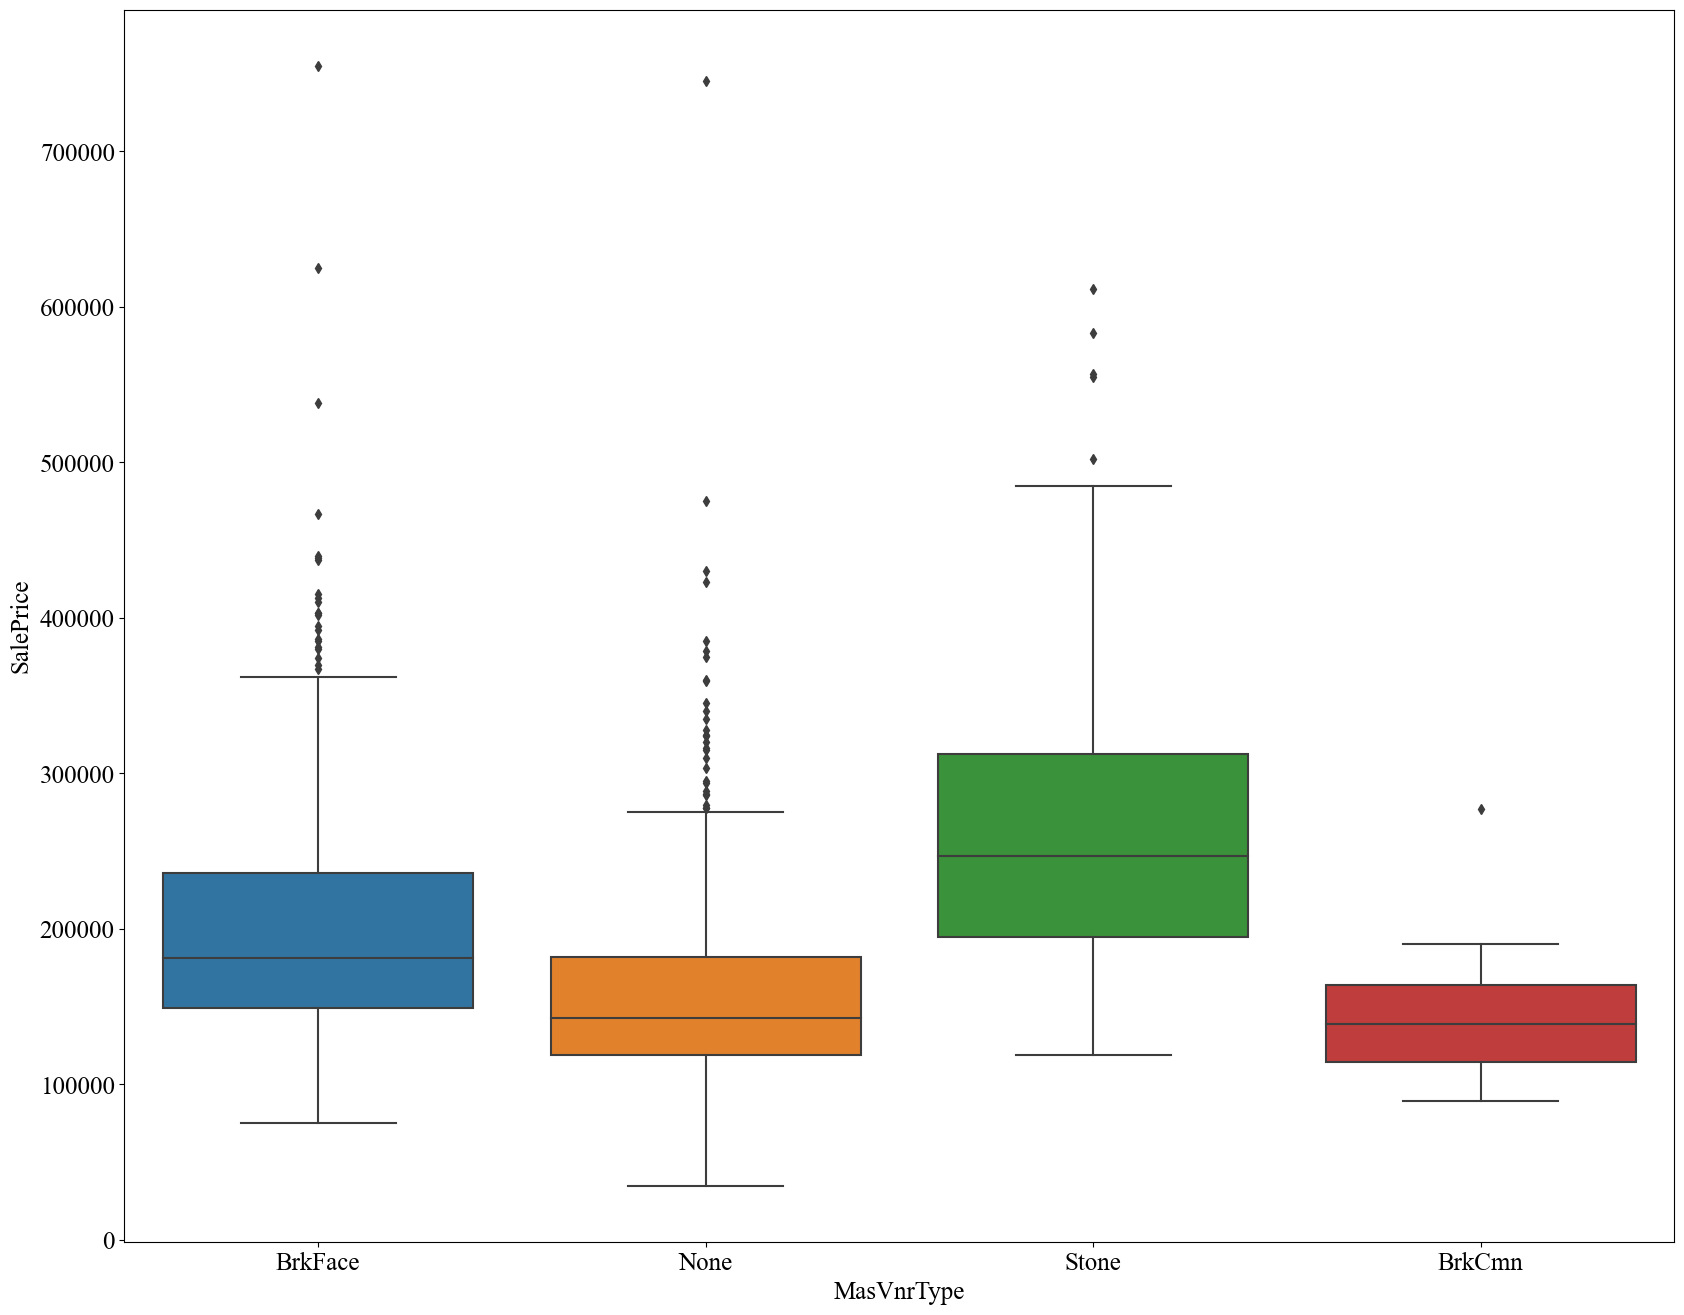

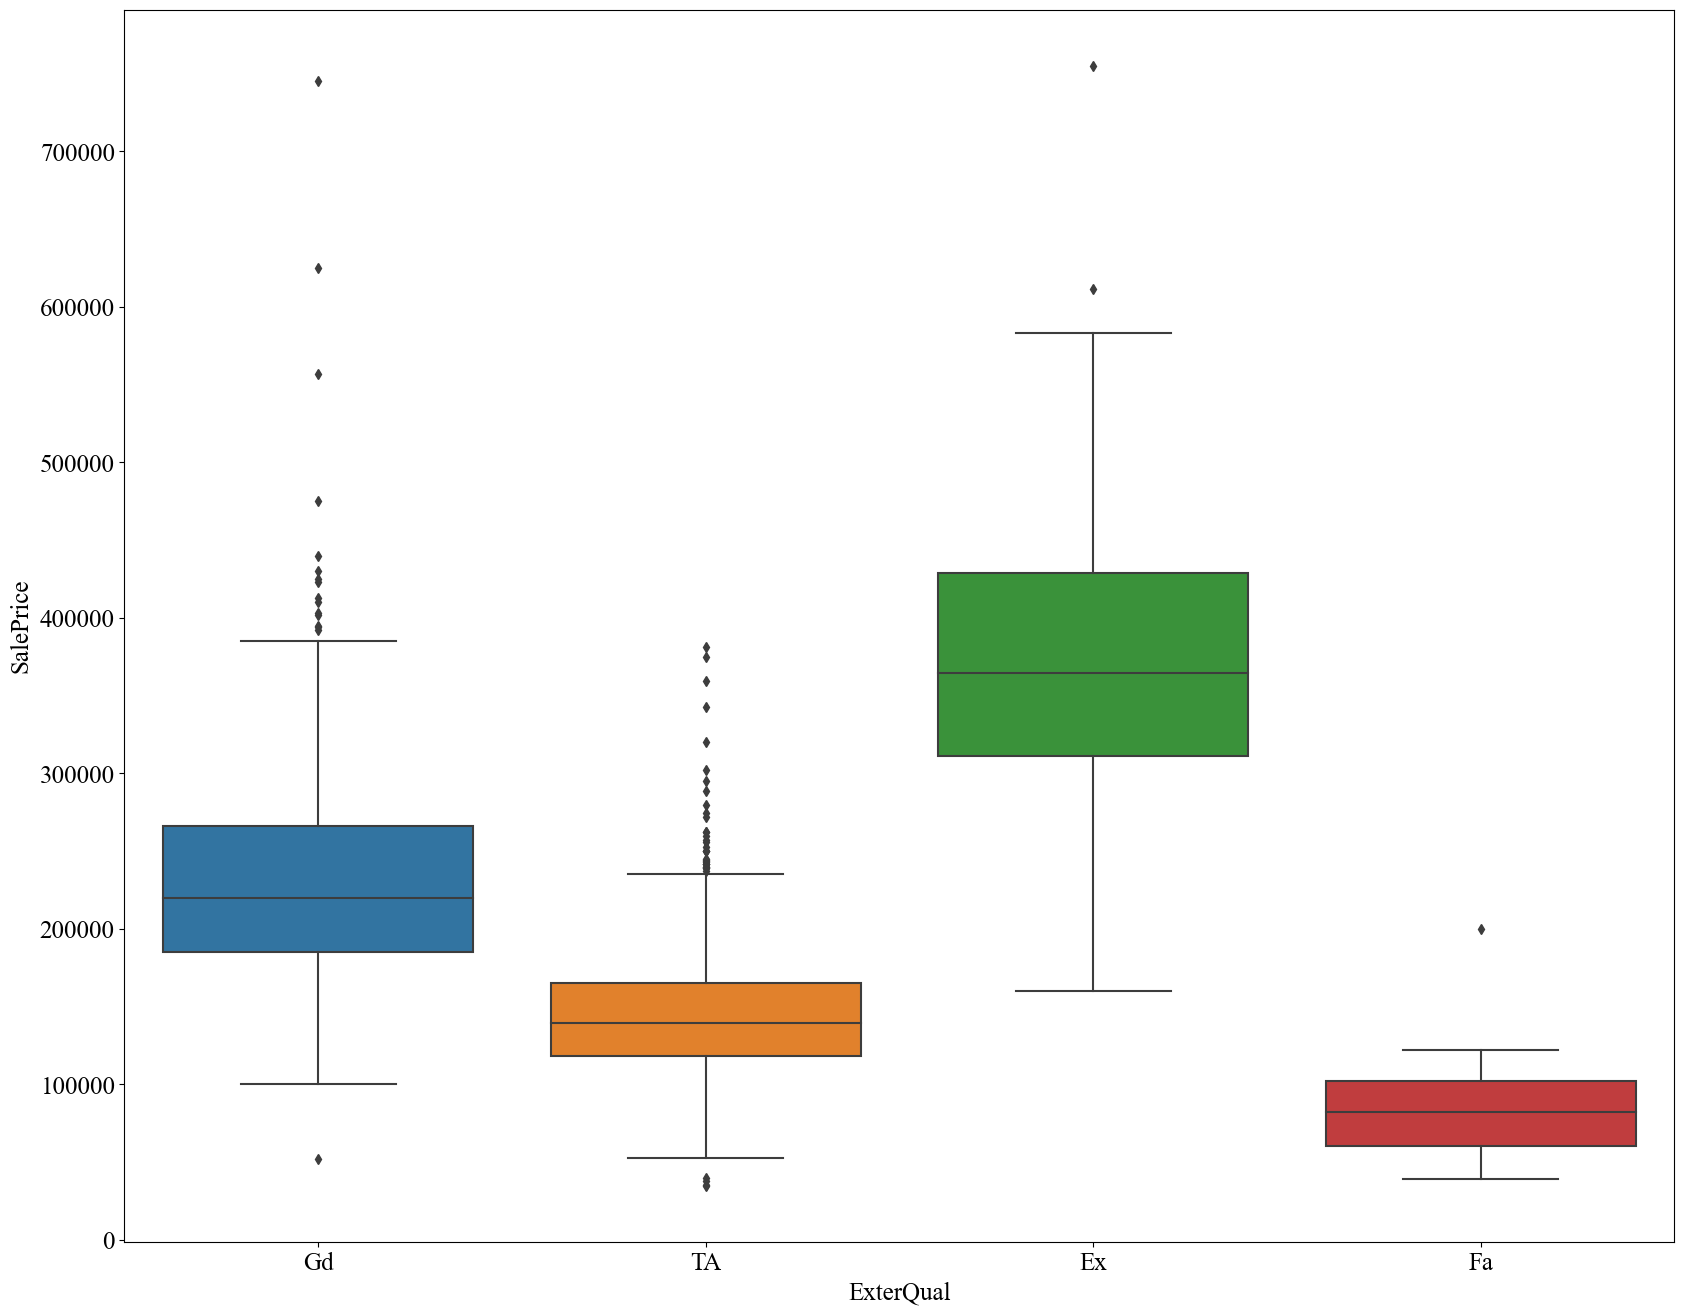

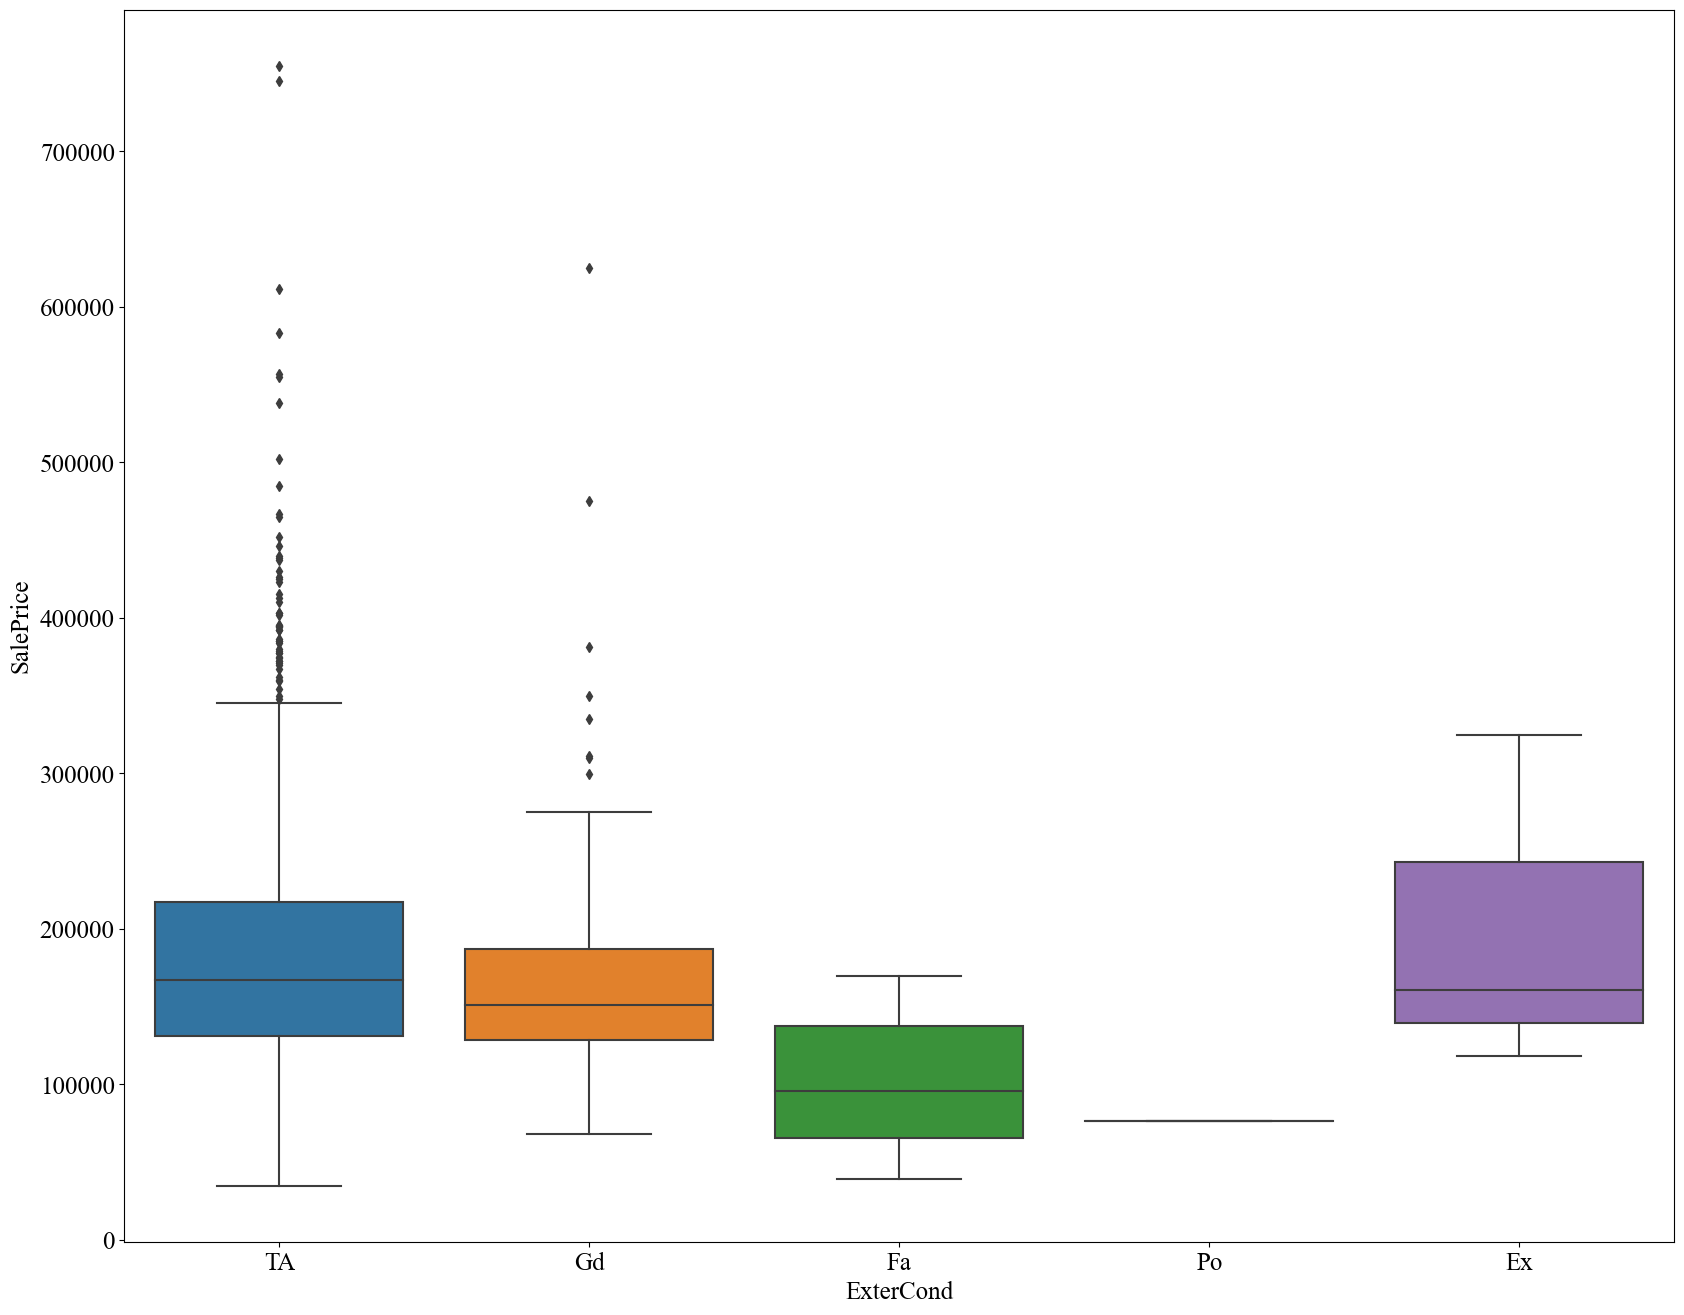

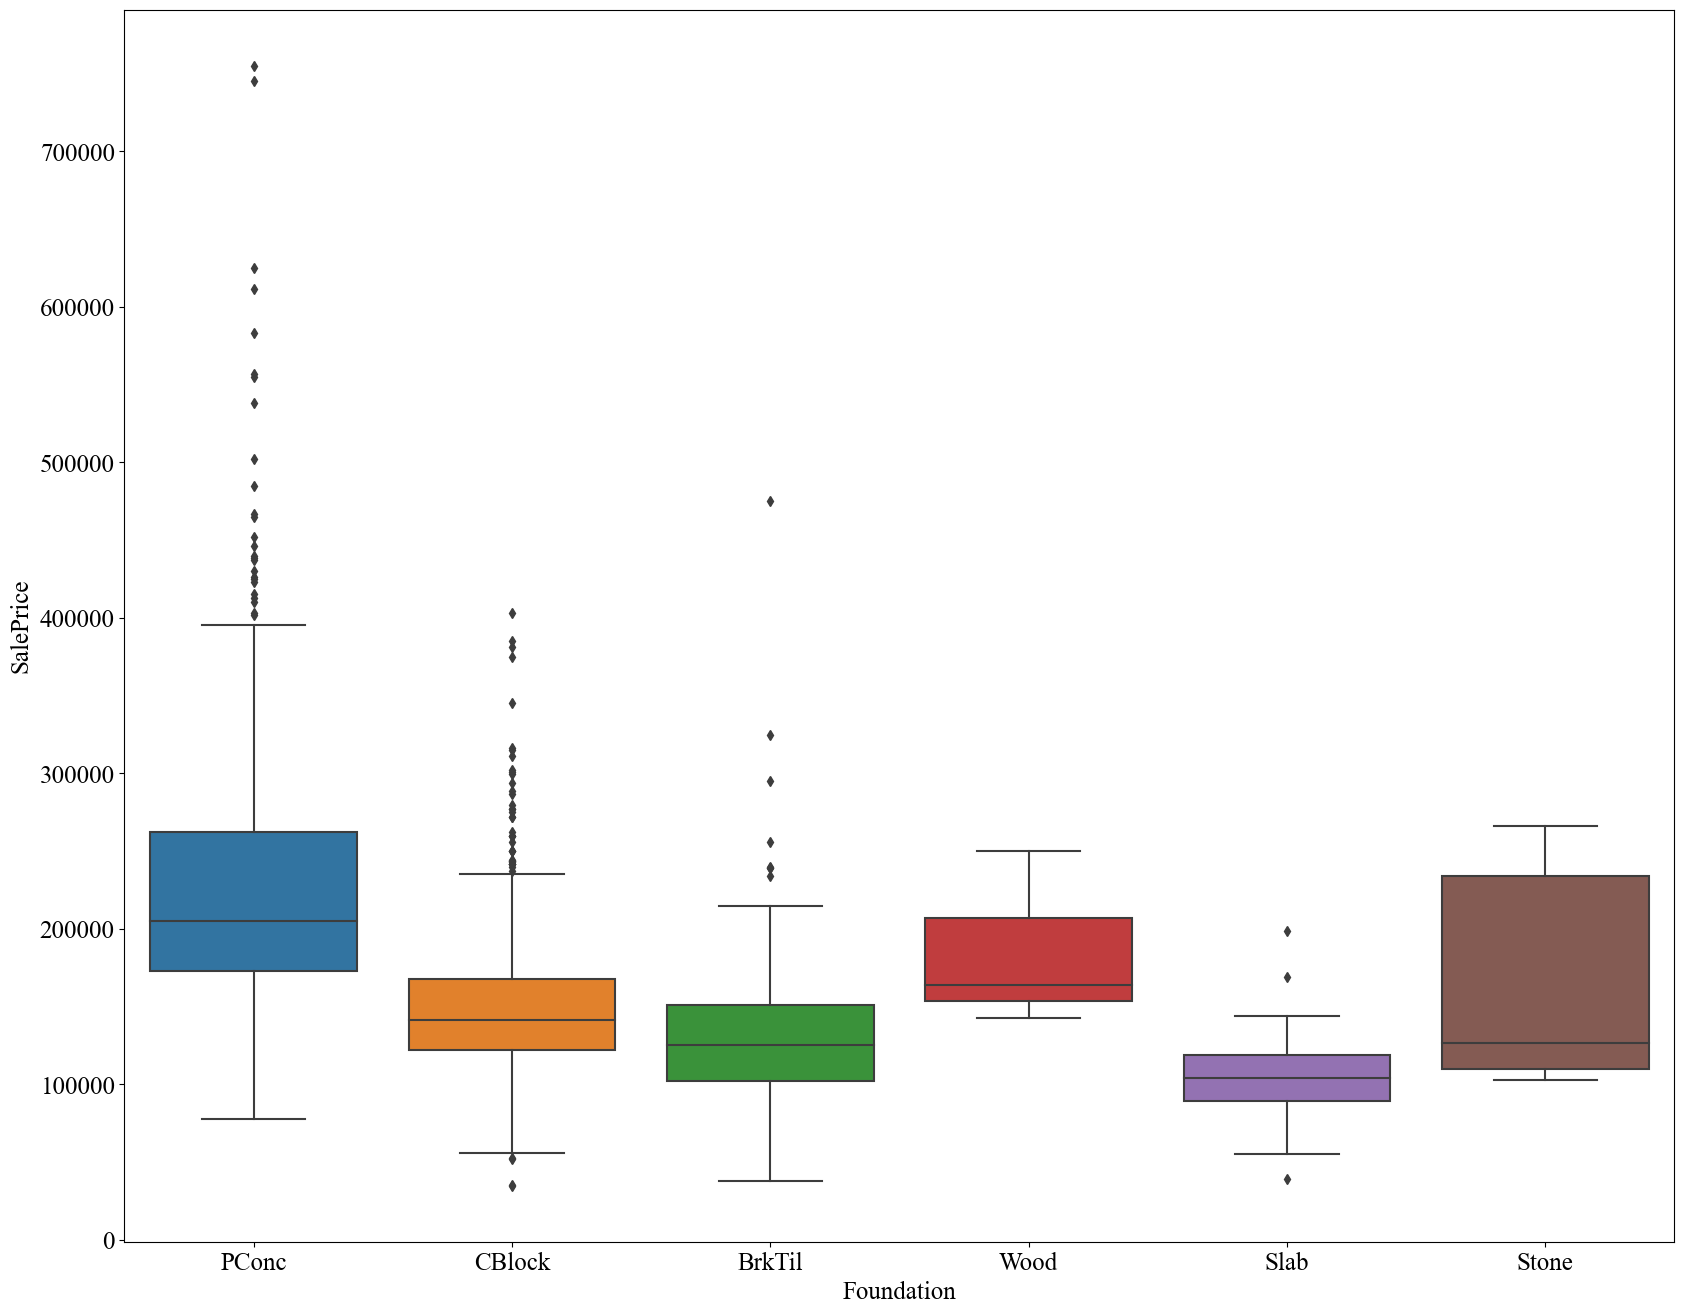

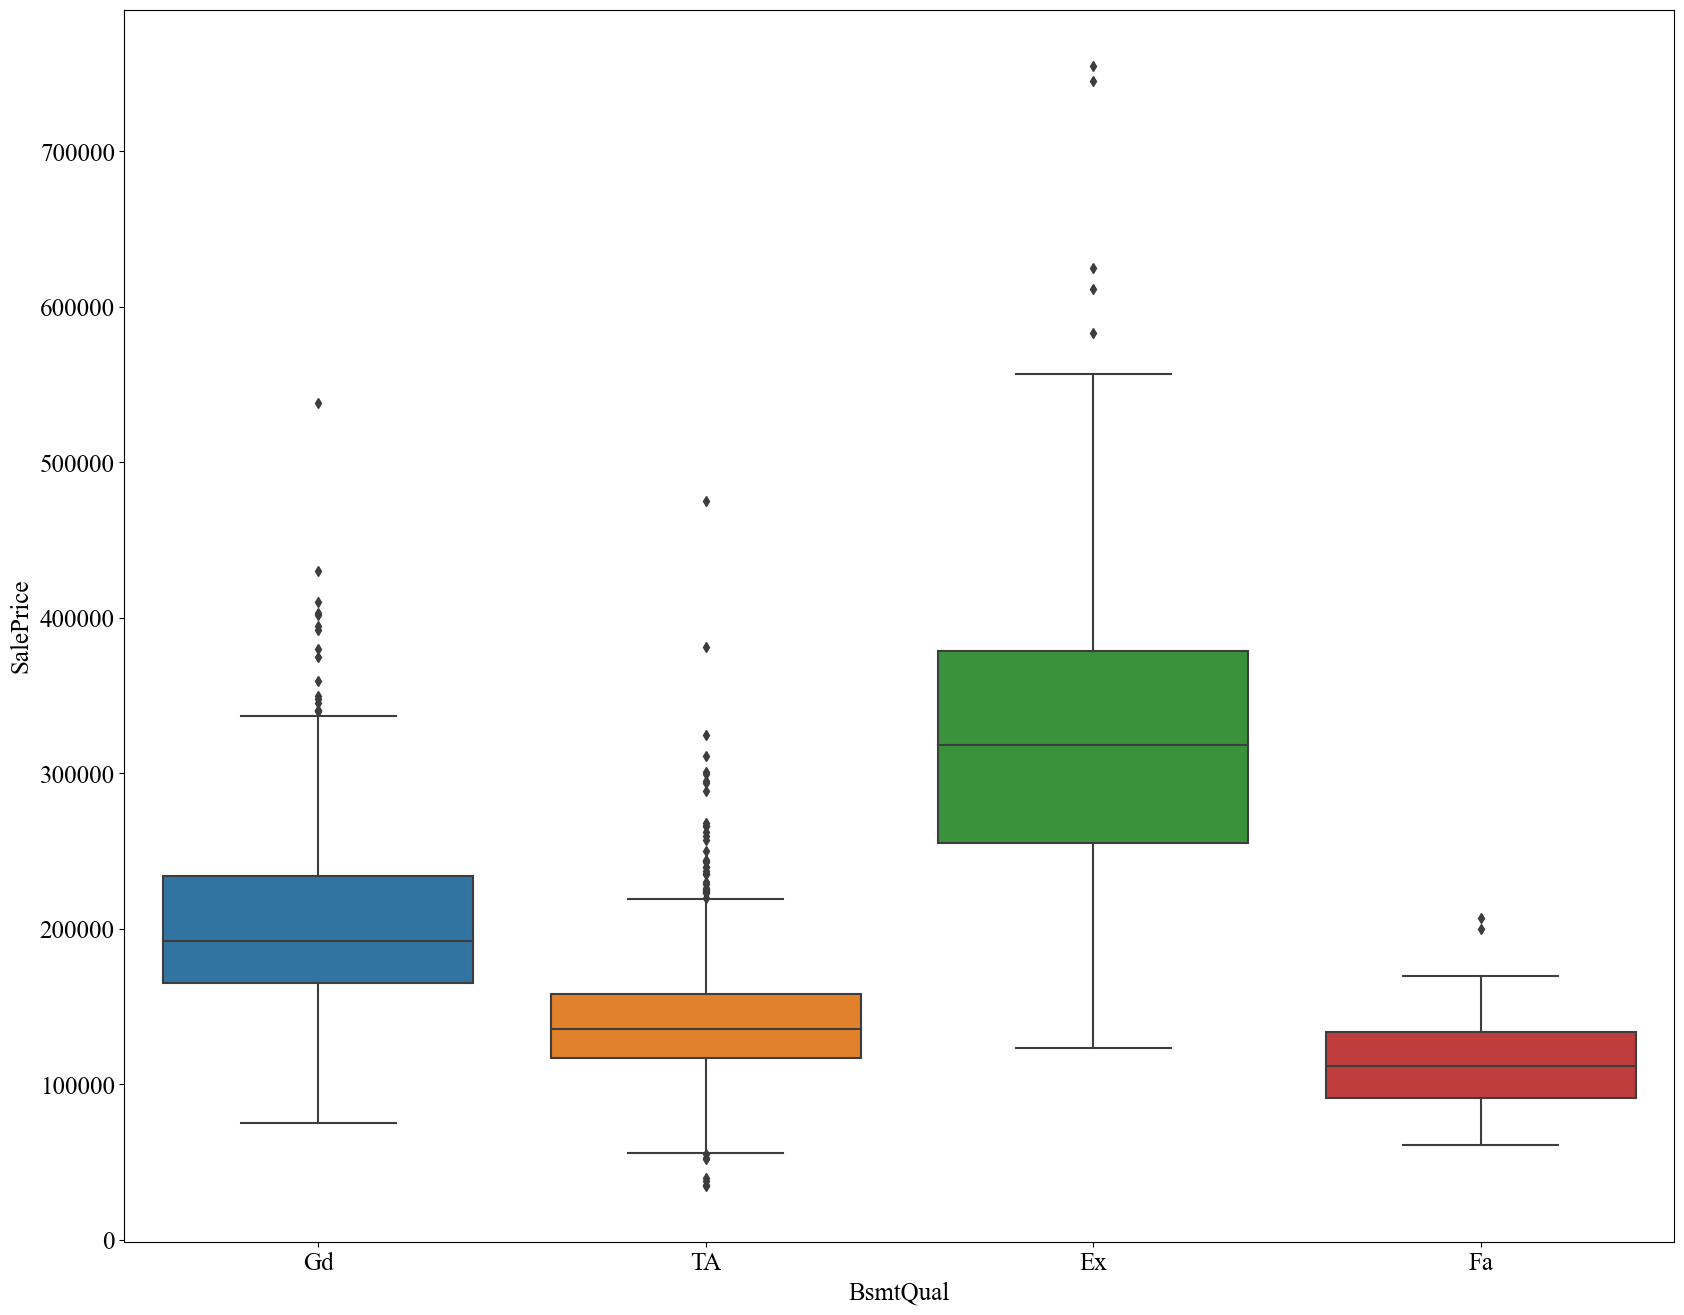

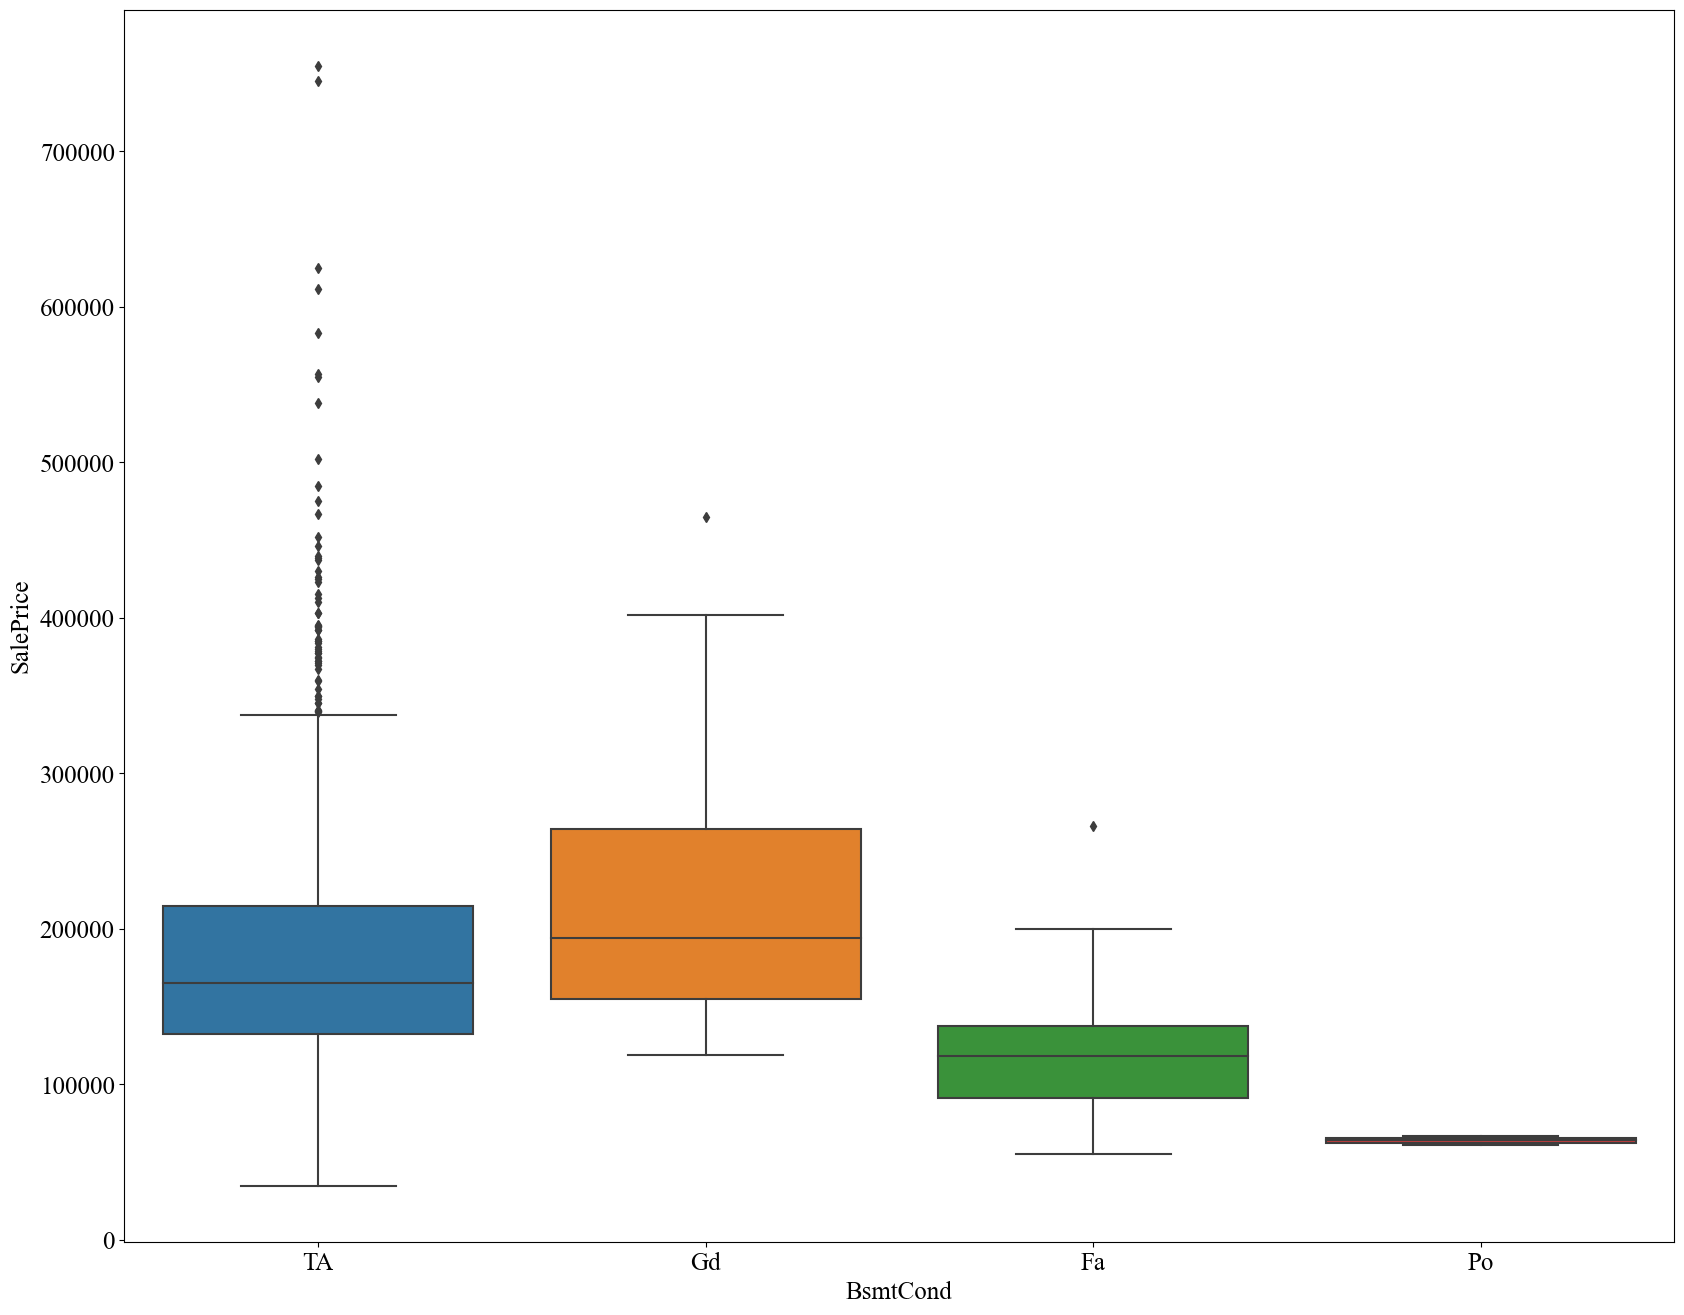

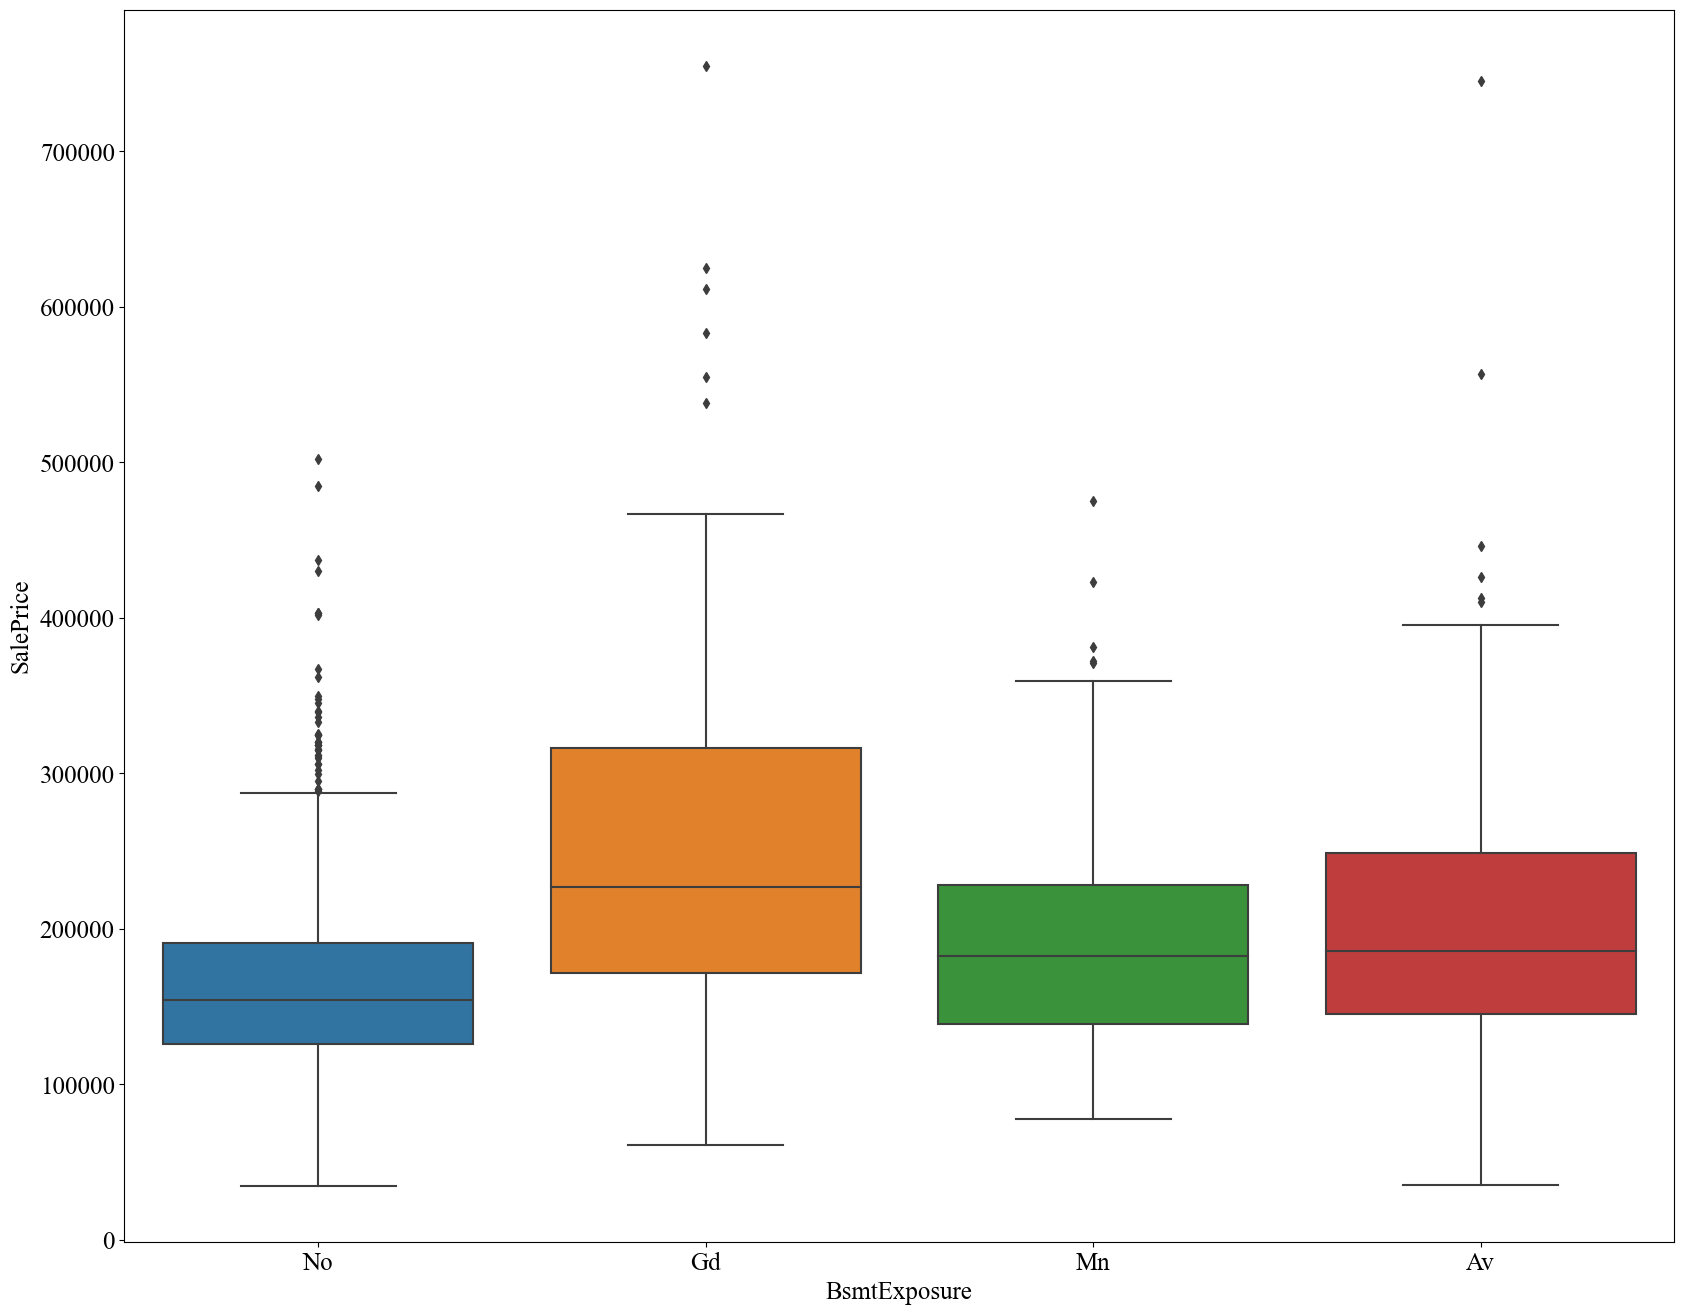

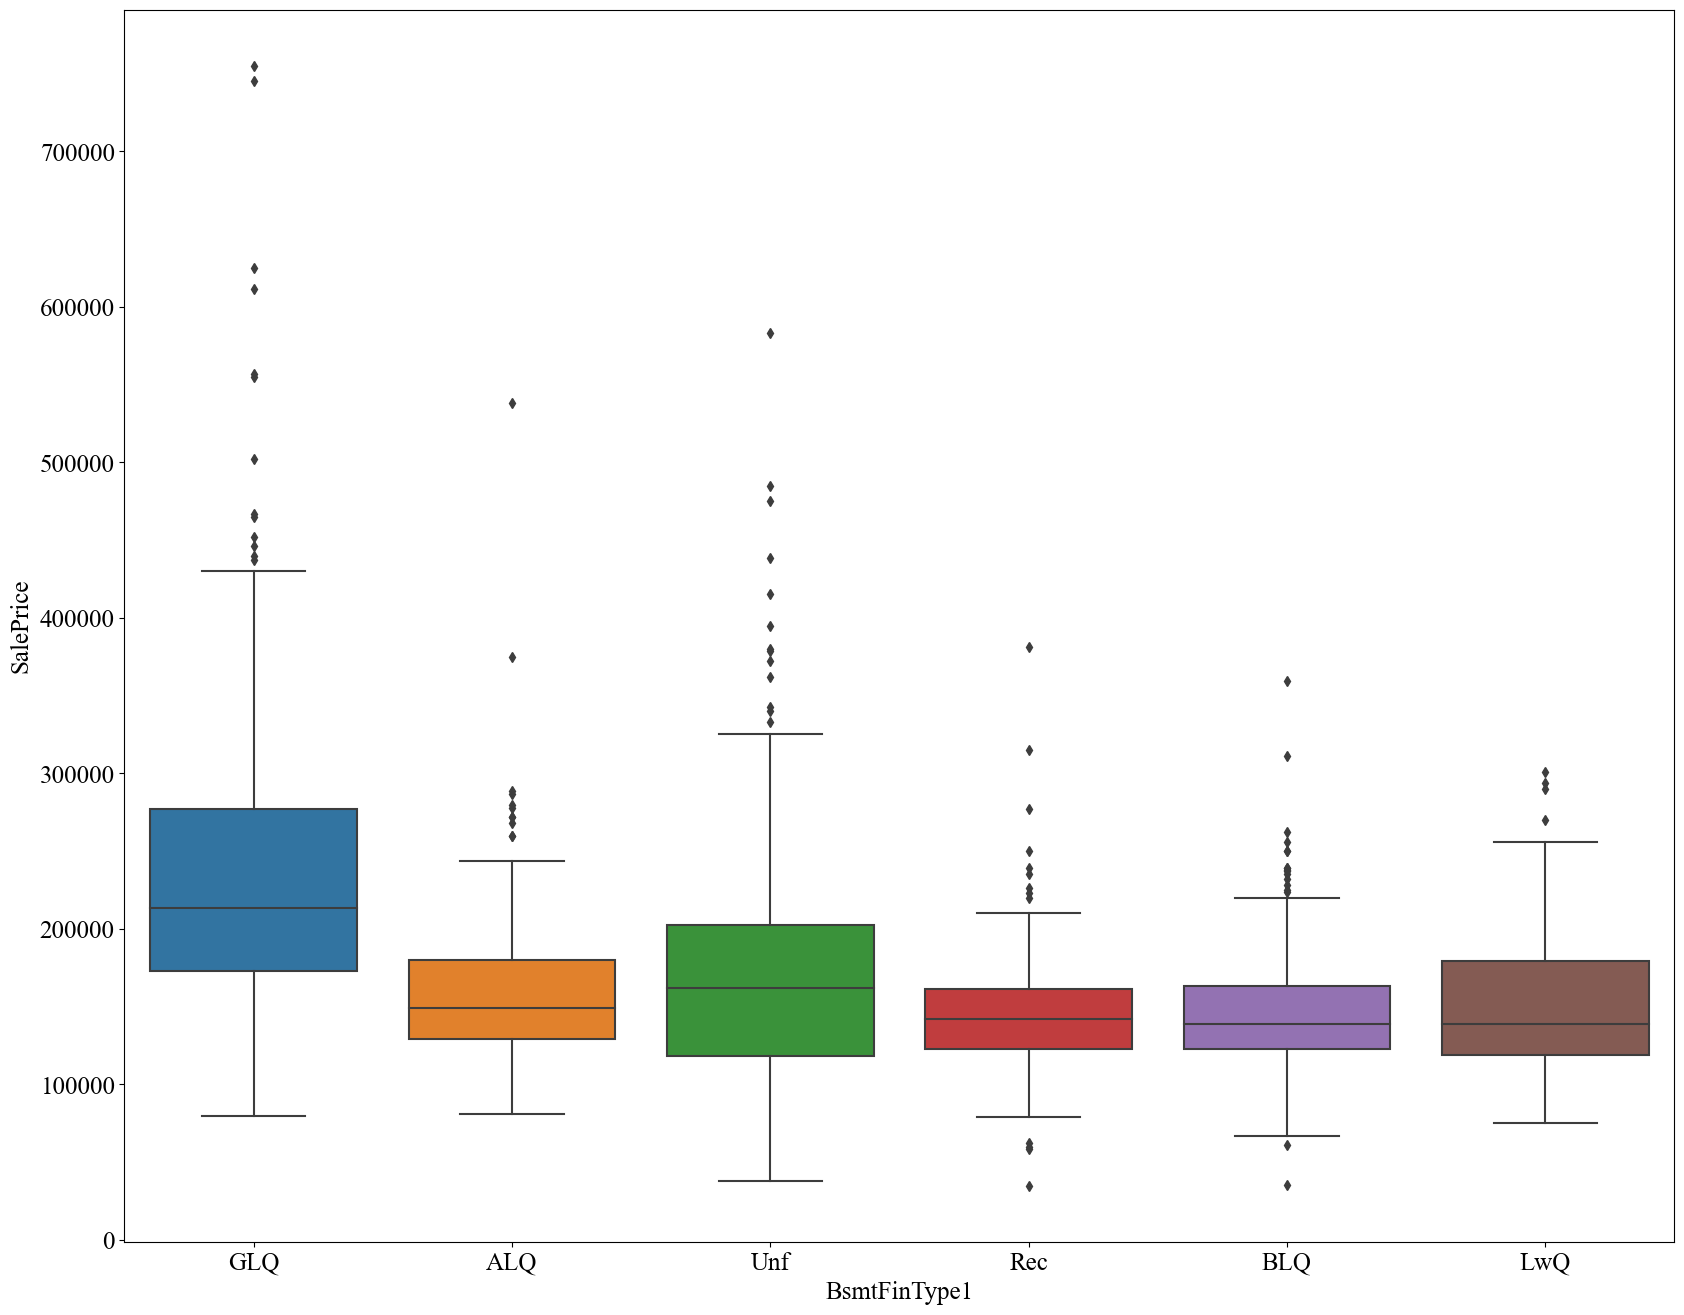

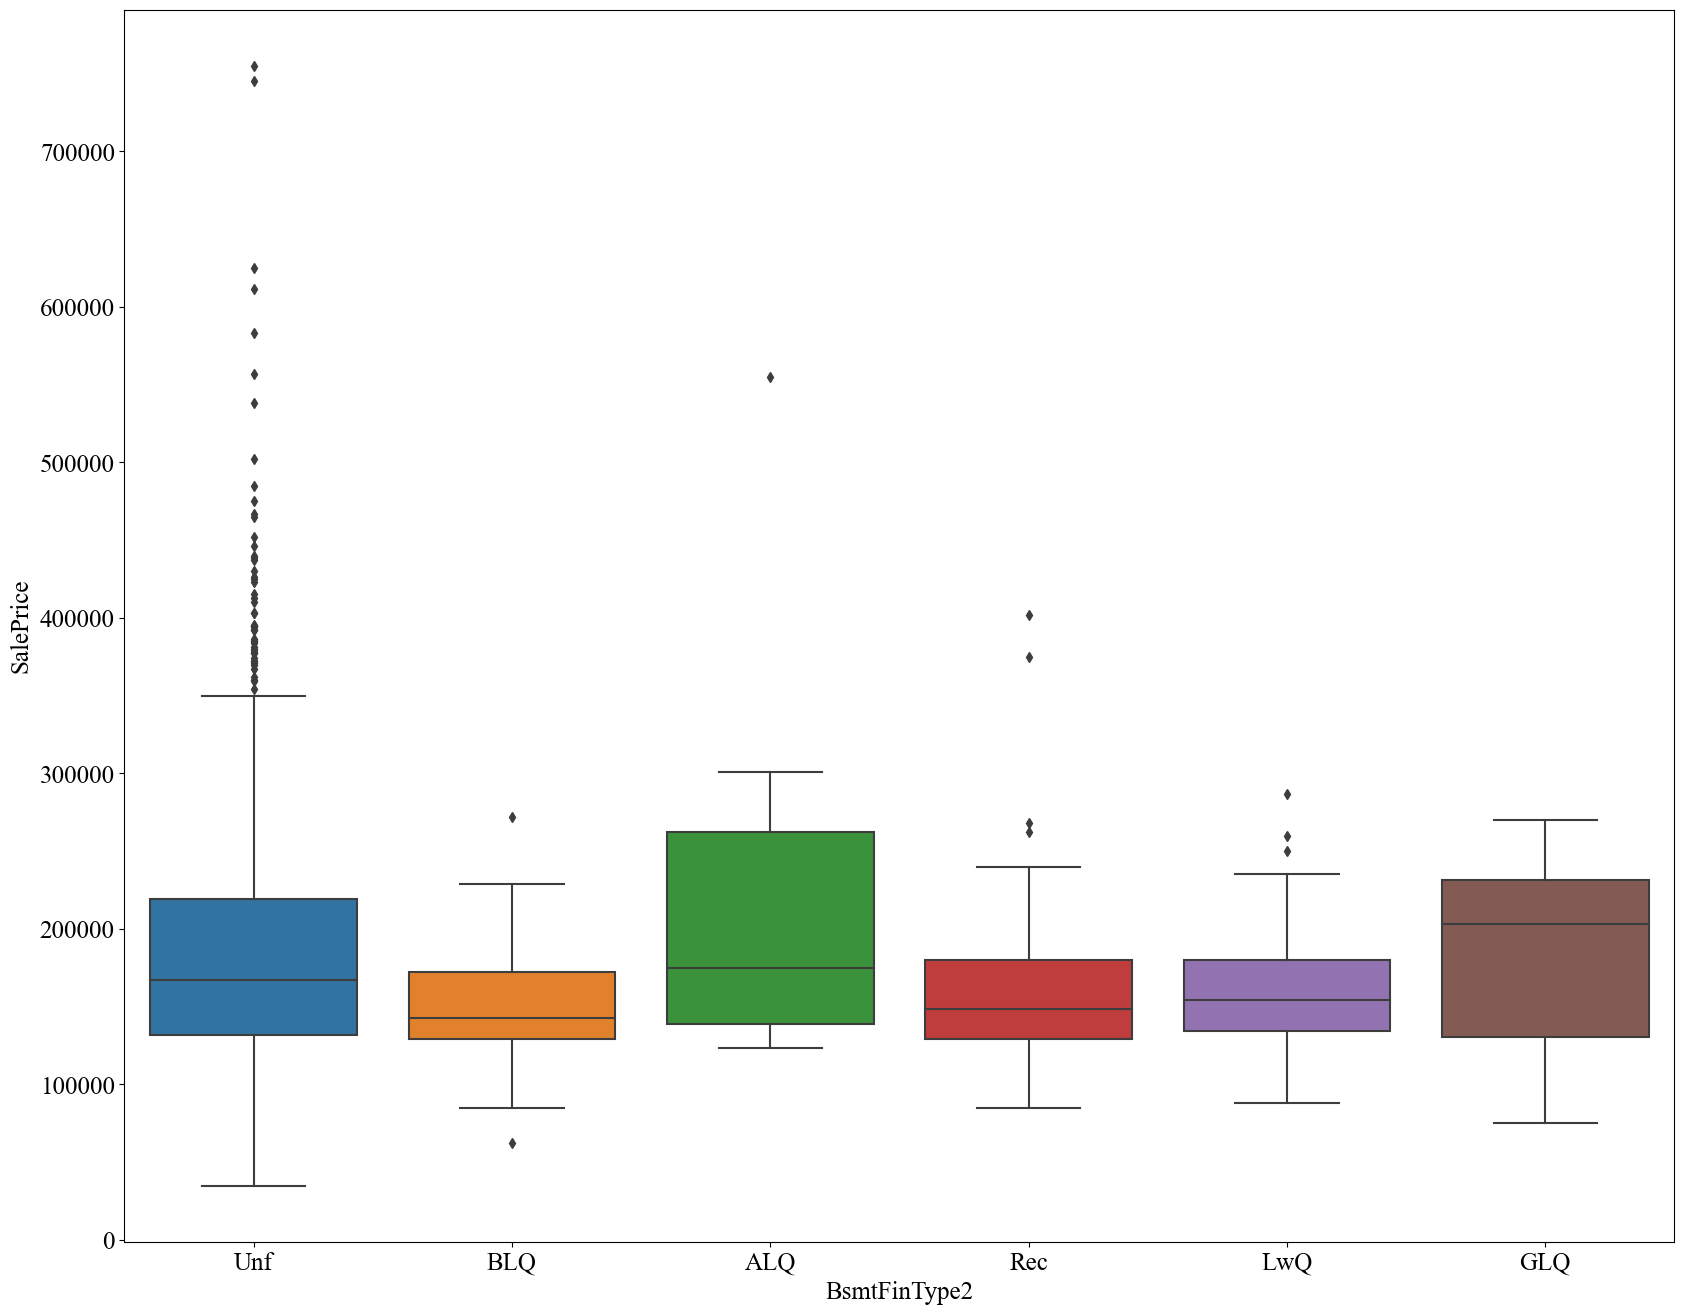

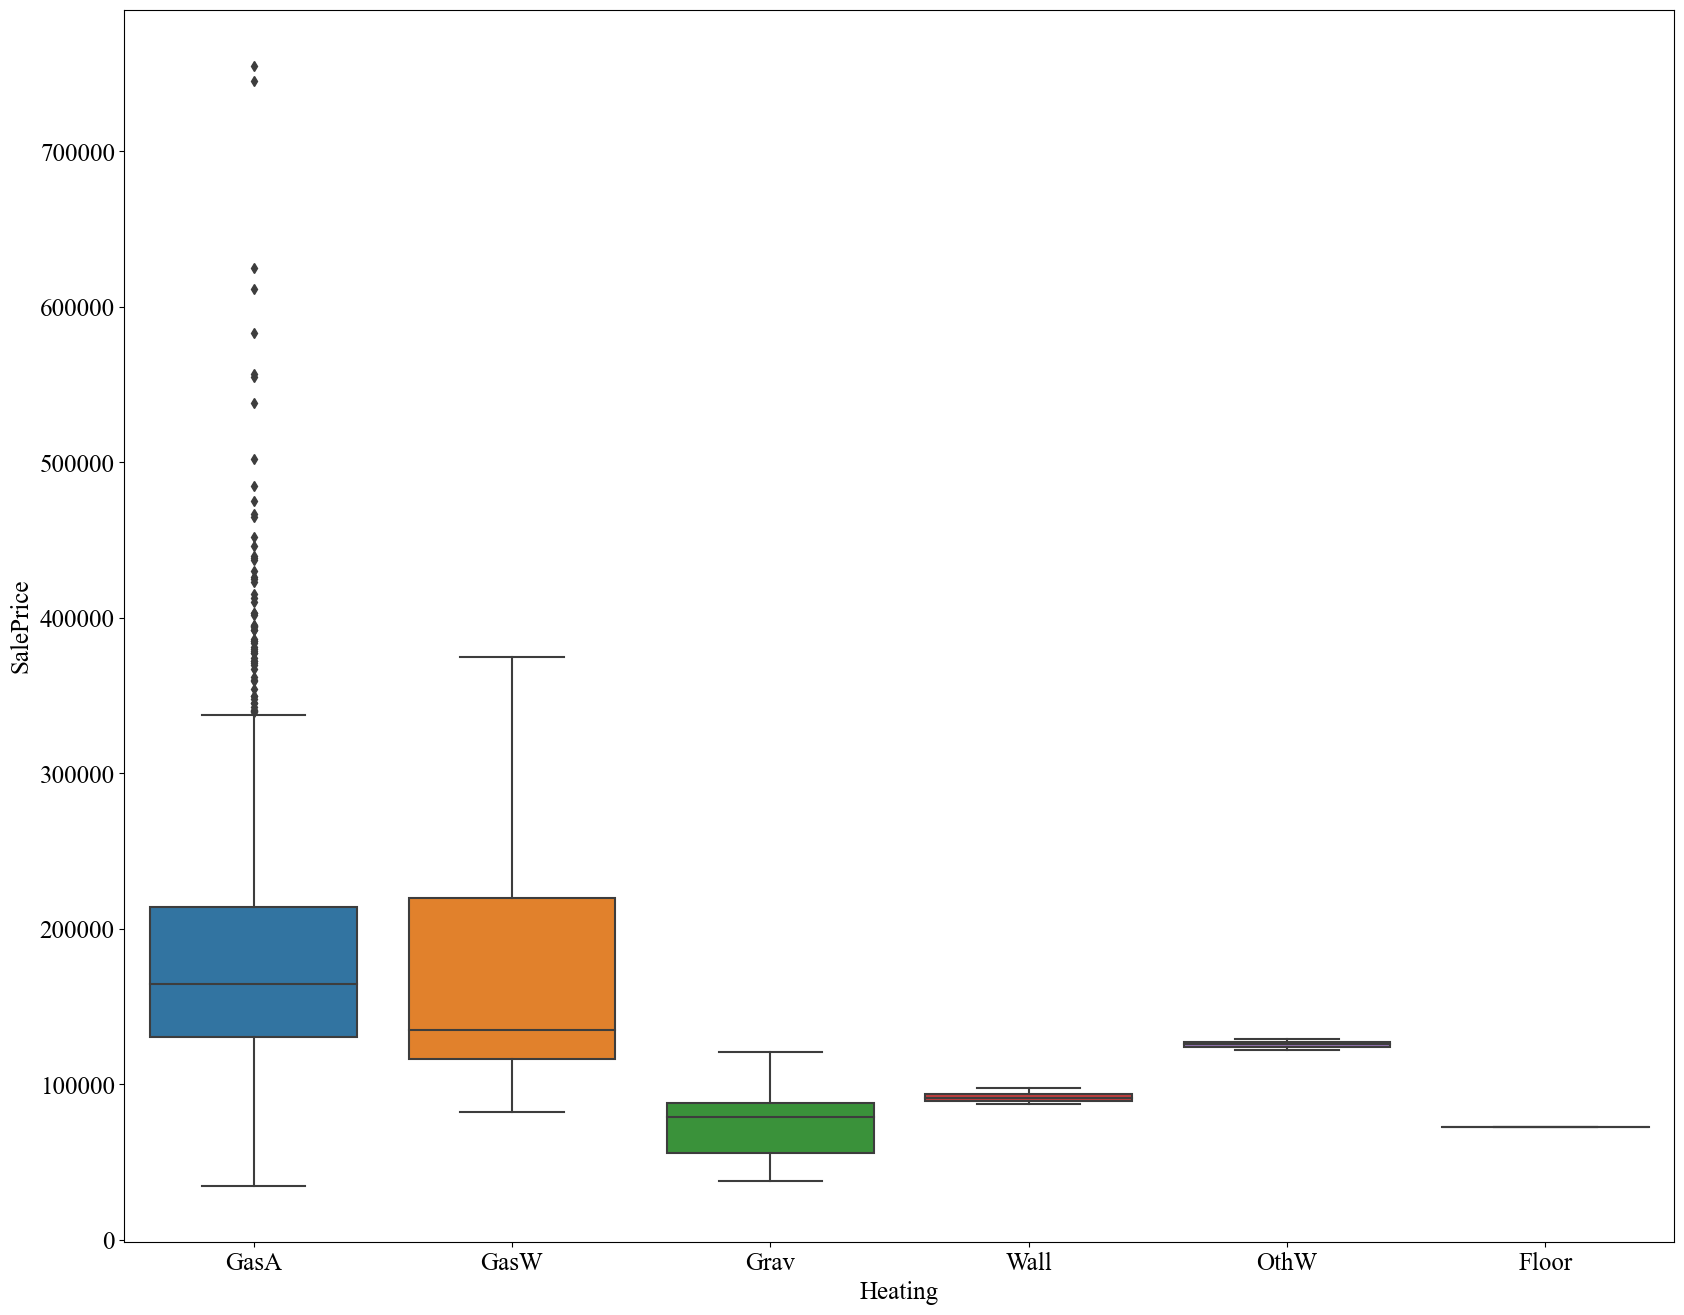

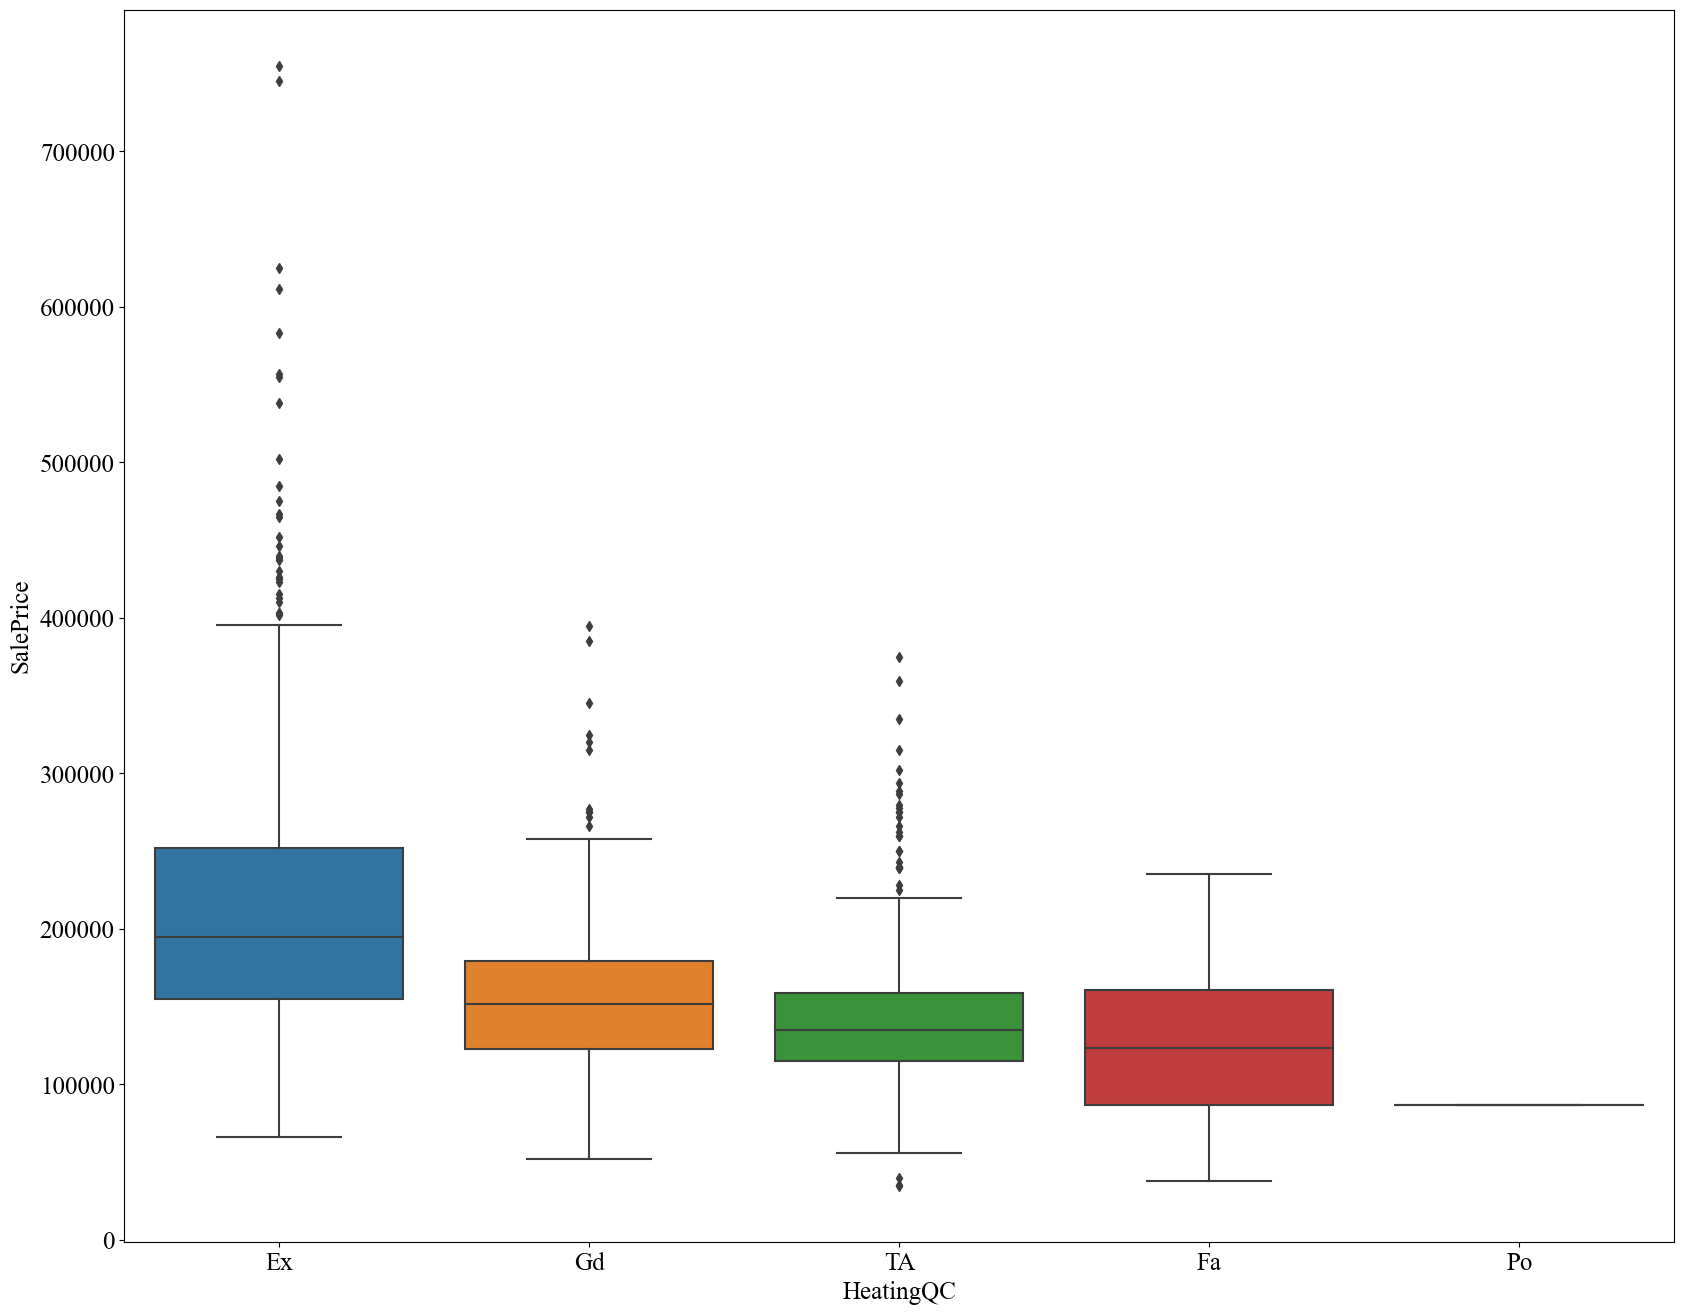

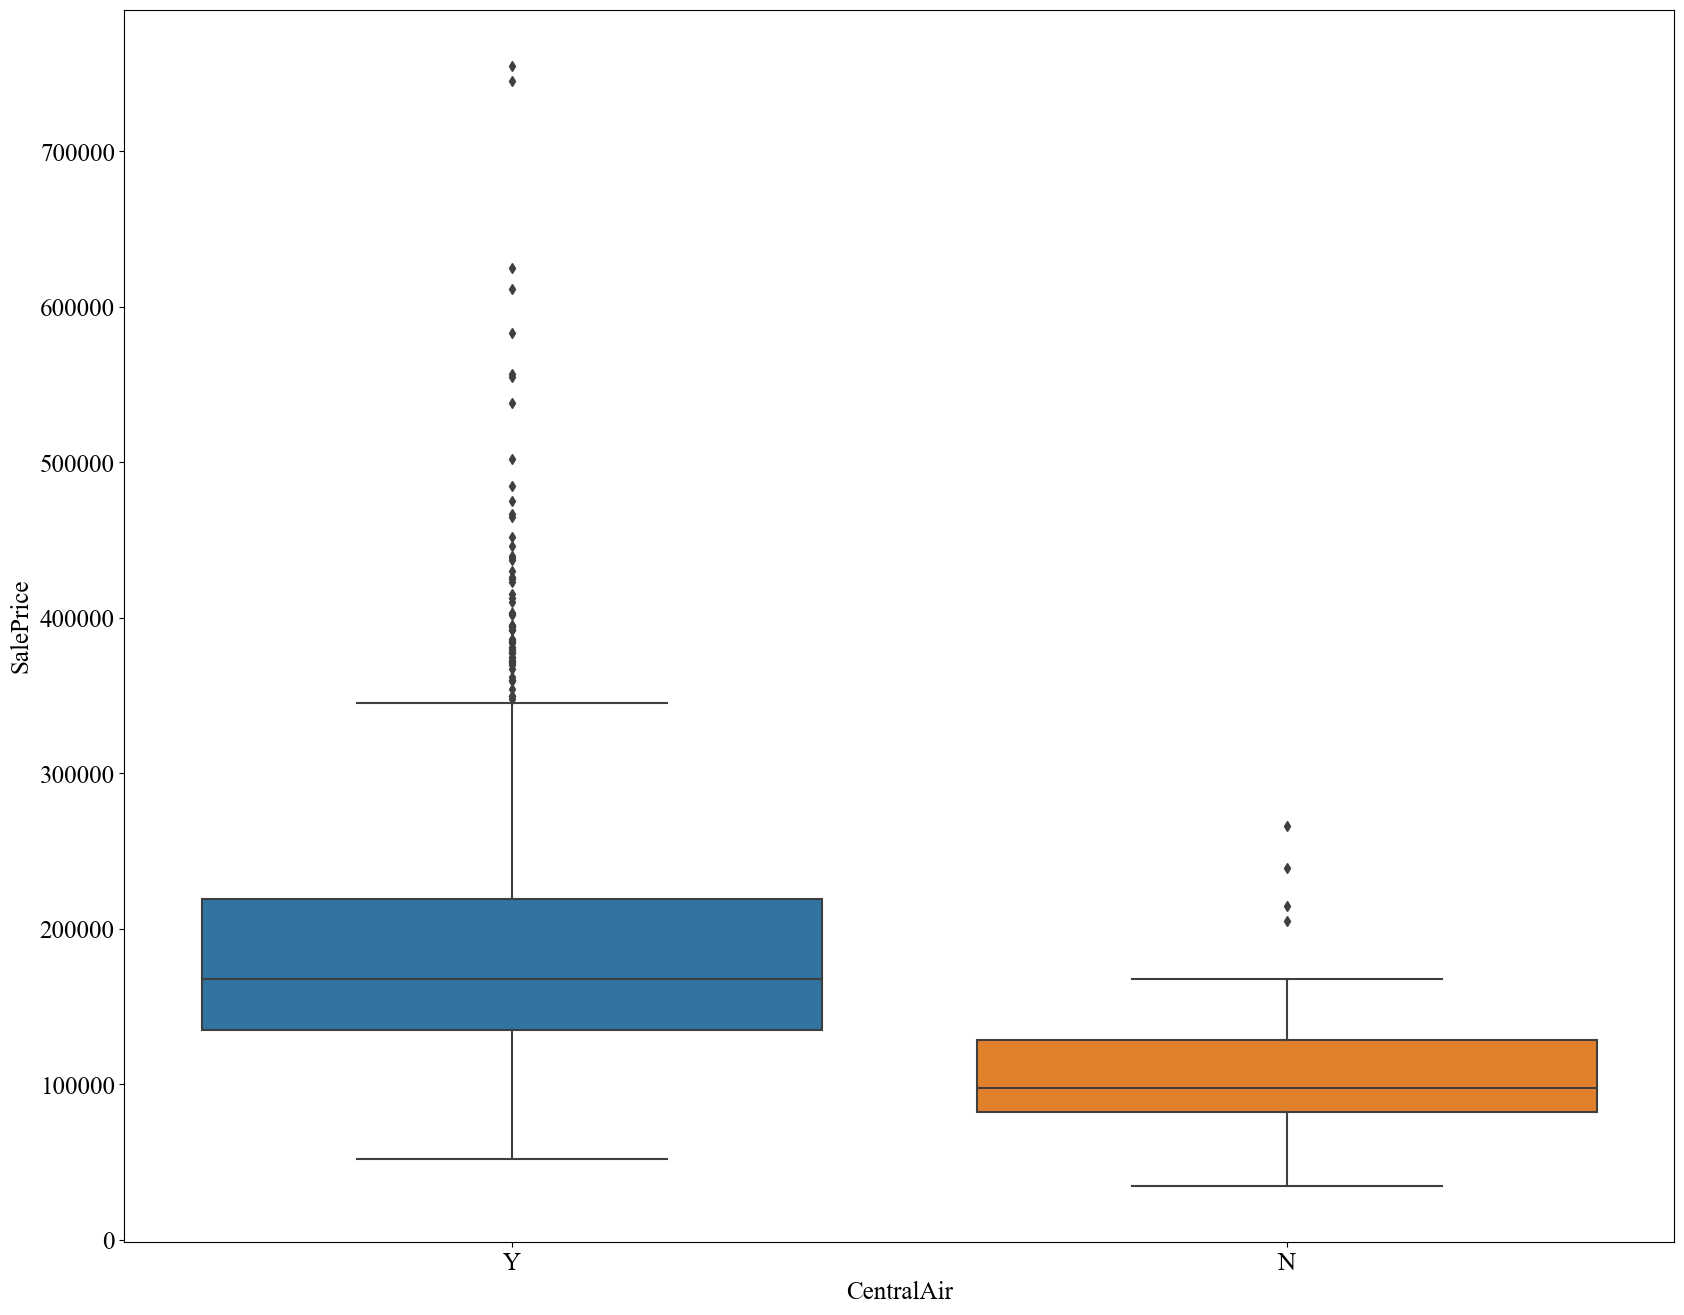

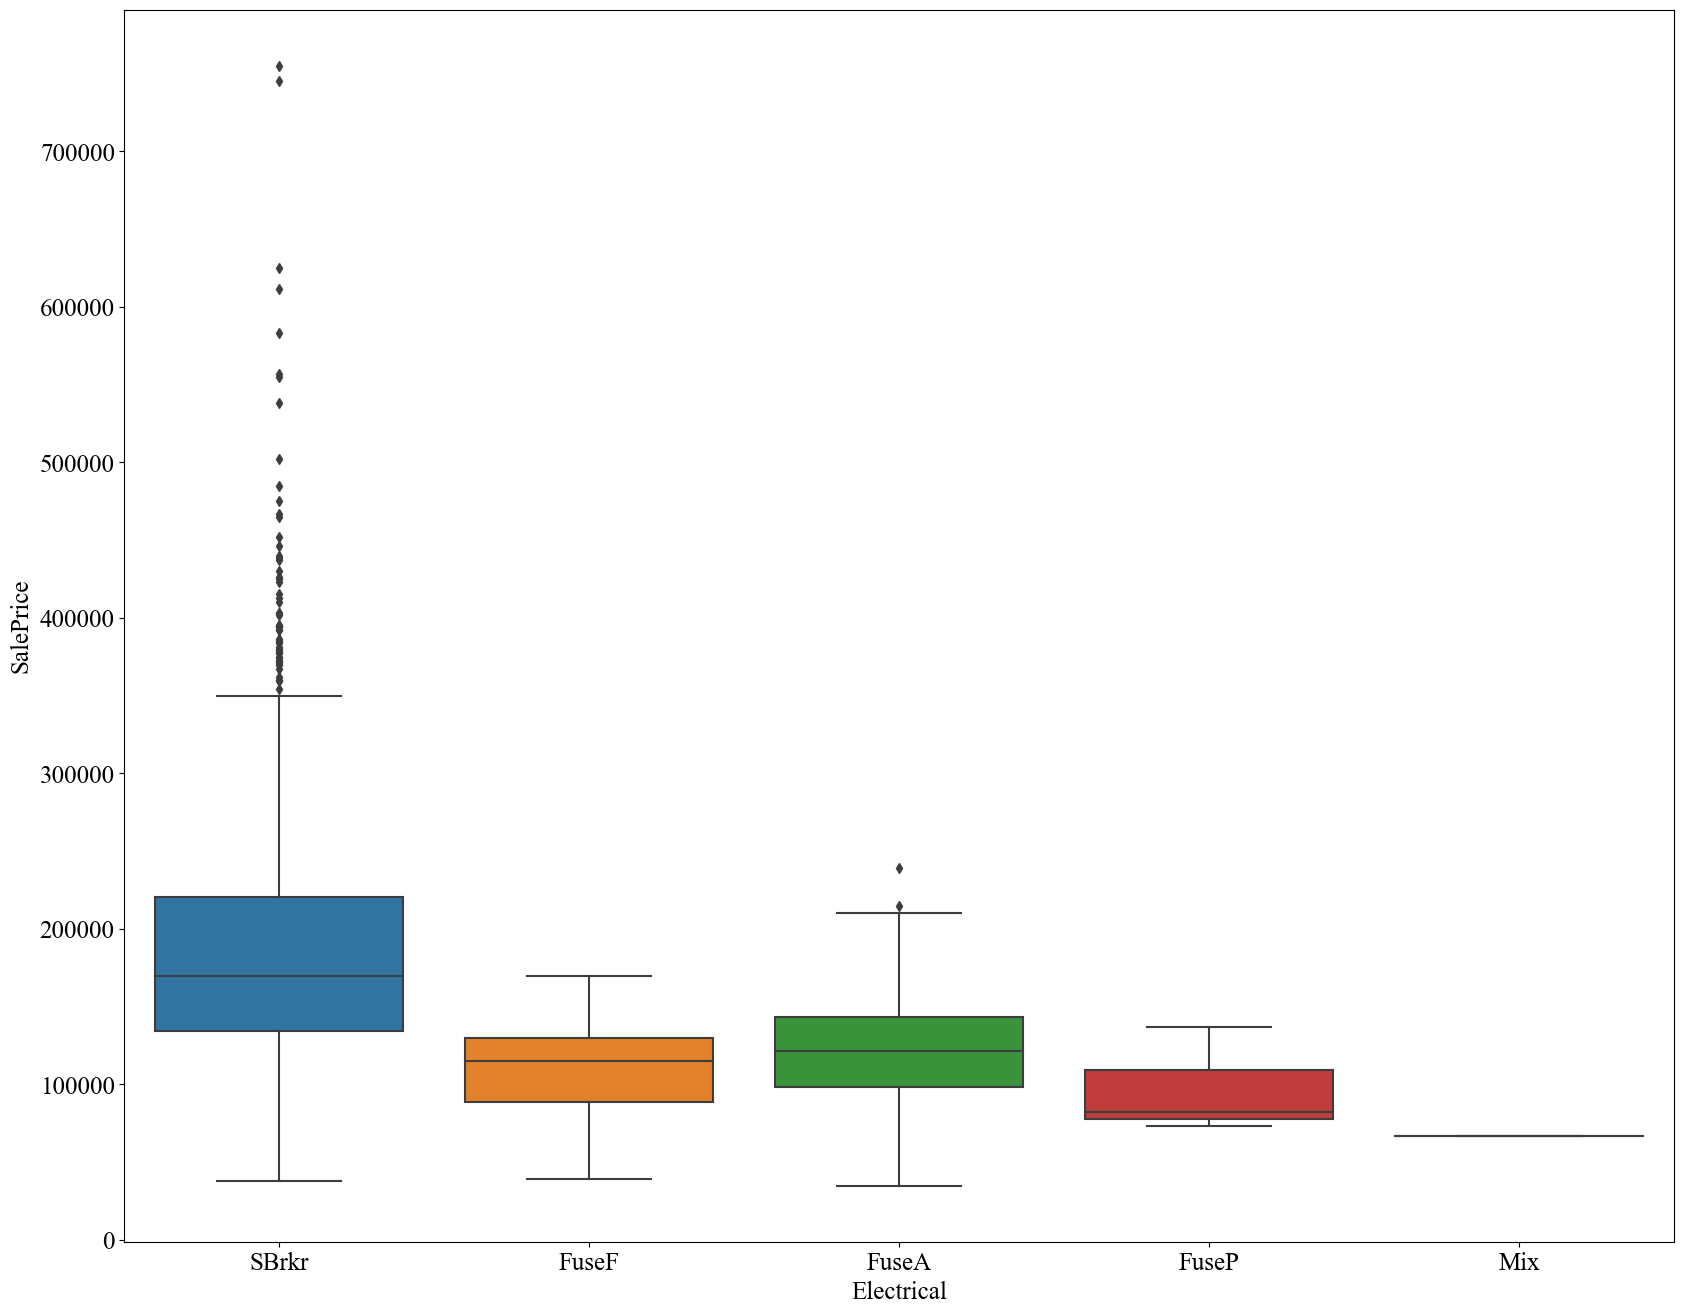

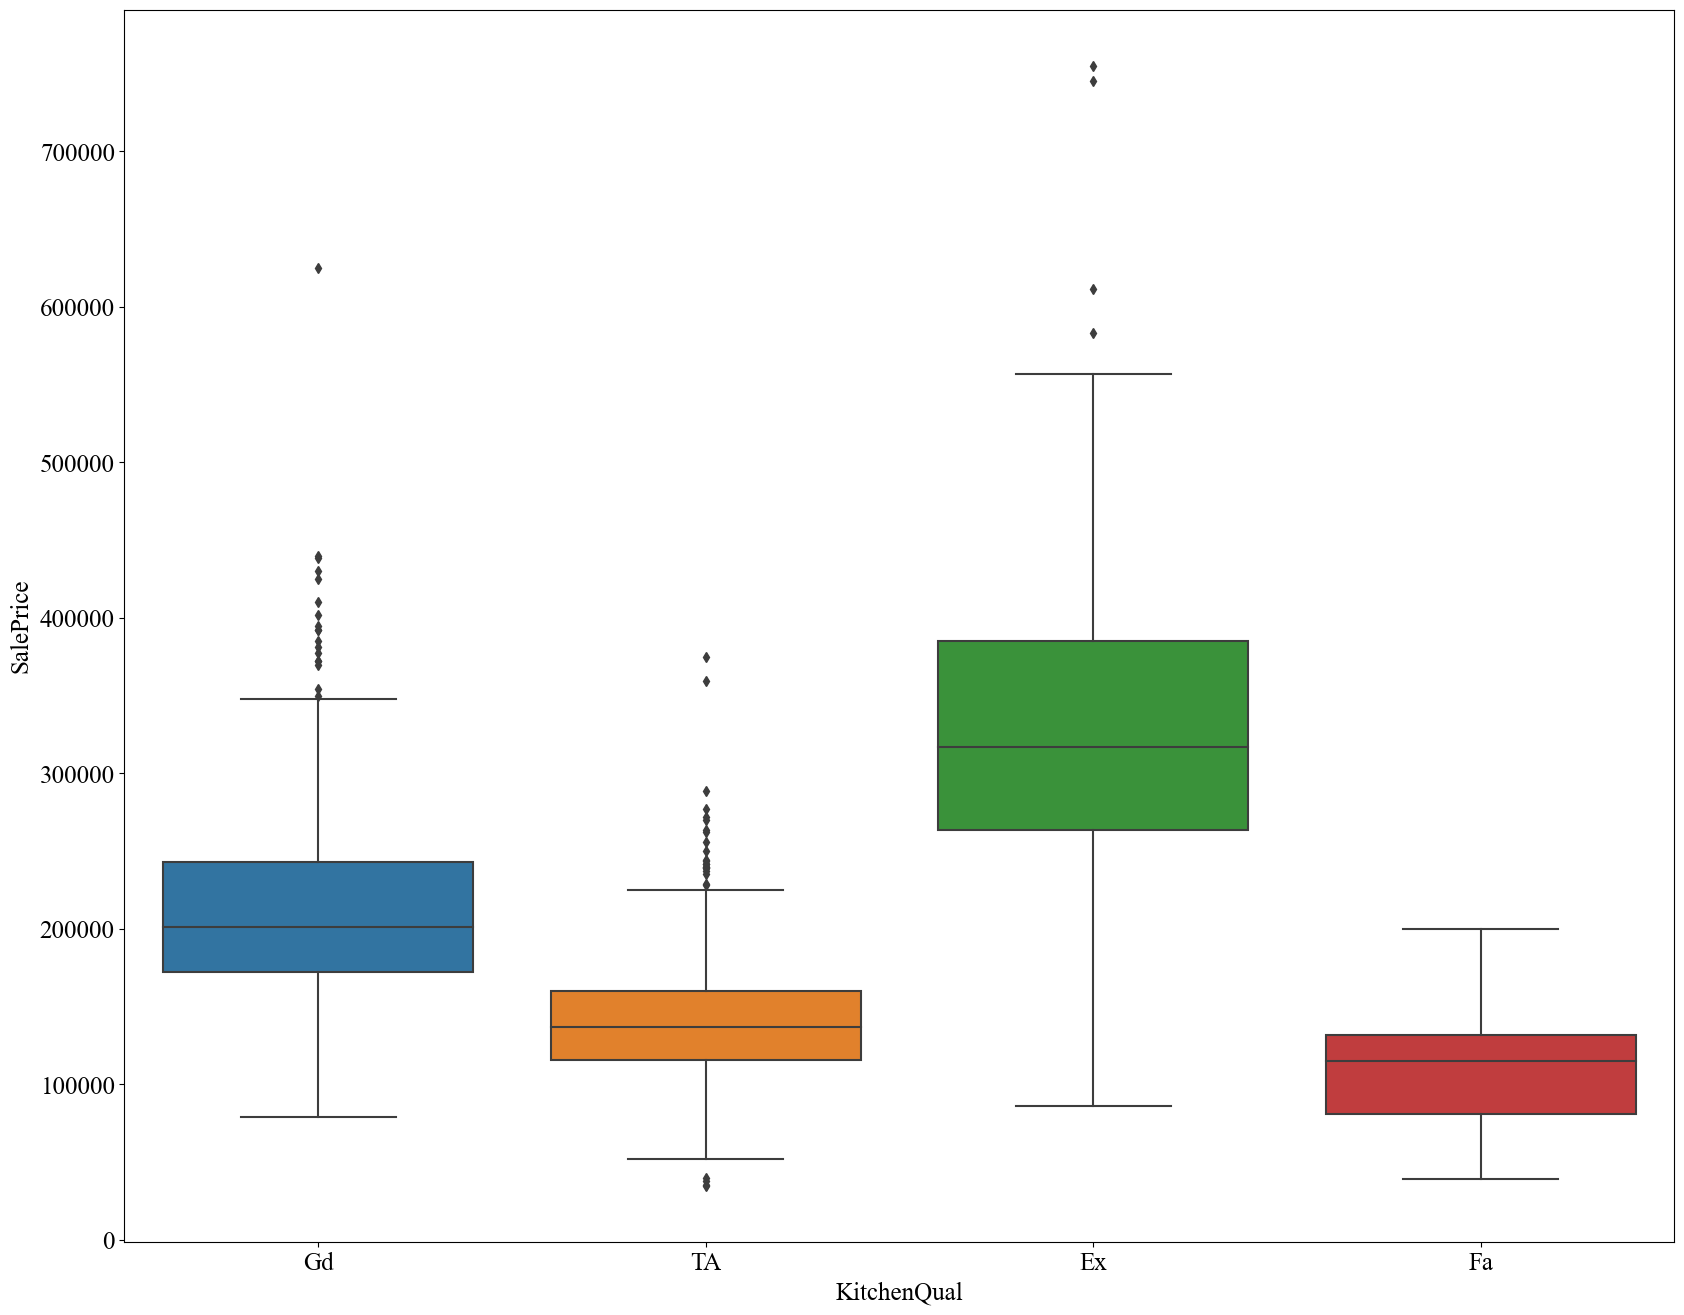

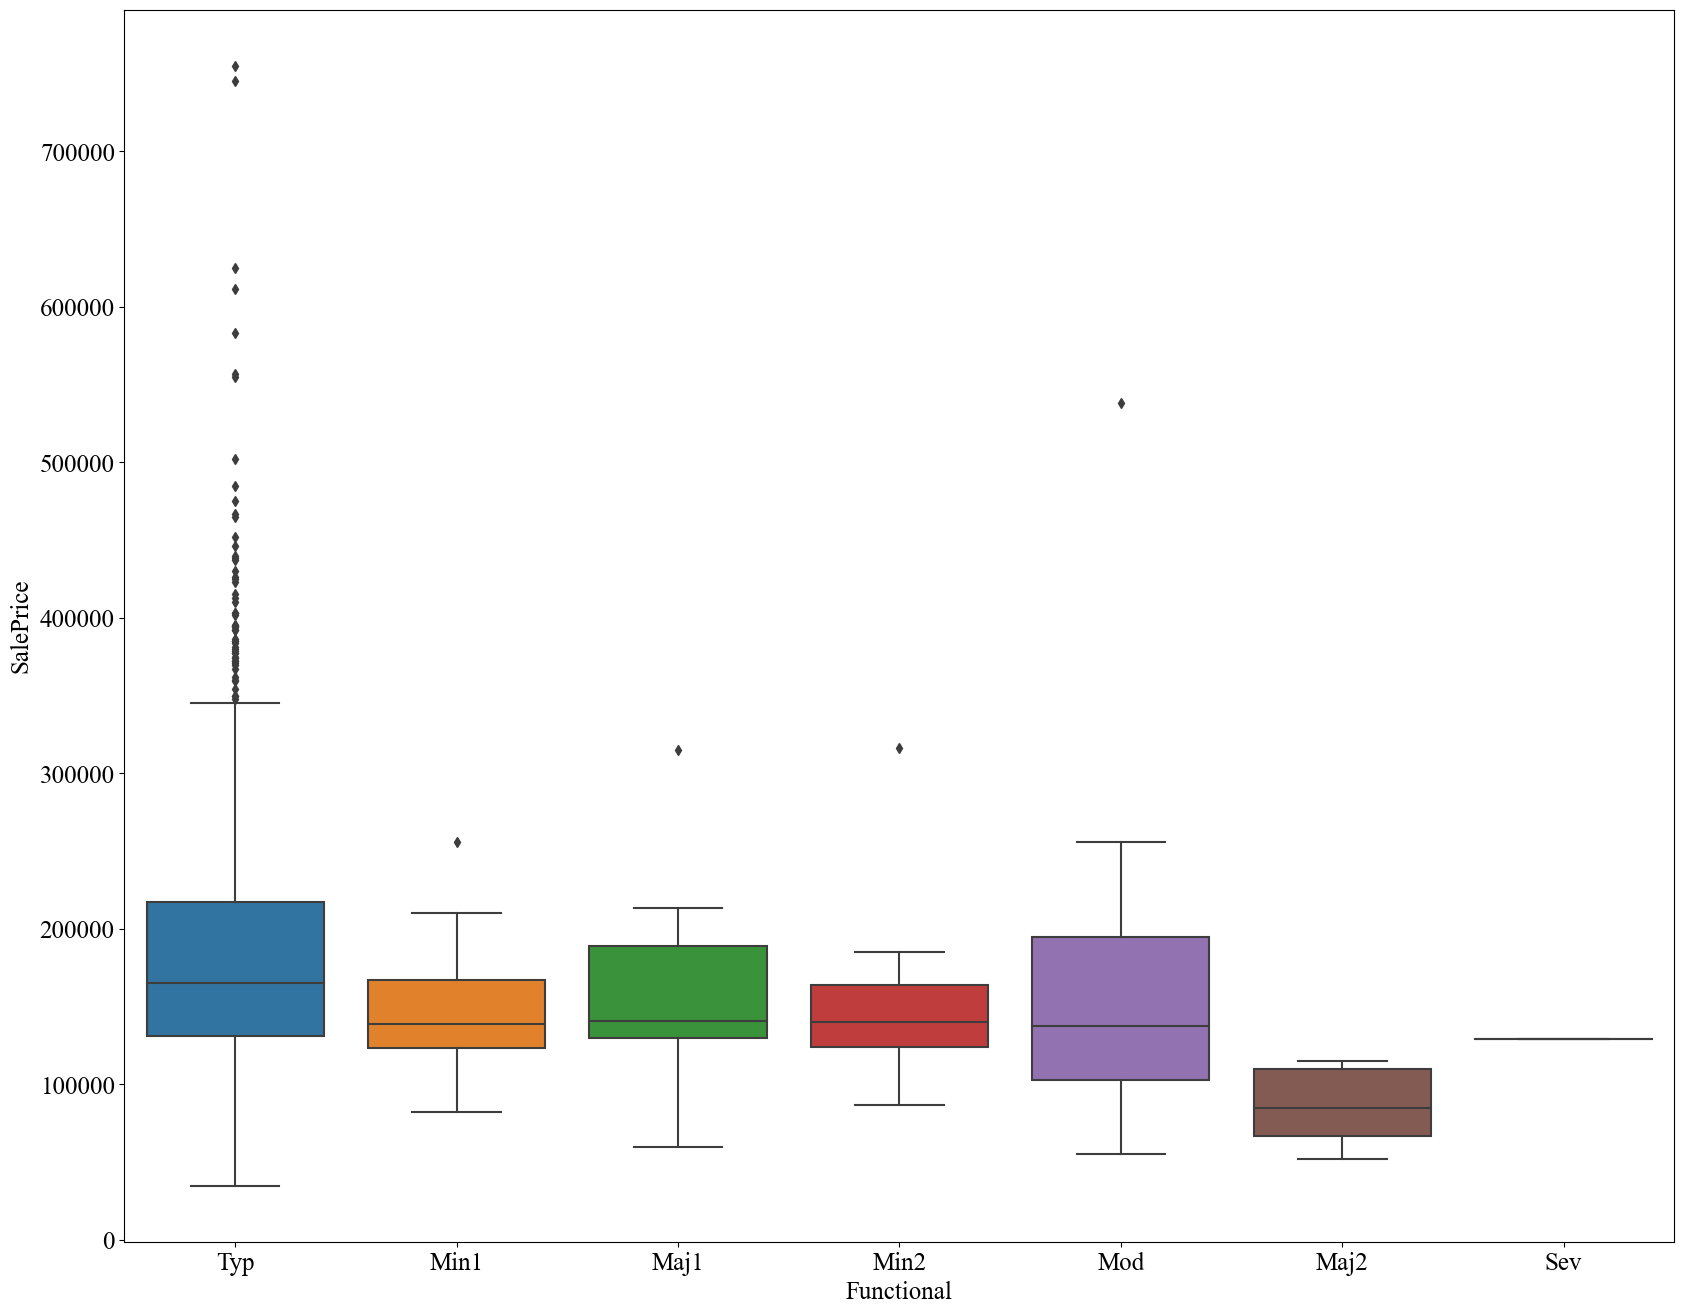

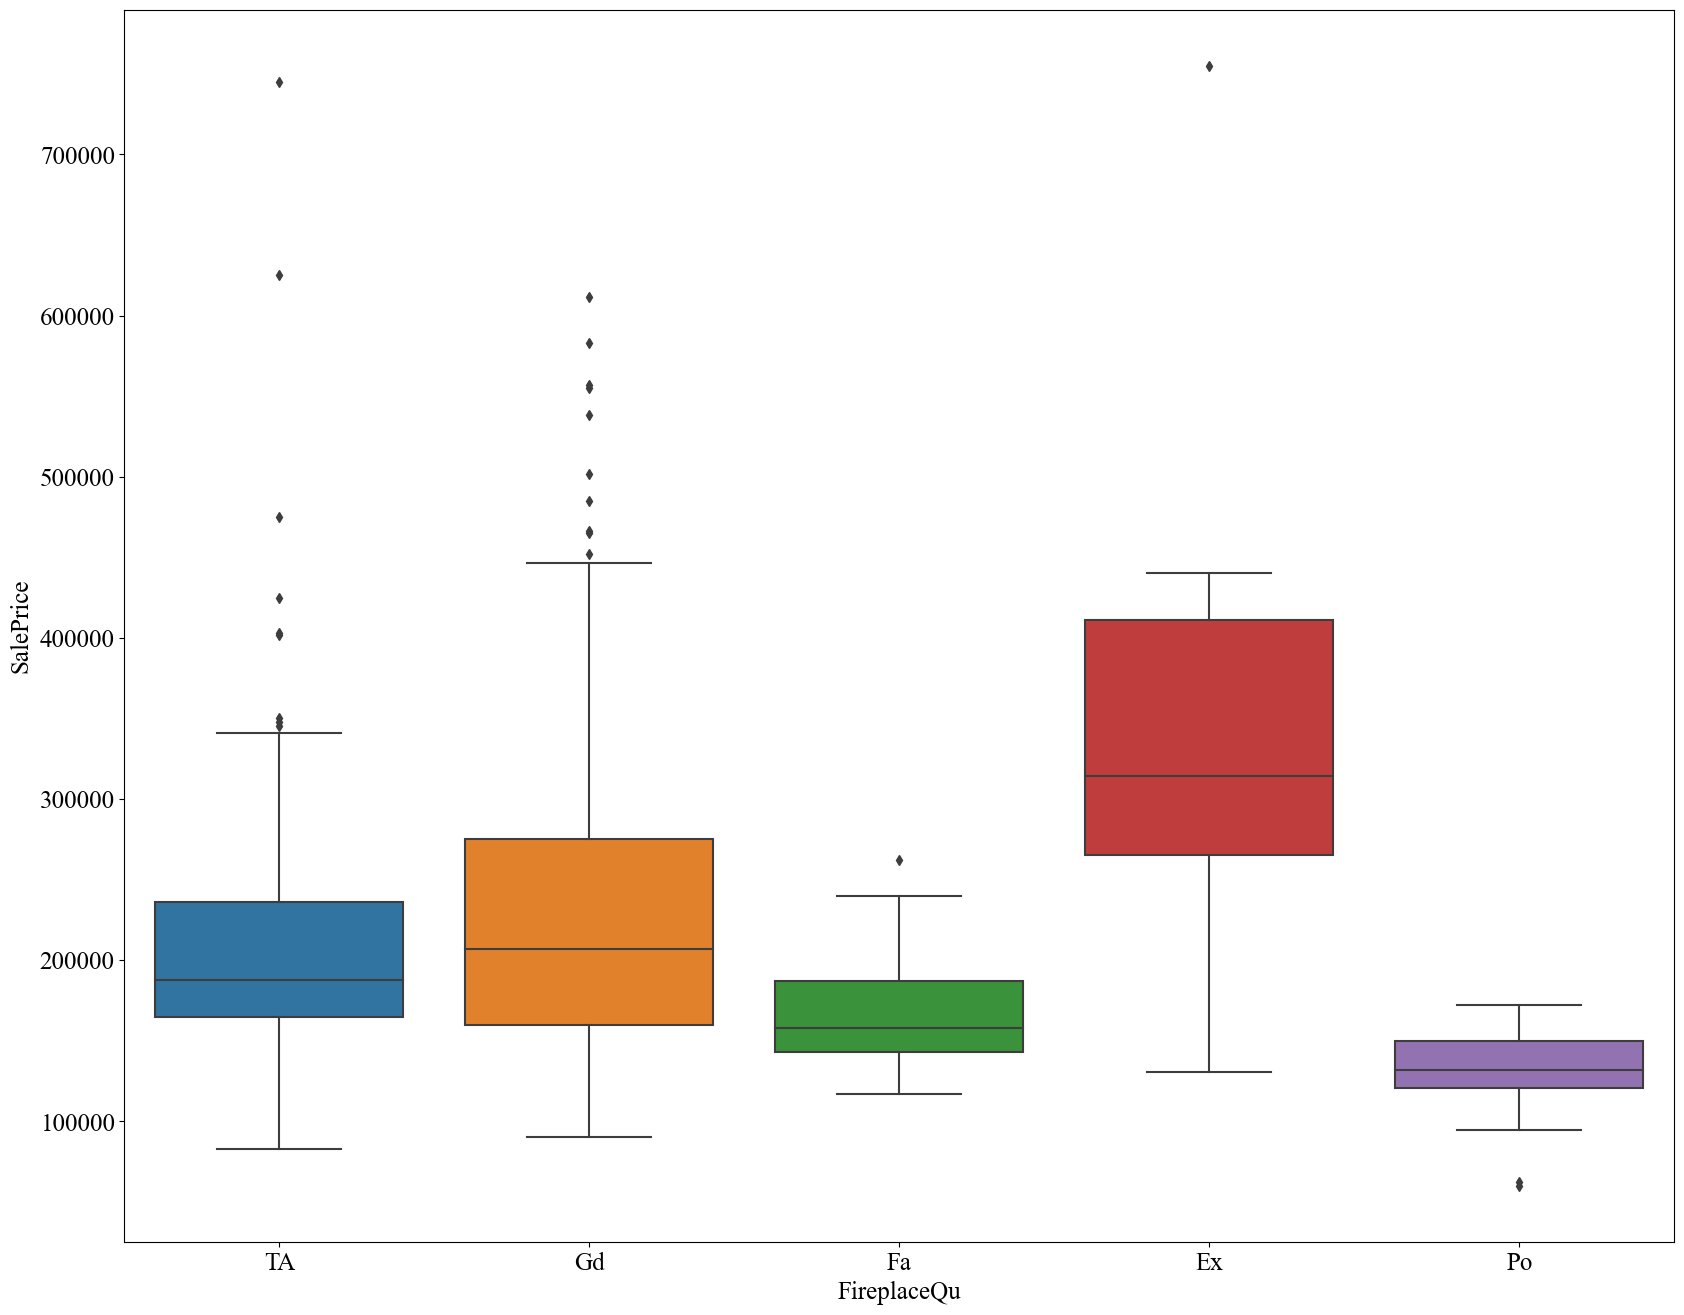

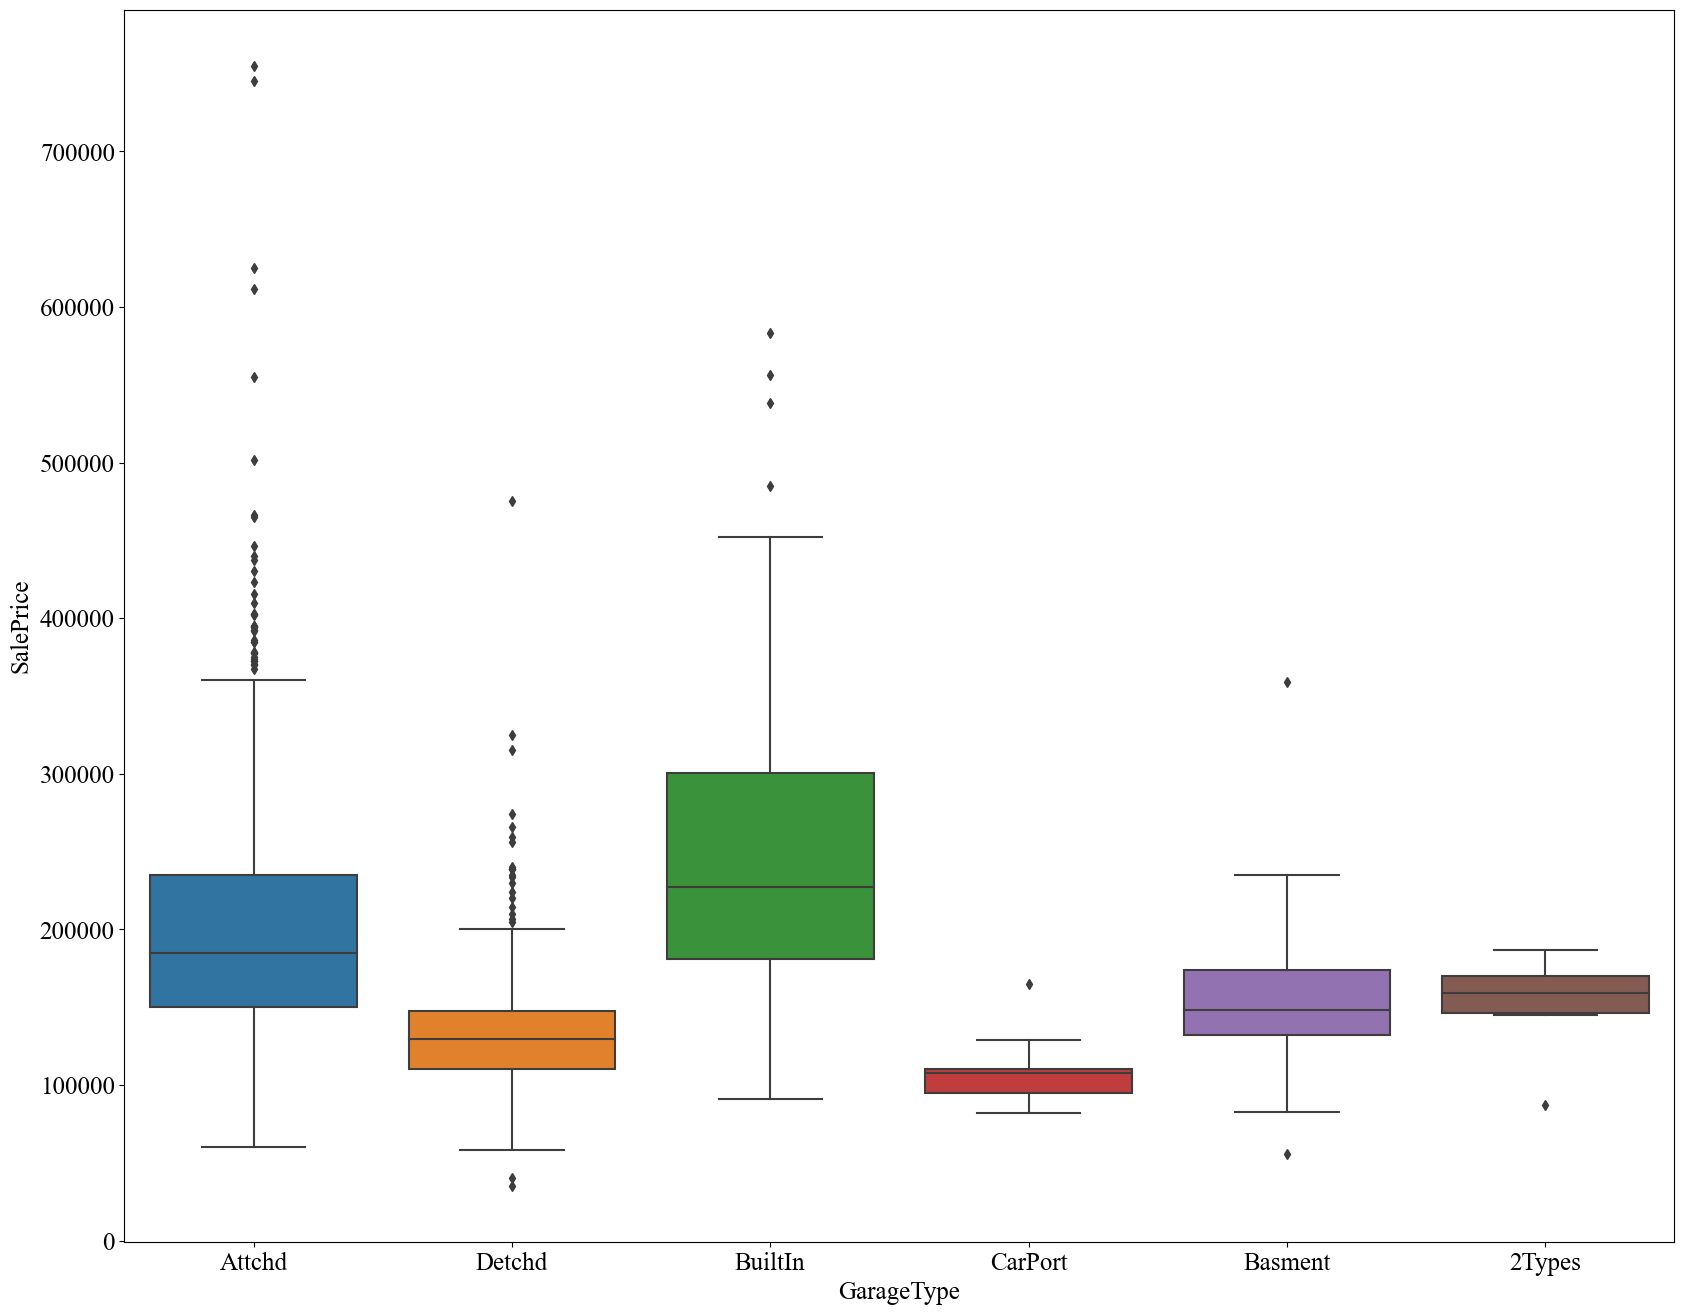

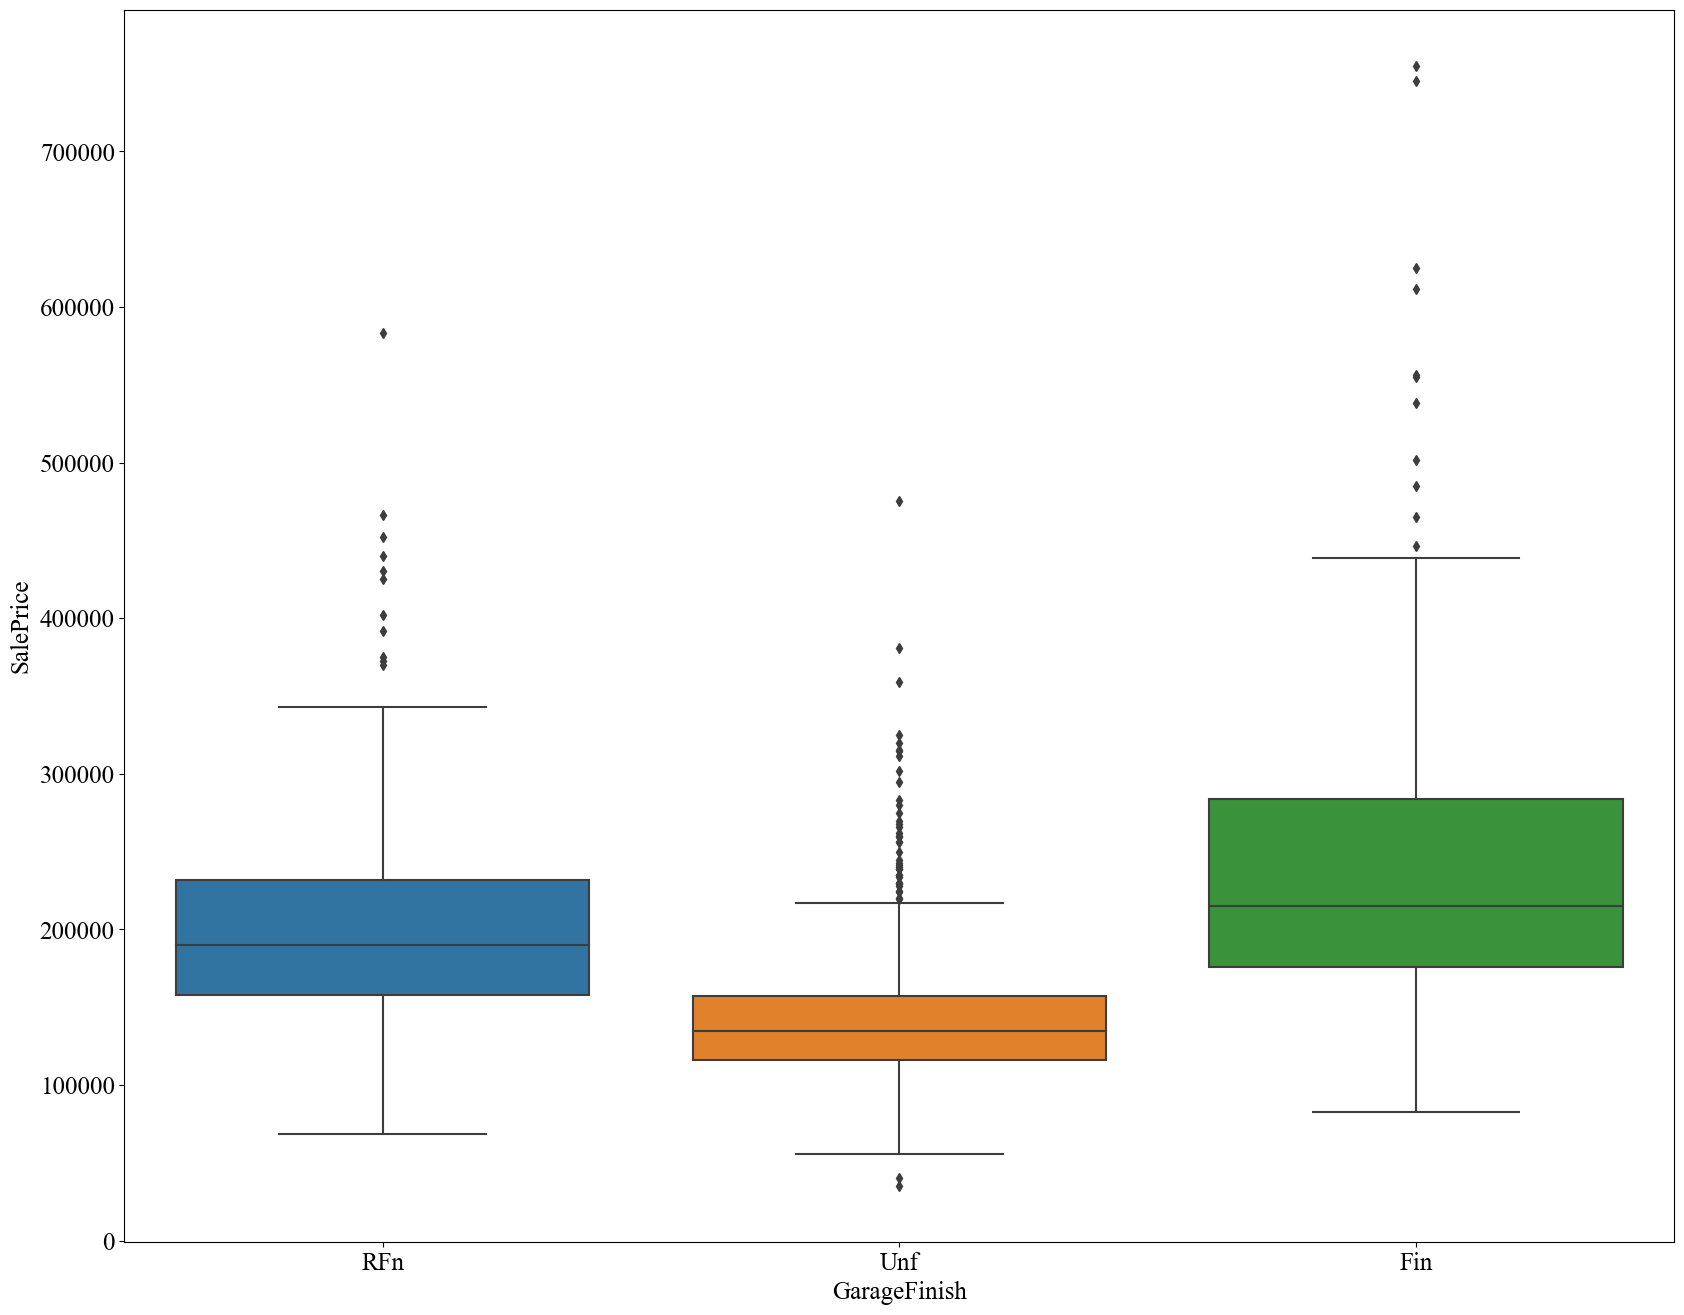

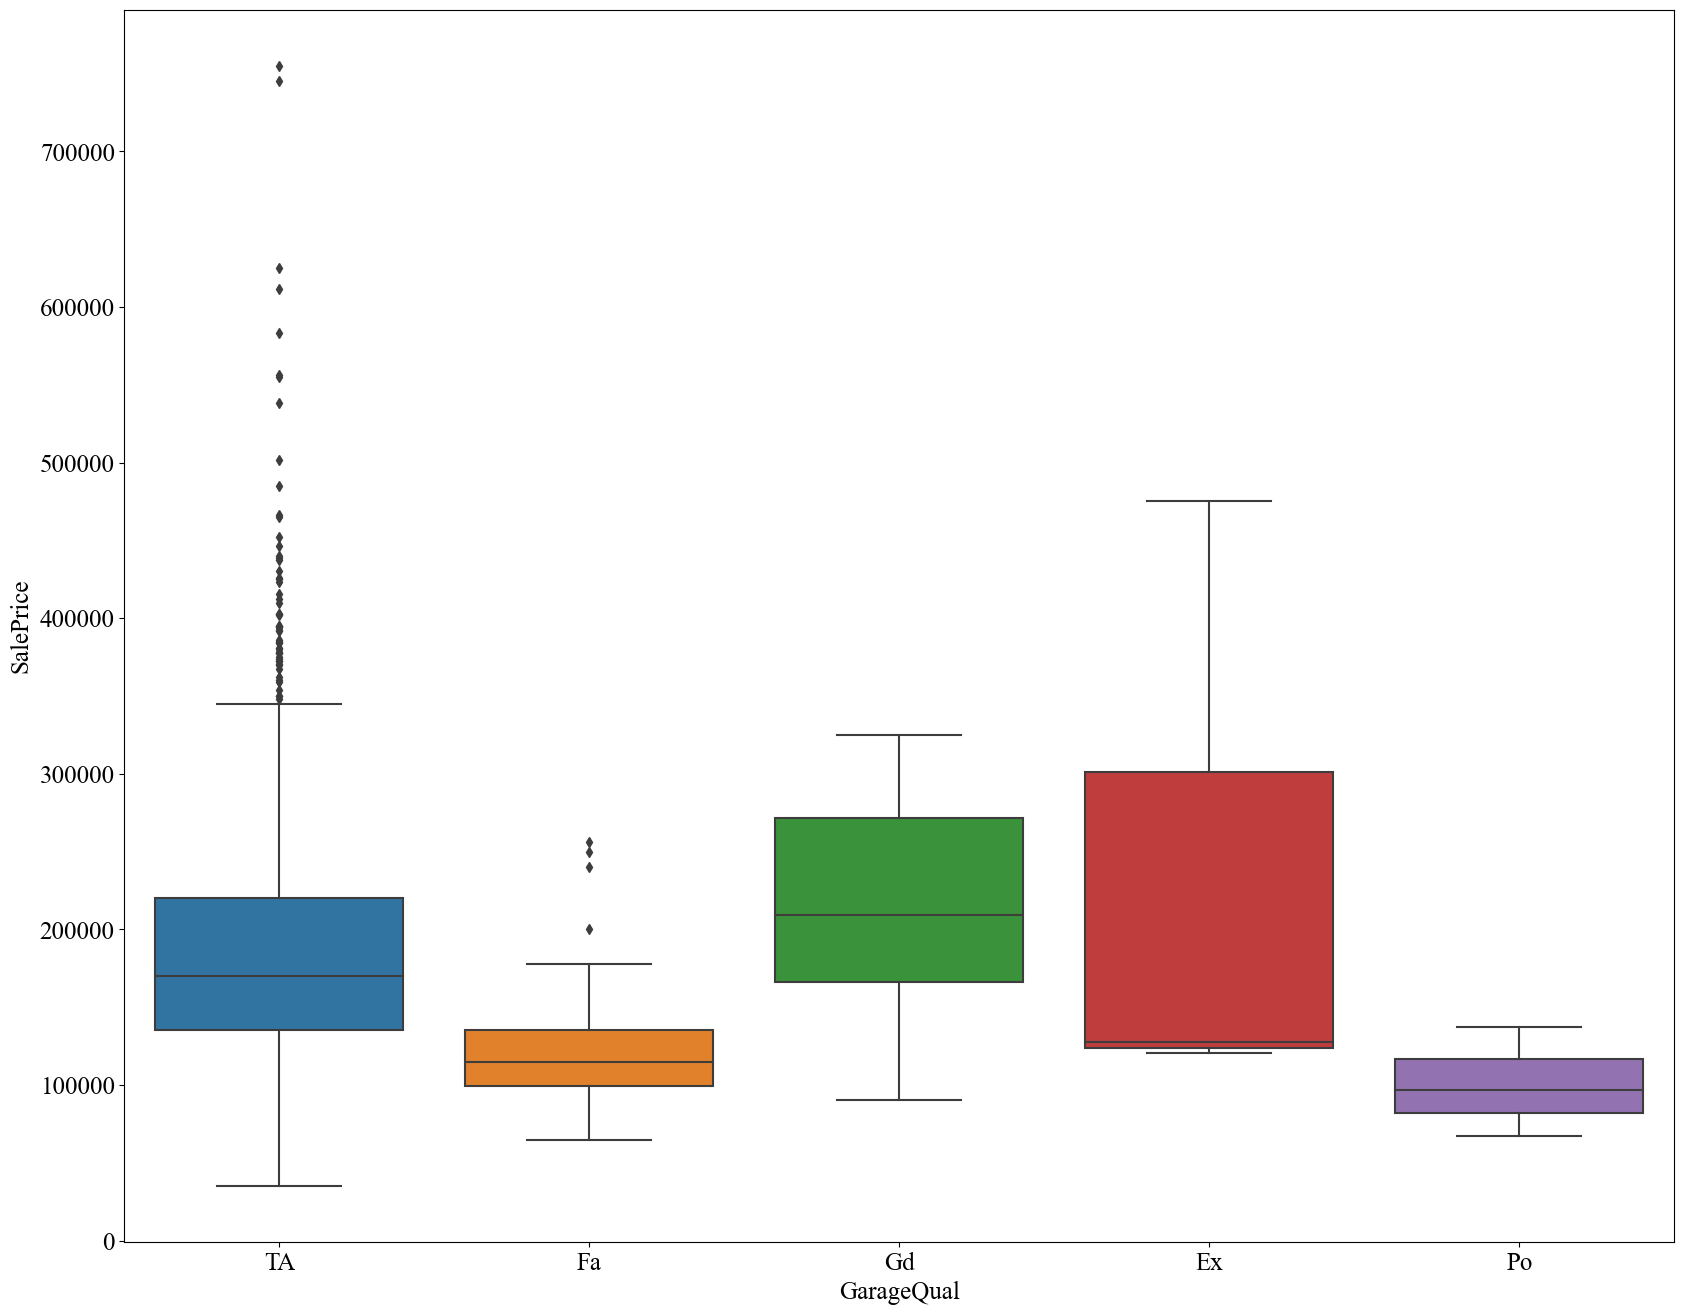

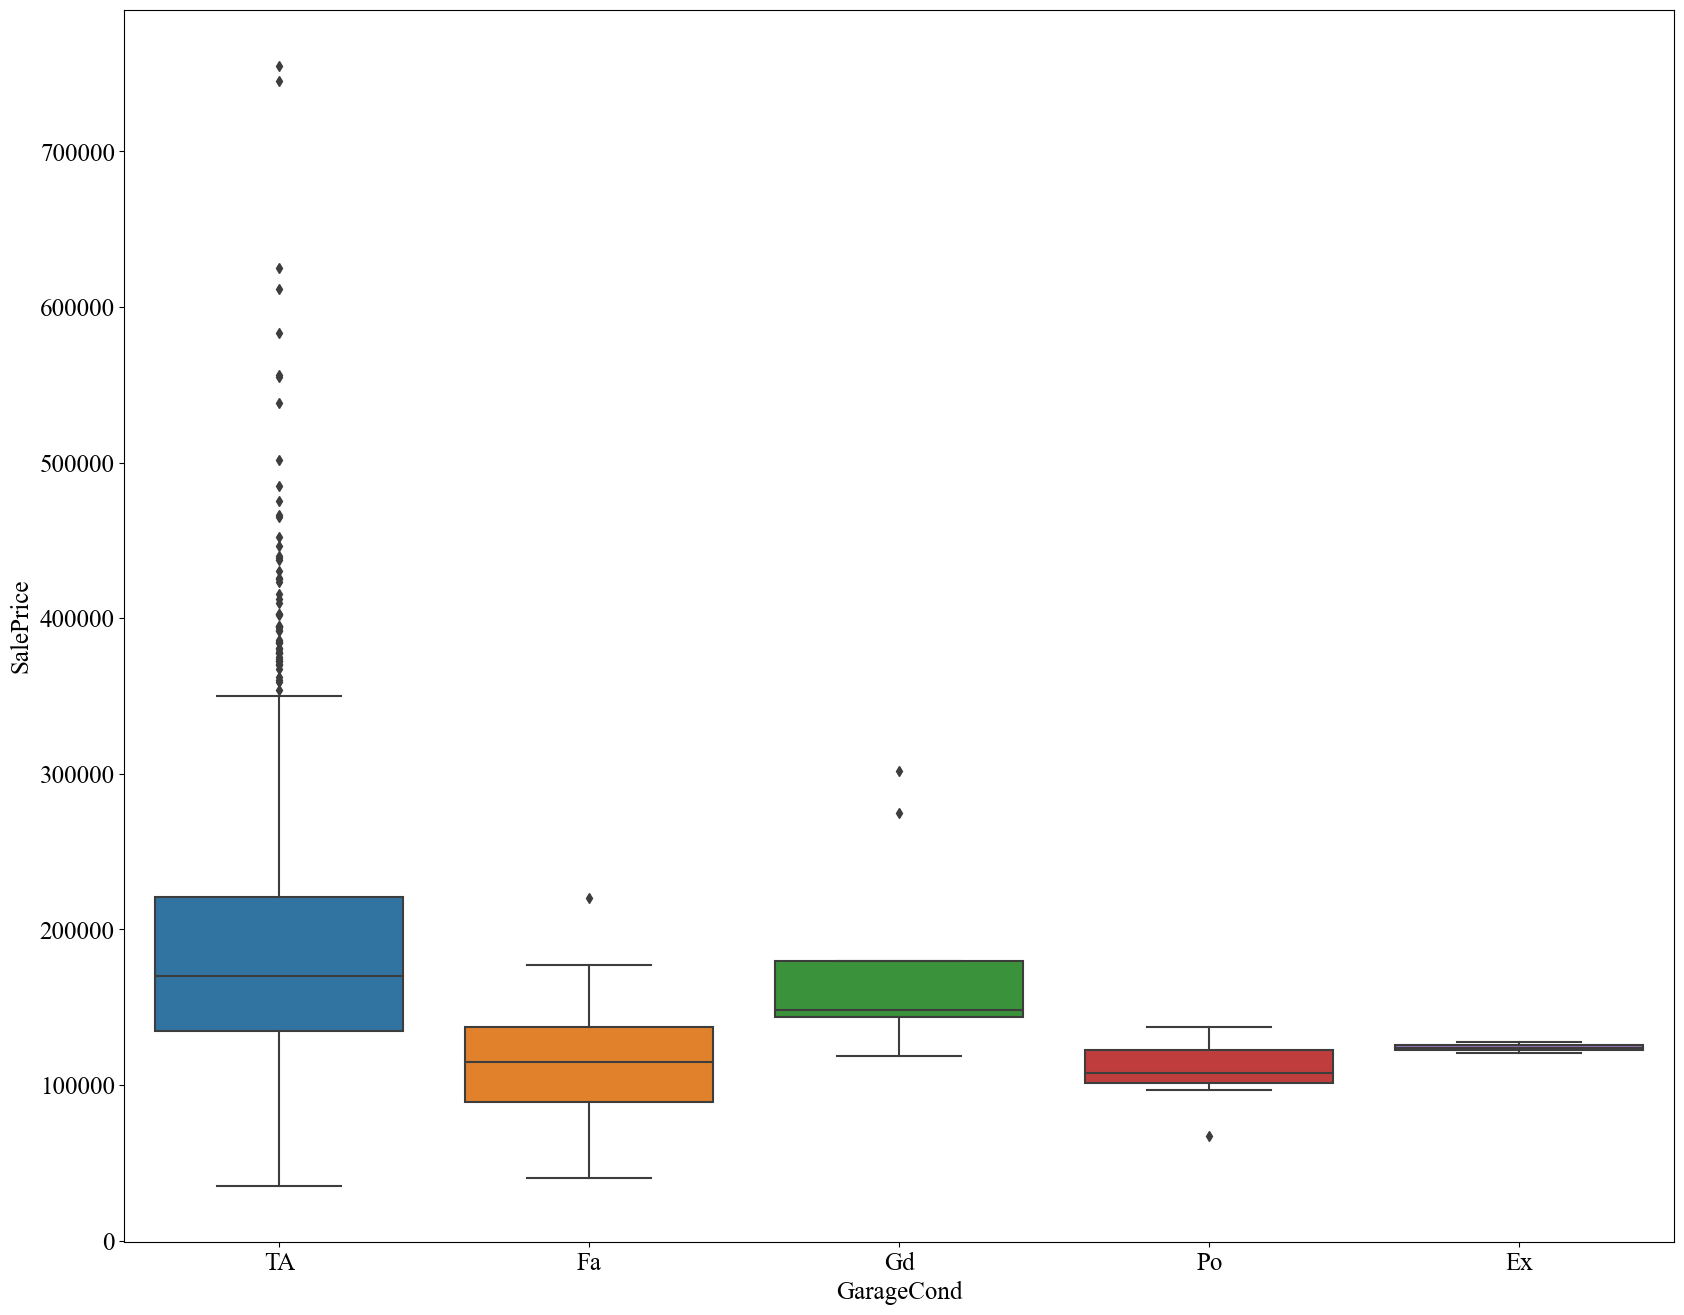

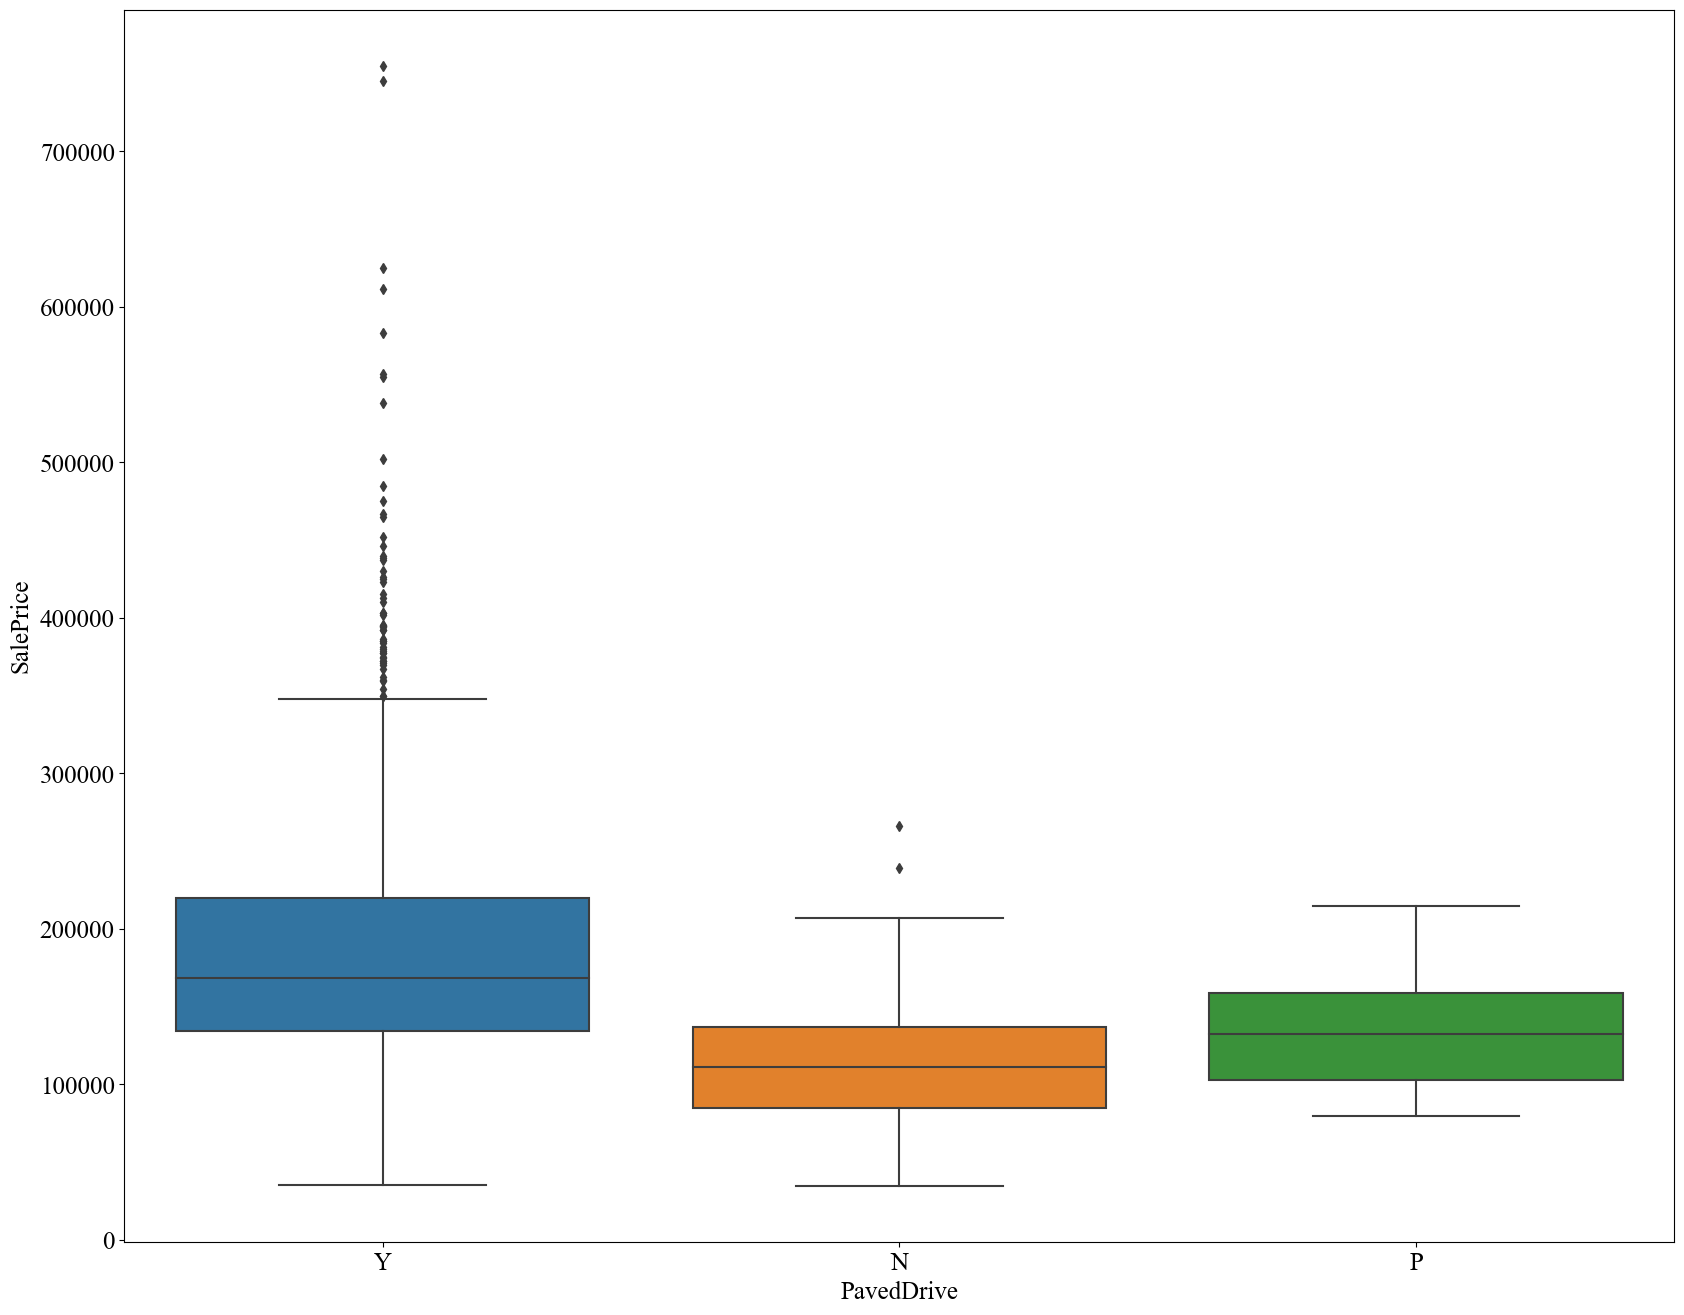

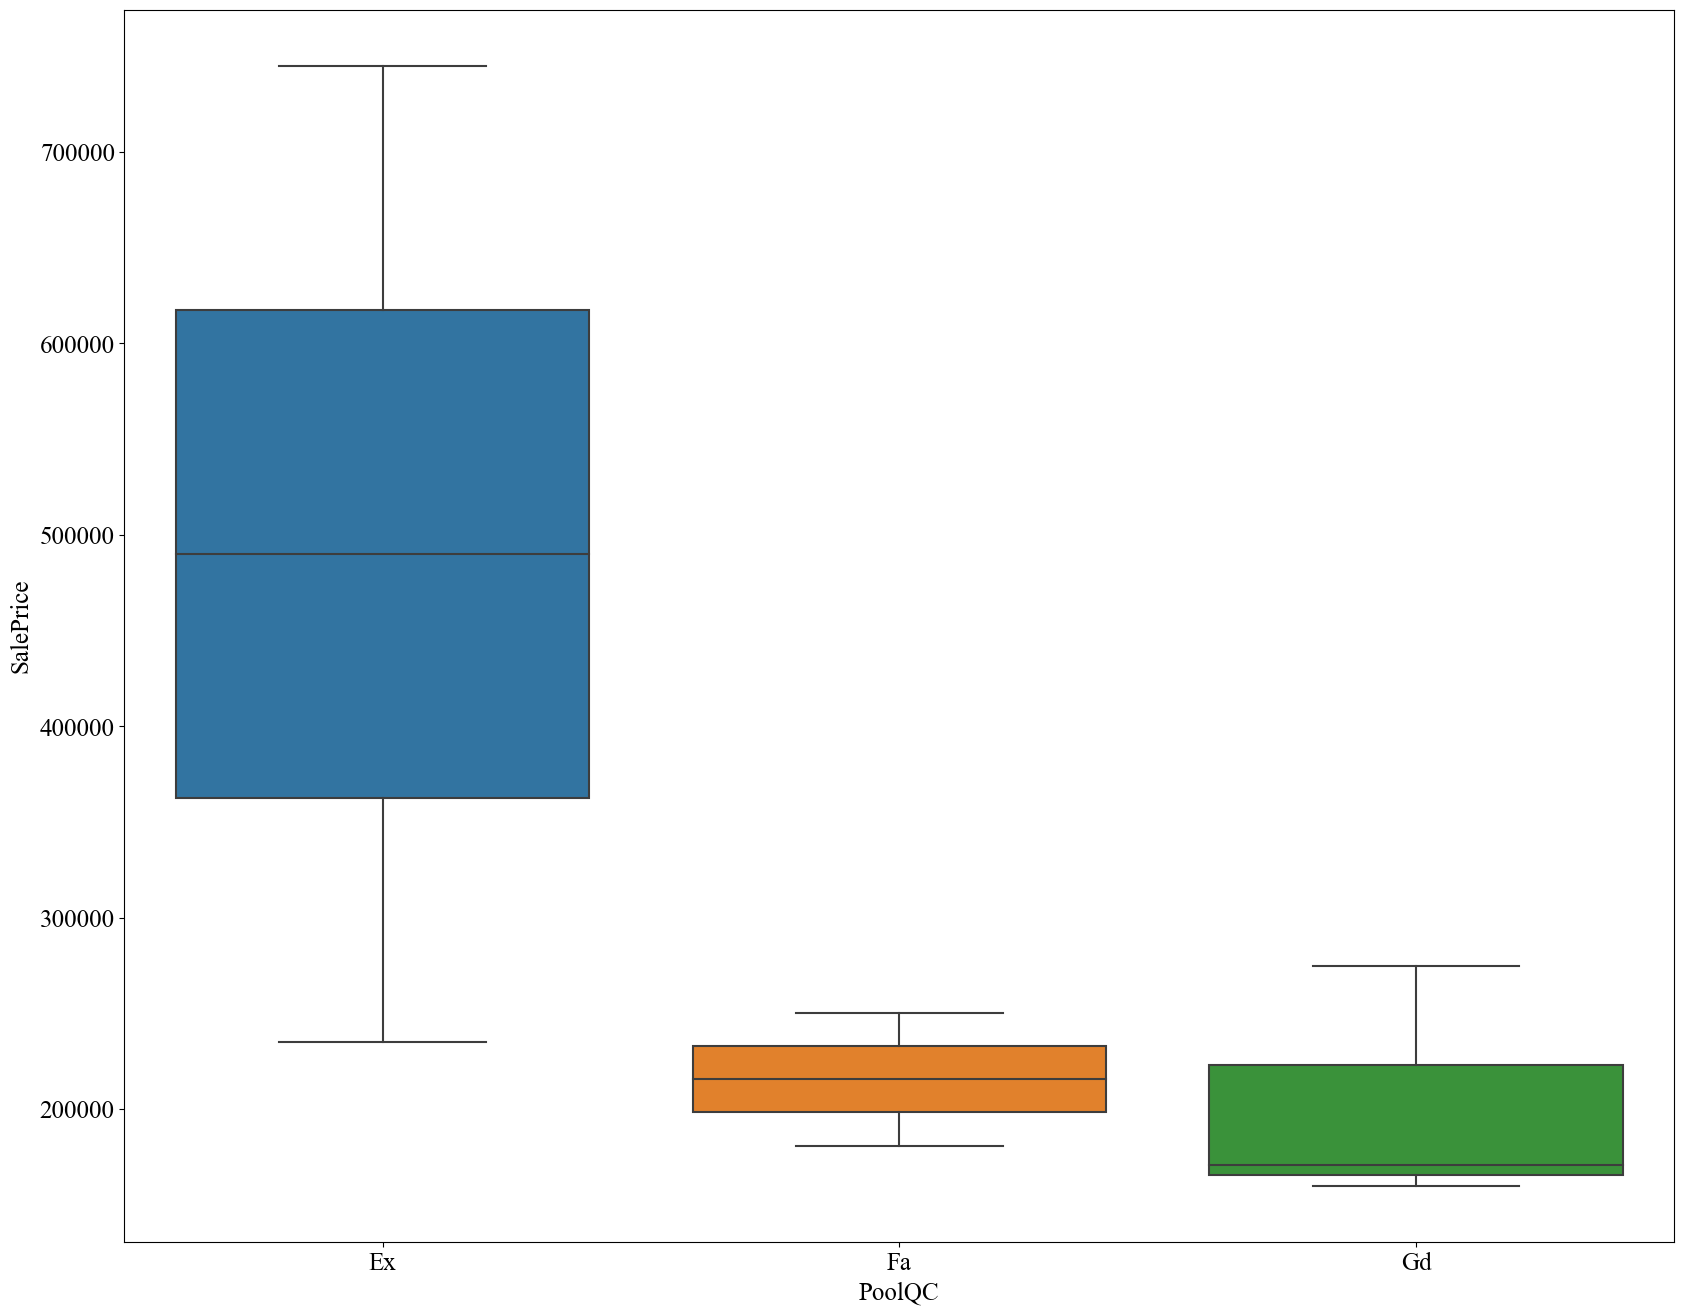

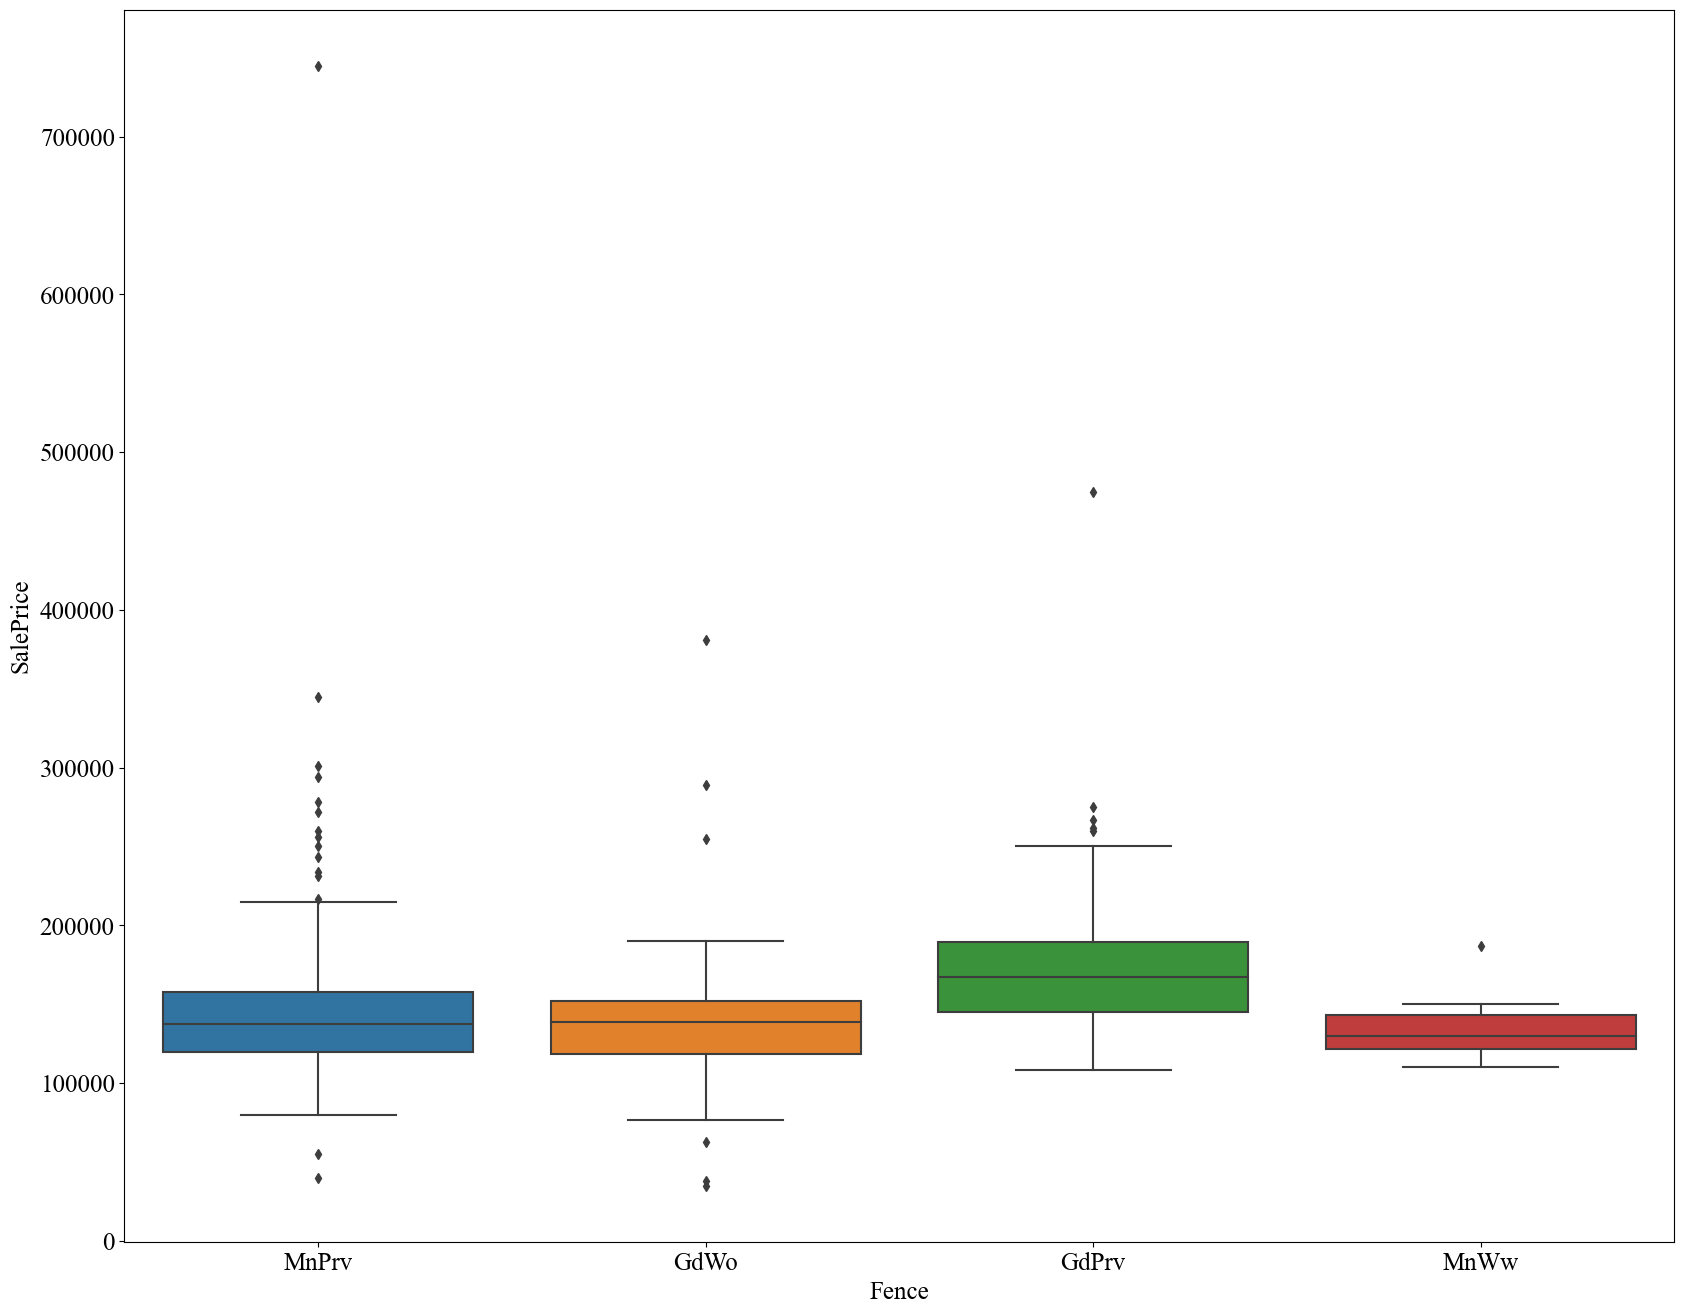

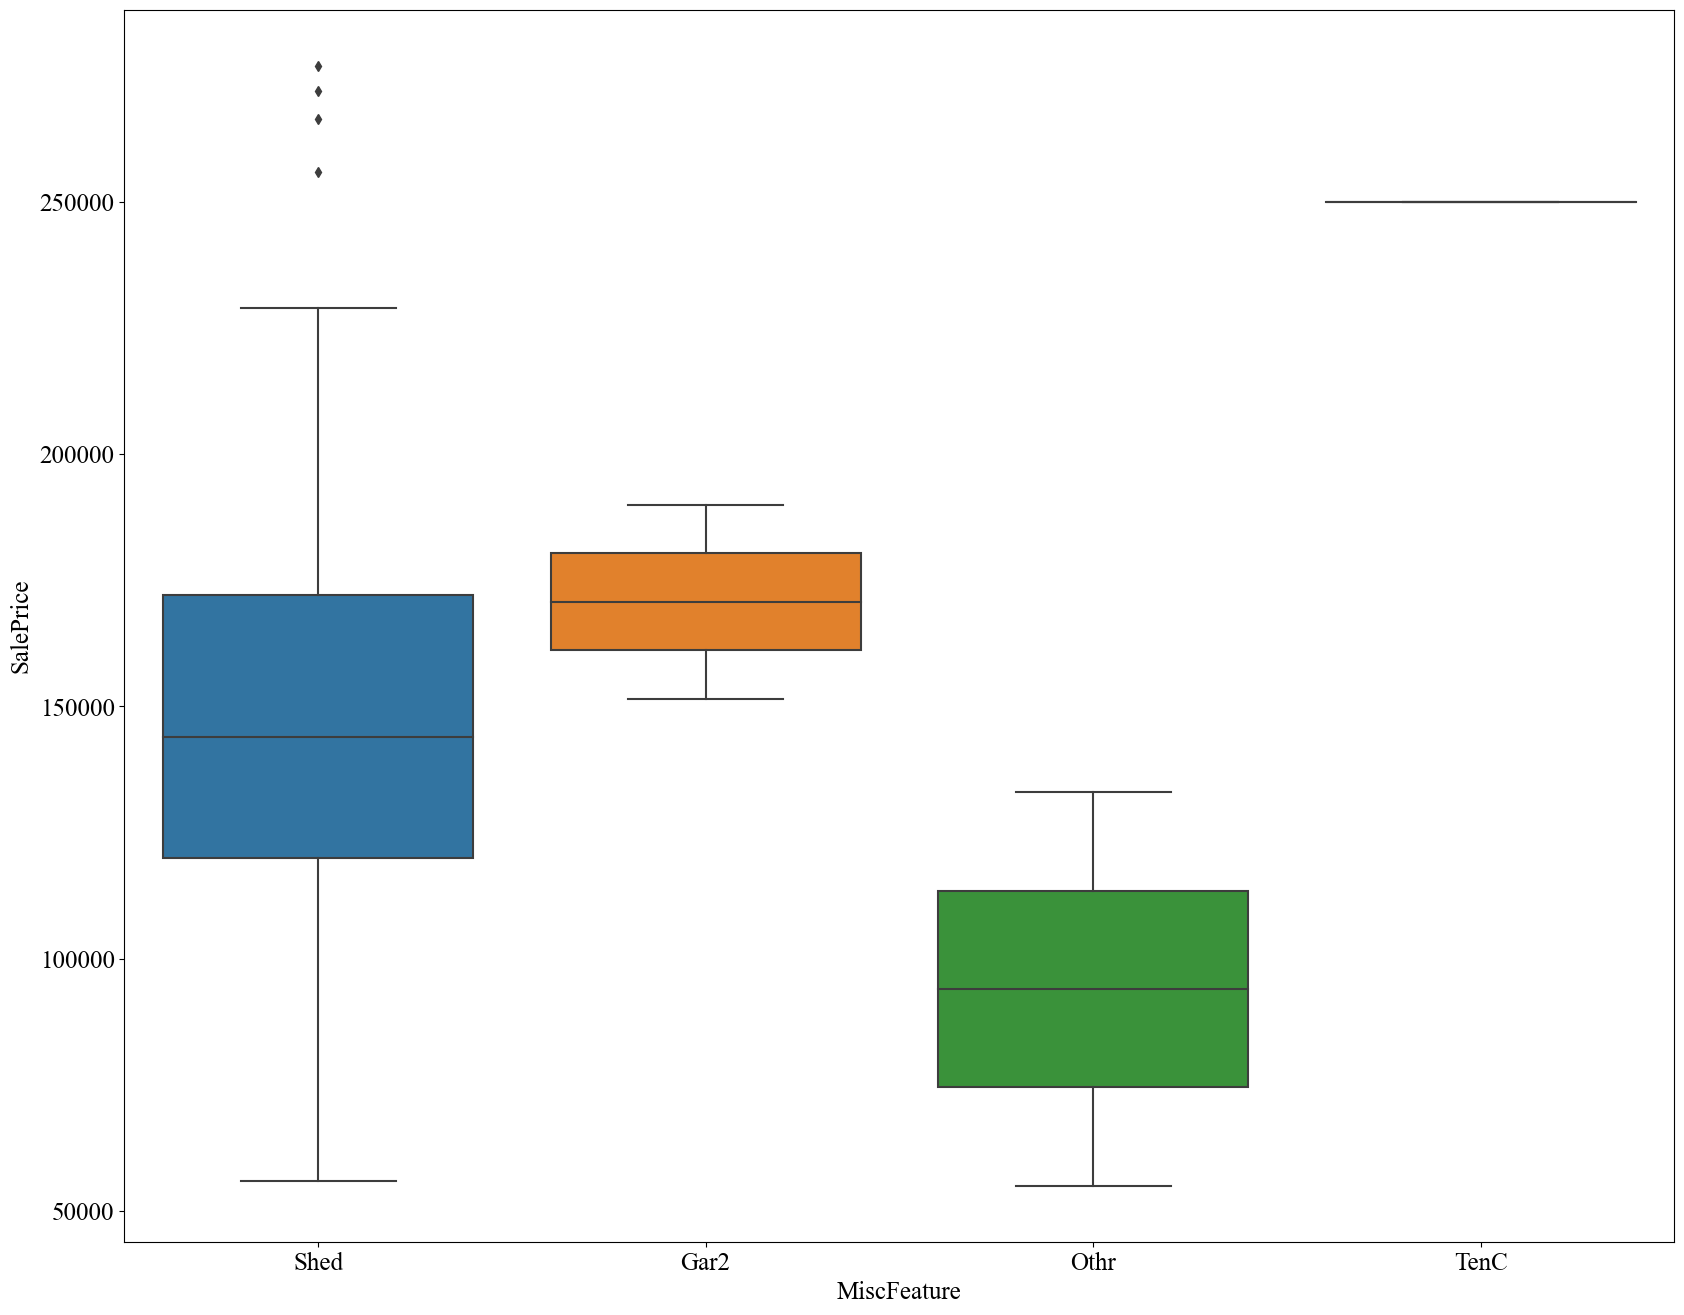

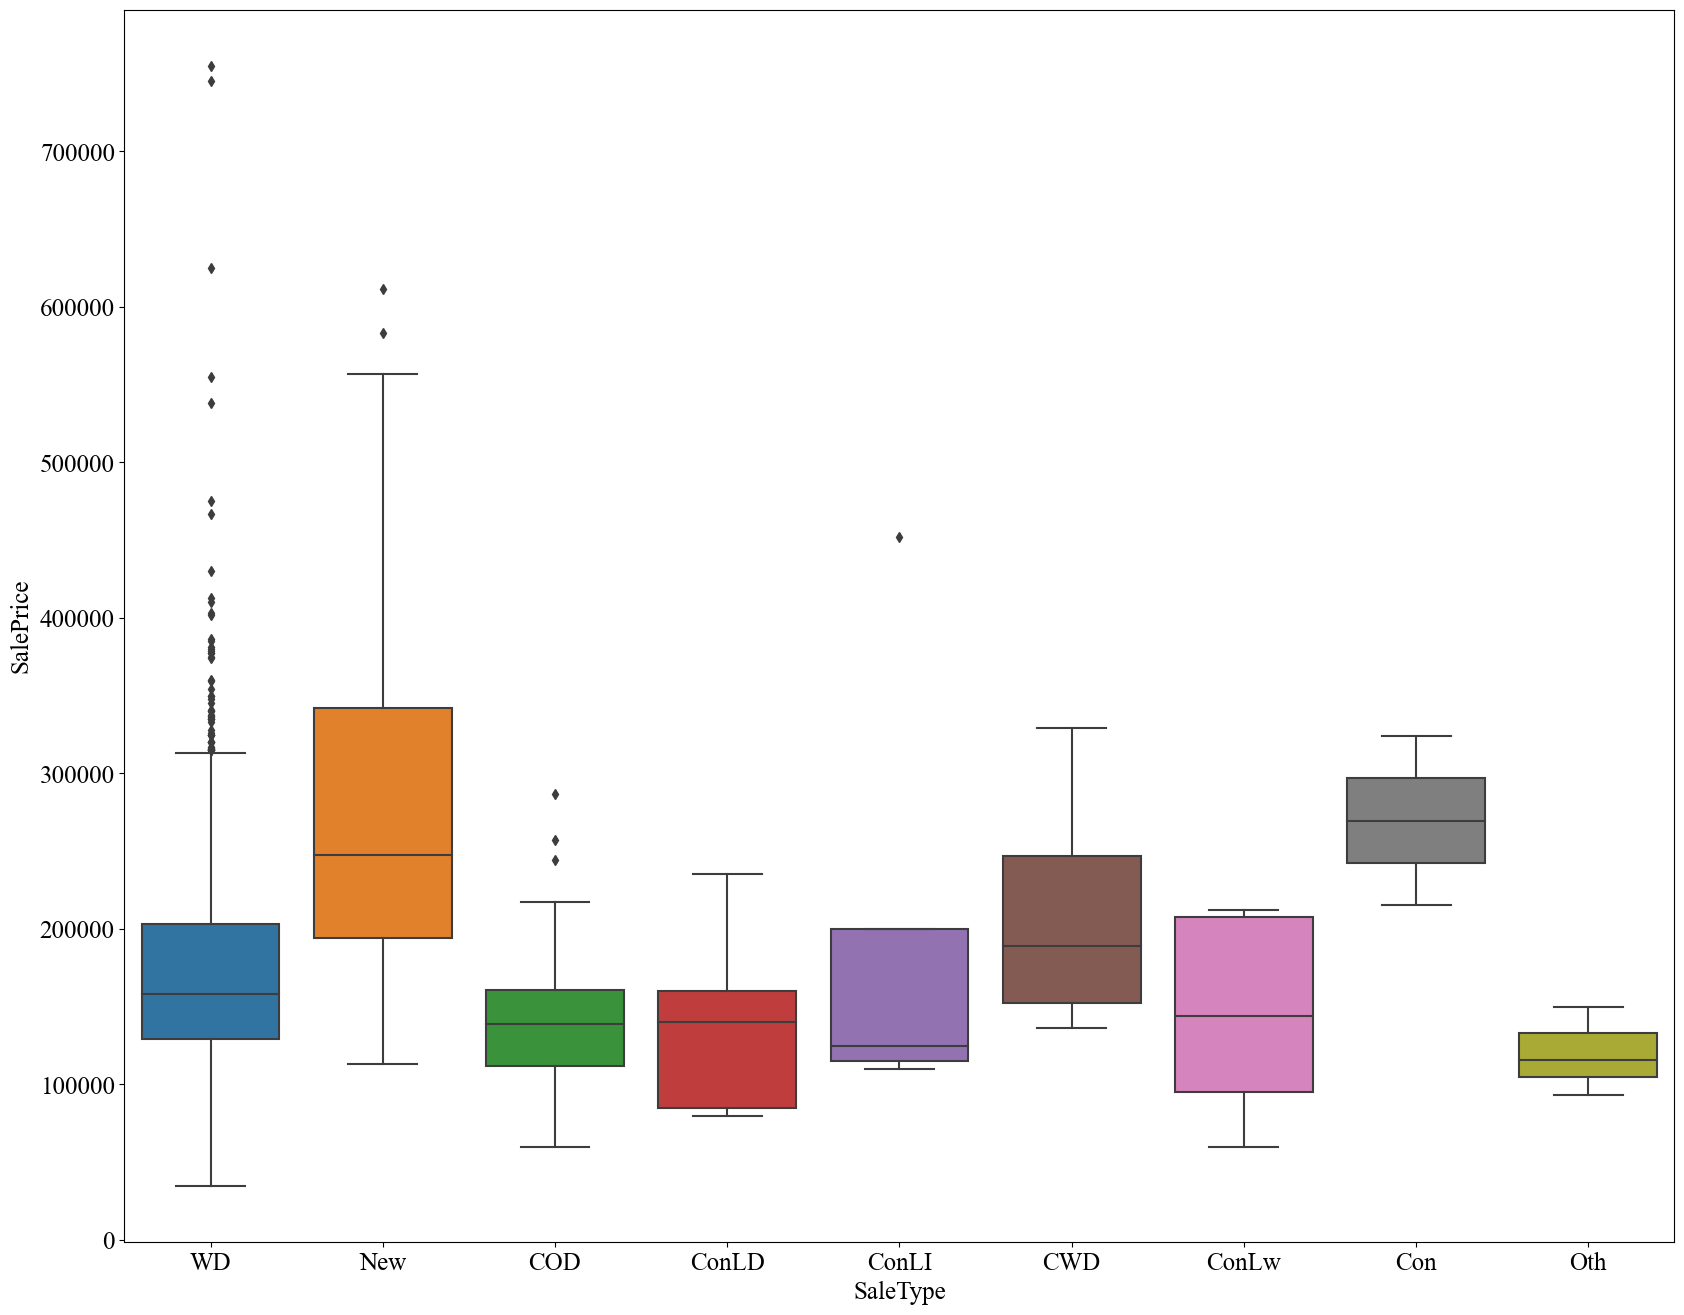

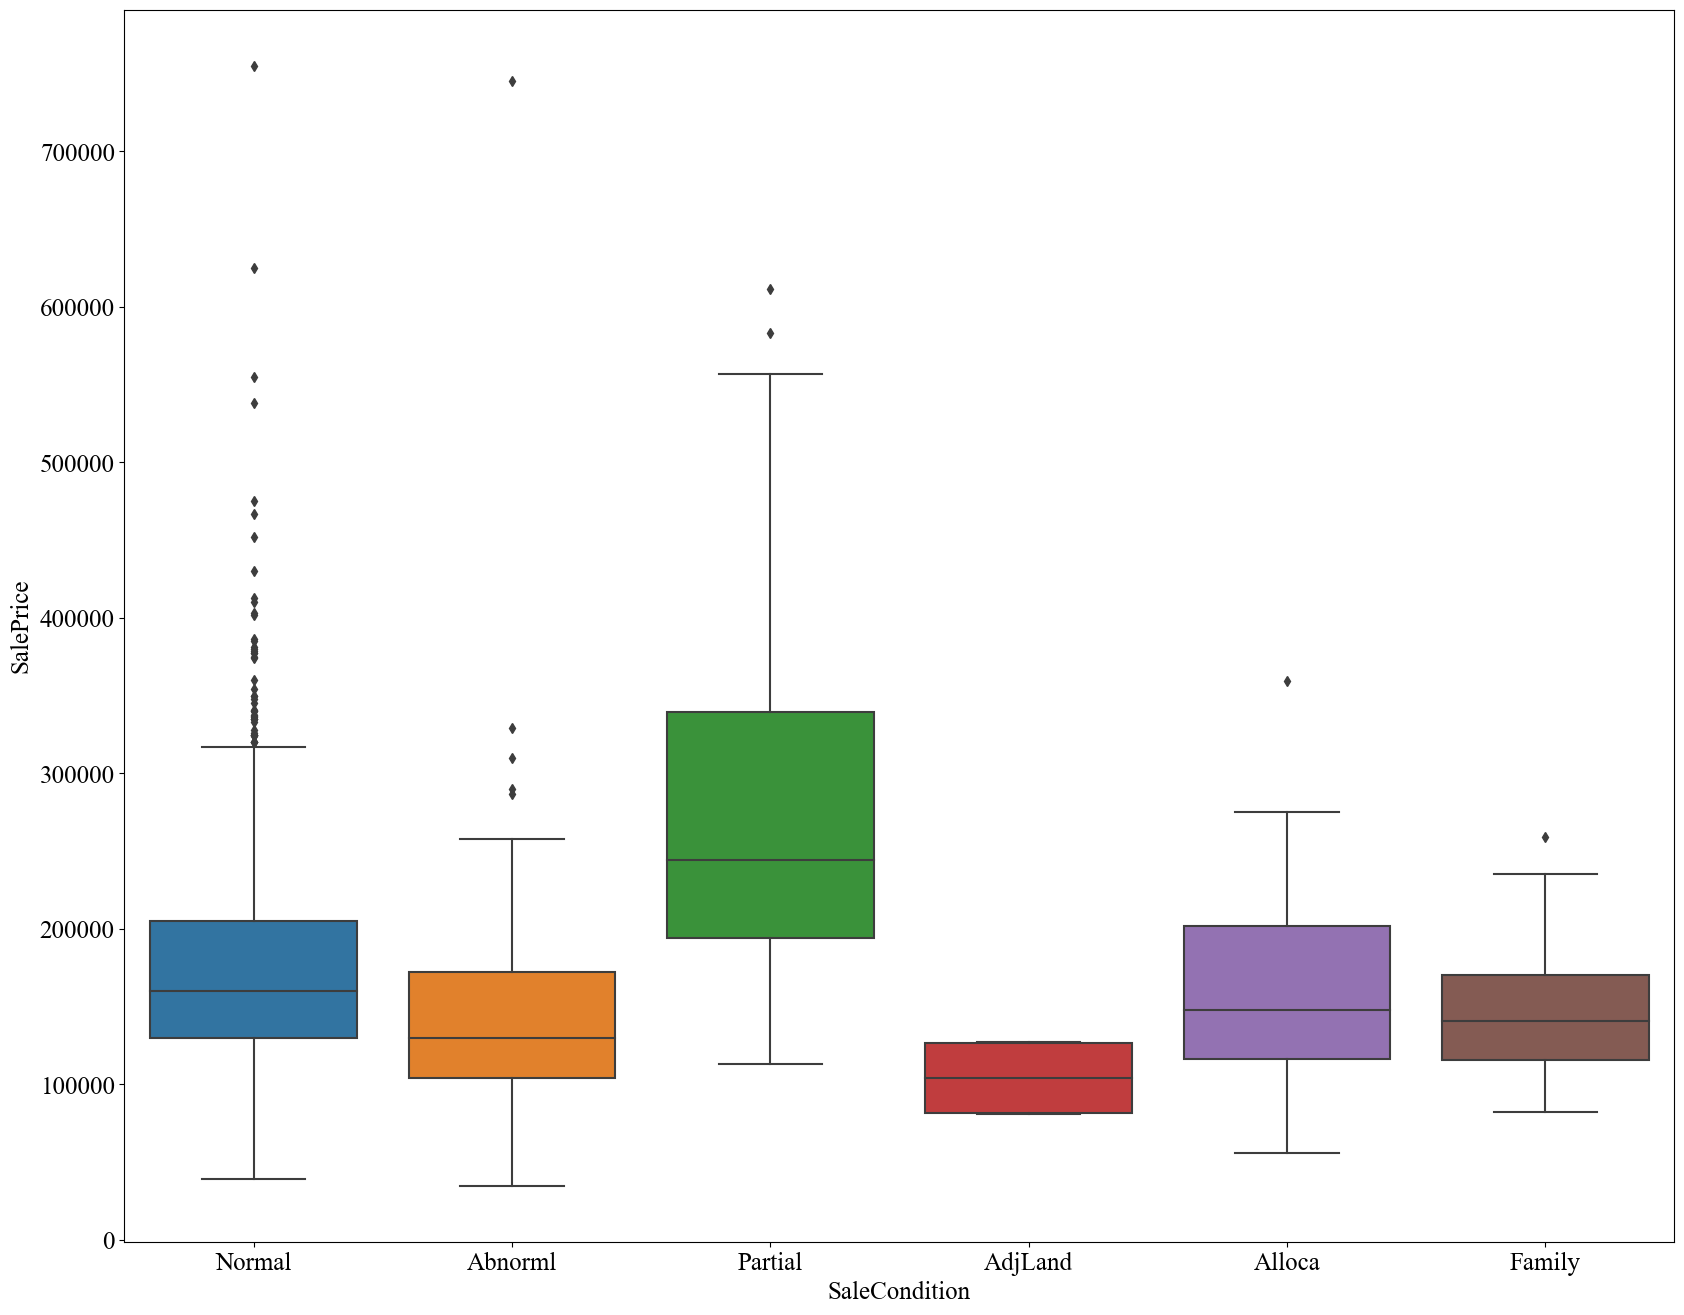

In [87]:
for feature in df_categorical.columns:
    plot_cat_target(df, feature)

# 2. Feature Engineering

In [88]:
# Start with numerical features
df_total = df_numeric.isna().sum().sort_values(ascending=False)
df_percent = (df_numeric.isna().sum()/df_numeric.isna().count()).sort_values(ascending=False)
df_numerical_missing = pd.concat([df_total, df_percent], axis=1, keys=['Total', 'Percent'])
mask1 = df_numerical_missing['Percent'] > 0
df_numerical_missing = df_numerical_missing[mask1]
df_numerical_missing

Total   Percent
LotFrontage    259  0.177397
GarageYrBlt     81  0.055479
MasVnrArea       8  0.005479

In [89]:
# Start with numerical features
df_total = df_categorical.isna().sum().sort_values(ascending=False)
df_percent = (df_categorical.isna().sum()/df_categorical.isna().count()).sort_values(ascending=False)
df_categorical_missing = pd.concat([df_total, df_percent], axis=1, keys=['Total', 'Percent'])
mask1 = df_categorical_missing['Percent'] > 0
df_categorical_missing = df_categorical_missing[mask1]
df_categorical_missing

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
GarageType       81  0.055479
GarageCond       81  0.055479
GarageQual       81  0.055479
GarageFinish     81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtFinType1     37  0.025342
BsmtQual         37  0.025342
BsmtCond         37  0.025342
MasVnrType        8  0.005479
Electrical        1  0.000685

In [90]:
df_total = df.isna().sum().sort_values(ascending=False)
df_percent = (df.isna().sum()/df.isna().count()).sort_values(ascending=False)
df_missing = pd.concat([df_total, df_percent], axis=1, keys=['Total', 'Percent'])
mask1 = df_missing['Percent'] > 0
df_missing = df_missing[mask1]
df_missing

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
GarageCond       81  0.055479
GarageType       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtCond         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685

### Missing values: LotFrontage 


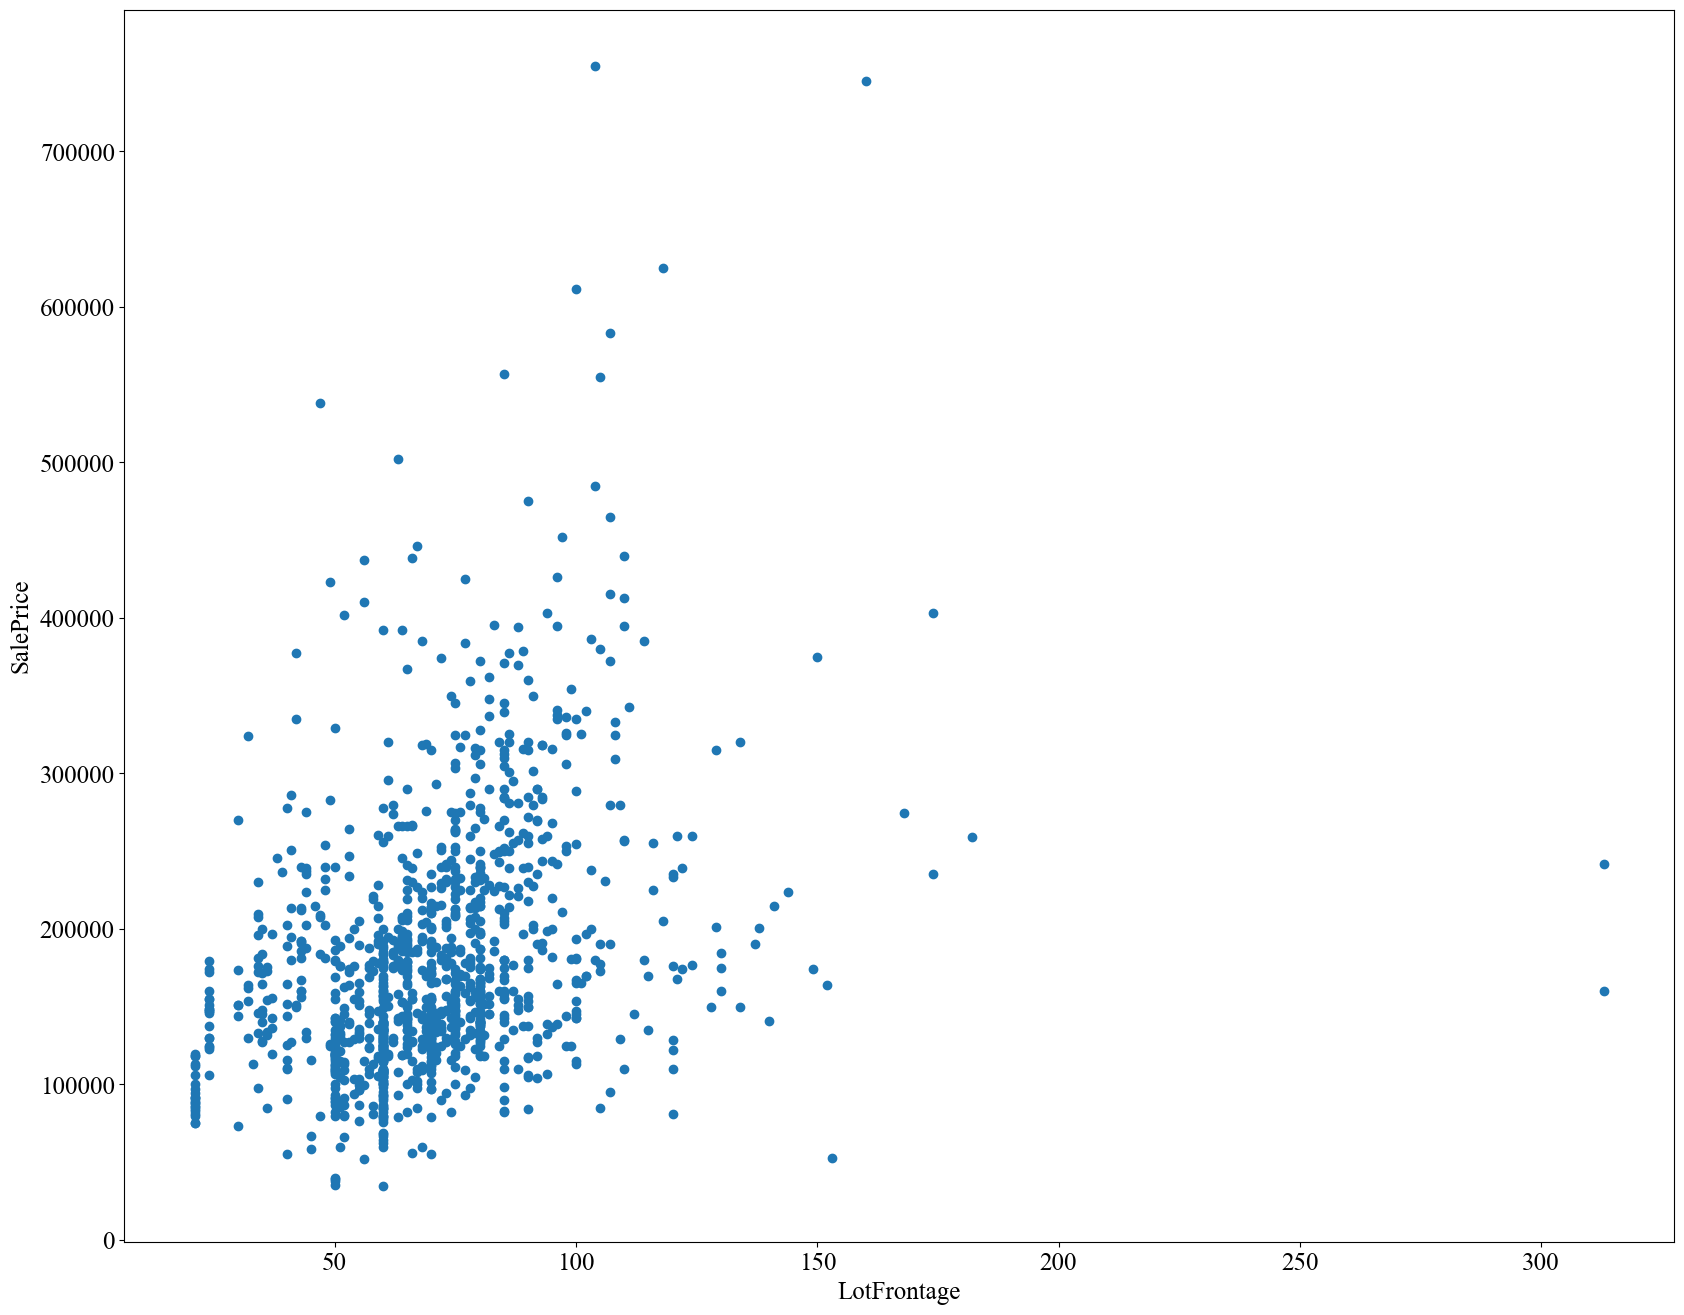

In [91]:
plot_num_target(df,'LotFrontage')

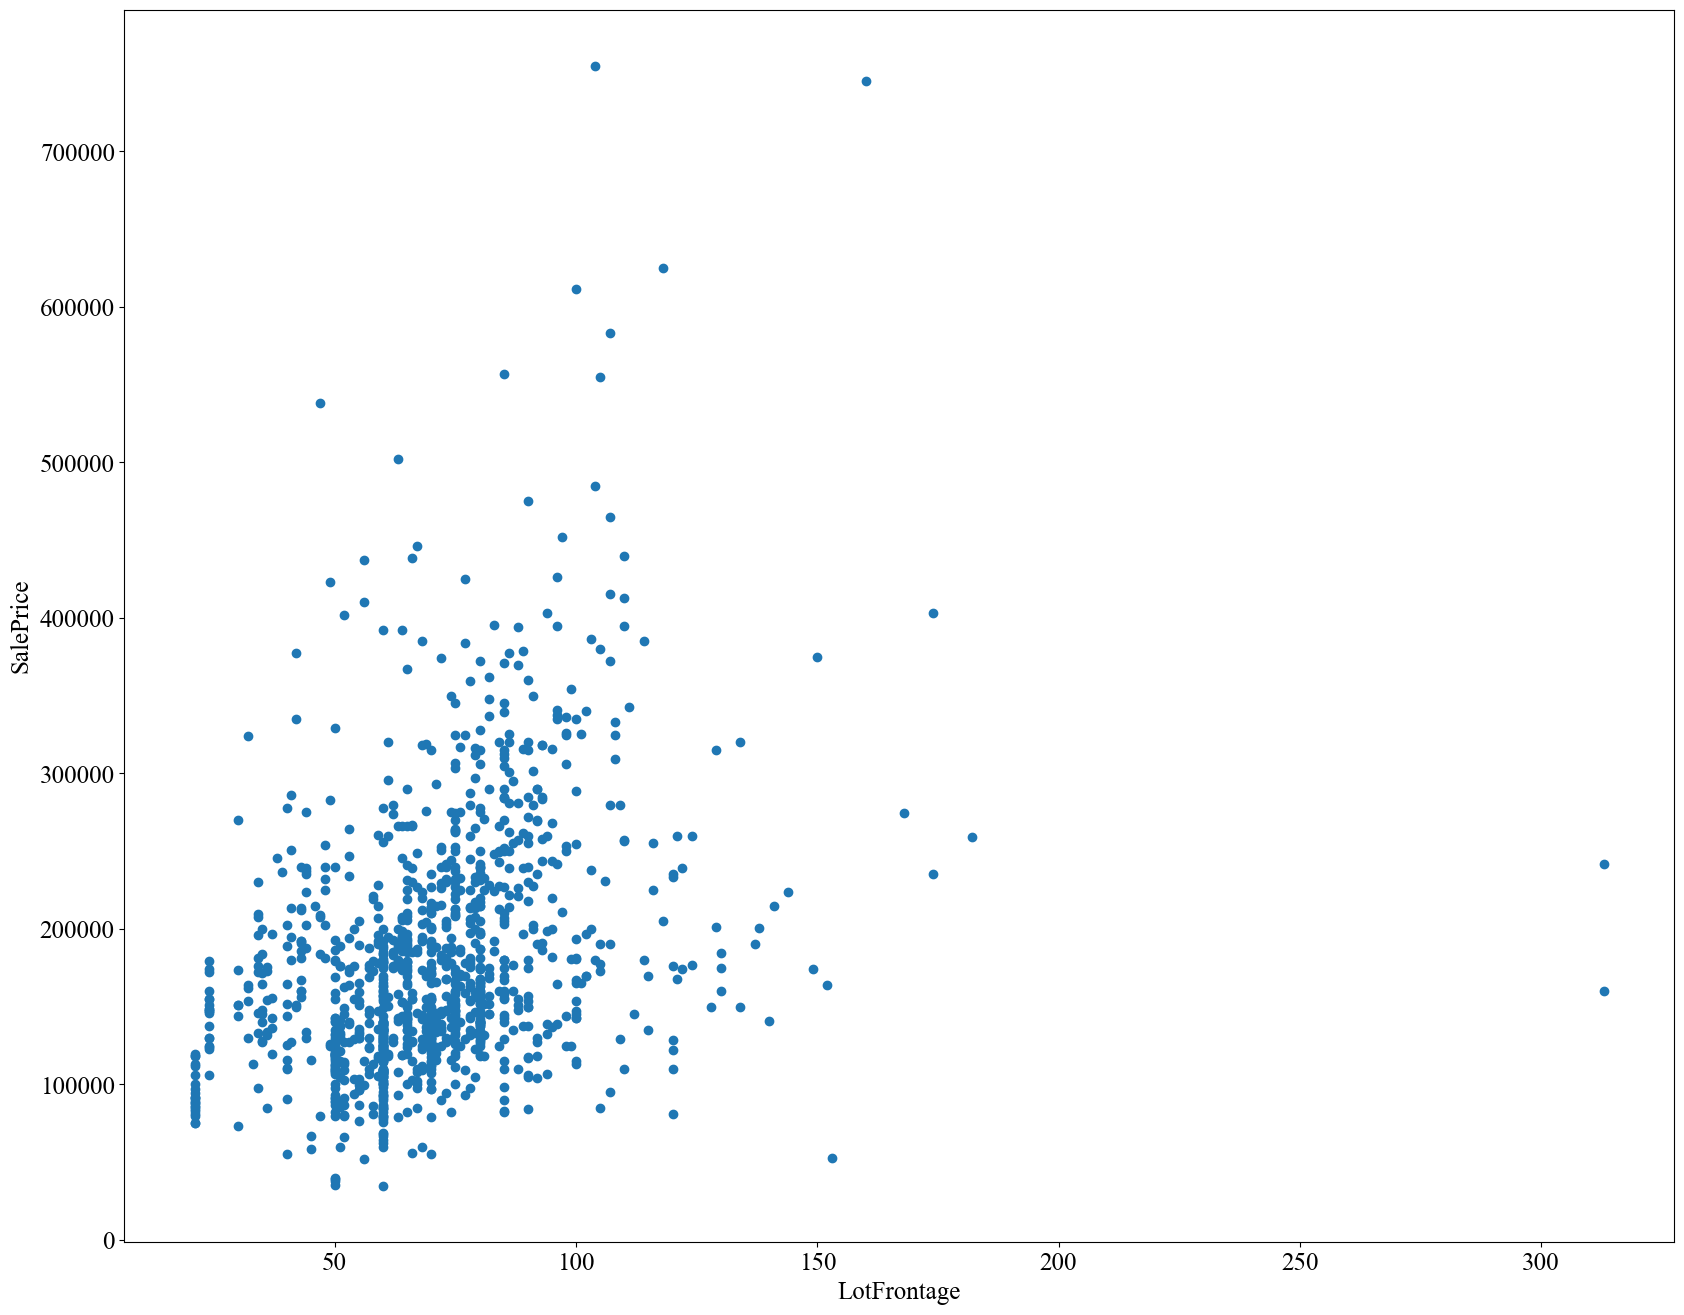

In [92]:
plot_num_target(df,'LotFrontage')

<AxesSubplot:>

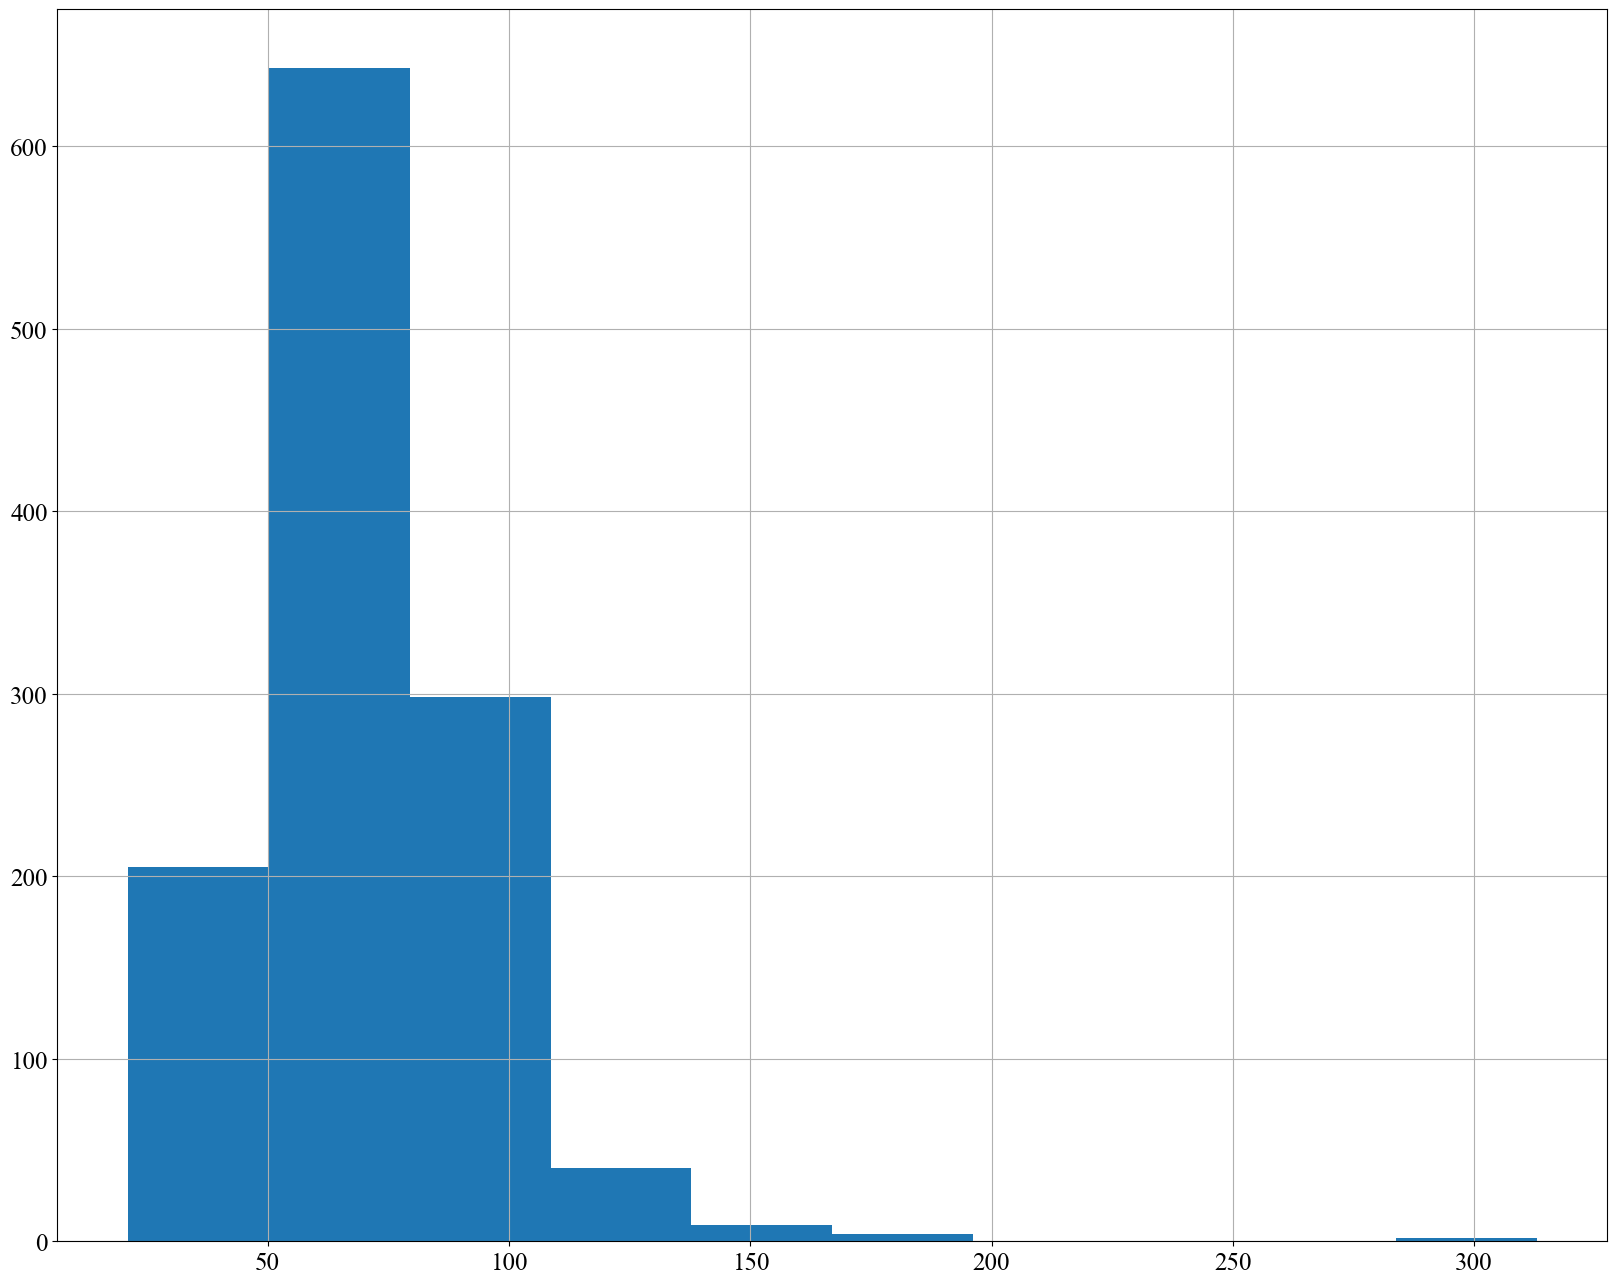

In [93]:
df['LotFrontage'].hist()

In [94]:
df['LotFrontage'].fillna(df['LotFrontage'].mean(),inplace=True)

### Missing values: MasVnrArea & MasVnrType

In [95]:
df['MasVnrArea'].fillna(0,inplace=True)
df['MasVnrType'].fillna('None',inplace=True)

### Missing values: GarageYrBlt, GarageType, GarageCond, GarageQual, and GarageFinish

In [96]:
mask1 = df['GarageYrBlt'].isna()
df['WithGarage'] = 1
df.loc[mask1,'WithGarage'] = 0

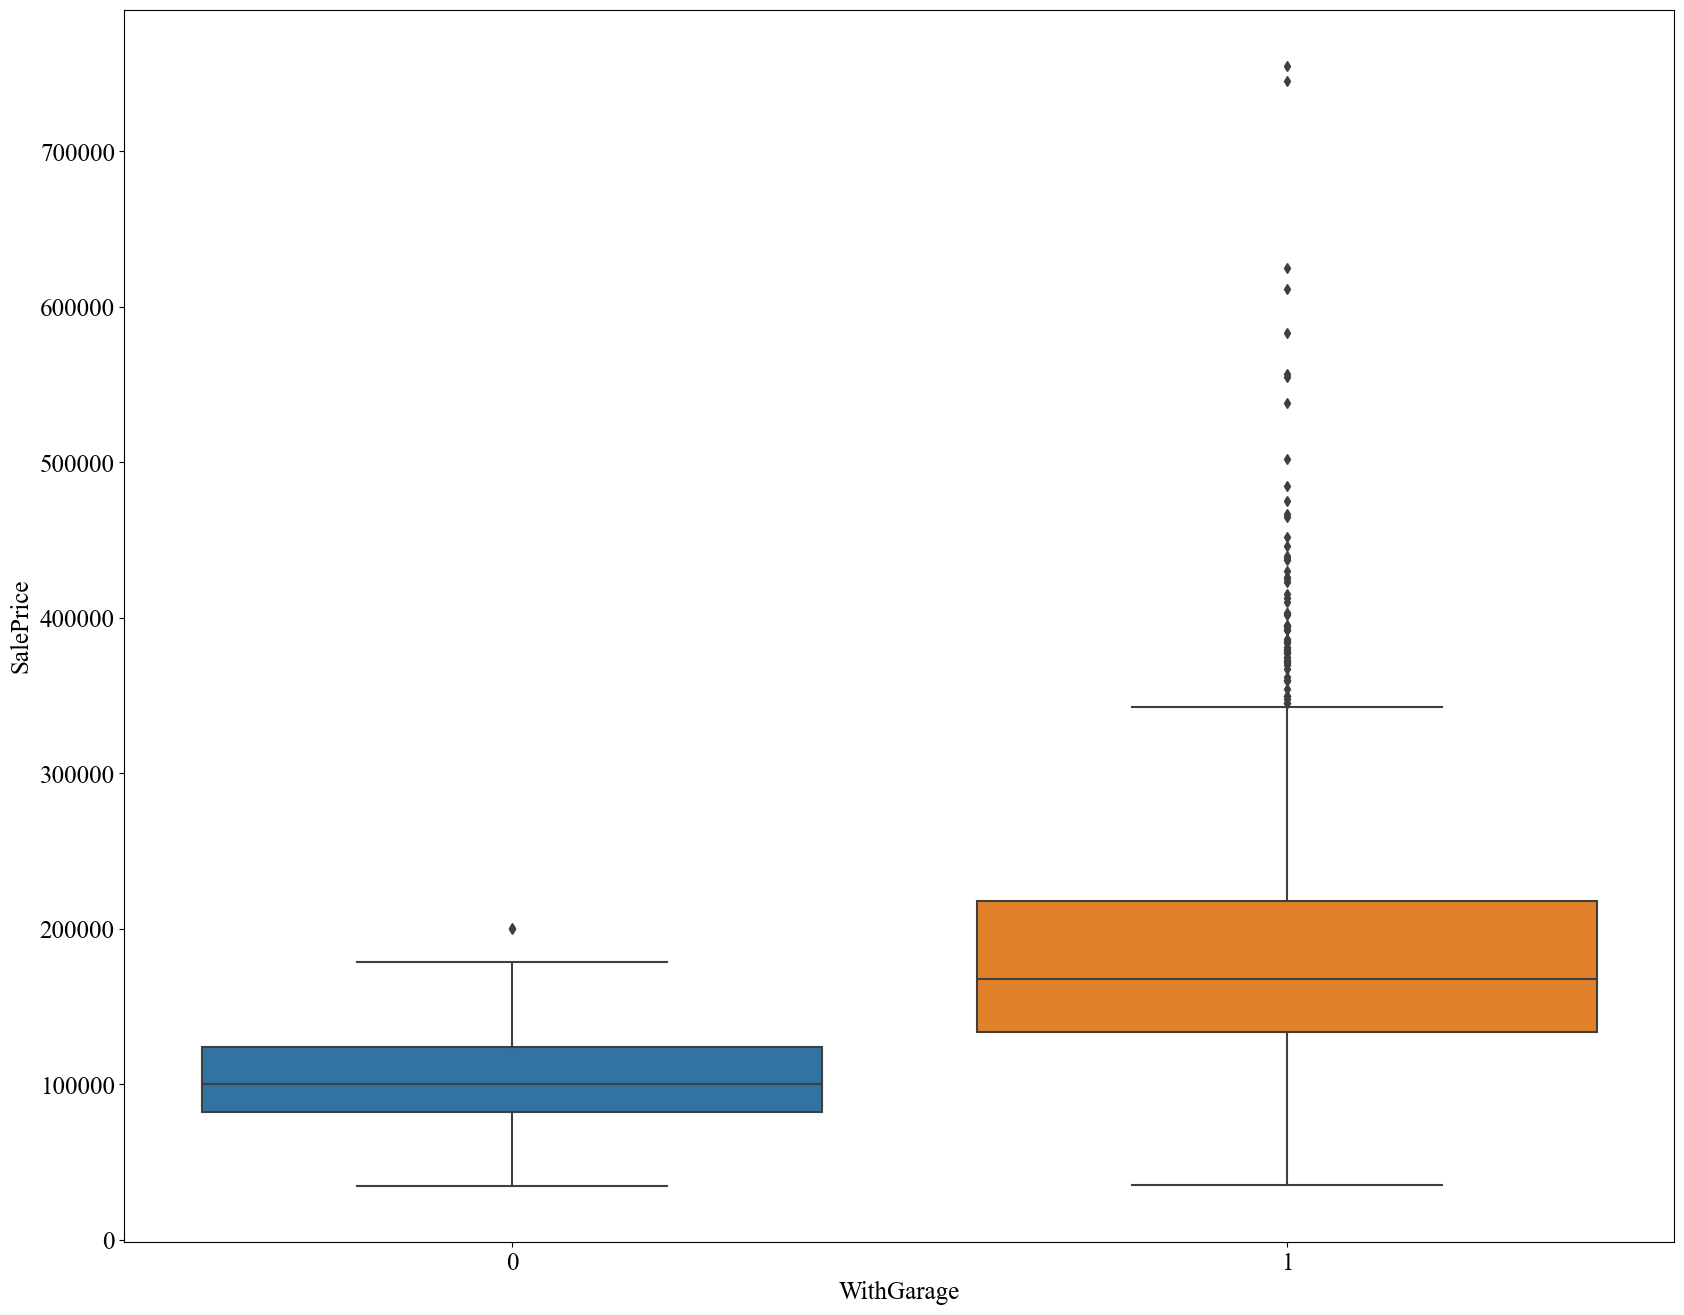

In [97]:
plot_cat_target(df, 'WithGarage')

In [98]:
df.loc[mask1,'GarageYrBlt'] = df.loc[mask1,'YearBuilt']
df['GarageYrBlt'] = df['GarageYrBlt'].astype(int)

In [99]:
df.loc[mask1,'GarageType'] = 'None'
df.loc[mask1,'GarageCond'] = 'None'
df.loc[mask1,'GarageQual'] = 'None'
df.loc[mask1,'GarageFinish'] = 'None'


In [100]:
oencoder = OrdinalEncoder(categories=[['None','Po','Fa','TA','Gd','Ex']])
df[['GarageCond']] = oencoder.fit_transform(df[['GarageCond']])
df['GarageCond'] = df['GarageCond'].astype(int)
df[['GarageQual']] = oencoder.fit_transform(df[['GarageQual']])
df['GarageQual'] = df['GarageQual'].astype(int)
oencoder = OrdinalEncoder(categories=[['None','Unf','RFn','Fin']])
df[['GarageFinish']] = oencoder.fit_transform(df[['GarageFinish']])
df['GarageFinish'] = df['GarageFinish'].astype(int)

### Missing values: PoolQC

In [101]:
df['PoolQC'].fillna('None',inplace=True)

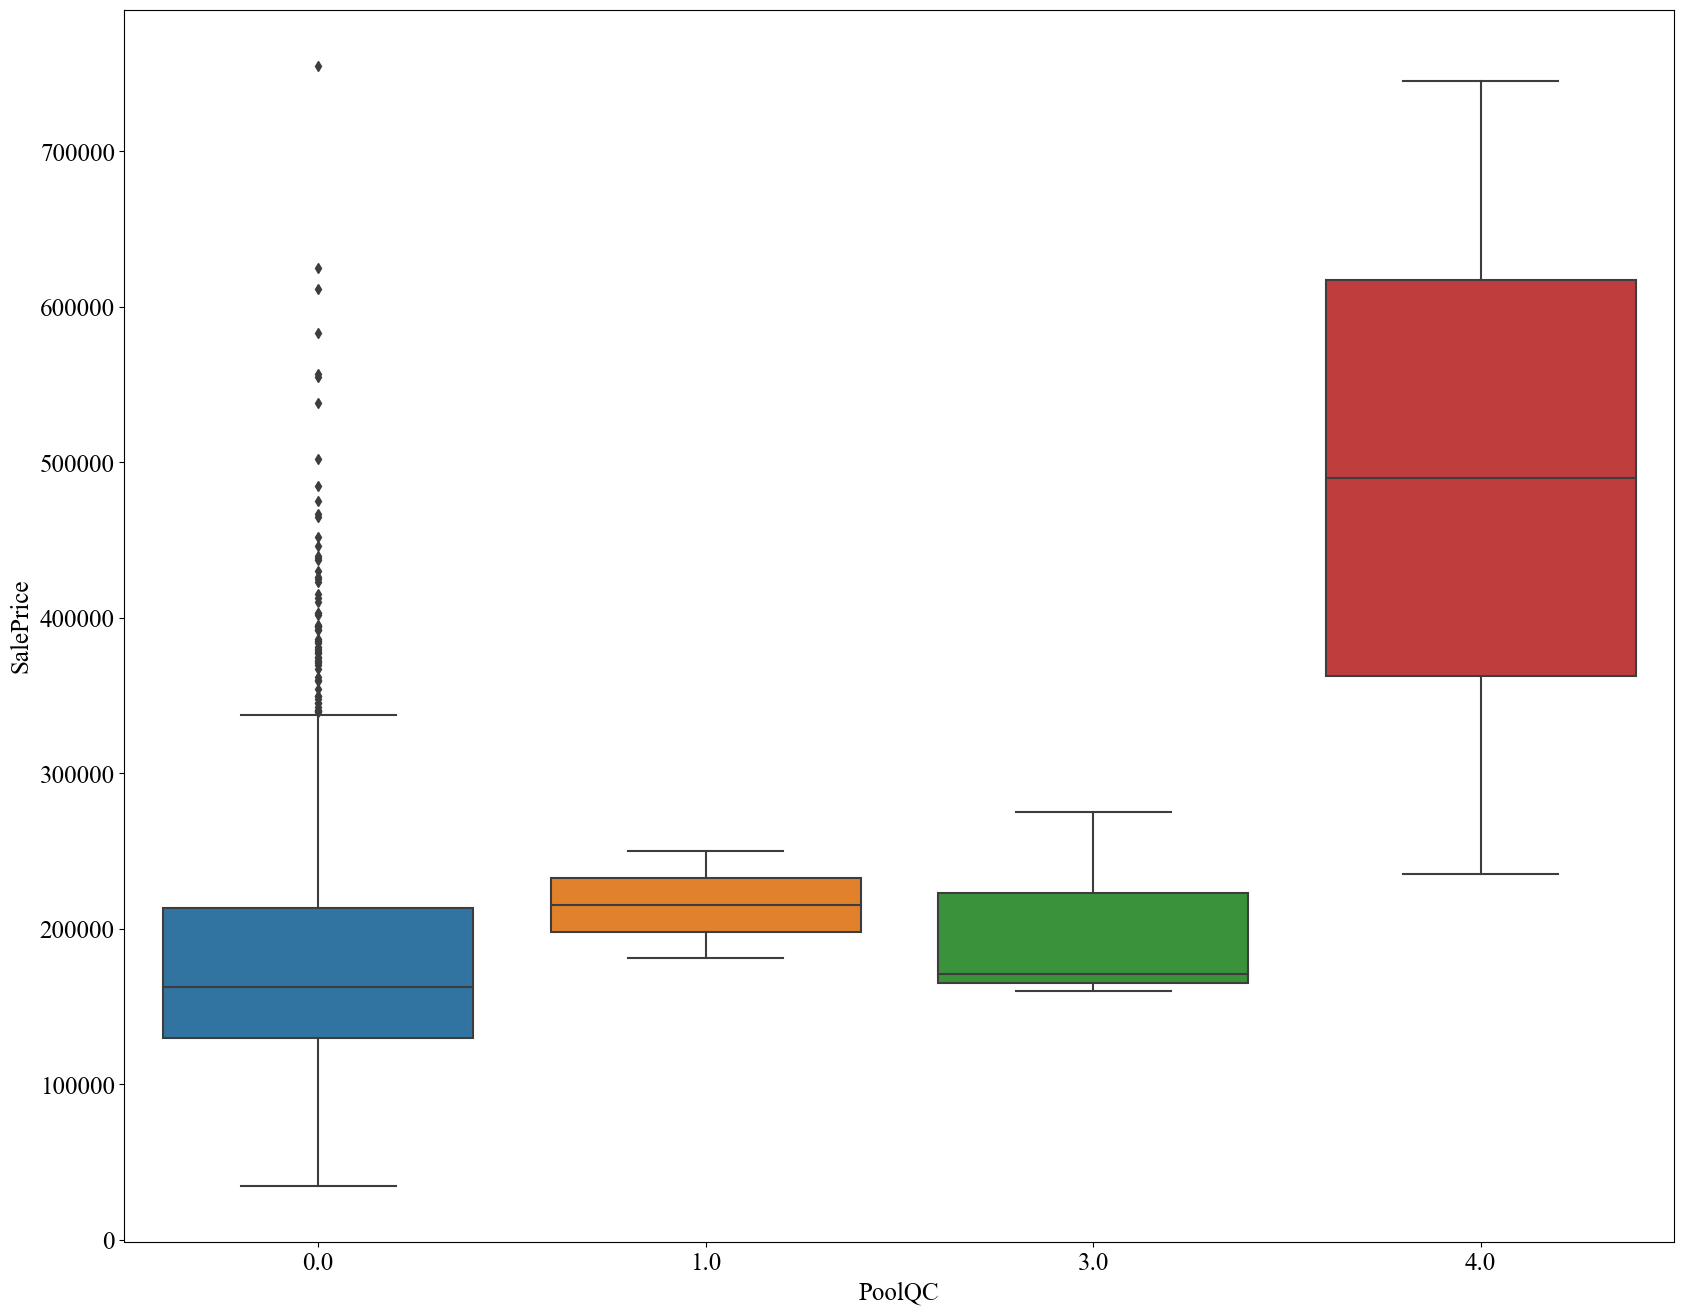

In [102]:
# delete WithGarage Feature?
oencoder = OrdinalEncoder(categories=[['None','Fa','TA','Gd','Ex']])
df[['PoolQC']] = oencoder.fit_transform(df[['PoolQC']])
plot_cat_target(df,'PoolQC')

### Missing values MiscFeature:

In [103]:
df['MiscFeature'].fillna('None',inplace=True)

### Missing values Alley:

In [104]:
df['Alley'].fillna('None',inplace=True)

### Missing values Fence:

In [105]:
df['Fence'].fillna('None',inplace=True)

### Missing values FireplaceQu:

In [106]:
df['Fireplaces'].value_counts()
mask1 = df['Fireplaces'] == 0

In [107]:
df['FireplaceQu'].fillna('None',inplace=True)

In [108]:
df.loc[mask1,'FireplaceQu'].value_counts()

None    690
Name: FireplaceQu, dtype: int64

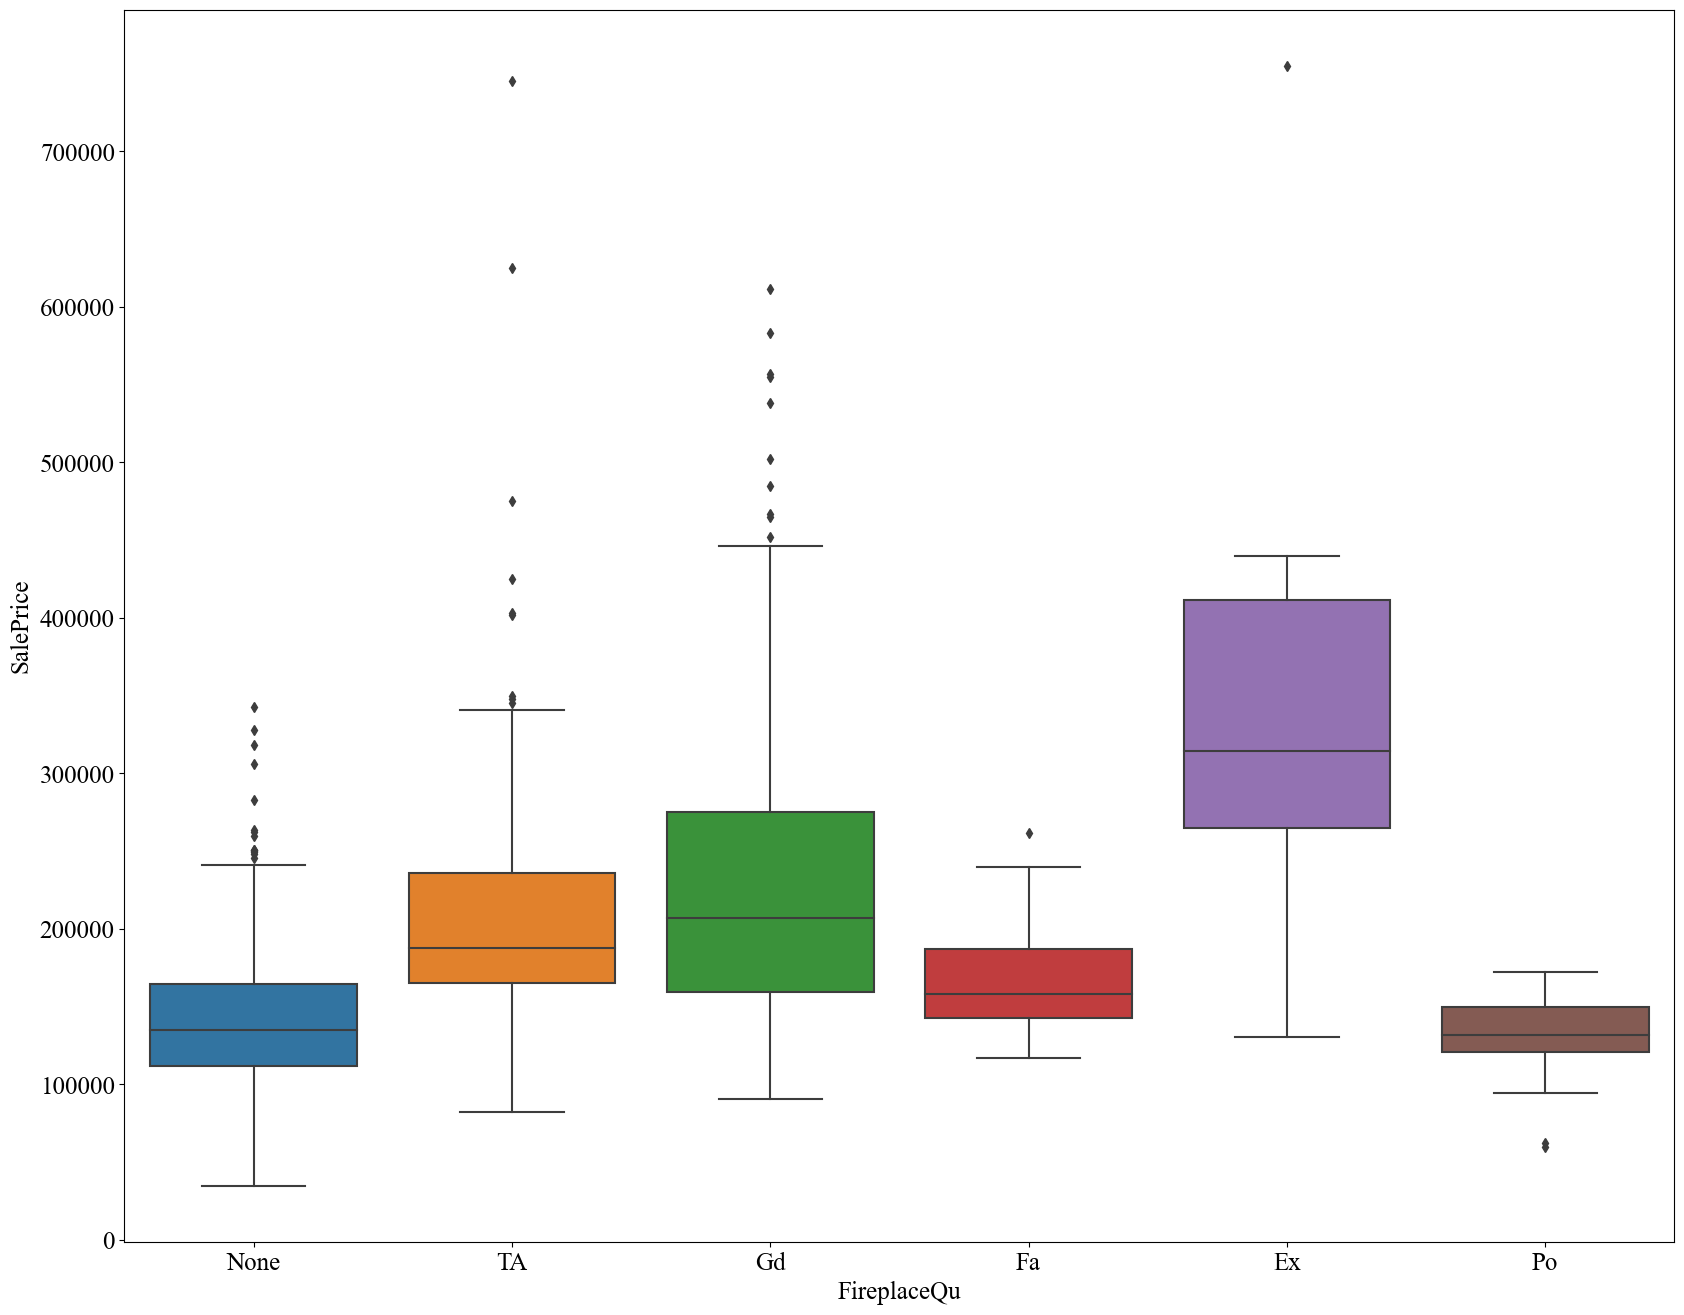

In [109]:
plot_cat_target(df,'FireplaceQu')

### Missing values BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, and BsmtCond:

In [110]:
df['BsmtExposure'].fillna('None',inplace=True)
df['BsmtFinType1'].fillna('None',inplace=True)
df['BsmtFinType2'].fillna('None',inplace=True)
df['BsmtQual'].fillna('None',inplace=True)
df['BsmtCond'].fillna('None',inplace=True)

### Missing values Electrical:

In [111]:
mask1 = df['Electrical'].isna()
df = df[~mask1]

In [112]:
df_total = df.isna().sum().sort_values(ascending=False)
df_percent = (df.isna().sum()/df.isna().count()).sort_values(ascending=False)
df_missing = pd.concat([df_total, df_percent], axis=1, keys=['Total', 'Percent'])
mask1 = df_missing['Percent'] > 0
df_missing = df_missing[mask1]
df_missing


Empty DataFrame
Columns: [Total, Percent]
Index: []

### Label & Dummy Encoding

In [113]:

oencoder = OrdinalEncoder(categories=[['None','Po','Fa','TA','Gd','Ex']])
df[['HeatingQC']] = oencoder.fit_transform(df[['HeatingQC']])
df['HeatingQC'] = df['HeatingQC'].astype(int)

oencoder = OrdinalEncoder(categories=[['None','Po','Fa','TA','Gd','Ex']])
df[['KitchenQual']] = oencoder.fit_transform(df[['KitchenQual']])
df['KitchenQual'] = df['KitchenQual'].astype(int)


oencoder = OrdinalEncoder(categories=[['None','Po','Fa','TA','Gd','Ex']])
df[['ExterQual']] = oencoder.fit_transform(df[['ExterQual']])
df['ExterQual'] = df['ExterQual'].astype(int)

oencoder = OrdinalEncoder(categories=[['None','Po','Fa','TA','Gd','Ex']])
df[['BsmtCond']] = oencoder.fit_transform(df[['BsmtCond']])
df['BsmtCond'] = df['BsmtCond'].astype(int)

oencoder = OrdinalEncoder(categories=[['None','Po','Fa','TA','Gd','Ex']])
df[['BsmtQual']] = oencoder.fit_transform(df[['BsmtQual']])
df['BsmtQual'] = df['BsmtQual'].astype(int)

oencoder = OrdinalEncoder(categories=[['None','Po','Fa','TA','Gd','Ex']])
df[['ExterCond']] = oencoder.fit_transform(df[['ExterCond']])
df['ExterCond'] = df['ExterCond'].astype(int)

oencoder = OrdinalEncoder(categories=[['None','Po','Fa','TA','Gd','Ex']])
df[['FireplaceQu']] = oencoder.fit_transform(df[['FireplaceQu']])
df['FireplaceQu'] = df['FireplaceQu'].astype(int)

In [114]:
df_final = df.copy()

## Feature Engineering: Outliers

In [115]:
df_final['SalePrice'].nlargest(2)


691     755000
1182    745000
Name: SalePrice, dtype: int64

In [116]:
mask1 = (df_final['Id'] == 692) | (df_final['Id'] == 1183)
df_final[mask1]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
691    692          60       RL        104.0    21535   Pave  None      IR1   
1182  1183          60       RL        160.0    15623   Pave  None      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
691          Lvl    AllPub    Corner       Gtl      NoRidge       Norm   
1182         Lvl    AllPub    Corner       Gtl      NoRidge       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
691        Norm     1Fam     2Story           10            6       1994   
1182       Norm     1Fam     2Story           10            5       1996   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
691           1995     Gable  WdShngl     HdBoard     HdBoard    BrkFace   
1182          1996       Hip  CompShg     Wd Sdng     ImStucc       None   

      MasVnrArea  ExterQual  ExterCond Foundation  BsmtQual  BsmtCond  \
691       1170.0          5          3      PConc         5         3   
1182         0.0          4          3      PConc         5         3   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
691            Gd          GLQ        1455          Unf           0   
1182           Av          GLQ        2096          Unf           0   

      BsmtUnfSF  TotalBsmtSF Heating  HeatingQC CentralAir Electrical  \
691         989         2444    GasA          5          Y      SBrkr   
1182        300         2396    GasA          5          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
691       2444      1872             0       4316             0             1   
1182      2411      2065             0       4476             1             0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  \
691          3         1             4             1            5   
1182         3         1             4             1            5   

      TotRmsAbvGrd Functional  Fireplaces  FireplaceQu GarageType  \
691             10        Typ           2            5     Attchd   
1182            10        Typ           2            3     Attchd   

      GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  \
691          1994             3           3         832           3   
1182         1996             3           3         813           3   

      GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
691            3          Y         382           50              0   
1182           3          Y         171           78              0   

      3SsnPorch  ScreenPorch  PoolArea  PoolQC  Fence MiscFeature  MiscVal  \
691           0            0         0     0.0   None        None        0   
1182          0            0       555     4.0  MnPrv        None        0   

      MoSold  YrSold SaleType SaleCondition  SalePrice  WithGarage  
691        1    2007       WD        Normal     755000           1  
1182       7    2007       WD       Abnorml     745000           1

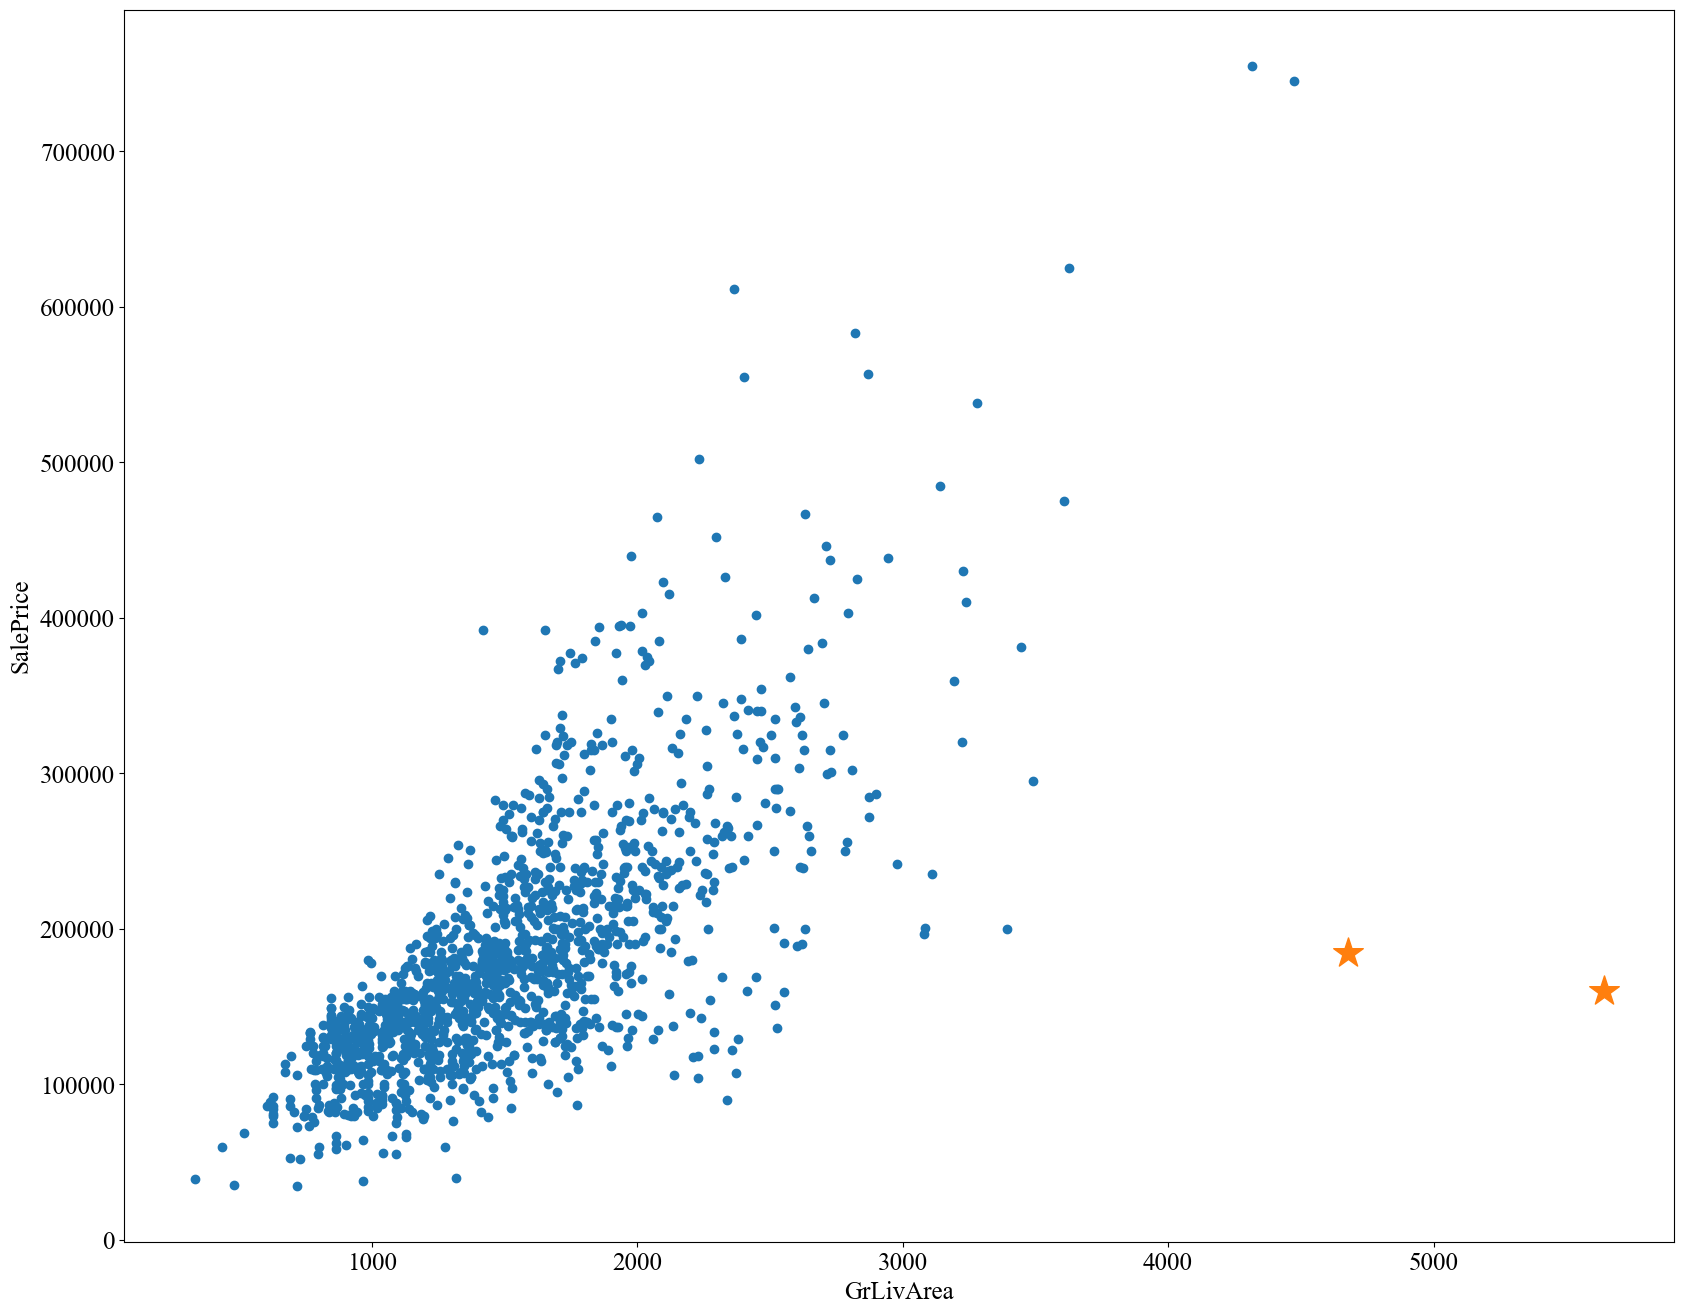

In [117]:
mask1 = (df_final['Id'] == 1299) | (df_final['Id'] == 524)
df2 = df_final[mask1]
plot_num_target(df_final,'GrLivArea',df2,'SalePrice',True)

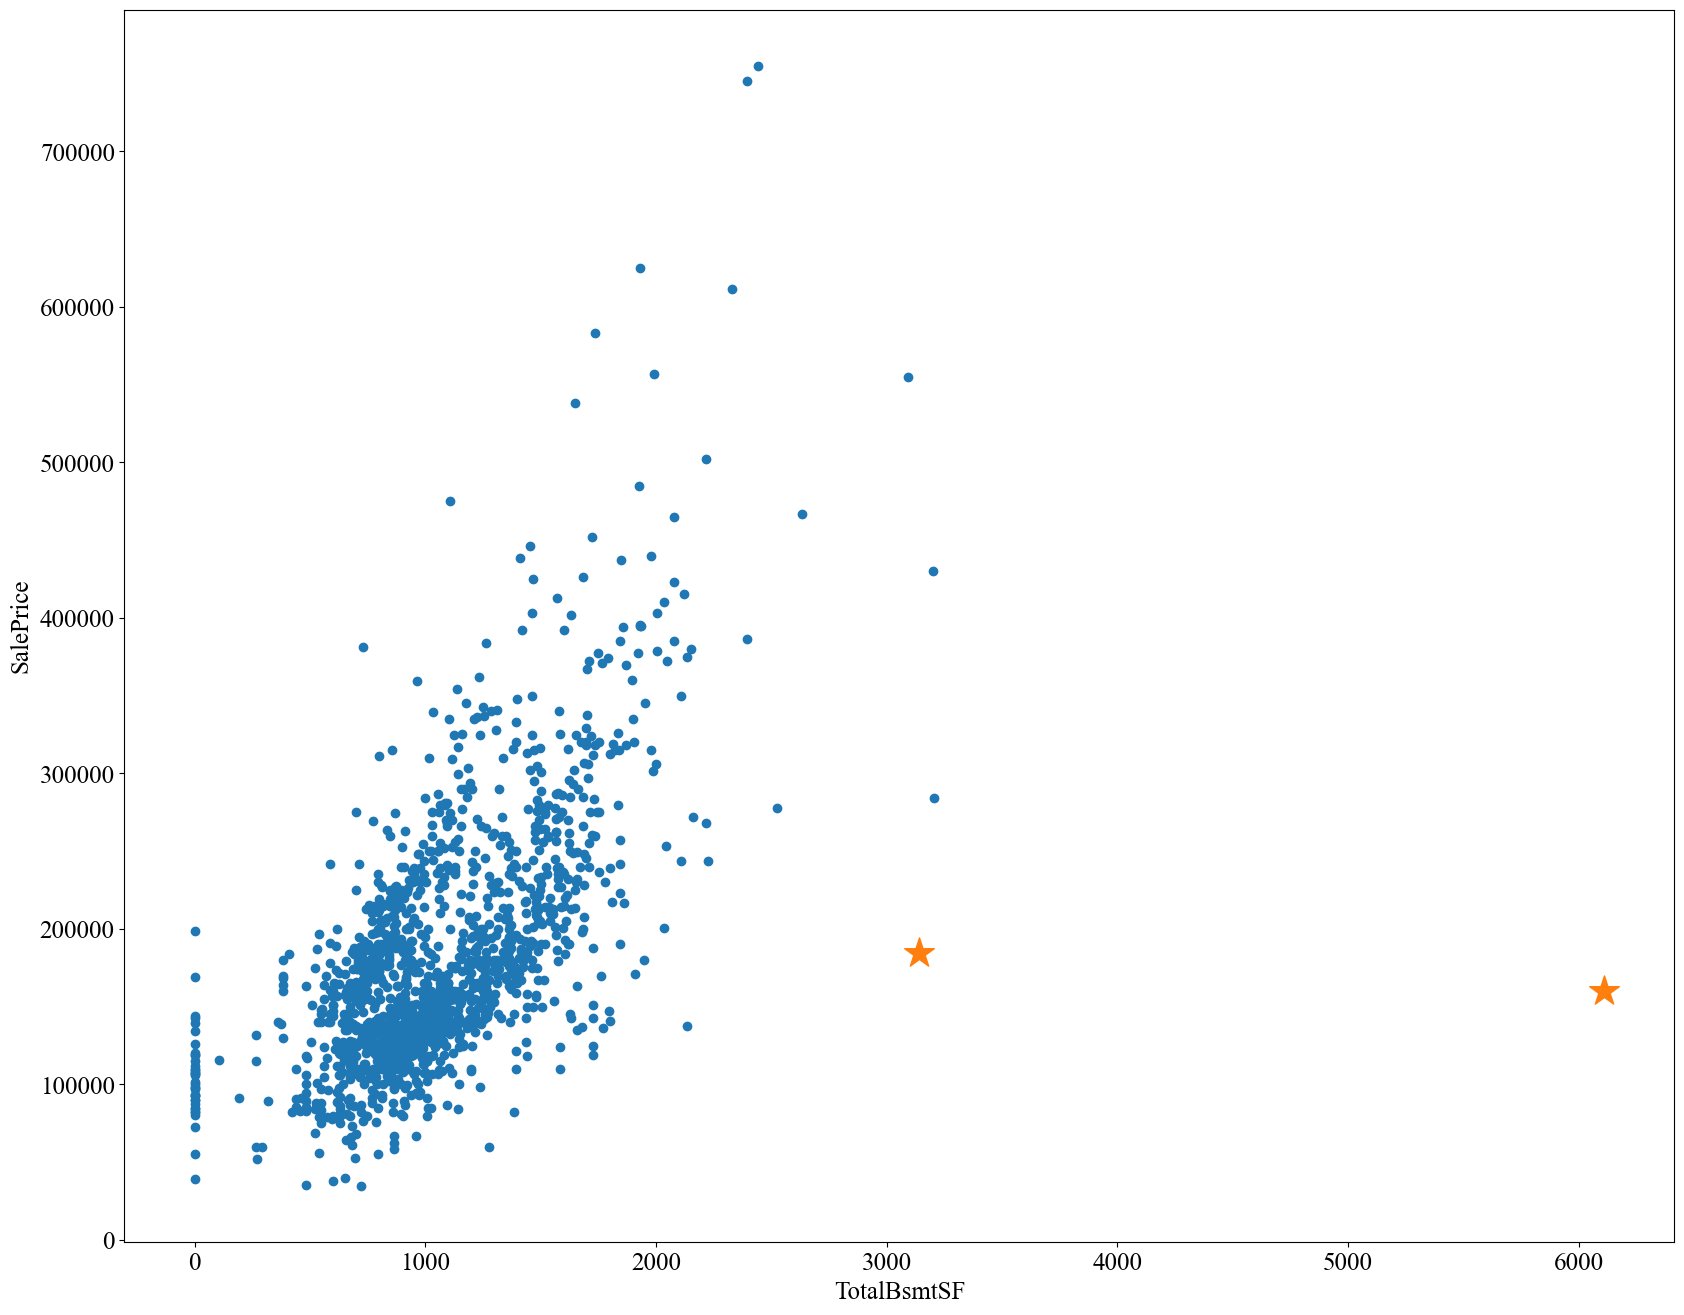

In [118]:
mask1 = (df_final['Id'] == 1299) | (df_final['Id'] == 524)
df2 = df_final[mask1]
plot_num_target(df_final,'TotalBsmtSF',df2,'SalePrice',True)

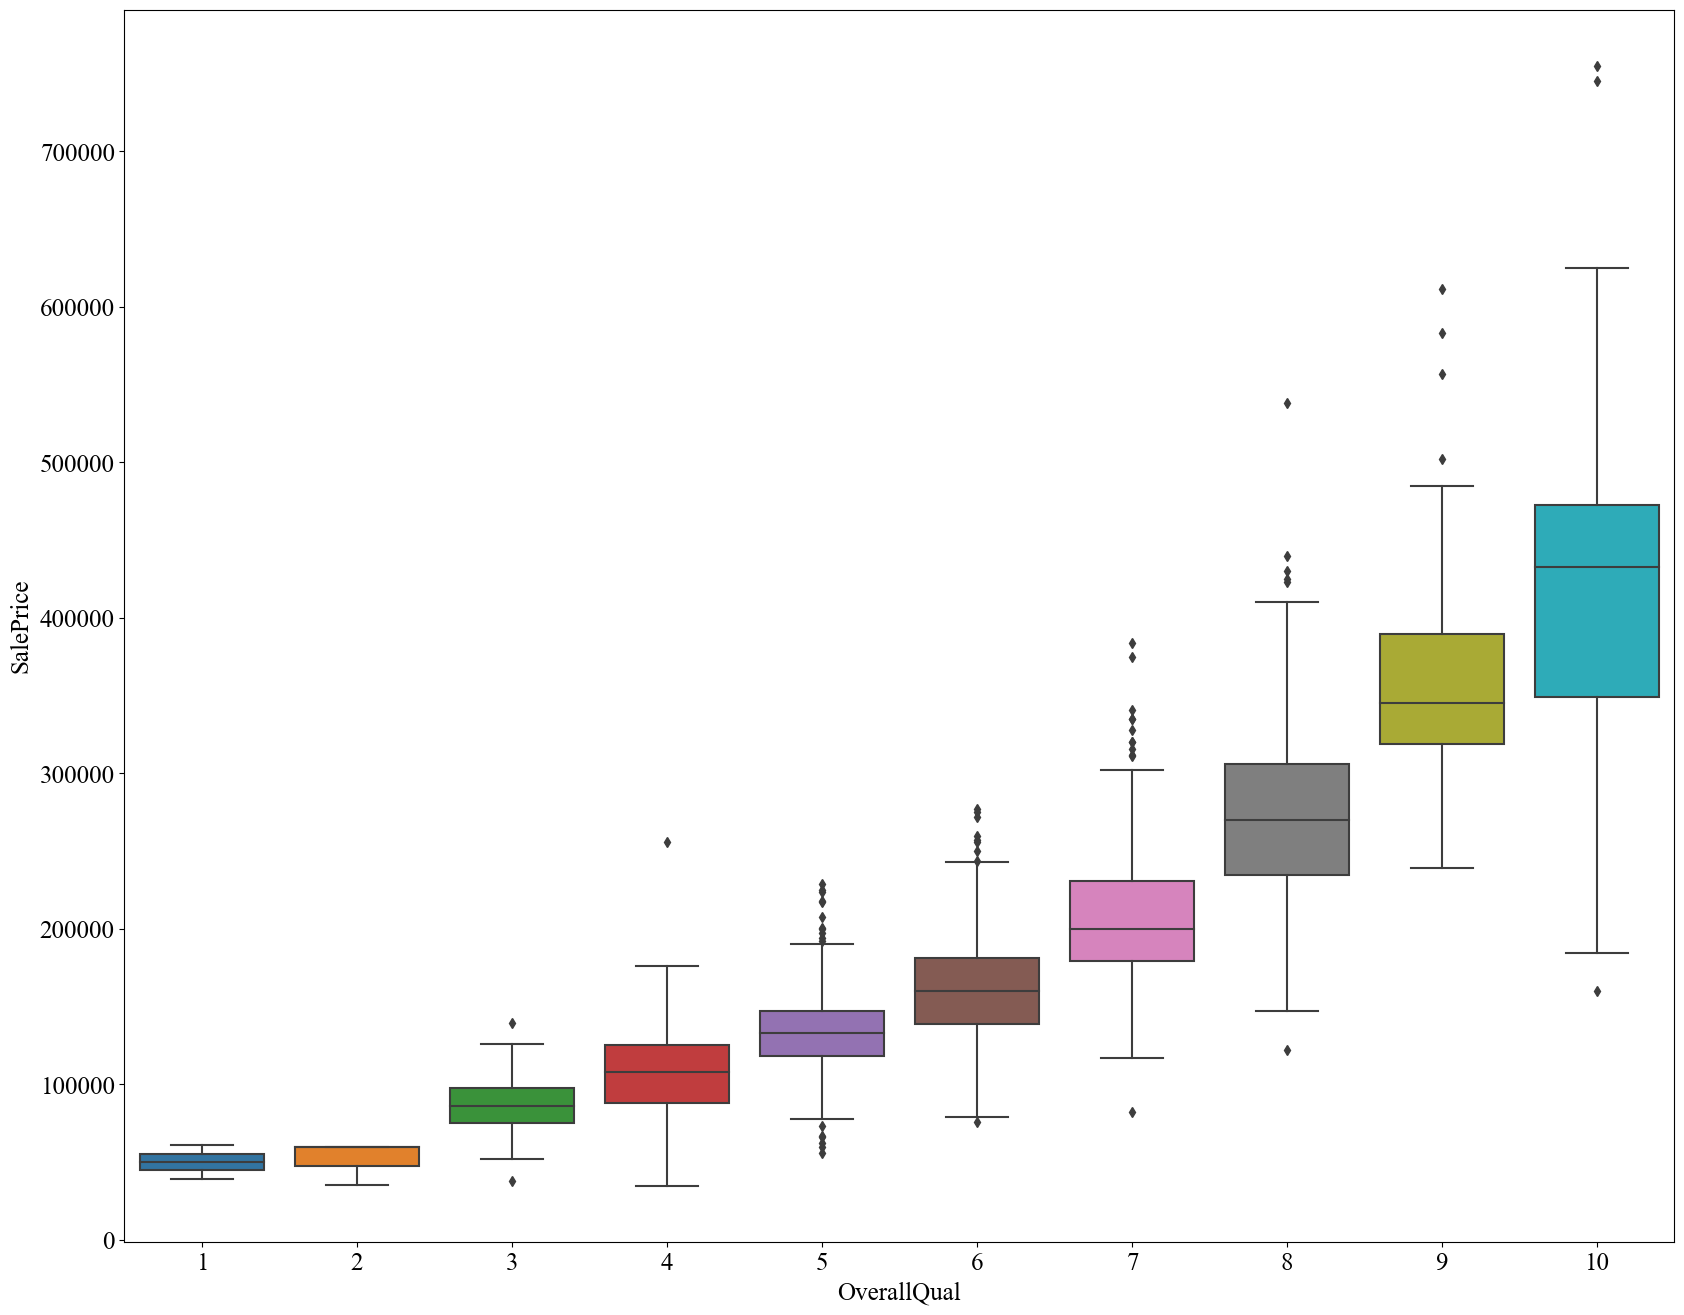

In [119]:
plot_cat_target(df_final,'OverallQual')

In [120]:
mask1 = df_final['OverallQual'] == 10
df_final.loc[mask1,'SalePrice'].nsmallest(3)

1298    160000
523     184750
1442    310000
Name: SalePrice, dtype: int64

In [121]:
# Let es exclude House 1299 and 524
mask1 = (df_final['Id'] == 1299) | (df_final['Id'] == 524)
df_final = df_final[~mask1]

### Delete MiscFeature

In [122]:
df_final

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave  None      Reg   
1        2          20       RL         80.0     9600   Pave  None      Reg   
2        3          60       RL         68.0    11250   Pave  None      IR1   
3        4          70       RL         60.0     9550   Pave  None      IR1   
4        5          60       RL         84.0    14260   Pave  None      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave  None      Reg   
1456  1457          20       RL         85.0    13175   Pave  None      Reg   
1457  1458          70       RL         66.0     9042   Pave  None      Reg   
1458  1459          20       RL         68.0     9717   Pave  None      Reg   
1459  1460          20       RL         75.0     9937   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1            Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2            Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3            Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4            Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
...          ...       ...       ...       ...          ...        ...   
1455         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1456         Lvl    AllPub    Inside       Gtl       NWAmes       Norm   
1457         Lvl    AllPub    Inside       Gtl      Crawfor       Norm   
1458         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
1459         Lvl    AllPub    Inside       Gtl      Edwards       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam     2Story            7            5       2003   
1          Norm     1Fam     1Story            6            8       1976   
2          Norm     1Fam     2Story            7            5       2001   
3          Norm     1Fam     2Story            7            5       1915   
4          Norm     1Fam     2Story            8            5       2000   
...         ...      ...        ...          ...          ...        ...   
1455       Norm     1Fam     2Story            6            5       1999   
1456       Norm     1Fam     1Story            6            6       1978   
1457       Norm     1Fam     2Story            7            9       1941   
1458       Norm     1Fam     1Story            5            6       1950   
1459       Norm     1Fam     1Story            5            6       1965   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd       None   
2             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3             1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
1455          2000     Gable  CompShg     VinylSd     VinylSd       None   
1456          1988     Gable  CompShg     Plywood     Plywood      Stone   
1457          2006     Gable  CompShg     CemntBd     CmentBd       None   
1458          1996       Hip  CompShg     MetalSd     MetalSd       None   
1459          1965     Gable  CompShg     HdBoard     HdBoard       None   

      MasVnrArea  ExterQual  ExterCond Foundation  BsmtQual  BsmtCond  \
0          196.0          4          3      PConc         4         3   
1            0.0          3          3     CBlock         4         3   
2          162.0          4          3      PConc         4         3   
3            0.0          3          3     BrkTil   

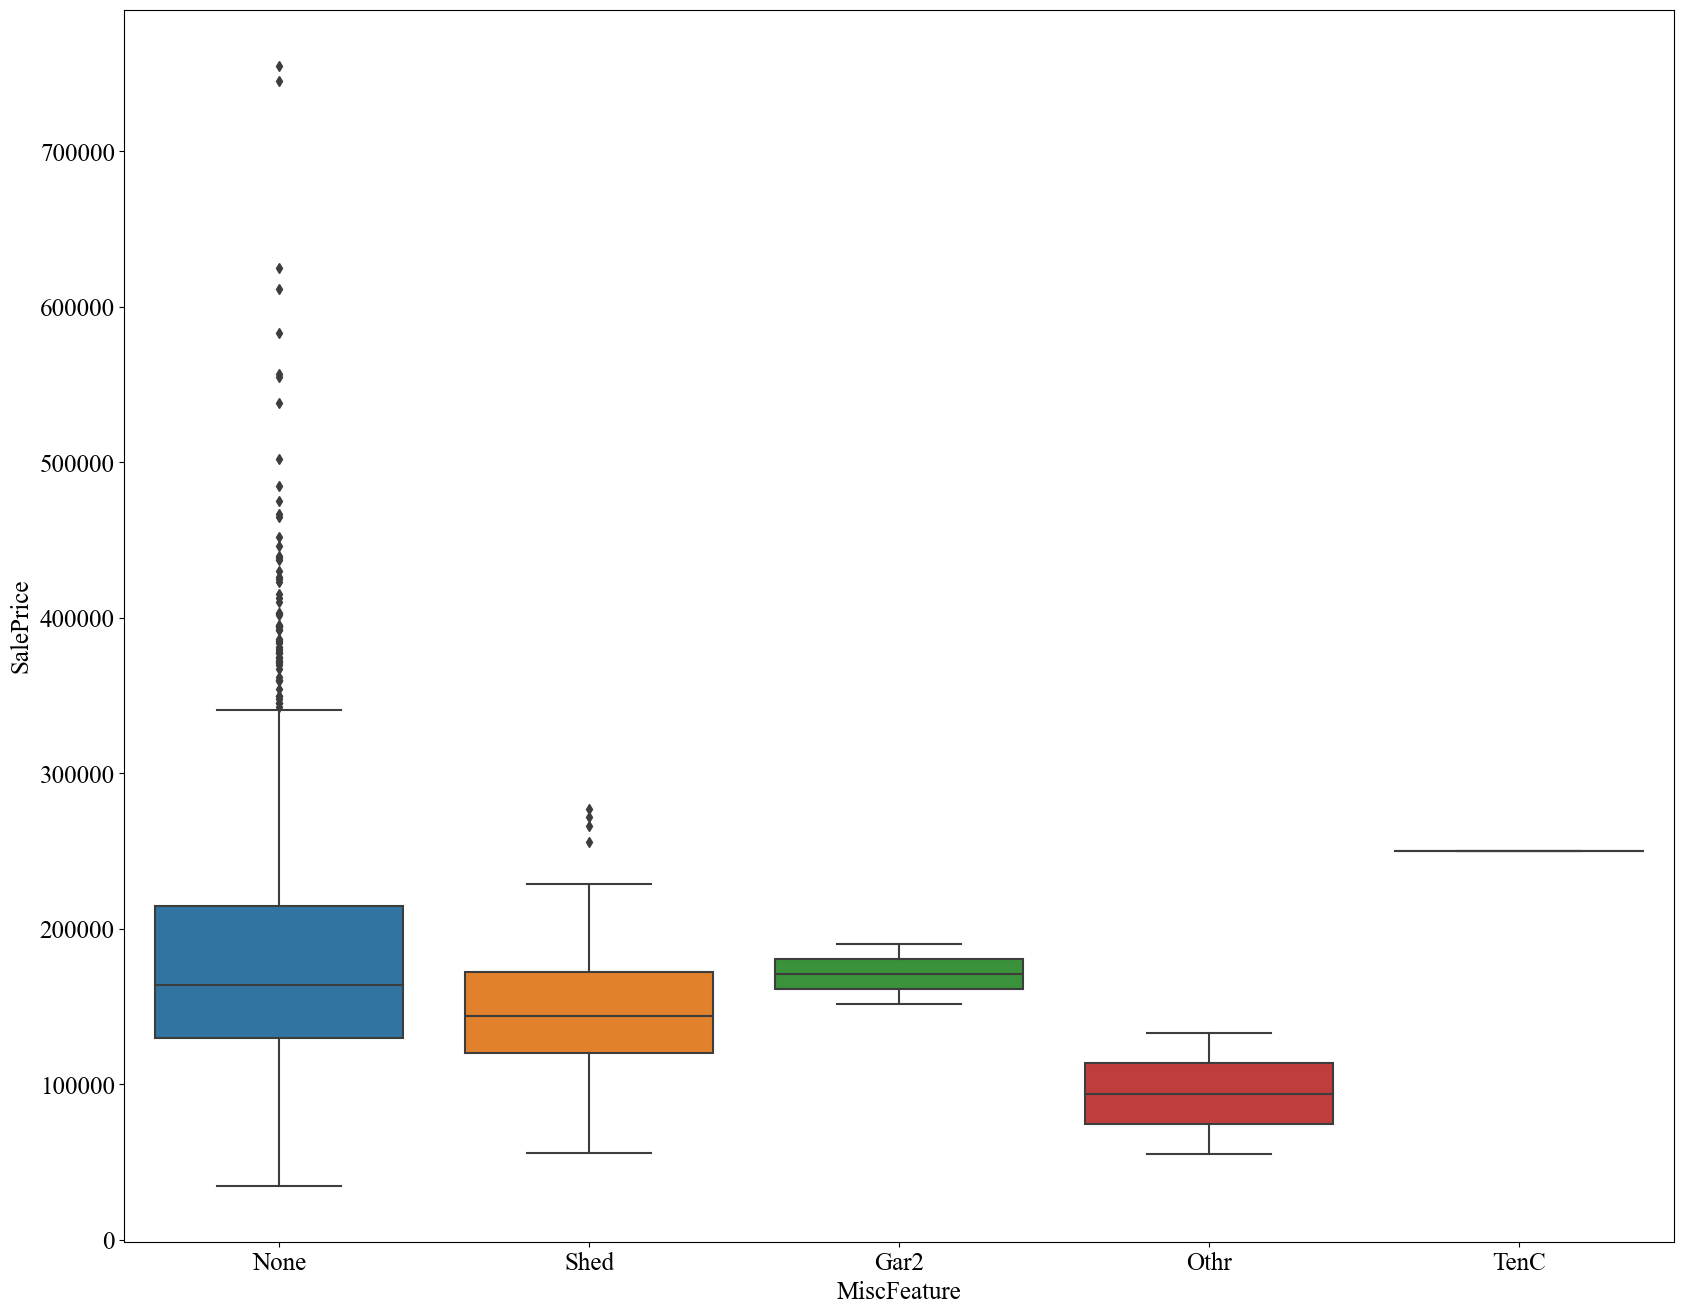

In [123]:
plot_cat_target(df_final,'MiscFeature')

In [124]:
df_final = df_final.drop('MiscFeature',axis=1)
df_final = pd.get_dummies(df_final)
# SalePrice should be the last column of the df
column_to_move = df_final.pop("SalePrice")
df_final.insert(len(df_final.columns), "SalePrice", column_to_move)

In [125]:
df_final.to_csv('training_data_houses.csv')

In [126]:
df_final

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0        1          60         65.0     8450            7            5   
1        2          20         80.0     9600            6            8   
2        3          60         68.0    11250            7            5   
3        4          70         60.0     9550            7            5   
4        5          60         84.0    14260            8            5   
...    ...         ...          ...      ...          ...          ...   
1455  1456          60         62.0     7917            6            5   
1456  1457          20         85.0    13175            6            6   
1457  1458          70         66.0     9042            7            9   
1458  1459          20         68.0     9717            5            6   
1459  1460          20         75.0     9937            5            6   

      YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  \
0          2003          2003       196.0          4          3         4   
1          1976          1976         0.0          3          3         4   
2          2001          2002       162.0          4          3         4   
3          1915          1970         0.0          3          3         3   
4          2000          2000       350.0          4          3         4   
...         ...           ...         ...        ...        ...       ...   
1455       1999          2000         0.0          3          3         4   
1456       1978          1988       119.0          3          3         4   
1457       1941          2006         0.0          5          4         3   
1458       1950          1996         0.0          3          3         3   
1459       1965          1965         0.0          4          3         3   

      BsmtCond  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  \
0            3         706           0        150          856          5   
1            3         978           0        284         1262          5   
2            3         486           0        434          920          5   
3            4         216           0        540          756          4   
4            3         655           0        490         1145          5   
...        ...         ...         ...        ...          ...        ...   
1455         3           0           0        953          953          5   
1456         3         790         163        589         1542          3   
1457         4         275           0        877         1152          5   
1458         3          49        1029          0         1078          4   
1459         3         830         290        136         1256          4   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0          856       854             0       1710             1             0   
1         1262         0             0       1262             0             1   
2          920       866             0       1786             1             0   
3          961       756             0       1717             1             0   
4         1145      1053             0       2198             1             0   
...        ...       ...           ...        ...           ...           ...   
1455       953       694             0       1647             0             0   
1456      2073         0             0       2073             1             0   
1457      1188      1152             0       2340             0             0   
1458      1078         0             0       1078             1             0   
1459      1256         0             0       1256             1             0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  \
0            2         1             3             1            4   
1            2         0             3             1            3   
2            2         1             3             1            4   
3            1      